In [1]:
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

import altair as alt
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, SVG, IFrame, Image, Video, display
from matplotlib import cm, colors
from scipy import stats
from scipy.stats import norm
from src.data import gdf_dic
from src.env import EnvVar
from src.maps import map_altair
from src.utils import discretisation, loadgpd

alt.renderers.set_embed_options(
    padding={"left": 100, "right": 100, "bottom": 20, "top": 20}, actions=False
)

RendererRegistry.enable('default')

In [2]:
# Data INSEE

from pynsee.utils.init_conn import init_conn

init_conn(
    insee_key="NzZfjOPcoI0C9gkeMyu0SH5ChW8a",
    insee_secret="zsvYnCV8BHcGX_1CWnR7YU3EkKIa",
)

from pynsee.localdata import (
    get_geo_list,
    get_local_data,
    get_local_metadata,
    get_nivgeo_list,
)

metadata = get_local_metadata()
metadata = metadata.query("DATASET_VERSION=='GEO2021RP2018'")


data_all_france = get_local_data(
    dataset_version="GEO2021RP2018",
    variables="CS1_6",
    nivgeo="DEP",
)

csp_fr = data_all_france.query("CS1_6==CS1_6 and CS1_6 != 'ENS'").copy()


def fxy(geo, csp, value):
    if csp in ["1", "2", "3", "4", "5", "6"]:
        e = data_all_france.query("CS1_6=='ENS' and CODEGEO==@geo").OBS_VALUE.values[0]
        return round(((value / e) * 100), 2)


csp_fr["OBS_VALUE_p"] = csp_fr.apply(
    lambda x: fxy(x["CODEGEO"], x["CS1_6"], x["OBS_VALUE"]), axis=1
)

csp_fr = csp_fr.sort_values(["CODEGEO", "CS1_6"]).copy()


# Todo à corriger, ne donne pas le bon résultat
def norm(x):
    return stats.boxcox(x)[0]


t = csp_fr.groupby("CS1_6")["OBS_VALUE_p"].apply(norm)

csp_fr["OBS_VALUE_p_norm"] = np.concatenate(t).ravel()

Token has been created
Subscription to all INSEE's APIs has been successfull
Unless the user wants to change key or secret,
using this function is no longer needed as the credentials to get the token have been saved locally here:
/home/florian/pynsee_credentials.csv
!!! This function renders only package's internal data,
it might not be the most up-to-date
Have a look at api.insee.fr !!!
Locally saved data has been used
Set update=True to trigger an update
By default, the query is on all departements
Locally saved data has been used
Set update=True to trigger an update


In [3]:
# Data Géo
ue = gdf_dic["abm_pays_gen3_4326"]
dep = gdf_dic["abm_departement_gen3_4326"]
df = csp_fr[
    ["CODEGEO", "CS1_6", "CS1_6_label", "OBS_VALUE_p", "OBS_VALUE_p_norm"]
].rename(columns={"OBS_VALUE_p": "IND", "CODEGEO": "COD_GEO"})

data = dep[["COD_GEO", "LIB_GEO", "geometry"]].merge(df, how="left")
gdf = data.sort_values(["CS1_6_label", "IND"], ascending=True)

<hr>

<h1 class="liner">Statistiques appliquées en cartographie</h1>

<br>
<br>
<div class="container">
        <div class="row align-middle">
          <div class="col">
              <div class=" cblanc" style="padding-top: 35px;">
                <div class="fas fa-globe"> </div>
                <div class="fas fa-chart-simple"></div>  
                <div class="fas fa-square-root-variable"></div>
                Florian Bayer
                <a href="florian.bayer@gmail.com">florian.bayer@gmail.com</a>
            </div>
          </div>
          <div class="col">
<svg style="float:right" xmlns="http://www.w3.org/2000/svg" xml:space="preserve" width="408.385" height="122.266" viewBox="0 0 108.052 32.349"><path d="M142.849 1065.385v-14.217H57.193v126.177h84.055v-14.218H73.185v-40.872h59.182v-13.33H73.185v-43.54zM169.148 1147.492v-96.327h-15.992v126.183h12.437l78.196-98.275v98.095h15.992v-126.003h-13.504zM352.011 1150.866c-1.427 1.659-3.318 3.26-5.684 4.797-2.373 1.543-5.041 2.935-8 4.182-2.97 1.241-6.194 2.245-9.686 3.017-3.492.771-7.135 1.154-10.928 1.154-9.838 0-17.036-1.839-21.59-5.505-4.564-3.678-6.844-8.713-6.844-15.11 0-3.435.65-6.283 1.96-8.528 1.3-2.25 3.342-4.176 6.126-5.777 2.784-1.601 6.247-2.993 10.388-4.177 4.148-1.183 9.072-2.425 14.751-3.73 6.526-1.42 12.419-3.057 17.691-4.884 5.267-1.845 9.768-4.124 13.504-6.845 3.73-2.726 6.572-6.044 8.532-9.954 1.95-3.91 2.935-8.707 2.935-14.391 0-6.045-1.183-11.288-3.561-15.732-2.367-4.443-5.597-8.115-9.681-11.015-4.095-2.907-8.921-5.041-14.484-6.399-5.574-1.363-11.618-2.047-18.126-2.047-9.716 0-18.927 1.514-27.634 4.53-8.706 3.028-16.618 7.437-23.73 13.243l7.646 13.504c1.89-2.013 4.356-4.026 7.378-6.038 3.016-2.019 6.456-3.823 10.301-5.418 3.858-1.601 8-2.906 12.442-3.916 4.45-1.003 9.09-1.508 13.95-1.508 9.003 0 15.998 1.601 20.97 4.797 4.976 3.202 7.464 8 7.464 14.398 0 3.55-.8 6.543-2.4 8.973-1.596 2.425-3.94 4.53-7.02 6.306-3.08 1.78-6.902 3.347-11.461 4.71-4.565 1.363-9.745 2.755-15.551 4.176-6.398 1.538-12.025 3.202-16.88 4.977-4.86 1.781-8.92 3.91-12.175 6.399-3.26 2.488-5.72 5.51-7.372 9.066-1.665 3.556-2.489 7.82-2.489 12.796 0 6.039 1.126 11.37 3.376 15.993a33.59 33.59 0 0 0 9.42 11.73c4.02 3.195 8.817 5.597 14.391 7.198 5.569 1.6 11.607 2.395 18.127 2.395 8.532 0 16.23-1.299 23.103-3.91 6.868-2.604 12.976-6.102 18.306-10.481zM433.233 1050.11c-9.142 0-18 1.907-26.318 5.66l-.934.418 10.69 11.874.47-.162a48.874 48.874 0 0 1 16.092-2.715c23.985 0 44.798 17.86 48.424 41.539l.046.342h-31.37l3.736 12.588h43.006c.232-2.146.232-3.046.232-5.093v-.377c0-2.106-.11-4.275-.325-6.445-3.277-32.855-30.685-57.63-63.75-57.63" style="fill:#eee8d5;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="matrix(.2455 0 0 -.24652 -14.041 291.175)"/><path d="m444.853 1107.633-40.876-45.385 17.605 58.483 40.87 45.39z" style="fill:#80cc2a;fill-opacity:1;fill-rule:evenodd;stroke:none" transform="matrix(.2455 0 0 -.24652 -14.041 291.175)"/><path d="M396.917 1061.39c-17.39 11.985-27.773 31.719-27.773 52.798 0 35.327 28.742 64.075 64.072 64.075a63.817 63.817 0 0 0 22.918-4.24l-10.18-12.518a49.235 49.235 0 0 1-12.738 1.682c-27.018 0-48.996-21.985-48.996-48.999 0-14.646 6.479-28.412 17.773-37.762l.377-.32-4.6-15.302zM474.427 1175.682l-6.01-10.453-1.148.662-2.343 11.868-4.542-7.912-1.473.847 6.003 10.453 1.172-.673c.203-1.195.412-2.326.62-3.394.204-1.073.424-2.129.662-3.173.18-.876.354-1.757.528-2.633.174-.876.348-1.764.516-2.663l4.548 7.918z" style="fill:#eee8d5;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="matrix(.2455 0 0 -.24652 -14.041 291.175)"/></svg>
          </div>
        </div>
</div>


<hr>

<h1>Présentation de l'enseignement</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-person-chalkboard fa-2xl fa-fade" style="color: #94bc14"></i>
        </div>
    </div>
</div>

    

<hr>

<h2> <i class="fa-solid fa-chart-gantt" style="color: #94bc14"></i> Déroulement des séances </h2> 

In [4]:
source = pd.DataFrame(
    [
        {
            "task": "A",
            "start": 0.5,
            "end": 0.75,
            "type": "Cours magistral",
            "desc": "Les statistiques en géographie",
        },
        {"task": "A", "start": 0.75, "end": 1, "type": "TD"},
        {
            "task": "B",
            "start": 7,
            "end": 7.25,
            "type": "Cours magistral",
            "desc": "La discrétisation en cartographie",
        },
        {"task": "B", "start": 7.25, "end": 8, "type": "TD"},
        {
            "task": "C",
            "start": 8,
            "end": 8.5,
            "type": "TD",
            "desc": "Application avancée",
        },
    ]
)

label = """
datum.label == 0 ? "6 déc." :
datum.label == 7 ? "12 déc." : 
datum.label == 8 ? "13 déc."  : 
datum.value == 0 ? "x": null"""

gantt = (
    alt.Chart(source, width=1200, height=300)
    .mark_bar()
    .encode(
        x=alt.X(
            "start", title="", axis=alt.Axis(labelExpr=label, values=[0, 1, 7, 8, 9])
        ),
        x2=alt.X2("end"),
        y=alt.Y("task", title="", axis=alt.Axis(labels=False)),
        color=alt.Color("type:N"),
    )
)


text_gantt_A = (
    alt.Chart(source.query("task=='A' and type=='Cours magistral'"))
    .mark_text(
        dx=80,
        dy=0,
        align="left",
        baseline="middle",
        fontSize=15,
        fontWeight="bold",
        color="#747C7C",
    )
    .encode(x=alt.X("start"), y=alt.Y("task:N"), text=alt.Text("desc"))
)

text_gantt_B = (
    alt.Chart(source.query("task=='B' and type=='Cours magistral'"))
    .mark_text(
        dx=-10,
        dy=0,
        align="right",
        baseline="middle",
        fontSize=15,
        fontWeight="bold",
        color="#747C7C",
    )
    .encode(x=alt.X("start"), y=alt.Y("task:N"), text=alt.Text("desc"))
)

text_gantt_C = (
    alt.Chart(source.query("task=='C' and type=='TD'"))
    .mark_text(
        dx=-10,
        dy=0,
        align="right",
        baseline="middle",
        fontSize=15,
        fontWeight="bold",
        color="#747C7C",
    )
    .encode(x=alt.X("start"), y=alt.Y("task:N"), text=alt.Text("desc"))
)


gantt_all = gantt + text_gantt_A + text_gantt_B + text_gantt_C
gantt_all.configure_title(fontSize=17, color="gray").configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
).configure_legend(
    title=None,
    orient="bottom",
    direction="horizontal",
    labelColor="gray",
    labelFontSize=15,
    titleAnchor="middle",
).configure_range(
    category=alt.RangeScheme(["#747C7C", "#94BD13"])
)

alt.LayerChart(...)

Le support de cours et les TD sont diponibles en ligne : 
<a href="https://github.com/fbxyz/ENSG_L1_cartostat" style="color: #94bc14">https://github.com/fbxyz/ENSG_L1_cartostat </a>

<hr>

<h2> <i class="fa-solid fa-list-check" style="color: #94bc14"></i> Contenu de l’enseignement </h2> 

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Un cours sur :</b></p>
          <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Les statistiques appliquées à la cartographie.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Et les méthodes de discrétisation.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Avec des séances de TD pour appliquer les acquis</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Dans le détail :</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Principes de la discrétisation en cartographie : pourquoi et quand discrétiser ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Traiter l’information statistique de manière simple, pour l’adapter au message cartographique</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Discrétiser en fonction des besoins et de la forme de la série.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Choisir le nombre de classes.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Comment comparer des cartes avec les mêmes unités.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Ou avec des unités différentes.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Transformer si besoin les séries</p>    
      </div>
      </div>
    </div>
  </div>
</div>


<hr>

<h2> <i class="fa-solid fa-screwdriver-wrench" style="color: #94bc14"></i> Séances de TD </h2> 

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>L'analyse univariée en cartographie (Python)</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Machine virtuelle en ligne ou Conda sur vos ordinateurs</p>  
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Interprétation des résultats</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Application avec Qgis</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Analyse de données en cartographie ?</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb" style="background-color: gainsboro!important;">
         <div class="text-center">
            <img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/Python_logo_and_wordmark.svg" alt="..." width=50%>
         </div>
        <br>
        <div class="text-center">
            <img src="https://upload.wikimedia.org/wikipedia/commons/e/ea/Conda_logo.svg" alt="..." width=45%>
        </div>
        <br> <br>
        <div class="text-center">
            <img src="https://upload.wikimedia.org/wikipedia/commons/c/c2/QGIS_logo%2C_2017.svg" alt="..." width=45%>
        </div>
      </div>
      </div>
    </div>
  </div>
</div>

<hr>

<h2> <i class="fa-solid fa-book" style="color: #94bc14"></i> Bibliographie </h2> 

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Statistique en géographie : </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Béguin, M., & Pumain, D. (2017). La représentation des données géographiques-4e éd.: Statistique et cartographie. Armand Colin.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Lambert, N., & Zanin, C. (2016). Manuel de cartographie: principes, méthodes, applications. Armand Colin.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Dumolard, P., Dubus, N., & Charleux, L. L. (2003). Les statistiques en géographie (p. 240). Editions Belin.</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Statistique : </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Saporta, G. (2006). Probabilités, analyse des données et statistique. Editions technip.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Sanders, L. (1990). L’analyse des données appliquées à la géographie, GIP RECLUS.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Bouyer, J. (2009). Épidémiologie: principes et méthodes quantitatives. Lavoisier.</p>
      </div>
      </div>
    </div>
  </div>
</div>

<hr>

<h1>Concepts et outils utilisés dans cet enseignement</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-brain fa-2xl fa-fade" style="color: #94bc14"></i>
        </div>
    </div>
</div>



<hr>

<h2> <i class="fa-solid fa-sitemap" style="color: #94bc14"></i> Schéma de production cartographique </h2>  


In [5]:
svg = """<?xml version="1.0" encoding="UTF-8"?><svg width="1272.3" height="569.87" version="1.1" viewBox="0 0 336.62 150.78" xmlns="http://www.w3.org/2000/svg"><defs><clipPath id="gd"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ec"><path d="m0 0h1555v736h-1555z" clip-rule="evenodd"/></clipPath><clipPath id="cx"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="cw"><path d="m36 328h210v72h-210z" clip-rule="evenodd"/></clipPath><clipPath id="cv"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="cu"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ct"><path d="m412 236h117v42h-117z" clip-rule="evenodd"/></clipPath><clipPath id="cs"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="cr"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="cq"><path d="m554 508h162v42h-162z" clip-rule="evenodd"/></clipPath><clipPath id="cp"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="co"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="cn"><path d="m624 224h266v67h-266z" clip-rule="evenodd"/></clipPath><clipPath id="cm"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="cl"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ck"><path d="m1009 324h215v42h-215z" clip-rule="evenodd"/></clipPath><clipPath id="cj"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ci"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ch"><path d="m1329 324h159v42h-159z" clip-rule="evenodd"/></clipPath><clipPath id="cg"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="cf"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ce"><path d="m34 463h215v114h-215z" clip-rule="evenodd"/></clipPath><clipPath id="cd"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="cc"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="cb"><path d="m154.5 475h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="ca"><path d="m149.5 475h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="hd"><path d="m149.5 475h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="hc"><path d="m149.5 475h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="hb"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ha"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="gz"><path d="m140.5 505h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="gy"><path d="m135.5 505h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="gx"><path d="m135.5 505h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="gw"><path d="m135.5 505h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="gv"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="gu"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="gt"><path d="m149.5 535h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="gs"><path d="m144.5 535h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="gr"><path d="m144.5 535h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="gq"><path d="m144.5 535h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="gp"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="go"><path d="m370 43h201v114h-201z" clip-rule="evenodd"/></clipPath><clipPath id="gn"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="gm"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="gl"><path d="m517.5 55h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="gk"><path d="m512.5 55h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="gj"><path d="m512.5 55h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="gi"><path d="m512.5 55h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="gh"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="gg"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="gf"><path d="m500.5 85h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="ge"><path d="m495.5 85h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fc"><path d="m495.5 85h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fb"><path d="m495.5 85h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fa"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ez"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ey"><path d="m532.5 115h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="ex"><path d="m527.5 115h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ew"><path d="m527.5 115h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ev"><path d="m527.5 115h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="eu"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="et"><path d="m620 60h274v81h-274z" clip-rule="evenodd"/></clipPath><clipPath id="es"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="er"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="eq"><path d="m663.5 97.5h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="ep"><path d="m658.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="eo"><path d="m658.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="en"><path d="m658.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="em"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="el"><path d="m700.5 97.5h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="ek"><path d="m695.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ej"><path d="m695.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ei"><path d="m695.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="eh"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="eg"><path d="m737.5 97.5h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="ef"><path d="m732.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ee"><path d="m732.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ed"><path d="m732.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="gc"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="gb"><path d="m774.5 97.5h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="ga"><path d="m769.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fz"><path d="m769.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fy"><path d="m769.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fx"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="fw"><path d="m532 608h207v86h-207z" clip-rule="evenodd"/></clipPath><clipPath id="fv"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="fu"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ft"><path d="m655 621h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="fs"><path d="m650 621h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fr"><path d="m650 621h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fq"><path d="m650 621h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fp"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="fo"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="fn"><path d="m690 651h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="fm"><path d="m685 651h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fl"><path d="m685 651h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fk"><path d="m685 651h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fj"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="fi"><path d="m946 430h341v137h-341z" clip-rule="evenodd"/></clipPath><clipPath id="fh"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="fg"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="ff"><path d="m1195.5 468h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="fe"><path d="m1190.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="fd"><path d="m1190.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dx"><path d="m1190.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dw"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="dv"><path d="m1232.5 468h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="du"><path d="m1227.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dt"><path d="m1227.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ds"><path d="m1227.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dr"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="dq"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="dp"><path d="m1195.5 523h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="do"><path d="m1190.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dn"><path d="m1190.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dm"><path d="m1190.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dl"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="dk"><path d="m1232.5 523h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="dj"><path d="m1227.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="di"><path d="m1227.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dh"><path d="m1227.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dg"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="df"><path d="m1336 475h145v47h-145z" clip-rule="evenodd"/></clipPath><clipPath id="de"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="dd"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="dc"><path d="m1405.5 483h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="db"><path d="m1400.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="da"><path d="m1400.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="cz"><path d="m1400.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="cy"><path d="m0 0h1629v745h-1629z" clip-rule="evenodd"/></clipPath><clipPath id="eb"><path d="m1442.5 483h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="ea"><path d="m1437.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dz"><path d="m1437.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="dy"><path d="m1437.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath></defs><g transform="translate(-11.048 -31.341)"><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#gd)"><g clip-path="url(#ec)"><path d="m247.72 357.37 9.745 6.43-9.745 6.429h9.745v-12.86z" fill="#ebd95f"/><g fill="#94bc14"><path d="m394.17 250.05h0.42l9.29 6.22-9.29 6.22h-0.42"/></g><path transform="matrix(1.3992 0 0 1.3992 141.32 363.8)" d="m181-81.596c-18.962 0-31.114 5.2722-38.832 13.479-7.7178 8.2063-10.853 18.599-13.967 28.199s-6.1791 18.398-12.373 24.654c-6.1939 6.2565-15.745 10.668-33.828 10.668v9.1914c19.646 0 32.26-5.2135 40.359-13.395 8.0992-8.181 11.455-18.634 14.584-28.283 3.1292-9.6495 6.0577-18.507 11.918-24.738 5.8603-6.2312 14.801-10.584 32.139-10.584z" color="#000000" fill="#94bc14" stroke-linejoin="round" stroke-miterlimit="10" style="-inkscape-stroke:none"/><g fill="#94bc14"><path d="m531.14 250.15 8.963 5.914-8.963 5.914h8.963v-11.828z"/></g><g fill="#94bc14"><path d="m606.85 250.57h0.42l8.508 5.704-8.508 5.704h-0.42"/></g><g fill="#94bc14"><g transform="matrix(1.3992 0 0 1.3992 470.14 256.06)" stroke-linejoin="round" stroke-miterlimit="10"><path d="m49 0h49" color="#000000" stroke-width="8.4529" style="-inkscape-stroke:none"/><path d="m49-4.2266v8.4531h49v-8.4531z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#94bc14"><path d="m892.86 250.62 8.252 5.445-8.252 5.444h8.252v-10.889z"/></g><g fill="#94bc14"><path d="m991.64 339.19h0.42l7.797 5.235-7.797 5.234h-0.42"/></g><path transform="matrix(1.3992 0 0 1.3992 756.99 256.06)" d="m102-3.8906v7.7812c12.013 0 17.728 3.3504 21.545 8.3223 3.8173 4.9719 5.6089 12.275 7.4141 20.156 1.8052 7.8813 3.6282 16.347 8.9727 23.184s14.306 11.338 28.068 11.338v-7.7812c-12.188 0-18.048-3.3737-21.938-8.3496s-5.7153-12.26-7.5176-20.129c-1.8023-7.8687-3.5761-16.316-8.8281-23.156-5.2521-6.8406-14.109-11.365-27.717-11.365z" color="#000000" fill="#94bc14" stroke-linejoin="round" stroke-miterlimit="10" style="-inkscape-stroke:none"/><g fill="#94bc14"><path d="m1227.9 339.2 7.605 5.018-7.605 5.017h7.605v-10.035z"/></g><g fill="#94bc14"><path d="m1310.7 339.62h0.42l7.149 4.808-7.15 4.807h-0.42"/></g><g fill="#94bc14"><g transform="matrix(1.3992 0 0 1.3992 1116.6 344.21)" stroke-linejoin="round" stroke-miterlimit="10"><path d="m84 0h55" color="#000000" stroke-width="7.1718" style="-inkscape-stroke:none"/><path d="m84-3.5859v7.1719h55v-7.1719z" color="#000000" style="-inkscape-stroke:none"/></g></g><path d="m247.72 357.37 9.745 6.43-9.745 6.429h9.745v-12.86zm289.17 165.53h0.42l9.29 6.22-9.29 6.219h-0.42" fill="#ebd95f"/><path transform="matrix(1.3992 0 0 1.3992 141.32 363.8)" d="m82-4.5957v9.1914c36.933 0 58.653 7.2084 72.939 17.562 14.287 10.354 21.563 24.186 28.777 38.869 7.2147 14.683 14.295 30.236 28.742 42.088 14.447 11.852 35.901 19.48 70.541 19.48v-9.1914c-33.31 0-52.189-7.1217-64.711-17.395-12.522-10.273-19.044-24.22-26.324-39.037-7.2803-14.817-15.391-30.485-31.633-42.256-16.242-11.771-40.195-19.313-78.332-19.313z" color="#000000" fill="#94bc14" stroke-linejoin="round" stroke-miterlimit="10" style="-inkscape-stroke:none"/><path d="m718.64 523 8.964 5.914-8.964 5.913h8.964v-11.826z" fill="#ebd95f"/><g fill="#94bc14"><path d="m991.64 338.72h0.42l8.508 5.704-8.508 5.704h-0.42"/></g><path transform="matrix(1.3992 0 0 1.3992 635.26 528.91)" d="m255-136.23c-34.341 0-55.427 8.5862-69.209 21.801-13.782 13.215-20.025 30.443-26.375 46.904-6.35 16.461-12.763 32.147-25.889 43.727-13.125 11.58-33.285 19.568-68.527 19.568v8.4531c36.538 0 59.192-8.5117 74.119-21.682 14.927-13.17 21.804-30.485 28.184-47.023 6.38-16.539 12.307-32.31 24.338-43.846 12.031-11.535 30.4-19.449 63.359-19.449z" color="#000000" fill="#94bc14" stroke-linejoin="round" stroke-miterlimit="10" style="-inkscape-stroke:none"/><g fill="#e3e2db" stroke="#e3e2db"><g stroke="none"><path d="m134.89 461.7 6.43-9.746 6.429 9.745v-44.866l-6.43-9.608-6.43 9.608z" color="#000000" style="-inkscape-stroke:none"/><path d="m141.32 406.33-6.9297 10.355 2e-3 46.684 0.91602-1.3906 6.0137-9.1133 6.9297 10.504v-46.684zm2e-3 1.7969 5.9297 8.8613v43.051l-5.9297-8.9883-5.9297 8.9863-2e-3 -43.049z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#e3e2db" stroke="#e3e2db"><g stroke="none"><path d="m463.72 158.16 6.43 9.745 6.429-9.745v9.745h-12.859z" color="#000000" style="-inkscape-stroke:none"/><path d="m463.21 156.5v11.91h6.6602l0.26953 0.40821 0.26953-0.40821h6.6602v-11.91l-6.9297 10.502zm1 3.332 5 7.5781h-5zm11.859 0v7.5781h-5z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#e3e2db" stroke="#e3e2db"><g stroke="none"><path d="m463.78 218.21v0.42l6.22 9.29 6.22-9.29v-0.42z" color="#000000" style="-inkscape-stroke:none"/><path d="m463.29 217.71v1.0723l6.7207 10.037 6.7188-10.037v-1.0723zm1.1562 1h11.127l-5.5644 8.3125z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#e3e2db" stroke="#e3e2db"><g transform="matrix(1.3992 0 0 1.3992 470.14 99.346)" stroke="none"><path d="m0 48v37" color="#000000" style="-inkscape-stroke:none"/><path d="m-4.5957 48v37h9.1914v-37z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#e3e2db" stroke="#e3e2db"><g stroke="none"><path d="m750.56 141.37 6.429 9.745 6.43-9.745v9.745h-12.86z" color="#000000" style="-inkscape-stroke:none"/><path d="m750.06 139.71v1.666l-2e-3 10.244h6.6602l0.26953 0.4082 0.26953-0.4082h6.6621v-11.91l-6.9297 10.502zm12.859 3.3301v7.5801h-5.002zm-11.859 2e-3 4.998 7.5781h-5z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#e3e2db" stroke="#e3e2db"><g stroke="none"><path d="m750.63 205.62v0.42l6.22 9.29 6.22-9.29v-0.42z" color="#000000" style="-inkscape-stroke:none"/><path d="m750.13 205.12v1.0723l6.7207 10.037 6.7188-10.037v-1.0723zm1.1543 1h11.131l-5.5664 8.3144z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#e3e2db" stroke="#e3e2db"><g transform="matrix(1.3992 0 0 1.3992 756.99 99.346)" stroke="none"><path d="m0 36v40" color="#000000" style="-inkscape-stroke:none"/><path d="m-4.5957 36v40h9.1914v-40z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#e3e2db"><path d="m628.82 605.82 6.43-9.744 6.43 9.745v-39.269l-6.43-9.609-6.43 9.61z" color="#000000" style="-inkscape-stroke:none"/><path d="m635.26 556.04-6.9316 10.357v41.086l0.91797-1.3906 6.0137-9.1113 6.9297 10.502v-41.086zm0 1.7988 5.9297 8.8613v37.453l-5.9297-8.9883-5.9316 8.9883v-37.451z" color="#000000" style="-inkscape-stroke:none"/></g><g fill="#c8c4b7"><g fill="#e3e2db"><path d="m1110.2 428.12 6.43-9.744 6.429 9.744v-46.265l-6.43-9.608-6.43 9.608z" color="#000000" style="-inkscape-stroke:none"/><path d="m1116.6 371.35-6.9317 10.354v48.084l0.9179-1.3906 6.0118-9.1113 6.9296 10.502v-48.084zm0 1.7969 5.9296 8.8613v44.449l-5.9296-8.9883-5.9297 8.9863v-44.447z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#e3e2db" stroke="#e3e2db"><g stroke="none"><path d="m1401.2 472.89 6.429-9.745 6.43 9.745v-9.745h-12.86z" color="#000000" style="-inkscape-stroke:none"/><path d="m1407.6 462.24-0.2696 0.40821h-6.6601v11.91l0.916-1.3906 6.0118-9.1113 6.9297 10.502v-11.91h-6.6602zm-5.9297 1.4082h5l-5 7.5801zm6.8594 0h5v7.5781z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#e3e2db" stroke="#e3e2db"><g stroke="none"><path d="m1401.3 382.48v-0.42l6.22-9.29 6.22 9.29v0.42z" color="#000000" style="-inkscape-stroke:none"/><path d="m1407.5 371.87-6.7187 10.037v1.0723h13.439v-1.0723zm0 1.7969 5.5625 8.3125h-11.127z" color="#000000" style="-inkscape-stroke:none"/></g></g><g fill="#e3e2db" stroke="#e3e2db"><g transform="matrix(1.3992 0 0 1.3992 1407.6 498.13)" stroke="none"><path d="m0-24v-59" color="#000000" style="-inkscape-stroke:none"/><path d="m-4.5957-83v59h9.1914v-59z" color="#000000" style="-inkscape-stroke:none"/></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cx)"><g clip-path="url(#cw)"><path d="m37.154 364c0-19.882 16.118-36 36-36h135.69c19.882 0 36 16.118 36 36s-16.118 36-36 36h-135.69c-19.882 0-36-16.118-36-36z" fill="#94bc14"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cv)" fill="#454122"><g transform="translate(92.5,358)" aria-label="Message"><path d="m16.008 0v-11.016q0-1.8281 0.10547-3.5156-0.57422 2.0977-1.0312 3.2812l-4.2656 11.25h-1.5703l-4.3242-11.25-0.65625-1.9922-0.38672-1.2891 0.035156 1.3008 0.046875 2.2148v11.016h-1.9922v-16.512h2.9414l4.3945 11.449q0.23438 0.69141 0.44531 1.4883 0.22266 0.78516 0.29297 1.1367 0.09375-0.46875 0.38672-1.418 0.30469-0.96094 0.41016-1.207l4.3125-11.449h2.8711v16.512z"/><path d="m23.219-5.8945q0 2.1797 0.90234 3.3633 0.90234 1.1836 2.6367 1.1836 1.3711 0 2.1914-0.55078 0.83203-0.55078 1.125-1.3945l1.8516 0.52734q-1.1367 3-5.168 3-2.8125 0-4.2891-1.6758-1.4648-1.6758-1.4648-4.9805 0-3.1406 1.4648-4.8164 1.4766-1.6758 4.207-1.6758 5.5898 0 5.5898 6.7383v0.28125zm6.8672-1.6172q-0.17578-2.0039-1.0195-2.918-0.84375-0.92578-2.4258-0.92578-1.5352 0-2.4375 1.0312-0.89062 1.0195-0.96094 2.8125z"/><path d="m44.461-3.5039q0 1.793-1.3594 2.7656-1.3477 0.97266-3.7852 0.97266-2.3672 0-3.6562-0.77344-1.2773-0.78516-1.6641-2.4375l1.8633-0.36328q0.26953 1.0195 1.1133 1.5 0.84375 0.46875 2.3438 0.46875 1.6055 0 2.3438-0.49219 0.75-0.49219 0.75-1.4766 0-0.75-0.51562-1.2187t-1.6641-0.77344l-1.5117-0.39844q-1.8164-0.46875-2.5898-0.91406-0.76172-0.45703-1.1953-1.1016-0.43359-0.64453-0.43359-1.582 0-1.7344 1.2305-2.6367 1.2422-0.91406 3.6094-0.91406 2.0977 0 3.3281 0.73828 1.2422 0.73828 1.5703 2.3672l-1.8984 0.23438q-0.17578-0.84375-0.94922-1.2891-0.76172-0.45703-2.0508-0.45703-1.4297 0-2.1094 0.43359-0.67969 0.43359-0.67969 1.3125 0 0.53906 0.28125 0.89062t0.83203 0.59766q0.55078 0.24609 2.3203 0.67969 1.6758 0.42188 2.4141 0.78516 0.73828 0.35156 1.1602 0.78516 0.43359 0.43359 0.66797 1.0078 0.23438 0.5625 0.23438 1.2891z"/><path d="m56.461-3.5039q0 1.793-1.3594 2.7656-1.3477 0.97266-3.7852 0.97266-2.3672 0-3.6562-0.77344-1.2773-0.78516-1.6641-2.4375l1.8633-0.36328q0.26953 1.0195 1.1133 1.5 0.84375 0.46875 2.3438 0.46875 1.6055 0 2.3438-0.49219 0.75-0.49219 0.75-1.4766 0-0.75-0.51562-1.2187t-1.6641-0.77344l-1.5117-0.39844q-1.8164-0.46875-2.5898-0.91406-0.76172-0.45703-1.1953-1.1016-0.43359-0.64453-0.43359-1.582 0-1.7344 1.2305-2.6367 1.2422-0.91406 3.6094-0.91406 2.0977 0 3.3281 0.73828 1.2422 0.73828 1.5703 2.3672l-1.8984 0.23438q-0.17578-0.84375-0.94922-1.2891-0.76172-0.45703-2.0508-0.45703-1.4297 0-2.1094 0.43359-0.67969 0.43359-0.67969 1.3125 0 0.53906 0.28125 0.89062t0.83203 0.59766q0.55078 0.24609 2.3203 0.67969 1.6758 0.42188 2.4141 0.78516 0.73828 0.35156 1.1602 0.78516 0.43359 0.43359 0.66797 1.0078 0.23438 0.5625 0.23438 1.2891z"/><path d="m62.18 0.23438q-1.9102 0-2.8711-1.0078-0.96094-1.0078-0.96094-2.7656 0-1.9688 1.2891-3.0234 1.3008-1.0547 4.1836-1.125l2.8477-0.046875v-0.69141q0-1.5469-0.65625-2.2148-0.65625-0.66797-2.0625-0.66797-1.418 0-2.0625 0.48047-0.64453 0.48047-0.77344 1.5352l-2.2031-0.19922q0.53906-3.4219 5.0859-3.4219 2.3906 0 3.5977 1.1016 1.207 1.0898 1.207 3.1641v5.4609q0 0.9375 0.24609 1.418 0.24609 0.46875 0.9375 0.46875 0.30469 0 0.69141-0.082031v1.3125q-0.79688 0.1875-1.6289 0.1875-1.1719 0-1.7109-0.60938-0.52734-0.62109-0.59766-1.9336h-0.07031q-0.8086 1.4531-1.8867 2.0625-1.0664 0.59766-2.6016 0.59766zm0.48047-1.582q1.1602 0 2.0625-0.52734t1.418-1.4414q0.52734-0.92578 0.52734-1.8984v-1.043l-2.3086 0.046875q-1.4883 0.023437-2.2617 0.30469-0.76172 0.28125-1.1719 0.86719t-0.41016 1.5352q0 1.0312 0.55078 1.5938 0.5625 0.5625 1.5938 0.5625z"/><path d="m77.094 4.9805q-2.0742 0-3.3047-0.82031-1.2305-0.80859-1.582-2.3086l2.1211-0.30469q0.21094 0.87891 0.92578 1.3477 0.72656 0.48047 1.8984 0.48047 3.1523 0 3.1523-3.6914v-2.0391h-0.02344q-0.59766 1.2188-1.6406 1.8398-1.043 0.60938-2.4375 0.60938-2.332 0-3.4336-1.5469-1.0898-1.5469-1.0898-4.8633 0-3.3633 1.1719-4.957 1.1836-1.6055 3.5859-1.6055 1.3477 0 2.332 0.62109 0.99609 0.60938 1.5352 1.7461h0.02344q0-0.35156 0.04687-1.2188 0.04687-0.86719 0.09375-0.94922h2.0039q-0.07031 0.63281-0.07031 2.625v9.6914q0 5.3437-5.3086 5.3437zm3.2109-11.32q0-1.5469-0.42188-2.6602-0.42188-1.125-1.1953-1.7109-0.76172-0.59766-1.7344-0.59766-1.6172 0-2.3555 1.1719-0.73828 1.1719-0.73828 3.7969 0 2.6016 0.69141 3.7383t2.3672 1.1367q0.99609 0 1.7695-0.58594 0.77344-0.58594 1.1953-1.6758 0.42188-1.1016 0.42188-2.6133z"/><path d="m87.25-5.8945q0 2.1797 0.90234 3.3633 0.90234 1.1836 2.6367 1.1836 1.3711 0 2.1914-0.55078 0.83203-0.55078 1.125-1.3945l1.8516 0.52734q-1.1367 3-5.168 3-2.8125 0-4.2891-1.6758-1.4648-1.6758-1.4648-4.9805 0-3.1406 1.4648-4.8164 1.4766-1.6758 4.207-1.6758 5.5898 0 5.5898 6.7383v0.28125zm6.8672-1.6172q-0.17578-2.0039-1.0195-2.918-0.84375-0.92578-2.4258-0.92578-1.5352 0-2.4375 1.0312-0.89062 1.0195-0.96094 2.8125z"/></g><g transform="translate(61,386)" aria-label="cartographique"><path d="m3.2227-6.3984q0 2.5312 0.79687 3.75 0.79688 1.2188 2.4023 1.2188 1.125 0 1.875-0.60938 0.76172-0.60938 0.9375-1.875l2.1328 0.14062q-0.24609 1.8281-1.5586 2.918-1.3125 1.0898-3.3281 1.0898-2.6602 0-4.0664-1.6758-1.3945-1.6875-1.3945-4.9102 0-3.1992 1.4063-4.875 1.4062-1.6875 4.0312-1.6875 1.9453 0 3.2227 1.0078 1.2891 1.0078 1.6172 2.7773l-2.168 0.16406q-0.16406-1.0547-0.83203-1.6758t-1.8984-0.62109q-1.6758 0-2.4258 1.1133-0.75 1.1133-0.75 3.75z"/><path d="m16.852 0.23438q-1.9102 0-2.8711-1.0078-0.96094-1.0078-0.96094-2.7656 0-1.9688 1.2891-3.0234 1.3008-1.0547 4.1836-1.125l2.8477-0.046875v-0.69141q0-1.5469-0.65625-2.2148-0.65625-0.66797-2.0625-0.66797-1.418 0-2.0625 0.48047t-0.77344 1.5352l-2.2031-0.19922q0.53906-3.4219 5.0859-3.4219 2.3906 0 3.5977 1.1016 1.207 1.0898 1.207 3.1641v5.4609q0 0.9375 0.24609 1.418 0.24609 0.46875 0.9375 0.46875 0.30469 0 0.69141-0.082031v1.3125q-0.79688 0.1875-1.6289 0.1875-1.1719 0-1.7109-0.60938-0.52734-0.62109-0.59766-1.9336h-0.07031q-0.8086 1.4531-1.8867 2.0625-1.0664 0.59766-2.6016 0.59766zm0.48047-1.582q1.1602 0 2.0625-0.52734t1.418-1.4414q0.52734-0.92578 0.52734-1.8984v-1.043l-2.3086 0.046875q-1.4883 0.023438-2.2617 0.30469-0.76172 0.28125-1.1719 0.86719t-0.41016 1.5352q0 1.0312 0.55078 1.5938 0.5625 0.5625 1.5938 0.5625z"/><path d="m27.008 0v-9.7266q0-1.3359-0.07031-2.9531h1.9922q0.09375 2.1562 0.09375 2.5898h0.04687q0.50391-1.6289 1.1602-2.2266 0.65625-0.59766 1.8516-0.59766 0.42188 0 0.85547 0.11719v1.9336q-0.42188-0.11719-1.125-0.11719-1.3125 0-2.0039 1.1367-0.69141 1.125-0.69141 3.2344v6.6094z"/><path d="m39.82-0.09375q-1.043 0.28125-2.1328 0.28125-2.5312 0-2.5312-2.8711v-8.4609h-1.4648v-1.5352h1.5469l0.62109-2.8359h1.4062v2.8359h2.3438v1.5352h-2.3438v8.0039q0 0.91406 0.29297 1.2891 0.30469 0.36328 1.043 0.36328 0.42188 0 1.2188-0.16406z"/><path d="m52.324-6.3516q0 3.3281-1.4648 4.957-1.4648 1.6289-4.2539 1.6289-2.7773 0-4.1953-1.6875-1.418-1.6992-1.418-4.8984 0-6.5625 5.6836-6.5625 2.9062 0 4.2773 1.6055 1.3711 1.5938 1.3711 4.957zm-2.2148 0q0-2.625-0.78516-3.8086-0.77344-1.1953-2.6133-1.1953-1.8516 0-2.6836 1.2188-0.82031 1.207-0.82031 3.7852 0 2.5078 0.80859 3.7734 0.82031 1.2539 2.5664 1.2539 1.8984 0 2.707-1.2188 0.82031-1.2188 0.82031-3.8086z"/><path d="m59.75 4.9805q-2.0742 0-3.3047-0.82031-1.2305-0.80859-1.582-2.3086l2.1211-0.30469q0.21094 0.87891 0.92578 1.3477 0.72656 0.48047 1.8984 0.48047 3.1523 0 3.1523-3.6914v-2.0391h-0.023437q-0.59766 1.2188-1.6406 1.8398-1.043 0.60938-2.4375 0.60938-2.332 0-3.4336-1.5469-1.0898-1.5469-1.0898-4.8633 0-3.3633 1.1719-4.957 1.1836-1.6055 3.5859-1.6055 1.3477 0 2.332 0.62109 0.99609 0.60938 1.5352 1.7461h0.02344q0-0.35156 0.04687-1.2188 0.04687-0.86719 0.09375-0.94922h2.0039q-0.07031 0.63281-0.07031 2.625v9.6914q0 5.3437-5.3086 5.3437zm3.2109-11.32q0-1.5469-0.42188-2.6602-0.42188-1.125-1.1953-1.7109-0.76172-0.59766-1.7344-0.59766-1.6172 0-2.3555 1.1719-0.73828 1.1719-0.73828 3.7969 0 2.6016 0.69141 3.7383t2.3672 1.1367q0.99609 0 1.7695-0.58594 0.77344-0.58594 1.1953-1.6758 0.42188-1.1016 0.42188-2.6133z"/><path d="m68.336 0v-9.7266q0-1.3359-0.07031-2.9531h1.9922q0.09375 2.1562 0.09375 2.5898h0.04687q0.50391-1.6289 1.1602-2.2266 0.65625-0.59766 1.8516-0.59766 0.42188 0 0.85547 0.11719v1.9336q-0.42188-0.11719-1.125-0.11719-1.3125 0-2.0039 1.1367-0.69141 1.125-0.69141 3.2344v6.6094z"/><path d="m79.508 0.23438q-1.9102 0-2.8711-1.0078-0.96094-1.0078-0.96094-2.7656 0-1.9688 1.2891-3.0234 1.3008-1.0547 4.1836-1.125l2.8477-0.046875v-0.69141q0-1.5469-0.65625-2.2148-0.65625-0.66797-2.0625-0.66797-1.418 0-2.0625 0.48047-0.64453 0.48047-0.77344 1.5352l-2.2031-0.19922q0.53906-3.4219 5.0859-3.4219 2.3906 0 3.5977 1.1016 1.207 1.0898 1.207 3.1641v5.4609q0 0.9375 0.24609 1.418 0.24609 0.46875 0.9375 0.46875 0.30469 0 0.69141-0.082031v1.3125q-0.79688 0.1875-1.6289 0.1875-1.1719 0-1.7109-0.60938-0.52734-0.62109-0.59766-1.9336h-0.07031q-0.8086 1.4531-1.8867 2.0625-1.0664 0.59766-2.6016 0.59766zm0.48047-1.582q1.1602 0 2.0625-0.52734t1.418-1.4414q0.52734-0.92578 0.52734-1.8984v-1.043l-2.3086 0.046875q-1.4883 0.023438-2.2617 0.30469-0.76172 0.28125-1.1719 0.86719t-0.41016 1.5352q0 1.0312 0.55078 1.5938 0.5625 0.5625 1.5938 0.5625z"/><path d="m100.34-6.3984q0 6.6328-4.6641 6.6328-2.9297 0-3.9375-2.2031h-0.05859q0.04687 0.09375 0.04687 1.9922v4.957h-2.1094v-15.07q0-1.957-0.07031-2.5898h2.0391q0.01172 0.04687 0.03516 0.33984 0.02344 0.28125 0.04687 0.87891 0.03516 0.59766 0.03516 0.82031h0.046871q0.5625-1.1719 1.4883-1.7109 0.92578-0.55078 2.4375-0.55078 2.3438 0 3.5039 1.5703 1.1602 1.5703 1.1602 4.9336zm-2.2148 0.046875q0-2.6484-0.71484-3.7852t-2.2734-1.1367q-1.2539 0-1.9688 0.52734-0.70312 0.52734-1.0781 1.6523-0.36328 1.1133-0.36328 2.9062 0 2.4961 0.79688 3.6797t2.5898 1.1836q1.5703 0 2.2852-1.1484 0.72656-1.1602 0.72656-3.8789z"/><path d="m105.06-10.512q0.67969-1.2422 1.6289-1.8164 0.96094-0.58594 2.4258-0.58594 2.0625 0 3.0352 1.0312 0.98437 1.0195 0.98437 3.4336v8.4492h-2.1211v-8.0391q0-1.3359-0.24609-1.9805-0.2461-0.65625-0.8086-0.96094-0.5625-0.30469-1.5586-0.30469-1.4883 0-2.3906 1.0312-0.89062 1.0312-0.89062 2.7773v7.4766h-2.1094v-17.391h2.1094v4.5234q0 0.71484-0.0469 1.4766-0.0352 0.76172-0.0469 0.87891z"/><path d="m116.29-15.375v-2.0156h2.1094v2.0156zm0 15.375v-12.68h2.1094v12.68z"/><path d="m125.69 0.23438q-2.4141 0-3.5391-1.6289-1.125-1.6289-1.125-4.8867 0-6.6328 4.6641-6.6328 1.4414 0 2.3789 0.51562 0.9375 0.50391 1.5703 1.6875h0.0234q0-0.35156 0.0469-1.207 0.0469-0.86719 0.0937-0.92578h2.0274q-0.082 0.69141-0.082 3.457v14.367h-2.1094v-5.1445l0.0469-1.9219h-0.0234q-0.63281 1.2539-1.5586 1.793-0.92578 0.52734-2.4141 0.52734zm3.9492-6.7266q0-2.4727-0.80859-3.668-0.8086-1.1953-2.5781-1.1953-1.6055 0-2.3086 1.1953-0.70313 1.1953-0.70313 3.8086 0 2.6602 0.70313 3.8086 0.71484 1.1484 2.2852 1.1484 1.793 0 2.6016-1.2773 0.80859-1.2773 0.80859-3.8203z"/><path d="m137.04-12.68v8.0391q0 1.2539 0.2461 1.9453 0.24609 0.69141 0.78515 0.99609 0.53906 0.30469 1.582 0.30469 1.5234 0 2.4024-1.043 0.8789-1.043 0.8789-2.8945v-7.3477h2.1094v9.9727q0 2.2148 0.0703 2.707h-1.9922q-0.0117-0.058594-0.0234-0.31641t-0.0352-0.58594q-0.0117-0.33984-0.0352-1.2656h-0.0352q-0.72657 1.3125-1.6875 1.8633-0.94922 0.53906-2.3672 0.53906-2.0859 0-3.0586-1.0312-0.96094-1.043-0.96094-3.4336v-8.4492z"/><path d="m149.94-5.8945q0 2.1797 0.90234 3.3633 0.90235 1.1836 2.6367 1.1836 1.3711 0 2.1914-0.55078 0.83203-0.55078 1.125-1.3945l1.8516 0.52734q-1.1367 3-5.168 3-2.8125 0-4.2891-1.6758-1.4648-1.6758-1.4648-4.9805 0-3.1406 1.4648-4.8164 1.4766-1.6758 4.207-1.6758 5.5898 0 5.5898 6.7383v0.28125zm6.8672-1.6172q-0.17578-2.0039-1.0195-2.918-0.84375-0.92578-2.4258-0.92578-1.5352 0-2.4375 1.0312-0.89062 1.0195-0.96093 2.8125z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cu)"><g clip-path="url(#ct)"><path d="m412 257c0-11.539 9.354-20.893 20.893-20.893h75.214c11.539 0 20.893 9.354 20.893 20.893s-9.354 20.893-20.893 20.893h-75.214c-11.539 0-20.893-9.354-20.893-20.893z" fill="#94bc14"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cs)"><g transform="translate(428,264.5)" fill="#454122" aria-label="Données"><path d="m14.161-7.3726q0 2.2354-0.87158 3.917-0.87158 1.6714-2.4712 2.5635-1.5996 0.89209-3.6914 0.89209h-5.4038v-14.448h4.7783q3.6709 0 5.6602 1.8457 1.9995 1.8354 1.9995 5.2295zm-1.9688 0q0-2.6865-1.4766-4.0913-1.4663-1.415-4.2554-1.415h-2.7788v11.31h3.2197q1.5894 0 2.7891-0.69727 1.21-0.69727 1.856-2.0098 0.646-1.3125 0.646-3.0967z"/><path d="m25.954-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9731-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68701-3.3325-0.67676-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71777 1.0562-0.71777 3.312 0 2.1943 0.70752 3.3018 0.71777 1.0972 2.2456 1.0972 1.6611 0 2.3687-1.0664 0.71777-1.0664 0.71777-3.3325z"/><path d="m35.288 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m46.959 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m53.002-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609zm-4.3271-5.7422v-0.20508l2.2251-2.9429h2.1226v0.29736l-3.3838 2.8506z"/><path d="m64.674-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m83.257-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.4561-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.3794 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cr)"><g clip-path="url(#cq)"><path d="m554 529c0-11.57 9.379-20.948 20.948-20.948h120.1c11.57 0 20.948 9.379 20.948 20.948 0 11.57-9.379 20.948-20.948 20.948h-120.1c-11.57 0-20.948-9.378-20.948-20.948z" fill="#94bc14"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cp)"><g transform="translate(570,536.5)" fill="#454122" aria-label="Fond de carte"><path d="m3.6812-12.848v5.373h8.0596v1.6201h-8.0596v5.855h-1.9585v-14.448h10.264v1.5996z"/><path d="m23.61-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9731-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68701-3.3325-0.67676-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71777 1.0562-0.71777 3.312 0 2.1943 0.70752 3.3018 0.71777 1.0972 2.2456 1.0972 1.6611 0 2.3687-1.0664 0.71777-1.0664 0.71777-3.3325z"/><path d="m32.944 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m44.575-1.7842q-0.5127 1.0664-1.3638 1.5278-0.84082 0.46143-2.0918 0.46143-2.1021 0-3.0967-1.415-0.98438-1.415-0.98438-4.2861 0-5.8037 4.0811-5.8037 1.2612 0 2.102 0.46143 0.84082 0.46143 1.3535 1.4663h0.02051l-0.02051-1.2407v-4.604h1.8457v12.93q0 1.7329 0.06152 2.2866h-1.7637q-0.03076-0.16406-0.07178-0.75879-0.03076-0.59473-0.03076-1.0254zm-5.5986-3.7734q0 2.3276 0.61524 3.3325 0.61523 1.0049 1.9995 1.0049 1.5688 0 2.2764-1.0869 0.70752-1.0869 0.70752-3.3735 0-2.2046-0.70752-3.23-0.70752-1.0254-2.2559-1.0254-1.3945 0-2.02 1.0356-0.61524 1.0254-0.61524 3.3428z"/><path d="m62.075-1.7842q-0.5127 1.0664-1.3638 1.5278-0.84082 0.46143-2.0918 0.46143-2.1021 0-3.0967-1.415-0.98438-1.415-0.98438-4.2861 0-5.8037 4.0811-5.8037 1.2612 0 2.102 0.46143 0.84082 0.46143 1.3535 1.4663h0.02051l-0.02051-1.2407v-4.604h1.8457v12.93q0 1.7329 0.06152 2.2866h-1.7637q-0.03076-0.16406-0.07178-0.75879-0.03076-0.59473-0.03076-1.0254zm-5.5986-3.7734q0 2.3276 0.61524 3.3325 0.61523 1.0049 1.9995 1.0049 1.5688 0 2.2764-1.0869 0.70752-1.0869 0.70752-3.3735 0-2.2046-0.70752-3.23-0.70752-1.0254-2.2559-1.0254-1.3945 0-2.02 1.0356-0.61524 1.0254-0.61524 3.3428z"/><path d="m68.158-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m85.648-5.5986q0 2.2148 0.69727 3.2812 0.69726 1.0664 2.1021 1.0664 0.98438 0 1.6406-0.5332 0.6665-0.5332 0.82031-1.6406l1.8662 0.12305q-0.21533 1.5996-1.3638 2.5532-1.1484 0.95361-2.9121 0.95361-2.3276 0-3.5581-1.4663-1.2202-1.4766-1.2202-4.2964 0-2.7993 1.2305-4.2656 1.2305-1.4766 3.5273-1.4766 1.7021 0 2.8198 0.88184 1.1279 0.88184 1.415 2.4302l-1.897 0.14355q-0.14356-0.92285-0.72803-1.4663-0.58447-0.54346-1.6611-0.54346-1.4663 0-2.1226 0.97412t-0.65625 3.2812z"/><path d="m97.573 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.148 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.26661 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46142-0.54346-0.52295-1.6919h-0.0615q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143 0.78955-0.46143 1.2407-1.2612 0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m106.46 0v-8.5107q0-1.1689-0.0615-2.584h1.7432q0.082 1.8867 0.082 2.2661h0.041q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74853 0.10254v1.6919q-0.36914-0.10254-0.98437-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m117.67-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25634 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m120.64-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#co)"><g clip-path="url(#cn)"><path d="m624.4 257.5c0-18.502 14.998-33.5 33.5-33.5h198.21c18.502 0 33.5 14.998 33.5 33.5s-14.998 33.5-33.5 33.5h-198.21c-18.502 0-33.5-14.998-33.5-33.5z" fill="#94bc14"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cm)" fill="#454122"><g transform="translate(672,252)" aria-label="Transformation en"><path d="m7.3828-12.848v12.848h-1.9482v-12.848h-4.9629v-1.5996h11.874v1.5996z"/><path d="m14.269 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m24.042 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m39.928 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m52.882-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.4561-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.3794 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m57.342-9.7515v9.7515h-1.8457v-9.7515h-1.5586v-1.3433h1.5586v-1.251q0-1.5176 0.6665-2.1841t2.0405-0.6665q0.76904 0 1.3022 0.12305v1.4048q-0.46142-0.08203-0.82031-0.08203-0.70752 0-1.0254 0.35889-0.31787 0.35889-0.31787 1.3022v0.99463h2.1636v1.3433z"/><path d="m70.266-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9731-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68701-3.3325-0.67676-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71777 1.0562-0.71777 3.312 0 2.1943 0.70752 3.3018 0.71777 1.0972 2.2456 1.0972 1.6611 0 2.3687-1.0664 0.71777-1.0664 0.71777-3.3325z"/><path d="m72.597 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04101q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m86 0v-7.0342q0-1.6099-0.44092-2.2251-0.44092-0.61523-1.5894-0.61523-1.1792 0-1.8662 0.90234-0.68701 0.90234-0.68701 2.543v6.4292h-1.8354v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.59473-1.1792 1.3638-1.6406t1.8765-0.46143q1.2612 0 1.9893 0.50244 0.73828 0.50244 1.0254 1.5996h0.03076q0.57422-1.1177 1.3843-1.6099 0.82031-0.49219 1.979-0.49219 1.6816 0 2.4404 0.9126 0.76904 0.9126 0.76904 2.9941v7.3931h-1.8252v-7.0342q0-1.6099-0.44092-2.2251-0.44092-0.61523-1.5894-0.61523-1.21 0-1.8867 0.90234-0.6665 0.89209-0.6665 2.543v6.4292z"/><path d="m99.854 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.148 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.26661 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46142-0.54346-0.52295-1.6919h-0.0615q-0.70752 1.2715-1.6509 1.8047-0.93311 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m112.96-0.082031q-0.91259 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54345-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m114.51-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m128.56-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9732-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68701-3.3325-0.67676-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71778 1.0562-0.71778 3.312 0 2.1943 0.70752 3.3018 0.71777 1.0972 2.2456 1.0972 1.6611 0 2.3686-1.0664 0.71777-1.0664 0.71777-3.3325z"/><path d="m137.9 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.102 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.0615-2.3687h1.7432q0.0103 0.05127 0.0205 0.27686 0.0103 0.22559 0.0205 0.52295 0.0205 0.28711 0.041 1.0972h0.0308q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85107 0.90234 0.85107 2.9941v7.3931z"/><path d="m149.77-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m167.07 0v-7.0342q0-1.0972-0.21533-1.7021-0.21534-0.60498-0.68702-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.102 0.9126-0.76905 0.9126-0.76905 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.0615-2.3687h1.7432q0.0102 0.05127 0.0205 0.27686 0.0102 0.22559 0.0205 0.52295 0.0205 0.28711 0.041 1.0972h0.0308q0.63575-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85107 0.90234 0.85107 2.9941v7.3931z"/></g><g transform="translate(646.5,277)" aria-label="langage cartographique"><path d="m1.415 0v-15.217h1.8457v15.217z"/><path d="m8.9014 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46142-0.81006 0.46142-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m24.788 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m33.619 4.3579q-1.8149 0-2.8916-0.71777-1.0767-0.70752-1.3843-2.02l1.856-0.2666q0.18457 0.76904 0.81006 1.1792 0.63574 0.42041 1.6611 0.42041 2.7583 0 2.7583-3.23v-1.7842h-0.02051q-0.52295 1.0664-1.4355 1.6099-0.9126 0.5332-2.1328 0.5332-2.0405 0-3.0044-1.3535-0.95361-1.3535-0.95361-4.2554 0-2.9429 1.0254-4.3374 1.0356-1.4048 3.1377-1.4048 1.1792 0 2.0405 0.54346 0.87158 0.5332 1.3433 1.5278h0.02051q0-0.30762 0.04102-1.0664 0.04102-0.75879 0.08203-0.83057h1.7534q-0.06152 0.55371-0.06152 2.2969v8.48q0 4.6758-4.645 4.6758zm2.8096-9.9053q0-1.3535-0.36914-2.3276-0.36914-0.98438-1.0459-1.4971-0.6665-0.52295-1.5176-0.52295-1.415 0-2.061 1.0254-0.646 1.0254-0.646 3.3223 0 2.2764 0.60498 3.271 0.60498 0.99463 2.0713 0.99463 0.87158 0 1.5483-0.5127t1.0459-1.4663q0.36914-0.96387 0.36914-2.2866z"/><path d="m43.917 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m56.963 4.3579q-1.8149 0-2.8916-0.71777-1.0767-0.70752-1.3843-2.02l1.856-0.2666q0.18457 0.76904 0.81006 1.1792 0.63574 0.42041 1.6611 0.42041 2.7583 0 2.7583-3.23v-1.7842h-0.02051q-0.52295 1.0664-1.4355 1.6099-0.9126 0.5332-2.1328 0.5332-2.0405 0-3.0044-1.3535-0.95361-1.3535-0.95361-4.2554 0-2.9429 1.0254-4.3374 1.0356-1.4048 3.1377-1.4048 1.1792 0 2.0405 0.54346 0.87158 0.5332 1.3433 1.5278h0.02051q0-0.30762 0.04102-1.0664 0.04102-0.75879 0.08203-0.83057h1.7534q-0.06152 0.55371-0.06152 2.2969v8.48q0 4.6758-4.645 4.6758zm2.8096-9.9053q0-1.3535-0.36914-2.3276-0.36914-0.98438-1.0459-1.4971-0.6665-0.52295-1.5176-0.52295-1.415 0-2.061 1.0254-0.646 1.0254-0.646 3.3223 0 2.2764 0.60498 3.271 0.60498 0.99463 2.0713 0.99463 0.87158 0 1.5483-0.5127t1.0459-1.4663q0.36914-0.96387 0.36914-2.2866z"/><path d="m65.846-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m83.335-5.5986q0 2.2148 0.69727 3.2812 0.69726 1.0664 2.1021 1.0664 0.98438 0 1.6406-0.5332 0.6665-0.5332 0.82031-1.6406l1.8662 0.12305q-0.21533 1.5996-1.3638 2.5532-1.1484 0.95361-2.9121 0.95361-2.3276 0-3.5581-1.4663-1.2202-1.4766-1.2202-4.2964 0-2.7993 1.2305-4.2656 1.2305-1.4766 3.5273-1.4766 1.7021 0 2.8198 0.88184 1.1279 0.88184 1.415 2.4302l-1.897 0.14355q-0.14356-0.92285-0.72803-1.4663-0.58447-0.54346-1.6611-0.54346-1.4663 0-2.1226 0.97412t-0.65625 3.2812z"/><path d="m95.261 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.26661 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m104.14 0v-8.5107q0-1.1689-0.0615-2.584h1.7432q0.082 1.8867 0.082 2.2661h0.041q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74853 0.10254v1.6919q-0.36914-0.10254-0.98437-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m115.35-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25634 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m126.3-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9731-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68702-3.3325-0.67675-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71778 1.0562-0.71778 3.312 0 2.1943 0.70752 3.3018 0.71778 1.0972 2.2456 1.0972 1.6611 0 2.3686-1.0664 0.71778-1.0664 0.71778-3.3325z"/><path d="m132.79 4.3579q-1.8149 0-2.8916-0.71777-1.0767-0.70752-1.3843-2.02l1.856-0.2666q0.18457 0.76904 0.81006 1.1792 0.63574 0.42041 1.6611 0.42041 2.7583 0 2.7583-3.23v-1.7842h-0.0205q-0.52295 1.0664-1.4356 1.6099-0.9126 0.5332-2.1328 0.5332-2.0405 0-3.0044-1.3535-0.95361-1.3535-0.95361-4.2554 0-2.9429 1.0254-4.3374 1.0356-1.4048 3.1377-1.4048 1.1792 0 2.0405 0.54346 0.87158 0.5332 1.3433 1.5278h0.0205q0-0.30762 0.041-1.0664 0.041-0.75879 0.082-0.83057h1.7534q-0.0615 0.55371-0.0615 2.2969v8.48q0 4.6758-4.645 4.6758zm2.8096-9.9053q0-1.3535-0.36914-2.3276-0.36914-0.98438-1.0459-1.4971-0.6665-0.52295-1.5176-0.52295-1.415 0-2.061 1.0254-0.64599 1.0254-0.64599 3.3223 0 2.2764 0.60498 3.271t2.0713 0.99463q0.87159 0 1.5483-0.5127 0.67676-0.5127 1.0459-1.4663 0.36914-0.96387 0.36914-2.2866z"/><path d="m140.3 0v-8.5107q0-1.1689-0.0615-2.584h1.7432q0.082 1.8867 0.082 2.2661h0.041q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74853 0.10254v1.6919q-0.36914-0.10254-0.98437-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m150.07 0.20508q-1.6714 0-2.5122-0.88184-0.84083-0.88184-0.84083-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67675 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.148 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.26661 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46142-0.54346-0.52295-1.6919h-0.0615q-0.70752 1.2715-1.6509 1.8047-0.93311 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879-0.35888 0.5127-0.35888 1.3433 0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m168.3-5.5986q0 5.8037-4.081 5.8037-2.5635 0-3.4453-1.9277h-0.0513q0.041 0.082031 0.041 1.7432v4.3374h-1.8457v-13.187q0-1.7124-0.0615-2.2661h1.7842q0.0103 0.04102 0.0308 0.29736 0.0205 0.24609 0.041 0.76904 0.0308 0.52295 0.0308 0.71777h0.041q0.49219-1.0254 1.3022-1.4971 0.81005-0.48193 2.1328-0.48193 2.0508 0 3.0659 1.374 1.0151 1.374 1.0151 4.3169zm-1.938 0.041016q0-2.3174-0.62548-3.312-0.62549-0.99463-1.9893-0.99463-1.0972 0-1.7227 0.46143-0.61523 0.46143-0.94336 1.4458-0.31787 0.97412-0.31787 2.543 0 2.1841 0.69727 3.2197 0.69726 1.0356 2.2661 1.0356 1.374 0 1.9995-1.0049 0.63574-1.0151 0.63574-3.394z"/><path d="m172.42-9.1978q0.59473-1.0869 1.4253-1.5894 0.84082-0.5127 2.1226-0.5127 1.8047 0 2.6558 0.90234 0.86132 0.89209 0.86132 3.0044v7.3931h-1.856v-7.0342q0-1.1689-0.21533-1.7329-0.21534-0.57422-0.70752-0.84082-0.49219-0.2666-1.3638-0.2666-1.3022 0-2.0918 0.90234-0.7793 0.90234-0.7793 2.4302v6.542h-1.8457v-15.217h1.8457v3.958q0 0.62549-0.041 1.292-0.0308 0.6665-0.041 0.76904z"/><path d="m182.25-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m190.46 0.20508q-2.1123 0-3.0967-1.4253-0.98437-1.4253-0.98437-4.2759 0-5.8037 4.081-5.8037 1.2612 0 2.0815 0.45117 0.82032 0.44092 1.374 1.4766h0.0205q0-0.30762 0.041-1.0562 0.041-0.75879 0.082-0.81006h1.7739q-0.0718 0.60498-0.0718 3.0249v12.571h-1.8457v-4.5015l0.041-1.6816h-0.0205q-0.55371 1.0972-1.3638 1.5688-0.81006 0.46143-2.1123 0.46143zm3.4556-5.8857q0-2.1636-0.70752-3.2095-0.70752-1.0459-2.2559-1.0459-1.4048 0-2.02 1.0459-0.61524 1.0459-0.61524 3.3325 0 2.3276 0.61524 3.3325 0.62549 1.0049 1.9995 1.0049 1.5688 0 2.2764-1.1177t0.70752-3.3428z"/><path d="m200.39-11.095v7.0342q0 1.0972 0.21533 1.7021 0.21534 0.60498 0.68702 0.87158 0.47167 0.2666 1.3843 0.2666 1.333 0 2.102-0.9126 0.76905-0.9126 0.76905-2.5327v-6.4292h1.8457v8.7261q0 1.938 0.0615 2.3687h-1.7432q-0.0103-0.05127-0.0205-0.27686-0.0103-0.22559-0.0308-0.5127-0.0103-0.29736-0.0308-1.1074h-0.0308q-0.63575 1.1484-1.4766 1.6304-0.83056 0.47168-2.0713 0.47168-1.8252 0-2.6763-0.90234-0.84082-0.9126-0.84082-3.0044v-7.3931z"/><path d="m211.67-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cl)"><g clip-path="url(#ck)"><path d="m1009 345c0-11.566 9.376-20.942 20.942-20.942h173.12c11.566 0 20.942 9.376 20.942 20.942s-9.376 20.942-20.942 20.942h-173.12c-11.566 0-20.942-9.376-20.942-20.942z" fill="#94bc14"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cj)"><g transform="translate(1024.5,352.5)" fill="#454122" aria-label="Création de la carte"><path d="m8.1211-13.063q-2.3994 0-3.7324 1.5483-1.333 1.5381-1.333 4.2246 0 2.6558 1.3843 4.2759 1.3945 1.6099 3.7632 1.6099 3.0352 0 4.563-3.0044l1.5996 0.7998q-0.89209 1.8662-2.5122 2.8403-1.6099 0.97412-3.7427 0.97412-2.1841 0-3.7837-0.90234-1.5894-0.9126-2.4302-2.5942-0.83057-1.6919-0.83057-3.999 0-3.4556 1.8662-5.4141 1.8662-1.9585 5.168-1.9585 2.3071 0 3.8555 0.90234t2.2764 2.6763l-1.856 0.61524q-0.50244-1.2612-1.6201-1.9277-1.1074-0.6665-2.6353-0.6665z"/><path d="m16.612 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m24.971-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609zm-4.3271-5.7422v-0.20508l2.2251-2.9429h2.1226v0.29736l-3.3838 2.8506z"/><path d="m38.058 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m51.165-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m52.717-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m66.766-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9731-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68701-3.3325-0.67676-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71777 1.0562-0.71777 3.312 0 2.1943 0.70752 3.3018 0.71777 1.0972 2.2456 1.0972 1.6611 0 2.3687-1.0664 0.71777-1.0664 0.71777-3.3325z"/><path d="m76.1 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m93.559-1.7842q-0.5127 1.0664-1.3638 1.5278-0.84082 0.46143-2.0918 0.46143-2.1021 0-3.0967-1.415-0.98438-1.415-0.98438-4.2861 0-5.8037 4.0811-5.8037 1.2612 0 2.102 0.46143 0.84082 0.46143 1.3535 1.4663h0.02051l-0.02051-1.2407v-4.604h1.8457v12.93q0 1.7329 0.06152 2.2866h-1.7637q-0.03076-0.16406-0.07178-0.75879-0.03076-0.59473-0.03076-1.0254zm-5.5986-3.7734q0 2.3276 0.61524 3.3325 0.61523 1.0049 1.9995 1.0049 1.5688 0 2.2764-1.0869 0.70752-1.0869 0.70752-3.3735 0-2.2046-0.70752-3.23-0.70752-1.0254-2.2559-1.0254-1.3945 0-2.02 1.0356-0.61524 1.0254-0.61524 3.3428z"/><path d="m99.643-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m115.73 0v-15.217h1.8457v15.217z"/><path d="m123.21 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57421-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56397 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.148 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21534 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69727 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.0615q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143 0.78956-0.46143 1.2407-1.2612 0.46142-0.81006 0.46142-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48194 1.3945 0.49218 0.49219 1.3945 0.49219z"/><path d="m139.29-5.5986q0 2.2148 0.69727 3.2812 0.69727 1.0664 2.102 1.0664 0.98438 0 1.6406-0.5332 0.6665-0.5332 0.82031-1.6406l1.8662 0.12305q-0.21533 1.5996-1.3638 2.5532-1.1484 0.95361-2.9121 0.95361-2.3276 0-3.5581-1.4663-1.2202-1.4766-1.2202-4.2964 0-2.7993 1.2305-4.2656 1.2305-1.4766 3.5273-1.4766 1.7022 0 2.8198 0.88184 1.1279 0.88184 1.415 2.4302l-1.897 0.14355q-0.14355-0.92285-0.72802-1.4663-0.58448-0.54346-1.6611-0.54346-1.4663 0-2.1226 0.97412t-0.65625 3.2812z"/><path d="m151.21 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57421-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56397 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.148 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21534 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69727 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.0615q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143 0.78956-0.46143 1.2407-1.2612 0.46142-0.81006 0.46142-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48194 1.3945 0.49218 0.49219 1.3945 0.49219z"/><path d="m160.1 0v-8.5107q0-1.1689-0.0615-2.584h1.7432q0.082 1.8867 0.082 2.2661h0.041q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m171.31-0.082031q-0.91259 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54345-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m174.28-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#ci)"><g clip-path="url(#ch)"><path d="m1329 345c0-11.554 9.367-20.921 20.921-20.921h117.16c11.554 0 20.921 9.367 20.921 20.921s-9.367 20.921-20.921 20.921h-117.16c-11.554 0-20.921-9.367-20.921-20.921z" fill="#94bc14"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cg)"><g transform="translate(1345,352.5)" fill="#454122" aria-label="Mise en page"><path d="m14.007 0v-9.6387q0-1.5996 0.09229-3.0762-0.50244 1.8354-0.90234 2.8711l-3.7324 9.8438h-1.374l-3.7837-9.8438-0.57422-1.7432-0.33838-1.1279 0.030762 1.1382 0.041016 1.938v9.6387h-1.7432v-14.448h2.5737l3.8452 10.018q0.20508 0.60498 0.38965 1.3022 0.19482 0.68701 0.25635 0.99463 0.082031-0.41016 0.33838-1.2407 0.2666-0.84082 0.35889-1.0562l3.7734-10.018h2.5122v14.448z"/><path d="m18.889-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m31.882-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.4561-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.3794 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m35.471-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m52.971-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m70.272 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m90.11-5.5986q0 5.8037-4.0811 5.8037-2.5635 0-3.4453-1.9277h-0.05127q0.04101 0.082031 0.04101 1.7432v4.3374h-1.8457v-13.187q0-1.7124-0.06152-2.2661h1.7842q0.01025 0.04102 0.03076 0.29736 0.02051 0.24609 0.04102 0.76904 0.03076 0.52295 0.03076 0.71777h0.04102q0.49219-1.0254 1.3022-1.4971 0.81006-0.48193 2.1328-0.48193 2.0508 0 3.0659 1.374 1.0151 1.374 1.0151 4.3169zm-1.938 0.041016q0-2.3174-0.62549-3.312-0.62549-0.99463-1.9893-0.99463-1.0972 0-1.7227 0.46143-0.61524 0.46143-0.94336 1.4458-0.31787 0.97412-0.31787 2.543 0 2.1841 0.69727 3.2197 0.69726 1.0356 2.2661 1.0356 1.374 0 1.9995-1.0049 0.63574-1.0151 0.63574-3.394z"/><path d="m95.229 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.26661 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m108.28 4.3579q-1.8149 0-2.8916-0.71777-1.0767-0.70752-1.3843-2.02l1.856-0.2666q0.18457 0.76904 0.81006 1.1792 0.63574 0.42041 1.6611 0.42041 2.7583 0 2.7583-3.23v-1.7842h-0.0205q-0.52295 1.0664-1.4355 1.6099-0.9126 0.5332-2.1328 0.5332-2.0405 0-3.0044-1.3535-0.95361-1.3535-0.95361-4.2554 0-2.9429 1.0254-4.3374 1.0356-1.4048 3.1377-1.4048 1.1792 0 2.0405 0.54346 0.87158 0.5332 1.3433 1.5278h0.0205q0-0.30762 0.041-1.0664 0.041-0.75879 0.082-0.83057h1.7534q-0.0615 0.55371-0.0615 2.2969v8.48q0 4.6758-4.645 4.6758zm2.8096-9.9053q0-1.3535-0.36914-2.3276-0.36914-0.98438-1.0459-1.4971-0.6665-0.52295-1.5176-0.52295-1.415 0-2.061 1.0254-0.646 1.0254-0.646 3.3223 0 2.2764 0.60498 3.271t2.0713 0.99463q0.87158 0 1.5483-0.5127t1.0459-1.4663q0.36914-0.96387 0.36914-2.2866z"/><path d="m117.16-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72802-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.1538-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.77929 0.89209-0.84082 2.4609z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cf)"><g clip-path="url(#ce)"><path d="m34.451 468.56a5.561 5.561 0 0 1 5.561-5.561h202.98a5.561 5.561 0 0 1 5.56 5.561v102.88a5.561 5.561 0 0 1-5.56 5.561h-202.98a5.561 5.561 0 0 1-5.56-5.561z" fill="#e3e2db"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cd)" fill="#492928"><g transform="translate(34.5,459)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 34.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 30.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(71.5,500)" aria-label="Objectif "><path d="m15.33-7.2905q0 2.2661-0.87158 3.9683-0.86133 1.7021-2.4814 2.6147-1.6201 0.9126-3.8247 0.9126-2.2251 0-3.8452-0.90234-1.6099-0.90234-2.4609-2.6045-0.85107-1.7124-0.85107-3.9888 0-3.4658 1.897-5.4141 1.897-1.9585 5.2808-1.9585 2.2046 0 3.8247 0.88184 1.6201 0.87158 2.4712 2.543 0.86133 1.6714 0.86133 3.9478zm-1.9995 0q0-2.6968-1.3535-4.2349-1.3433-1.5381-3.8042-1.5381-2.4814 0-3.835 1.5176-1.3535 1.5176-1.3535 4.2554 0 2.7173 1.3638 4.3169 1.374 1.5894 3.8042 1.5894 2.502 0 3.835-1.5381 1.3433-1.5483 1.3433-4.3682z"/><path d="m27.125-5.5986q0 5.8037-4.0811 5.8037-1.2612 0-2.1021-0.45117-0.83057-0.46143-1.3535-1.4766h-0.02051q0 0.31787-0.04102 0.97412-0.041009 0.646-0.061517 0.74854h-1.7842q0.06152-0.55371 0.06152-2.2866v-12.93h1.8457v4.3374q0 0.6665-0.04102 1.5688h0.04102q0.5127-1.0664 1.3535-1.5278 0.85107-0.46143 2.1021-0.46143 2.102 0 3.0864 1.415 0.99463 1.415 0.99463 4.2861zm-1.938 0.061523q0-2.3276-0.61523-3.3325-0.61524-1.0049-1.9995-1.0049-1.5586 0-2.2764 1.0664-0.70752 1.0664-0.70752 3.3838 0 2.1841 0.69727 3.23 0.69726 1.0356 2.2661 1.0356 1.3945 0 2.0098-1.0254 0.62549-1.0356 0.62549-3.353z"/><path d="m29.405-13.453v-1.7637h1.8457v1.7637zm1.8457 14.827q0 1.5688-0.61523 2.2764-0.61523 0.70752-1.8457 0.70752-0.78955 0-1.3022-0.092285v-1.4253l0.63574 0.061523q0.70752 0 0.99463-0.36914 0.28711-0.36914 0.28711-1.4355v-12.192h1.8457z"/><path d="m35.486-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m47.148-5.5986q0 2.2148 0.69727 3.2812 0.69726 1.0664 2.1021 1.0664 0.98438 0 1.6406-0.5332 0.6665-0.5332 0.82031-1.6406l1.8662 0.12305q-0.21533 1.5996-1.3638 2.5532-1.1484 0.95361-2.9121 0.95361-2.3276 0-3.5581-1.4663-1.2202-1.4766-1.2202-4.2964 0-2.7993 1.2305-4.2656 1.2305-1.4766 3.5273-1.4766 1.7021 0 2.8198 0.88184 1.1279 0.88184 1.415 2.4302l-1.897 0.14355q-0.14356-0.92285-0.72803-1.4663-0.58447-0.54346-1.6611-0.54346-1.4663 0-2.1226 0.97412t-0.65625 3.2812z"/><path d="m60.509-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m62.061-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m69.014-9.7515v9.7515h-1.8457v-9.7515h-1.5586v-1.3433h1.5586v-1.251q0-1.5176 0.6665-2.1841t2.0405-0.6665q0.76904 0 1.3022 0.12305v1.4048q-0.46142-0.08203-0.82031-0.08203-0.70752 0-1.0254 0.35889-0.31787 0.35889-0.31787 1.3022v0.99463h2.1636v1.3433z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cc)"><g clip-path="url(#cb)"><g clip-path="url(#ca)"><g clip-path="url(#hd)"><g clip-path="url(#hc)"><path d="m175.28 475h-22.556a3.222 3.222 0 0 0-3.222 3.222v21.75h29v-21.75a3.222 3.222 0 0 0-3.222-3.222z" fill="#ffcc4d"/><path d="m175.37 490.09c1.278-0.363 1.278-0.924 0-1.288l-0.45-0.124-0.448-0.132v4e-3l-2.368-0.717 1.871-1.558h-0.011l0.397-0.26 0.4-0.289c1.04-0.824 0.812-1.358-0.506-1.207l-0.513 0.072-0.509 0.073h-2e-3l-2.4 0.273 1.426-2.562 0.25-0.45c0.645-1.16 0.226-1.58-0.934-0.936l-0.45 0.227-0.447 0.225h-2e-3l-2.115 1.2 0.274-2.373v-2e-3l0.064-0.51 0.062-0.513c0.151-1.317-0.396-1.543-1.221-0.502l-0.318 0.402-1.818 2.296-0.66-2.321-1e-3 -4e-3 -0.28-0.987c-0.364-1.278-0.96-1.278-1.324 0l-0.14 0.493-0.14 0.494-0.661 2.325-1.5-1.893v-1e-3l-0.318-0.402-0.32-0.404c-0.824-1.039-1.373-0.811-1.22 0.507l0.118 1.02 0.279 2.4-2.56-1.426-0.448-0.25c-1.161-0.646-1.582-0.226-0.936 0.935l0.25 0.448 1.426 2.56-2.4-0.28-0.51-0.058-0.511-0.06c-1.318-0.152-1.545 0.397-0.507 1.22l0.404 0.32 0.402 0.319 1.893 1.5-2.323 0.662-0.986 0.28c-1.278 0.364-1.278 0.959 0 1.323l0.987 0.28 3e-3 2e-3 2.32 0.66-2.296 1.819-0.402 0.319c-1.04 0.824-0.814 1.373 0.502 1.222l0.514-0.065 0.51-0.065h1e-3l2.375-0.274-1.2 2.116v2e-3l-0.225 0.448-0.239 0.449c-0.644 1.16-0.218 1.579 0.942 0.933l0.451-0.249 2.566-1.426-0.272 2.4v2e-3l-0.065 0.509-0.062 0.512c-0.152 1.318 0.396 1.545 1.22 0.505l0.319-0.403 0.318-0.403 1.5-1.895 0.66 2.324v1e-3l0.14 0.493 0.142 0.494c0.364 1.278 0.89 1.278 1.254 0l0.213-0.987v-3e-3l0.729-2.321 1.534 1.894 0.335 0.403 0.328 0.403c0.823 1.039 1.378 0.813 1.225-0.504l-0.062-0.513-0.062-0.51v-2e-3l-0.274-2.374 2.114 1.2h2e-3l0.449 0.225 0.45 0.238c1.16 0.647 1.58 0.22 0.934-0.94l-0.226-0.452-0.226-0.449v-2e-3l-1.2-2.117 2.374 0.274h2e-3l0.51 0.065 0.514 0.062c1.317 0.152 1.542-0.397 0.503-1.22l-0.403-0.32-0.403-0.318-1.894-1.568 2.321-0.729h3e-3l0.986-0.212z" fill="#f4900c"/><path d="m171.76 489.5a7.757 7.757 0 1 1-15.514 0 7.757 7.757 0 0 1 15.514 0z" fill="#ffe8b6"/><path d="m178.5 500.78v-3.818c-2.325-3.071-6.591-8.266-8.861-8.266-2.157 0-6.118 4.691-8.501 7.794v7.512h14.14a3.222 3.222 0 0 0 3.222-3.222z" fill="#5c913b"/><path d="m156.75 493.53c-1.812 0-4.896 3.31-7.25 6.208v1.042a3.222 3.222 0 0 0 3.222 3.222h14.5s-3.058-4.415-6.084-7.512c-1.634-1.671-3.259-2.96-4.388-2.96z" fill="#3e721d"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#hb)" fill="#492928"><g transform="translate(34.5,459)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 64.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 60.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(71.5,530)" aria-label="Public "><path d="m12.899-10.1q0 2.0508-1.3433 3.2607-1.333 1.21-3.6299 1.21h-4.2451v5.6294h-1.9585v-14.448h6.0806q2.4302 0 3.7632 1.1382 1.333 1.1382 1.333 3.2095zm-1.9688 0.02051q0-2.7993-3.3633-2.7993h-3.8862v5.7012h3.9683q3.2812 0 3.2812-2.9019z"/><path d="m17.22-11.095v7.0342q0 1.0972 0.21533 1.7021 0.21533 0.60498 0.68701 0.87158 0.47168 0.2666 1.3843 0.2666 1.333 0 2.102-0.9126t0.76904-2.5327v-6.4292h1.8457v8.7261q0 1.938 0.06152 2.3687h-1.7432q-0.01025-0.05127-0.02051-0.27686-0.01025-0.22559-0.03076-0.5127-0.01025-0.29736-0.03076-1.1074h-0.03076q-0.63574 1.1484-1.4766 1.6304-0.83057 0.47168-2.0713 0.47168-1.8252 0-2.6763-0.90234-0.84082-0.9126-0.84082-3.0044v-7.3931z"/><path d="m36.469-5.5986q0 5.8037-4.0811 5.8037-1.2612 0-2.1021-0.45117-0.83057-0.46143-1.3535-1.4766h-0.02051q0 0.31787-0.04102 0.97412-0.041009 0.646-0.061517 0.74854h-1.7842q0.06152-0.55371 0.06152-2.2866v-12.93h1.8457v4.3374q0 0.6665-0.04102 1.5688h0.04102q0.5127-1.0664 1.3535-1.5278 0.85107-0.46143 2.1021-0.46143 2.102 0 3.0864 1.415 0.99463 1.415 0.99463 4.2861zm-1.938 0.061523q0-2.3276-0.61523-3.3325-0.61524-1.0049-1.9995-1.0049-1.5586 0-2.2764 1.0664-0.70752 1.0664-0.70752 3.3838 0 2.1841 0.69727 3.23 0.69726 1.0356 2.2661 1.0356 1.3945 0 2.0098-1.0254 0.62549-1.0356 0.62549-3.353z"/><path d="m38.759 0v-15.217h1.8457v15.217z"/><path d="m43.405-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m49.476-5.5986q0 2.2148 0.69727 3.2812 0.69726 1.0664 2.1021 1.0664 0.98438 0 1.6406-0.5332 0.6665-0.5332 0.82031-1.6406l1.8662 0.12305q-0.21533 1.5996-1.3638 2.5532-1.1484 0.95361-2.9121 0.95361-2.3276 0-3.5581-1.4663-1.2202-1.4766-1.2202-4.2964 0-2.7993 1.2305-4.2656 1.2305-1.4766 3.5273-1.4766 1.7021 0 2.8198 0.88184 1.1279 0.88184 1.415 2.4302l-1.897 0.14355q-0.14356-0.92285-0.72803-1.4663-0.58447-0.54346-1.6611-0.54346-1.4663 0-2.1226 0.97412t-0.65625 3.2812z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#ha)"><g clip-path="url(#gz)"><g clip-path="url(#gy)"><g clip-path="url(#gx)"><g clip-path="url(#gw)"><path d="m161.05 505.24c-1.372-0.444-4.6-0.323-5.407 0.727-2.098 0.04-4.56 1.936-4.882 4.438-0.32 2.477 0.392 3.626 0.645 5.488 0.287 2.109 1.473 2.784 2.42 3.067 1.365 1.802 2.815 1.724 5.25 1.724 2.451 0 4.235-0.851 5.421-2.41v-10.994c-0.865-0.884-2.023-1.58-3.447-2.04z" fill="#ffac33"/><path d="m156.48 519.33h4.075v8.055h-4.075z" fill="#ffdc5d"/><path d="m163.89 512.33c-0.46-0.637-1.049-1.15-2.34-1.332 0.484 0.222 0.948 0.989 1.009 1.413 0.06 0.423 0.12 0.766-0.263 0.343-1.535-1.698-3.208-1.029-4.865-2.066-1.157-0.724-1.51-1.525-1.51-1.525s-0.141 1.07-1.896 2.16c-0.51 0.315-1.116 1.018-1.453 2.057-0.242 0.746-0.167 1.412-0.167 2.55 0 0.922 0.218 1.8 0.595 2.592 0.981 2.06 3.08 3.52 5.518 3.52 2.084 0 3.922-1.075 5.026-2.671a6.108 6.108 0 0 0 0.951-2.19v-3.333c-0.116-0.668-0.31-1.11-0.605-1.518z" fill="#ffdc5d"/><path d="m161.24 519.33h-5.435s0.679 1.358 2.717 1.358 2.717-1.358 2.717-1.358zm-2.038-1.698h-1.358a0.34 0.34 0 0 1 0-0.68h1.358a0.34 0.34 0 0 1 0 0.68z" fill="#c1694f"/><path d="m155.81 515.25a0.68 0.68 0 0 1-0.68-0.679v-0.68a0.68 0.68 0 0 1 1.359 0v0.68a0.68 0.68 0 0 1-0.68 0.68zm5.433 0a0.68 0.68 0 0 1-0.679-0.679v-0.68a0.68 0.68 0 0 1 1.358 0v0.68a0.679 0.679 0 0 1-0.679 0.68z" fill="#662113"/><path d="m152.42 522.72h4.027s0.16 3.845 1.992 3.845 2.104-3.845 2.104-3.845h3.96v11.278h-14.5v-8.883c0-1.59 0.806-2.395 2.417-2.395z" fill="#fa743e"/><path d="m152.4 525.94h0.829v8.056h-0.829z" fill="#dd551f"/><path d="m142.16 520.69c4.754 0 7.019-3.182 7.22-8.584 0.12-3.269-1.797-5.744-5.246-6.86-1.372-0.444-4.6-0.323-5.407 0.726-1.098 0.021-2.291 0.553-3.229 1.41v10.775c0.441 0.438 0.955 0.672 1.413 0.808 1.365 1.802 2.815 1.725 5.249 1.725z" fill="#ffac33"/><path d="m139.44 519.33h4.075v8.055h-4.075z" fill="#ffdc5d"/><path d="m146.85 512.33c-0.46-0.637-1.049-1.15-2.34-1.332 0.484 0.222 0.948 0.989 1.009 1.413 0.06 0.423 0.12 0.766-0.263 0.343-1.535-1.698-3.208-1.029-4.865-2.066-1.156-0.724-1.51-1.525-1.51-1.525s-0.14 1.069-1.896 2.158c-0.509 0.316-1.115 1.02-1.452 2.058-0.018 0.054-0.022 0.106-0.037 0.16v3.63c0.1 0.472 0.26 0.924 0.465 1.352 0.981 2.061 3.08 3.52 5.518 3.52 2.084 0 3.922-1.075 5.026-2.671a6.05 6.05 0 0 0 1.086-3.44c0-2.067-0.215-2.873-0.74-3.6z" fill="#ffdc5d"/><path d="m144.2 519.33h-5.435s0.679 1.358 2.717 1.358 2.717-1.358 2.717-1.358zm-2.038-1.698h-1.358a0.34 0.34 0 0 1 0-0.68h1.358a0.34 0.34 0 0 1 0 0.68z" fill="#c1694f"/><path d="m138.77 515.25a0.68 0.68 0 0 1-0.68-0.679v-0.68a0.68 0.68 0 0 1 1.359 0v0.68a0.68 0.68 0 0 1-0.68 0.68zm5.433 0a0.68 0.68 0 0 1-0.679-0.679v-0.68a0.68 0.68 0 0 1 1.358 0v0.68a0.679 0.679 0 0 1-0.679 0.68z" fill="#662113"/><path d="m147.58 522.72h-4.027s-0.16 3.845-1.992 3.845-2.12-3.845-2.12-3.845h-3.944v11.278h14.5v-8.883c0-1.59-0.806-2.395-2.417-2.395z" fill="#99aab5"/><path d="m146.77 525.94h0.828v8.056h-0.828z" fill="#66757f"/><path d="m152.38 517.13c-1.18-0.382-3.955-0.278-4.65 0.624-1.803 0.035-3.92 1.665-4.197 3.816-0.275 2.13 0.338 3.118 0.555 4.718 0.247 1.814 1.266 2.394 2.082 2.637 1.172 1.55 2.419 1.483 4.512 1.483 4.088 0 6.035-2.735 6.207-7.38 0.104-2.811-1.544-4.939-4.51-5.898z" fill="#ffac33"/><path d="m148.43 529.24h3.341v4.765h-3.341z" fill="#ffdc5d"/><path d="m154.72 523.22c-0.395-0.548-0.902-0.989-2.012-1.145 0.417 0.19 0.815 0.85 0.868 1.214 0.052 0.364 0.104 0.659-0.226 0.295-1.32-1.46-2.758-0.885-4.182-1.776-0.995-0.623-1.299-1.312-1.299-1.312s-0.122 0.92-1.63 1.856c-0.438 0.272-0.96 0.877-1.249 1.77-0.208 0.641-0.143 1.213-0.143 2.191 0 2.855 2.353 5.255 5.255 5.255 2.903 0 5.256-2.421 5.256-5.255-1e-3 -1.775-0.187-2.469-0.638-3.093z" fill="#ffdc5d"/><path d="m152.44 529.24h-4.672s0.584 1.168 2.336 1.168 2.336-1.168 2.336-1.168zm-1.752-1.167h-1.168a0.292 0.292 0 1 1 0-0.583h1.168a0.292 0.292 0 1 1 0 0.583z" fill="#c1694f"/><path d="m147.66 526.56a0.679 0.679 0 0 1-0.68-0.68v-0.678a0.68 0.68 0 1 1 1.359 0v0.679a0.68 0.68 0 0 1-0.68 0.679zm4.833 0a0.679 0.679 0 0 1-0.68-0.68v-0.678a0.68 0.68 0 1 1 1.36 0v0.679a0.68 0.68 0 0 1-0.68 0.679z" fill="#662113"/><path d="m154.1 531.58h-2.328s-0.568 2.417-1.67 2.417c-1.103 0-1.671-2.417-1.671-2.417h-1.58c-0.297 0-0.58 0.026-0.85 0.071-1.564 0.263-2.66 1.237-3.029 2.346h14.204c-0.418-1.29-1.74-2.417-3.076-2.417z" fill="#5c913b"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#gv)" fill="#492928"><g transform="translate(34.5,459)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 94.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 90.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(71.5,560)" aria-label="Format "><path d="m3.6812-12.848v5.373h8.0596v1.6201h-8.0596v5.855h-1.9585v-14.448h10.264v1.5996z"/><path d="m23.61-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9731-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68701-3.3325-0.67676-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71777 1.0562-0.71777 3.312 0 2.1943 0.70752 3.3018 0.71777 1.0972 2.2456 1.0972 1.6611 0 2.3687-1.0664 0.71777-1.0664 0.71777-3.3325z"/><path d="m25.94 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m39.344 0v-7.0342q0-1.6099-0.44092-2.2251-0.44092-0.61523-1.5894-0.61523-1.1792 0-1.8662 0.90234-0.68701 0.90234-0.68701 2.543v6.4292h-1.8354v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.59473-1.1792 1.3638-1.6406t1.8765-0.46143q1.2612 0 1.9893 0.50244 0.73828 0.50244 1.0254 1.5996h0.03076q0.57422-1.1177 1.3843-1.6099 0.82031-0.49219 1.979-0.49219 1.6816 0 2.4404 0.9126 0.76904 0.9126 0.76904 2.9941v7.3931h-1.8252v-7.0342q0-1.6099-0.44092-2.2251-0.44092-0.61523-1.5894-0.61523-1.21 0-1.8867 0.90234-0.6665 0.89209-0.6665 2.543v6.4292z"/><path d="m53.198 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m66.306-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#gu)"><g clip-path="url(#gt)"><g clip-path="url(#gs)"><g clip-path="url(#gr)"><g clip-path="url(#gq)"><path d="m171.08 564h-23.36c3.221 0 2.416-7.25 2.416-7.25 0-1.78 1.443-12.083 3.222-12.083h16.917s3.222 0 3.222 3.222v13.694s0 2.417-2.417 2.417z" fill="#99aab5"/><path d="m168.67 561.58c0 2.417 2.416 2.417 2.416 2.417h-24.166s-2.417 0-2.417-3.222v-22.556a3.222 3.222 0 0 1 3.222-3.222h17.722a3.222 3.222 0 0 1 3.223 3.222z" fill="#ccd6dd"/><path d="m166.25 551.11c0 0.446-0.36 0.806-0.806 0.806h-6.444a0.8055 0.8055 0 1 1 0-1.611h6.444c0.446 0 0.806 0.36 0.806 0.805zm0-3.222c0 0.445-0.36 0.805-0.806 0.805h-6.444a0.805 0.805 0 1 1 0-1.61h6.444c0.446 0 0.806 0.36 0.806 0.805zm0-3.222c0 0.445-0.36 0.805-0.806 0.805h-6.444a0.805 0.805 0 1 1 0-1.61h6.444c0.446 0 0.806 0.36 0.806 0.805zm0 9.666c0 0.446-0.36 0.806-0.806 0.806h-17.722a0.8055 0.8055 0 1 1 0-1.611h17.722c0.446 0 0.806 0.36 0.806 0.805zm0 3.223c0 0.445-0.36 0.805-0.806 0.805h-17.722a0.8055 0.8055 0 1 1 0-1.611h17.722c0.446 0 0.806 0.36 0.806 0.806zm0 3.222c0 0.445-0.36 0.805-0.806 0.805h-17.722a0.805 0.805 0 1 1 0-1.61h17.722c0.446 0 0.806 0.36 0.806 0.805zm-1.611-18.528s1.611 0 1.611-1.611v-1.611s0-1.611-1.611-1.611h-16.111s-1.611 0-1.611 1.61v1.612s0 1.611 1.61 1.611z" fill="#99aab5"/><path d="m154.97 551.92s1.611 0 1.611-1.611v-4.834s0-1.61-1.61-1.61h-6.445s-1.611 0-1.611 1.61v4.834s0 1.61 1.61 1.61z" fill="#55acee"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#gp)"><g clip-path="url(#go)"><path d="m370.4 48.561a5.561 5.561 0 0 1 5.561-5.561h189.07a5.561 5.561 0 0 1 5.56 5.561v102.88a5.561 5.561 0 0 1-5.56 5.561h-189.07a5.561 5.561 0 0 1-5.56-5.561z" fill="#e3e2db"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#gn)" fill="#492928"><g transform="translate(370.5,39)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 34.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 30.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(407.5,80)" aria-label="Récupérer "><path d="m11.936 0-3.7529-5.9985h-4.5015v5.9985h-1.9585v-14.448h6.7983q2.4404 0 3.7632 1.0972 1.333 1.0869 1.333 3.0352 0 1.6099-0.94336 2.707-0.9331 1.0972-2.584 1.3843l4.1016 6.2241zm-0.28711-10.295q0-1.2612-0.86133-1.9175-0.85107-0.6665-2.4609-0.6665h-4.645v5.332h4.7271q1.5483 0 2.3892-0.71777 0.85108-0.72803 0.85108-2.0303z"/><path d="m17.986-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609zm-4.3271-5.7422v-0.20508l2.2251-2.9429h2.1226v0.29736l-3.3838 2.8506z"/><path d="m29.648-5.5986q0 2.2148 0.69727 3.2812 0.69726 1.0664 2.1021 1.0664 0.98438 0 1.6406-0.5332 0.6665-0.5332 0.82031-1.6406l1.8662 0.12305q-0.21533 1.5996-1.3638 2.5532-1.1484 0.95361-2.9121 0.95361-2.3276 0-3.5581-1.4663-1.2202-1.4766-1.2202-4.2964 0-2.7993 1.2305-4.2656 1.2305-1.4766 3.5273-1.4766 1.7021 0 2.8198 0.88184 1.1279 0.88184 1.415 2.4302l-1.897 0.14355q-0.14356-0.92285-0.72803-1.4663-0.58447-0.54346-1.6611-0.54346-1.4663 0-2.1226 0.97412t-0.65625 3.2812z"/><path d="m40.548-11.095v7.0342q0 1.0972 0.21533 1.7021 0.21533 0.60498 0.68701 0.87158 0.47168 0.2666 1.3843 0.2666 1.333 0 2.102-0.9126t0.76904-2.5327v-6.4292h1.8457v8.7261q0 1.938 0.06152 2.3687h-1.7432q-0.01025-0.05127-0.02051-0.27686-0.01025-0.22559-0.03076-0.5127-0.01025-0.29736-0.03076-1.1074h-0.03076q-0.63574 1.1484-1.4766 1.6304-0.83057 0.47168-2.0713 0.47168-1.8252 0-2.6763-0.90234-0.84082-0.9126-0.84082-3.0044v-7.3931z"/><path d="m59.797-5.5986q0 5.8037-4.0811 5.8037-2.5635 0-3.4453-1.9277h-0.05127q0.04102 0.082031 0.04102 1.7432v4.3374h-1.8457v-13.187q0-1.7124-0.06152-2.2661h1.7842q0.01025 0.04102 0.03076 0.29736 0.02051 0.24609 0.04102 0.76904 0.03076 0.52295 0.03076 0.71777h0.04102q0.49219-1.0254 1.3022-1.4971 0.81006-0.48193 2.1328-0.48193 2.0508 0 3.0659 1.374 1.0151 1.374 1.0151 4.3169zm-1.938 0.041016q0-2.3174-0.62549-3.312-0.62549-0.99463-1.9893-0.99463-1.0972 0-1.7227 0.46143-0.61524 0.46143-0.94336 1.4458-0.31787 0.97412-0.31787 2.543 0 2.1841 0.69727 3.2197 0.69726 1.0356 2.2661 1.0356 1.374 0 1.9995-1.0049 0.63574-1.0151 0.63574-3.394z"/><path d="m63.502-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609zm-4.3271-5.7422v-0.20508l2.2251-2.9429h2.1226v0.29736l-3.3838 2.8506z"/><path d="m73.8 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04101q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m82.158-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m92.456 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04101q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#gm)"><g clip-path="url(#gl)"><g clip-path="url(#gk)"><g clip-path="url(#gj)"><g clip-path="url(#gi)"><path d="m515.72 84s-3.222 0-3.222-3.222v-22.556s0-3.222 3.222-3.222h20.945c0.805 0 1.61 0.806 1.61 0.806l2.417 2.416s0.806 0.806 0.806 1.611v20.945s0 3.222-3.222 3.222z" fill="#31373d"/><path d="m516.53 70.306v-0.806s0-1.611 1.61-1.611h16.918c1.61 0 1.61 1.611 1.61 1.611v0.806z" fill="#55acee"/><path d="m516.53 80.795v-10.49h20.139v10.473s0 1.61-1.611 1.61h-16.917c-1.611 0-1.611-1.593-1.611-1.593zm4.028-23.378s0-0.806 0.805-0.806h14.5c0.844 0 0.806 0.806 0.806 0.806v8.055s0 0.806-0.806 0.806h-14.5s-0.805 0-0.805-0.806zm9.666 8.055h4.028v-8.055h-4.028z" fill="#e1e8ed"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#gh)" fill="#492928"><g transform="translate(370.5,39)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 64.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 60.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(407.5,110)" aria-label="Analyser "><path d="m11.966 0-1.6509-4.2246h-6.583l-1.6611 4.2246h-2.0303l5.896-14.448h2.2251l5.8037 14.448zm-4.9424-12.971-0.092285 0.28711q-0.25635 0.85107-0.75879 2.1841l-1.8457 4.7476h5.4038l-1.856-4.7681q-0.28711-0.70752-0.57422-1.5996z"/><path d="m22.459 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m29.917 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m38.759 0v-15.217h1.8457v15.217z"/><path d="m43.958 4.3579q-0.75879 0-1.2715-0.11279v-1.3843q0.38965 0.061524 0.86133 0.061524 1.7227 0 2.7275-2.5327l0.17432-0.44092-4.3989-11.043h1.9688l2.3379 6.1318q0.05127 0.14355 0.12305 0.34863 0.07178 0.19482 0.46143 1.333 0.38965 1.1382 0.42041 1.2715l0.71777-2.02 2.4302-7.0649h1.9482l-4.2656 11.095q-0.68701 1.7739-1.2817 2.6353-0.59473 0.87158-1.3228 1.292-0.71777 0.43066-1.6304 0.43066z"/><path d="m62.241-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.4561-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.3794 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m65.83-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m76.128 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04101q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#gg)"><g clip-path="url(#gf)"><g clip-path="url(#ge)"><g clip-path="url(#fc)"><g clip-path="url(#fb)"><path d="m517.56 104.85-2.279 2.279-3.987-3.988 2.278-2.278z" fill="#9aaab4"/><path d="m523.44 108.45-4.737-4.736a1.61 1.61 0 0 0-2.278 0l-2.278 2.278a1.61 1.61 0 0 0 0 2.278l4.736 4.736a3.222 3.222 0 1 0 4.556-4.556z" fill="#66757f"/><path d="m517.32 96.011c0 6.006-4.87 10.875-10.876 10.875s-10.875-4.869-10.875-10.875 4.87-10.875 10.875-10.875c6.006 0 10.875 4.869 10.875 10.875z" fill="#8899a6"/><path d="m514.1 96.011a7.653 7.653 0 1 1-15.306 0 7.653 7.653 0 0 1 15.306 0z" fill="#bbddf5"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#fa)" fill="#492928"><g transform="translate(370.5,39)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 94.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 90.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(407.5,140)" aria-label="(Discrétiser) "><path d="m1.3022-5.4551q0-2.9634 0.92285-5.3218 0.93311-2.3584 2.8608-4.4399h1.7842q-1.9175 2.1328-2.8198 4.5322-0.89209 2.3994-0.89209 5.25 0 2.8403 0.88184 5.2295 0.89209 2.3892 2.8301 4.5527h-1.7842q-1.938-2.0918-2.8608-4.4502-0.92285-2.3687-0.92285-5.3115z"/><path d="m21.145-7.3726q0 2.2354-0.87158 3.917-0.87158 1.6714-2.4712 2.5635-1.5996 0.89209-3.6914 0.89209h-5.4038v-14.448h4.7783q3.6709 0 5.6602 1.8457 1.9995 1.8354 1.9995 5.2295zm-1.9688 0q0-2.6865-1.4766-4.0913-1.4663-1.415-4.2554-1.415h-2.7788v11.31h3.2197q1.5894 0 2.7891-0.69727 1.21-0.69727 1.856-2.0098 0.646-1.3125 0.646-3.0967z"/><path d="m23.545-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m36.538-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.4561-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.3794 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m40.117-5.5986q0 2.2148 0.69727 3.2812 0.69726 1.0664 2.1021 1.0664 0.98438 0 1.6406-0.5332 0.6665-0.5332 0.82031-1.6406l1.8662 0.12305q-0.21533 1.5996-1.3638 2.5532-1.1484 0.95361-2.9121 0.95361-2.3276 0-3.5581-1.4663-1.2202-1.4766-1.2202-4.2964 0-2.7993 1.2305-4.2656 1.2305-1.4766 3.5273-1.4766 1.7021 0 2.8198 0.88184 1.1279 0.88184 1.415 2.4302l-1.897 0.14355q-0.14356-0.92285-0.72803-1.4663-0.58447-0.54346-1.6611-0.54346-1.4663 0-2.1226 0.97412t-0.65625 3.2812z"/><path d="m49.253 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m57.611-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609zm-4.3271-5.7422v-0.20508l2.2251-2.9429h2.1226v0.29736l-3.3838 2.8506z"/><path d="m72.134-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m73.686-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m86.679-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.4561-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.3794 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m90.268-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m100.57 0v-8.5107q0-1.1689-0.0615-2.584h1.7432q0.082 1.8867 0.082 2.2661h0.041q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m111.78-5.4141q0 2.9634-0.93311 5.3218-0.92285 2.3584-2.8506 4.4399h-1.7842q1.9277-2.1533 2.8198-4.5322 0.89209-2.3892 0.89209-5.25 0-2.8608-0.90234-5.25-0.89209-2.3892-2.8096-4.5322h1.7842q1.938 2.0918 2.8608 4.4604 0.92285 2.3584 0.92285 5.3013z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#ez)"><g clip-path="url(#ey)"><g clip-path="url(#ex)"><g clip-path="url(#ew)"><g clip-path="url(#ev)"><path d="m552.47 116.61h-20.944a2.417 2.417 0 0 0-2.417 2.417v20.944a2.417 2.417 0 0 0 2.417 2.417h20.944a2.417 2.417 0 0 0 2.417-2.417v-20.944a2.417 2.417 0 0 0-2.417-2.417z" fill="#ccd6dd"/><path d="m552.47 115.81h-20.944a3.222 3.222 0 0 0-3.222 3.222v20.944a3.222 3.222 0 0 0 3.222 3.222h20.944a3.222 3.222 0 0 0 3.222-3.222v-20.944a3.222 3.222 0 0 0-3.222-3.222zm0 1.61c0.889 0 1.611 0.723 1.611 1.612v3.222h-4.833v-4.833zm-3.222 12.89h4.833v4.833h-4.833zm0-1.612v-4.833h4.833v4.833zm-1.611-11.277v4.833h-4.833v-4.833zm-4.833 6.444h4.833v4.833h-4.833zm0 6.445h4.833v4.833h-4.833zm-1.612-12.89v4.834h-4.833v-4.833zm-4.833 6.445h4.833v4.833h-4.833zm0 6.445h4.833v4.833h-4.833zm-6.444-11.278c0-0.889 0.722-1.611 1.61-1.611h3.223v4.833h-4.833zm0 4.833h4.833v4.833h-4.833zm0 6.445h4.833v4.833h-4.833zm1.61 11.277a1.613 1.613 0 0 1-1.61-1.61v-3.223h4.833v4.833zm4.834 0v-4.833h4.833v4.833zm6.445 0v-4.833h4.833v4.833zm9.666 0h-3.222v-4.833h4.833v3.222c0 0.889-0.722 1.611-1.61 1.611z" fill="#e1e8ed"/><path d="m537.97 141.58h-4.833v-13.693c0-0.89 0.722-1.611 1.611-1.611h1.611c0.89 0 1.611 0.722 1.611 1.61z" fill="#5c913b"/><path d="m550.86 141.58h-4.833v-19.333c0-0.89 0.722-1.611 1.61-1.611h1.612c0.89 0 1.611 0.722 1.611 1.611z" fill="#3b94d9"/><path d="m544.42 141.58h-4.834v-8.055c0-0.89 0.722-1.611 1.611-1.611h1.612c0.889 0 1.61 0.721 1.61 1.61z" fill="#dd2e44"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#eu)"><g clip-path="url(#et)"><path d="m620.14 65.586a5.586 5.586 0 0 1 5.586-5.586h262.55a5.586 5.586 0 0 1 5.586 5.586v69.828a5.586 5.586 0 0 1-5.586 5.586h-262.55a5.586 5.586 0 0 1-5.586-5.586z" fill="#e3e2db"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#es)" fill="#492928"><g transform="translate(620.5,56.5)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 29.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 25.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(657.5,92.5)" aria-label="Sémiologie graphique"><path d="m13.043-3.9888q0 1.9995-1.5688 3.0967-1.5586 1.0972-4.3989 1.0972-5.2808 0-6.1216-3.6709l1.897-0.37939q0.32812 1.3022 1.3945 1.9175 1.0664 0.60498 2.9019 0.60498 1.897 0 2.9224-0.646 1.0356-0.65625 1.0356-1.9175 0-0.70752-0.32812-1.1484-0.31787-0.44092-0.90234-0.72803-0.58447-0.28711-1.3945-0.48193t-1.7944-0.42041q-1.7124-0.37939-2.6045-0.75879-0.88184-0.37939-1.3945-0.84082-0.5127-0.47168-0.78955-1.0972-0.2666-0.62549-0.2666-1.4355 0-1.856 1.415-2.8608 1.4253-1.0049 4.0708-1.0049 2.4609 0 3.7632 0.75879 1.3022 0.74854 1.8252 2.5635l-1.9277 0.33838q-0.31787-1.1484-1.21-1.6611-0.89209-0.52295-2.4712-0.52295-1.7329 0-2.6455 0.57422-0.9126 0.57422-0.9126 1.7124 0 0.6665 0.34863 1.1074 0.35889 0.43066 1.0254 0.73828 0.6665 0.29736 2.6558 0.73828 0.6665 0.15381 1.3228 0.31787 0.6665 0.15381 1.2715 0.37939 0.60498 0.21533 1.1279 0.5127 0.5332 0.29736 0.92285 0.72803 0.38965 0.43066 0.60498 1.0151 0.22559 0.58447 0.22559 1.374z"/><path d="m16.83-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609zm-4.3271-5.7422v-0.20508l2.2251-2.9429h2.1226v0.29736l-3.3838 2.8506z"/><path d="m33.547 0v-7.0342q0-1.6099-0.44092-2.2251-0.44092-0.61523-1.5894-0.61523-1.1792 0-1.8662 0.90234-0.68701 0.90234-0.68701 2.543v6.4292h-1.8354v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.59473-1.1792 1.3638-1.6406t1.8765-0.46143q1.2612 0 1.9893 0.50244 0.73828 0.50244 1.0254 1.5996h0.03076q0.57422-1.1177 1.3843-1.6099 0.82031-0.49219 1.979-0.49219 1.6816 0 2.4404 0.9126 0.76904 0.9126 0.76904 2.9941v7.3931h-1.8252v-7.0342q0-1.6099-0.44092-2.2251-0.44092-0.61523-1.5894-0.61523-1.21 0-1.8867 0.90234-0.6665 0.89209-0.6665 2.543v6.4292z"/><path d="m44.561-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m58.61-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9731-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68701-3.3325-0.67676-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71777 1.0562-0.71777 3.312 0 2.1943 0.70752 3.3018 0.71777 1.0972 2.2456 1.0972 1.6611 0 2.3687-1.0664 0.71777-1.0664 0.71777-3.3325z"/><path d="m60.899 0v-15.217h1.8457v15.217z"/><path d="m74.938-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9731-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68701-3.3325-0.67676-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71777 1.0562-0.71777 3.312 0 2.1943 0.70752 3.3018 0.71777 1.0972 2.2456 1.0972 1.6611 0 2.3687-1.0664 0.71777-1.0664 0.71777-3.3325z"/><path d="m81.432 4.3579q-1.8149 0-2.8916-0.71777-1.0767-0.70752-1.3843-2.02l1.856-0.2666q0.18457 0.76904 0.81006 1.1792 0.63574 0.42041 1.6611 0.42041 2.7583 0 2.7583-3.23v-1.7842h-0.02051q-0.52295 1.0664-1.4355 1.6099-0.9126 0.5332-2.1328 0.5332-2.0405 0-3.0044-1.3535-0.95361-1.3535-0.95361-4.2554 0-2.9429 1.0254-4.3374 1.0356-1.4048 3.1377-1.4048 1.1792 0 2.0405 0.54346 0.87158 0.5332 1.3433 1.5278h0.02051q0-0.30762 0.04102-1.0664 0.04102-0.75879 0.08203-0.83057h1.7534q-0.06152 0.55371-0.06152 2.2969v8.48q0 4.6758-4.645 4.6758zm2.8096-9.9053q0-1.3535-0.36914-2.3276-0.36914-0.98438-1.0459-1.4971-0.6665-0.52295-1.5176-0.52295-1.415 0-2.061 1.0254-0.646 1.0254-0.646 3.3223 0 2.2764 0.60498 3.271 0.60498 0.99463 2.0713 0.99463 0.87158 0 1.5483-0.5127t1.0459-1.4663q0.36914-0.96387 0.36914-2.2866z"/><path d="m88.889-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m94.971-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m115.26 4.3579q-1.8149 0-2.8916-0.71777-1.0767-0.70752-1.3843-2.02l1.856-0.2666q0.18457 0.76904 0.81005 1.1792 0.63575 0.42041 1.6611 0.42041 2.7583 0 2.7583-3.23v-1.7842h-0.0205q-0.52295 1.0664-1.4356 1.6099-0.91259 0.5332-2.1328 0.5332-2.0405 0-3.0044-1.3535-0.95362-1.3535-0.95362-4.2554 0-2.9429 1.0254-4.3374 1.0356-1.4048 3.1377-1.4048 1.1792 0 2.0405 0.54346 0.87158 0.5332 1.3433 1.5278h0.0205q0-0.30762 0.041-1.0664 0.041-0.75879 0.082-0.83057h1.7534q-0.0615 0.55371-0.0615 2.2969v8.48q0 4.6758-4.645 4.6758zm2.8096-9.9053q0-1.3535-0.36914-2.3276-0.36914-0.98438-1.0459-1.4971-0.6665-0.52295-1.5176-0.52295-1.415 0-2.061 1.0254-0.646 1.0254-0.646 3.3223 0 2.2764 0.60498 3.271t2.0713 0.99463q0.87158 0 1.5483-0.5127t1.0459-1.4663q0.36914-0.96387 0.36914-2.2866z"/><path d="m122.77 0v-8.5107q0-1.1689-0.0615-2.584h1.7432q0.082 1.8867 0.082 2.2661h0.041q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74853 0.10254v1.6919q-0.36914-0.10254-0.98437-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m132.54 0.20508q-1.6714 0-2.5122-0.88184-0.84083-0.88184-0.84083-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67675 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.148 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.26661 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46142-0.54346-0.52295-1.6919h-0.0615q-0.70752 1.2715-1.6509 1.8047-0.93311 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879-0.35888 0.5127-0.35888 1.3433 0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m150.77-5.5986q0 5.8037-4.081 5.8037-2.5635 0-3.4453-1.9277h-0.0513q0.041 0.082031 0.041 1.7432v4.3374h-1.8457v-13.187q0-1.7124-0.0615-2.2661h1.7842q0.0103 0.04102 0.0308 0.29736 0.0205 0.24609 0.041 0.76904 0.0308 0.52295 0.0308 0.71777h0.041q0.49219-1.0254 1.3022-1.4971 0.81005-0.48193 2.1328-0.48193 2.0508 0 3.0659 1.374 1.0151 1.374 1.0151 4.3169zm-1.938 0.041016q0-2.3174-0.62548-3.312-0.62549-0.99463-1.9893-0.99463-1.0972 0-1.7227 0.46143-0.61523 0.46143-0.94336 1.4458-0.31787 0.97412-0.31787 2.543 0 2.1841 0.69727 3.2197 0.69726 1.0356 2.2661 1.0356 1.374 0 1.9995-1.0049 0.63574-1.0151 0.63574-3.394z"/><path d="m154.89-9.1978q0.59473-1.0869 1.4253-1.5894 0.84082-0.5127 2.1226-0.5127 1.8047 0 2.6558 0.90234 0.86132 0.89209 0.86132 3.0044v7.3931h-1.856v-7.0342q0-1.1689-0.21533-1.7329-0.21534-0.57422-0.70752-0.84082-0.49219-0.2666-1.3638-0.2666-1.3022 0-2.0918 0.90234-0.7793 0.90234-0.7793 2.4302v6.542h-1.8457v-15.217h1.8457v3.958q0 0.62549-0.041 1.292-0.0308 0.6665-0.041 0.76904z"/><path d="m164.72-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m172.93 0.20508q-2.1123 0-3.0967-1.4253-0.98437-1.4253-0.98437-4.2759 0-5.8037 4.081-5.8037 1.2612 0 2.0815 0.45117 0.82032 0.44092 1.374 1.4766h0.0205q0-0.30762 0.041-1.0562 0.041-0.75879 0.082-0.81006h1.7739q-0.0718 0.60498-0.0718 3.0249v12.571h-1.8457v-4.5015l0.041-1.6816h-0.0205q-0.55371 1.0972-1.3638 1.5688-0.81006 0.46143-2.1123 0.46143zm3.4556-5.8857q0-2.1636-0.70752-3.2095-0.70752-1.0459-2.2559-1.0459-1.4048 0-2.02 1.0459-0.61524 1.0459-0.61524 3.3325 0 2.3276 0.61524 3.3325 0.62549 1.0049 1.9995 1.0049 1.5688 0 2.2764-1.1177t0.70752-3.3428z"/><path d="m182.86-11.095v7.0342q0 1.0972 0.21533 1.7021 0.21534 0.60498 0.68702 0.87158 0.47167 0.2666 1.3843 0.2666 1.333 0 2.102-0.9126 0.76905-0.9126 0.76905-2.5327v-6.4292h1.8457v8.7261q0 1.938 0.0615 2.3687h-1.7432q-0.0103-0.05127-0.0205-0.27686-0.0103-0.22559-0.0308-0.5127-0.0103-0.29736-0.0308-1.1074h-0.0308q-0.63575 1.1484-1.4766 1.6304-0.83056 0.47168-2.0713 0.47168-1.8252 0-2.6763-0.90234-0.84082-0.9126-0.84082-3.0044v-7.3931z"/><path d="m194.14-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#er)"><g clip-path="url(#eq)"><g clip-path="url(#ep)"><g clip-path="url(#eo)"><g clip-path="url(#en)"><path d="m687.5 112c0 8.008-6.492 14.5-14.5 14.5s-14.5-6.492-14.5-14.5 6.492-14.5 14.5-14.5 14.5 6.492 14.5 14.5z" fill="#dd2e44"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#em)"><g clip-path="url(#el)"><g clip-path="url(#ek)"><g clip-path="url(#ej)"><g clip-path="url(#ei)"><path d="m696.36 112.86c-0.47-0.47-0.47-1.24 0-1.71l12.791-12.791c0.47-0.47 1.24-0.47 1.71 0l12.79 12.791c0.47 0.47 0.47 1.24 0 1.709l-12.79 12.79c-0.47 0.47-1.24 0.47-1.71 0z" fill="#55acee"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#eh)"><g clip-path="url(#eg)"><g clip-path="url(#ef)"><g clip-path="url(#ee)"><g clip-path="url(#ed)"><path d="m733.36 112.86c-0.47-0.47-0.47-1.24 0-1.71l12.791-12.791c0.47-0.47 1.24-0.47 1.71 0l12.79 12.791c0.47 0.47 0.47 1.24 0 1.709l-12.79 12.79c-0.47 0.47-1.24 0.47-1.71 0z" fill="#ffac33"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#gc)"><g clip-path="url(#gb)"><g clip-path="url(#ga)"><g clip-path="url(#fz)"><g clip-path="url(#fy)"><path d="m775.71 112.57a0.808 0.808 0 0 1 0-1.139l7.722-7.722a0.808 0.808 0 0 1 1.139 0l7.723 7.723a0.808 0.808 0 0 1 0 1.14l-7.723 7.72a0.808 0.808 0 0 1-1.14 0l-7.72-7.722z" fill="#ffac33"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#fx)"><g clip-path="url(#fw)"><path d="m532.86 613.55a5.548 5.548 0 0 1 5.548-5.548h194.19a5.548 5.548 0 0 1 5.548 5.548v74.904a5.548 5.548 0 0 1-5.548 5.548h-194.19a5.548 5.548 0 0 1-5.548-5.548z" fill="#e3e2db"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#fv)" fill="#492928"><g transform="translate(533,605)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 34.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 30.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(570,646)" aria-label="Projeter "><path d="m12.899-10.1q0 2.0508-1.3433 3.2607-1.333 1.21-3.6299 1.21h-4.2451v5.6294h-1.9585v-14.448h6.0806q2.4302 0 3.7632 1.1382 1.333 1.1382 1.333 3.2095zm-1.9688 0.02051q0-2.7993-3.3633-2.7993h-3.8862v5.7012h3.9683q3.2812 0 3.2812-2.9019z"/><path d="m15.456 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m31.782-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9731-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68701-3.3325-0.67676-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71777 1.0562-0.71777 3.312 0 2.1943 0.70752 3.3018 0.71777 1.0972 2.2456 1.0972 1.6611 0 2.3687-1.0664 0.71777-1.0664 0.71777-3.3325z"/><path d="m34.061-13.453v-1.7637h1.8457v1.7637zm1.8457 14.827q0 1.5688-0.61523 2.2764-0.61523 0.70752-1.8457 0.70752-0.78955 0-1.3022-0.092285v-1.4253l0.63574 0.061523q0.70752 0 0.99463-0.36914 0.28711-0.36914 0.28711-1.4355v-12.192h1.8457z"/><path d="m40.143-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m54.665-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m57.643-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m67.94 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04101q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#fu)"><g clip-path="url(#ft)"><g clip-path="url(#fs)"><g clip-path="url(#fr)"><g clip-path="url(#fq)"><path d="m664.5 621c-8.008 0-14.5 6.492-14.5 14.5s6.492 14.5 14.5 14.5 14.5-6.492 14.5-14.5-6.492-14.5-14.5-14.5zm-12.849 15.306h3.209c0.074 2.018 0.42 3.923 0.99 5.638h-2.5a12.796 12.796 0 0 1-1.699-5.638zm13.655-8.862v-4.768c2.212 0.352 4.158 2.14 5.477 4.768zm6.163 1.612c0.607 1.678 0.982 3.592 1.06 5.638h-7.223v-5.638zm-7.775-6.38v4.768h-5.477c1.318-2.629 3.265-4.416 5.477-4.768zm0 6.38v5.638h-7.224c0.08-2.046 0.454-3.96 1.061-5.638zm-8.833 5.638h-3.21a12.81 12.81 0 0 1 1.698-5.638h2.5c-0.568 1.715-0.914 3.62-0.988 5.638zm1.61 1.612h7.223v5.638h-6.163c-0.607-1.678-0.982-3.592-1.06-5.638zm7.223 7.25v4.768c-2.212-0.352-4.159-2.14-5.477-4.768zm1.612 4.768v-4.768h5.477c-1.318 2.629-3.265 4.416-5.477 4.768zm0-6.38v-5.638h7.225c-0.08 2.046-0.454 3.96-1.061 5.638zm8.834-5.638h3.208a12.785 12.785 0 0 1-1.697 5.638h-2.5c0.568-1.715 0.914-3.62 0.99-5.638zm0-1.612c-0.075-2.017-0.421-3.923-0.99-5.638h2.5a12.788 12.788 0 0 1 1.698 5.638zm0.413-7.25h-2.017a13.95 13.95 0 0 0-2.11-3.382 12.916 12.916 0 0 1 4.127 3.382zm-15.98-3.382a13.927 13.927 0 0 0-2.11 3.382h-2.016a12.927 12.927 0 0 1 4.127-3.382zm-4.126 19.494h2.017a13.88 13.88 0 0 0 2.11 3.381 12.914 12.914 0 0 1-4.127-3.381zm15.98 3.381a13.92 13.92 0 0 0 2.11-3.381h2.016a12.914 12.914 0 0 1-4.127 3.381z" fill="#3b88c3"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#fp)" fill="#492928"><g transform="translate(533,605)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 64.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 60.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(570,676)" aria-label="Généraliser "><path d="m1.0562-7.2905q0-3.5171 1.8867-5.4448 1.8867-1.9277 5.3013-1.9277 2.3994 0 3.8965 0.81006 1.4971 0.81006 2.3071 2.5942l-1.8662 0.55371q-0.61523-1.2305-1.7021-1.7944-1.0767-0.56396-2.6865-0.56396-2.502 0-3.8247 1.5176-1.3228 1.5073-1.3228 4.2554 0 2.7378 1.4048 4.3271 1.4048 1.5791 3.8862 1.5791 1.415 0 2.6353-0.43066 1.2305-0.43066 1.9893-1.1689v-2.6045h-4.3169v-1.6406h6.1216v4.9834q-1.1484 1.1689-2.8198 1.8149-1.6611 0.63574-3.6094 0.63574-2.2661 0-3.9067-0.90234-1.6406-0.90234-2.5122-2.5942-0.86133-1.7021-0.86133-3.999z"/><path d="m19.158-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609zm-4.3271-5.7422v-0.20508l2.2251-2.9429h2.1226v0.29736l-3.3838 2.8506z"/><path d="m36.459 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m42.502-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609zm-4.3271-5.7422v-0.20508l2.2251-2.9429h2.1226v0.29736l-3.3838 2.8506z"/><path d="m52.8 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m62.573 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m71.415 0v-15.217h1.8457v15.217z"/><path d="m76.061-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m89.054-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.4561-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.3794 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m92.643-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m102.94 0v-8.5107q0-1.1689-0.0615-2.584h1.7432q0.082 1.8867 0.082 2.2661h0.041q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74853 0.10254v1.6919q-0.36914-0.10254-0.98437-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#fo)"><g clip-path="url(#fn)"><g clip-path="url(#fm)"><g clip-path="url(#fl)"><g clip-path="url(#fk)"><path d="m713.28 677.72-26.002-26.002c-1.253-1.253-2.278-0.829-2.278 0.943v24.115a3.232 3.232 0 0 0 3.222 3.222h24.115c1.772 0 2.196-1.025 0.943-2.278zm-14.612-4.166h-5.612a1.616 1.616 0 0 1-1.612-1.612v-5.613c0-0.886 0.514-1.098 1.14-0.472l6.556 6.557c0.626 0.626 0.413 1.14-0.472 1.14z" fill="#ffcc4d"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#fj)"><g clip-path="url(#fi)"><path d="m946 435.61a5.59 5.59 0 0 1 5.59-5.59h329.82a5.59 5.59 0 0 1 5.59 5.59v125.78a5.59 5.59 0 0 1-5.59 5.59h-329.82a5.59 5.59 0 0 1-5.59-5.59z" fill="#e3e2db"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#fh)" fill="#492928"><g transform="translate(946.5,427)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 29.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 25.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(983.5,463)" aria-label="Cartographie Assisté "><path d="m8.1211-13.063q-2.3994 0-3.7324 1.5483-1.333 1.5381-1.333 4.2246 0 2.6558 1.3843 4.2759 1.3945 1.6099 3.7632 1.6099 3.0352 0 4.563-3.0044l1.5996 0.7998q-0.89209 1.8662-2.5122 2.8403-1.6099 0.97412-3.7427 0.97412-2.1841 0-3.7837-0.90234-1.5894-0.9126-2.4302-2.5942-0.83057-1.6919-0.83057-3.999 0-3.4556 1.8662-5.4141 1.8662-1.9585 5.168-1.9585 2.3071 0 3.8555 0.90234t2.2764 2.6763l-1.856 0.61524q-0.50244-1.2612-1.6201-1.9277-1.1074-0.6665-2.6353-0.6665z"/><path d="m19.401 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m28.284 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m39.493-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m50.438-5.5576q0 2.9121-1.2817 4.3374-1.2817 1.4253-3.7222 1.4253-2.4302 0-3.6709-1.4766-1.2407-1.4868-1.2407-4.2861 0-5.7422 4.9731-5.7422 2.543 0 3.7427 1.4048 1.1997 1.3945 1.1997 4.3374zm-1.938 0q0-2.2969-0.68701-3.3325-0.67676-1.0459-2.2866-1.0459-1.6201 0-2.3481 1.0664-0.71777 1.0562-0.71777 3.312 0 2.1943 0.70752 3.3018 0.71777 1.0972 2.2456 1.0972 1.6611 0 2.3687-1.0664 0.71777-1.0664 0.71777-3.3325z"/><path d="m56.932 4.3579q-1.8149 0-2.8916-0.71777-1.0767-0.70752-1.3843-2.02l1.856-0.2666q0.18457 0.76904 0.81006 1.1792 0.63574 0.42041 1.6611 0.42041 2.7583 0 2.7583-3.23v-1.7842h-0.02051q-0.52295 1.0664-1.4355 1.6099-0.9126 0.5332-2.1328 0.5332-2.0405 0-3.0044-1.3535-0.95361-1.3535-0.95361-4.2554 0-2.9429 1.0254-4.3374 1.0356-1.4048 3.1377-1.4048 1.1792 0 2.0405 0.54346 0.87158 0.5332 1.3433 1.5278h0.02051q0-0.30762 0.04102-1.0664 0.04102-0.75879 0.08203-0.83057h1.7534q-0.06152 0.55371-0.06152 2.2969v8.48q0 4.6758-4.645 4.6758zm2.8096-9.9053q0-1.3535-0.36914-2.3276-0.36914-0.98438-1.0459-1.4971-0.6665-0.52295-1.5176-0.52295-1.415 0-2.061 1.0254-0.646 1.0254-0.646 3.3223 0 2.2764 0.60498 3.271 0.60498 0.99463 2.0713 0.99463 0.87158 0 1.5483-0.5127t1.0459-1.4663q0.36914-0.96387 0.36914-2.2866z"/><path d="m64.44 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04101q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m74.214 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m92.438-5.5986q0 5.8037-4.0811 5.8037-2.5635 0-3.4453-1.9277h-0.05127q0.04101 0.082031 0.04101 1.7432v4.3374h-1.8457v-13.187q0-1.7124-0.06152-2.2661h1.7842q0.01025 0.04102 0.03076 0.29736 0.02051 0.24609 0.04102 0.76904 0.03076 0.52295 0.03076 0.71777h0.04102q0.49219-1.0254 1.3022-1.4971 0.81006-0.48193 2.1328-0.48193 2.0508 0 3.0659 1.374 1.0151 1.374 1.0151 4.3169zm-1.938 0.041016q0-2.3174-0.62549-3.312-0.62549-0.99463-1.9893-0.99463-1.0972 0-1.7227 0.46143-0.61524 0.46143-0.94336 1.4458-0.31787 0.97412-0.31787 2.543 0 2.1841 0.69727 3.2197 0.69726 1.0356 2.2661 1.0356 1.374 0 1.9995-1.0049 0.63574-1.0151 0.63574-3.394z"/><path d="m96.563-9.1978q0.59473-1.0869 1.4253-1.5894 0.84082-0.5127 2.1226-0.5127 1.8047 0 2.6558 0.90234 0.86133 0.89209 0.86133 3.0044v7.3931h-1.856v-7.0342q0-1.1689-0.21533-1.7329-0.21533-0.57422-0.70752-0.84082-0.49219-0.2666-1.3638-0.2666-1.3022 0-2.0918 0.90234-0.7793 0.90234-0.7793 2.4302v6.542h-1.8457v-15.217h1.8457v3.958q0 0.62549-0.04102 1.292-0.03076 0.6665-0.04101 0.76904z"/><path d="m106.39-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m112.47-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72802-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.1538-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.77929 0.89209-0.84082 2.4609z"/><path d="m139.11 0-1.6509-4.2246h-6.583l-1.6611 4.2246h-2.0303l5.896-14.448h2.2251l5.8037 14.448zm-4.9424-12.971-0.0923 0.28711q-0.25635 0.85107-0.75879 2.1841l-1.8457 4.7476h5.4038l-1.856-4.7681q-0.28711-0.70752-0.57422-1.5996z"/><path d="m150.88-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.456-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.456-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.66651-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793 0.2461 0.30762 0.72803 0.52295t2.0303 0.59473q1.4663 0.36914 2.1123 0.68701 0.64599 0.30762 1.0151 0.68701 0.37939 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m161.38-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.456-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.456-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.66651-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793 0.2461 0.30762 0.72803 0.52295t2.0303 0.59473q1.4663 0.36914 2.1123 0.68701 0.64599 0.30762 1.0151 0.68701 0.37939 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m163.55-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m176.54-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.456-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.456-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.66651-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793 0.2461 0.30762 0.72803 0.52295t2.0303 0.59473q1.4663 0.36914 2.1123 0.68701 0.64599 0.30762 1.0151 0.68701 0.37939 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m182.98-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.91259 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m185.96-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609zm-4.3272-5.7422v-0.20508l2.2251-2.9429h2.1226v0.29736l-3.3838 2.8506z"/></g><g transform="translate(983.5,493)" aria-label="par Ordinateur (CAO) "><path d="m10.797-5.5986q0 5.8037-4.0811 5.8037-2.5635 0-3.4453-1.9277h-0.05127q0.041016 0.082031 0.041016 1.7432v4.3374h-1.8457v-13.187q0-1.7124-0.061524-2.2661h1.7842q0.010254 0.04102 0.030762 0.29736 0.020508 0.24609 0.041016 0.76904 0.030762 0.52295 0.030762 0.71777h0.041015q0.49219-1.0254 1.3022-1.4971 0.81006-0.48193 2.1328-0.48193 2.0508 0 3.0659 1.374 1.0151 1.374 1.0151 4.3169zm-1.938 0.041016q0-2.3174-0.62549-3.312t-1.9893-0.99463q-1.0972 0-1.7227 0.46143-0.61523 0.46143-0.94336 1.4458-0.31787 0.97412-0.31787 2.543 0 2.1841 0.69727 3.2197 0.69727 1.0356 2.2661 1.0356 1.374 0 1.9995-1.0049 0.63574-1.0151 0.63574-3.394z"/><path d="m15.917 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879-0.35889 0.5127-0.35889 1.3433 0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m24.8 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m51.486-7.2905q0 2.2661-0.87158 3.9683-0.86133 1.7021-2.4814 2.6147-1.6201 0.9126-3.8247 0.9126-2.2251 0-3.8452-0.90234-1.6099-0.90234-2.4609-2.6045-0.85107-1.7124-0.85107-3.9888 0-3.4658 1.897-5.4141 1.897-1.9585 5.2808-1.9585 2.2046 0 3.8247 0.88184 1.6201 0.87158 2.4712 2.543 0.86133 1.6714 0.86133 3.9478zm-1.9995 0q0-2.6968-1.3535-4.2349-1.3433-1.5381-3.8042-1.5381-2.4814 0-3.835 1.5176-1.3535 1.5176-1.3535 4.2554 0 2.7173 1.3638 4.3169 1.374 1.5894 3.8042 1.5894 2.502 0 3.835-1.5381 1.3433-1.5483 1.3433-4.3682z"/><path d="m53.94 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m67.887-1.7842q-0.5127 1.0664-1.3638 1.5278-0.84082 0.46143-2.0918 0.46143-2.1021 0-3.0967-1.415-0.98438-1.415-0.98438-4.2861 0-5.8037 4.0811-5.8037 1.2612 0 2.102 0.46143 0.84082 0.46143 1.3535 1.4663h0.02051l-0.02051-1.2407v-4.604h1.8457v12.93q0 1.7329 0.06152 2.2866h-1.7637q-0.030762-0.16406-0.071778-0.75879-0.030761-0.59473-0.030761-1.0254zm-5.5986-3.7734q0 2.3276 0.61524 3.3325 0.61523 1.0049 1.9995 1.0049 1.5688 0 2.2764-1.0869 0.70752-1.0869 0.70752-3.3735 0-2.2046-0.70752-3.23-0.70752-1.0254-2.2559-1.0254-1.3945 0-2.02 1.0356-0.61524 1.0254-0.61524 3.3428z"/><path d="m72.545-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m84.256 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m91.714 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m104.82-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.91259 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m107.8-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m119.86-11.095v7.0342q0 1.0972 0.21534 1.7021 0.21533 0.60498 0.68701 0.87158t1.3843 0.2666q1.333 0 2.102-0.9126 0.76904-0.9126 0.76904-2.5327v-6.4292h1.8457v8.7261q0 1.938 0.0615 2.3687h-1.7432q-0.0102-0.05127-0.0205-0.27686-0.0102-0.22559-0.0308-0.5127-0.0102-0.29736-0.0308-1.1074h-0.0308q-0.63574 1.1484-1.4766 1.6304-0.83057 0.47168-2.0713 0.47168-1.8252 0-2.6763-0.90234-0.84082-0.9126-0.84082-3.0044v-7.3931z"/><path d="m129.77 0v-8.5107q0-1.1689-0.0615-2.584h1.7432q0.082 1.8867 0.082 2.2661h0.041q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74853 0.10254v1.6919q-0.36914-0.10254-0.98437-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m142.43-5.4551q0-2.9634 0.92285-5.3218 0.9331-2.3584 2.8608-4.4399h1.7842q-1.9175 2.1328-2.8198 4.5322-0.89209 2.3994-0.89209 5.25 0 2.8403 0.88184 5.2295 0.89209 2.3892 2.8301 4.5527h-1.7842q-1.938-2.0918-2.8608-4.4502-0.92285-2.3687-0.92285-5.3115z"/><path d="m156.23-13.063q-2.3994 0-3.7324 1.5483-1.333 1.5381-1.333 4.2246 0 2.6558 1.3843 4.2759 1.3945 1.6099 3.7632 1.6099 3.0352 0 4.563-3.0044l1.5996 0.7998q-0.89209 1.8662-2.5122 2.8403-1.6099 0.97412-3.7427 0.97412-2.1841 0-3.7837-0.90234-1.5894-0.9126-2.4302-2.5942-0.83057-1.6919-0.83057-3.999 0-3.4556 1.8662-5.4141t5.168-1.9585q2.3071 0 3.8555 0.90234t2.2764 2.6763l-1.856 0.61524q-0.50244-1.2612-1.6201-1.9277-1.1074-0.6665-2.6352-0.6665z"/><path d="m175.23 0-1.6509-4.2246h-6.583l-1.6611 4.2246h-2.0303l5.896-14.448h2.2251l5.8037 14.448zm-4.9424-12.971-0.0923 0.28711q-0.25635 0.85107-0.75879 2.1841l-1.8457 4.7476h5.4038l-1.856-4.7681q-0.2871-0.70752-0.57421-1.5996z"/><path d="m192.6-7.2905q0 2.2661-0.87158 3.9683-0.86133 1.7021-2.4814 2.6147-1.6201 0.9126-3.8247 0.9126-2.2251 0-3.8452-0.90234-1.6099-0.90234-2.4609-2.6045-0.85108-1.7124-0.85108-3.9888 0-3.4658 1.897-5.4141 1.897-1.9585 5.2808-1.9585 2.2046 0 3.8247 0.88184 1.6201 0.87158 2.4712 2.543 0.86132 1.6714 0.86132 3.9478zm-1.9995 0q0-2.6968-1.3535-4.2349-1.3433-1.5381-3.8042-1.5381-2.4814 0-3.835 1.5176-1.3535 1.5176-1.3535 4.2554 0 2.7173 1.3638 4.3169 1.374 1.5894 3.8042 1.5894 2.502 0 3.835-1.5381 1.3433-1.5483 1.3433-4.3682z"/><path d="m199.28-5.4141q0 2.9634-0.93311 5.3218-0.92285 2.3584-2.8506 4.4399h-1.7842q1.9277-2.1533 2.8198-4.5322 0.89209-2.3892 0.89209-5.25 0-2.8608-0.90234-5.25-0.89209-2.3892-2.8096-4.5322h1.7842q1.938 2.0918 2.8608 4.4604 0.92285 2.3584 0.92285 5.3013z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#fg)"><g clip-path="url(#ff)"><g clip-path="url(#fe)"><g clip-path="url(#fd)"><g clip-path="url(#dx)"><path d="m1219.5 493.78s0 3.222-3.222 3.222h-22.556s-3.222 0-3.222-3.222v-22.556c0-3.222 3.222-3.222 3.222-3.222h22.556c3.222 0 3.222 3.222 3.222 3.222z" fill="#88c9f9"/><path d="m1209.8 469.61c0.806 0 1.611 2.417 2.417 2.417s2.417 0 2.417 0.805c0 0.806-2.417 0.806-2.417 1.611 0 0.806-0.806 0.806-1.611 0.806-0.806 0-2.417 0-2.417-0.806 0-0.805 1.611 0 1.611-0.805 0-0.806-0.805-4.028 0-4.028zm-2.416 6.445c0-0.806 1.61-0.806 1.61-0.806s0.806 1.611 0 1.611c-0.805 0-1.61-0.805-1.61-0.805zm1.61 1.61c-0.805 0-0.805 1.612-0.805 2.417 0 0.806 0 2.417-0.805 2.417-0.806 0-1.611 0.806-1.611 1.611 0 0.806-0.806 1.611-1.612 1.611-0.805 0-1.61 1.611-1.61 1.611s-3.223 0.806-4.028 0.806c-0.806 0-2.417 0-2.417 0.805 0 0.806-2.417 1.612-0.806 1.612s1.611-0.806 2.417-0.806h1.611s2.417-0.806 2.417 0 0 1.611 0.805 1.611c0.806 0 1.611-0.805 1.611-1.611s0.806-0.806 1.612-0.806c0.805 0 1.61 0 1.61-0.805 0-0.806 0.806-1.611 1.612-1.611 0.805 0 0.805-1.611 0.805-2.417 0-0.805 0-2.417 0.806-2.417 0.805 0 1.611-2.416 0.805-2.416-0.805 0-1.61 0-1.61-0.806 0-0.805-0.806-0.805-0.806-0.805z" fill="#3e721d"/><path d="m1196.9 492.17c0-0.806 0-1.611 0.806-1.611h2.417c0.805 0 0.805 0 0 0.805-0.806 0.806-0.806 0-1.611 0-0.806 0 0 1.611-0.806 1.611s-0.806-0.805-0.806-0.805zm-3.222 2.416c0-0.805 0.806-0.805 0.806-1.61 0-0.806-0.806 0-0.806-0.806s0.806-0.806 1.611-0.806c0.806 0 0.806 0.806 0.806 1.611 0 0.806-0.806 0.806-0.806 1.611 0 0.806-0.805 0.806-0.805 0.806s-0.806 0-0.806-0.806z" fill="#3e721d"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#dw)"><g clip-path="url(#dv)"><g clip-path="url(#du)"><g clip-path="url(#dt)"><g clip-path="url(#ds)"><path d="m1254.9 491.44c-0.336-0.775-0.722-1.617-1.611-1.617h-0.806c0.89 0 1.611-0.724 1.611-1.618v-13.752c0-0.893-0.721-1.618-1.61-1.618h-20.945c-0.89 0-1.611 0.725-1.611 1.618v13.752c0 0.894 0.721 1.618 1.61 1.618h-0.805c-0.89 0-1.343 0.809-1.61 1.617l-1.612 3.944c0 0.894 0.722 1.618 1.611 1.618h25.778c0.89 0 1.611-0.724 1.611-1.618z" fill="#ccd6dd"/><path d="m1227.5 495.45v0.045l0.137 0.558a1.61 1.61 0 0 0 1.463 0.947h25.778c0.867 0 1.568-0.689 1.605-1.55h-28.987z" fill="#9aaab4"/><path d="m1252.5 487.39c0 0.447-0.36 0.809-0.805 0.809h-19.334a0.807 0.807 0 0 1-0.805-0.81v-12.133c0-0.447 0.36-0.808 0.805-0.808h19.334c0.445 0 0.805 0.362 0.805 0.808z" fill="#5dadec"/><path d="m1254 493.01-0.613-1.752c-0.192-0.37-0.511-0.674-0.957-0.674h-20.822c-0.444 0-0.73 0.328-0.93 0.834l-0.555 1.593c-0.177 0.48 0.36 0.809 0.805 0.809h6.105s0.755-0.038 0.888-0.49c0.155-0.522 0.335-1.308 0.373-1.447 0.06-0.213 0.313-0.428 0.69-0.428h6.91c0.403 0 0.601 0.204 0.653 0.456 0.034 0.165 0.252 0.92 0.353 1.436 0.09 0.46 0.984 0.472 0.984 0.472h5.312c0.443 0 0.98-0.38 0.804-0.809z" fill="#aebbc1"/><path d="m1245.5 494.67h-6.268c-0.302 0-0.433-0.276-0.39-0.543s0.29-1.445 0.309-1.582 0.22-0.302 0.422-0.302h5.651c0.24 0 0.395 0.132 0.443 0.394 0.047 0.264 0.243 1.322 0.259 1.564 0.015 0.242-0.136 0.47-0.426 0.47z" fill="#9aaab4"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#dr)" fill="#492928"><g transform="translate(946.5,427)" fill-rule="evenodd" stroke-linecap="square" stroke-linejoin="bevel" stroke-miterlimit="10"><path d="m24 84.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" color="#000000" style="-inkscape-stroke:none"/><path d="m20.5 80.5c-0.98611 0-1.9789 0.32698-2.7383 1.002s-1.2617 1.7064-1.2617 2.998 0.50238 2.3231 1.2617 2.998 1.7522 1.002 2.7383 1.002 1.9789-0.32698 2.7383-1.002 1.2617-1.7064 1.2617-2.998-0.50238-2.3231-1.2617-2.998-1.7522-1.002-2.7383-1.002zm0 1c0.76389 0 1.5211 0.25635 2.0742 0.74805 0.55316 0.4917 0.92578 1.2103 0.92578 2.252s-0.37262 1.7603-0.92578 2.252c-0.55316 0.4917-1.3103 0.74805-2.0742 0.74805s-1.5211-0.25635-2.0742-0.74805c-0.55316-0.4917-0.92578-1.2103-0.92578-2.252s0.37262-1.7603 0.92578-2.252c0.55316-0.4917 1.3103-0.74805 2.0742-0.74805z" color="#000000" style="-inkscape-stroke:none"/></g><g transform="translate(983.5,518)" aria-label="Dessin Assisté"><path d="m14.161-7.3726q0 2.2354-0.87158 3.917-0.87158 1.6714-2.4712 2.5635-1.5996 0.89209-3.6914 0.89209h-5.4038v-14.448h4.7783q3.6709 0 5.6602 1.8457 1.9995 1.8354 1.9995 5.2295zm-1.9688 0q0-2.6865-1.4766-4.0913-1.4663-1.415-4.2554-1.415h-2.7788v11.31h3.2197q1.5894 0 2.7891-0.69727 1.21-0.69727 1.856-2.0098 0.646-1.3125 0.646-3.0967z"/><path d="m17.986-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98438-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m36.569-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.4561-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.3794 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m47.069-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.4561-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.3794 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m49.233-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m60.944 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m81.951 0-1.6509-4.2246h-6.583l-1.6611 4.2246h-2.0303l5.896-14.448h2.2251l5.8037 14.448zm-4.9424-12.971-0.09229 0.28711q-0.25634 0.85107-0.75878 2.1841l-1.8457 4.7476h5.4038l-1.856-4.7681q-0.28711-0.70752-0.57422-1.5996z"/><path d="m93.726-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.4561-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.3794 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m104.23-3.0659q0 1.5688-1.1895 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.4561-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.456-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8355 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.24609 0.7793t0.72803 0.52295q0.48193 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.64599 0.30762 1.0151 0.68701 0.37939 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m106.39-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m119.38-3.0659q0 1.5688-1.1894 2.4199-1.1792 0.85107-3.312 0.85107-2.0713 0-3.1992-0.67676-1.1177-0.68701-1.456-2.1328l1.6304-0.31787q0.23584 0.89209 0.97412 1.3125 0.73828 0.41016 2.0508 0.41016 1.4048 0 2.0508-0.43066 0.65625-0.43066 0.65625-1.292 0-0.65625-0.45117-1.0664-0.45117-0.41016-1.456-0.67676l-1.3228-0.34863q-1.5894-0.41016-2.2661-0.7998-0.6665-0.3999-1.0459-0.96387-0.37939-0.56396-0.37939-1.3843 0-1.5176 1.0767-2.3071 1.0869-0.7998 3.1582-0.7998 1.8354 0 2.9121 0.646 1.0869 0.646 1.374 2.0713l-1.6611 0.20508q-0.15381-0.73828-0.83057-1.1279-0.6665-0.3999-1.7944-0.3999-1.251 0-1.8457 0.37939-0.59473 0.37939-0.59473 1.1484 0 0.47168 0.2461 0.7793 0.24609 0.30762 0.72802 0.52295 0.48194 0.21533 2.0303 0.59473 1.4663 0.36914 2.1123 0.68701 0.646 0.30762 1.0151 0.68701 0.37939 0.37939 0.58447 0.88184 0.20508 0.49219 0.20508 1.1279z"/><path d="m125.82-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.9126 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m128.8-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609zm-4.3272-5.7422v-0.20508l2.2251-2.9429h2.1226v0.29736l-3.3838 2.8506z"/></g><g transform="translate(983.5,548)" aria-label="par Ordinateur (DAO) "><path d="m10.797-5.5986q0 5.8037-4.0811 5.8037-2.5635 0-3.4453-1.9277h-0.05127q0.041016 0.082031 0.041016 1.7432v4.3374h-1.8457v-13.187q0-1.7124-0.061524-2.2661h1.7842q0.010254 0.04102 0.030762 0.29736 0.020508 0.24609 0.041016 0.76904 0.030762 0.52295 0.030762 0.71777h0.041015q0.49219-1.0254 1.3022-1.4971 0.81006-0.48193 2.1328-0.48193 2.0508 0 3.0659 1.374 1.0151 1.374 1.0151 4.3169zm-1.938 0.041016q0-2.3174-0.62549-3.312t-1.9893-0.99463q-1.0972 0-1.7227 0.46143-0.61523 0.46143-0.94336 1.4458-0.31787 0.97412-0.31787 2.543 0 2.1841 0.69727 3.2197 0.69727 1.0356 2.2661 1.0356 1.374 0 1.9995-1.0049 0.63574-1.0151 0.63574-3.394z"/><path d="m15.917 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879-0.35889 0.5127-0.35889 1.3433 0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m24.8 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m51.486-7.2905q0 2.2661-0.87158 3.9683-0.86133 1.7021-2.4814 2.6147-1.6201 0.9126-3.8247 0.9126-2.2251 0-3.8452-0.90234-1.6099-0.90234-2.4609-2.6045-0.85107-1.7124-0.85107-3.9888 0-3.4658 1.897-5.4141 1.897-1.9585 5.2808-1.9585 2.2046 0 3.8247 0.88184 1.6201 0.87158 2.4712 2.543 0.86133 1.6714 0.86133 3.9478zm-1.9995 0q0-2.6968-1.3535-4.2349-1.3433-1.5381-3.8042-1.5381-2.4814 0-3.835 1.5176-1.3535 1.5176-1.3535 4.2554 0 2.7173 1.3638 4.3169 1.374 1.5894 3.8042 1.5894 2.502 0 3.835-1.5381 1.3433-1.5483 1.3433-4.3682z"/><path d="m53.94 0v-8.5107q0-1.1689-0.06152-2.584h1.7432q0.08203 1.8867 0.08203 2.2661h0.04102q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74854 0.10254v1.6919q-0.36914-0.10254-0.98438-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m67.887-1.7842q-0.5127 1.0664-1.3638 1.5278-0.84082 0.46143-2.0918 0.46143-2.1021 0-3.0967-1.415-0.98438-1.415-0.98438-4.2861 0-5.8037 4.0811-5.8037 1.2612 0 2.102 0.46143 0.84082 0.46143 1.3535 1.4663h0.02051l-0.02051-1.2407v-4.604h1.8457v12.93q0 1.7329 0.06152 2.2866h-1.7637q-0.030762-0.16406-0.071778-0.75879-0.030761-0.59473-0.030761-1.0254zm-5.5986-3.7734q0 2.3276 0.61524 3.3325 0.61523 1.0049 1.9995 1.0049 1.5688 0 2.2764-1.0869 0.70752-1.0869 0.70752-3.3735 0-2.2046-0.70752-3.23-0.70752-1.0254-2.2559-1.0254-1.3945 0-2.02 1.0356-0.61524 1.0254-0.61524 3.3428z"/><path d="m72.545-13.453v-1.7637h1.8457v1.7637zm0 13.453v-11.095h1.8457v11.095z"/><path d="m84.256 0v-7.0342q0-1.0972-0.21533-1.7021-0.21533-0.60498-0.68701-0.87158-0.47168-0.2666-1.3843-0.2666-1.333 0-2.1021 0.9126-0.76904 0.9126-0.76904 2.5327v6.4292h-1.8457v-8.7261q0-1.938-0.06152-2.3687h1.7432q0.01025 0.05127 0.02051 0.27686 0.01025 0.22559 0.02051 0.52295 0.02051 0.28711 0.04102 1.0972h0.03076q0.63574-1.1484 1.4663-1.6201 0.84082-0.48193 2.0815-0.48193 1.8252 0 2.666 0.9126 0.85108 0.90234 0.85108 2.9941v7.3931z"/><path d="m91.714 0.20508q-1.6714 0-2.5122-0.88184-0.84082-0.88184-0.84082-2.4199 0-1.7227 1.1279-2.6455 1.1382-0.92285 3.6606-0.98438l2.4917-0.041016v-0.60498q0-1.3535-0.57422-1.938-0.57422-0.58447-1.8047-0.58447-1.2407 0-1.8047 0.42041-0.56396 0.42041-0.67676 1.3433l-1.9277-0.17432q0.47168-2.9941 4.4502-2.9941 2.0918 0 3.1479 0.96387 1.0562 0.95361 1.0562 2.7686v4.7783q0 0.82031 0.21533 1.2407 0.21533 0.41016 0.82031 0.41016 0.2666 0 0.60498-0.071777v1.1484q-0.69726 0.16406-1.4253 0.16406-1.0254 0-1.4971-0.5332-0.46143-0.54346-0.52295-1.6919h-0.06152q-0.70752 1.2715-1.6509 1.8047-0.9331 0.52295-2.2764 0.52295zm0.42041-1.3843q1.0151 0 1.8047-0.46143t1.2407-1.2612q0.46143-0.81006 0.46143-1.6611v-0.9126l-2.02 0.041016q-1.3022 0.020508-1.979 0.2666-0.6665 0.24609-1.0254 0.75879t-0.35889 1.3433q0 0.90234 0.48193 1.3945 0.49219 0.49219 1.3945 0.49219z"/><path d="m104.82-0.082031q-0.9126 0.24609-1.8662 0.24609-2.2148 0-2.2148-2.5122v-7.4033h-1.2817v-1.3433h1.3535l0.54346-2.4814h1.2305v2.4814h2.0508v1.3433h-2.0508v7.0034q0 0.7998 0.25635 1.1279 0.2666 0.31787 0.91259 0.31787 0.36914 0 1.0664-0.14355z"/><path d="m107.8-5.1577q0 1.9072 0.78955 2.9429 0.78955 1.0356 2.3071 1.0356 1.1997 0 1.9175-0.48193 0.72803-0.48193 0.98437-1.2202l1.6201 0.46143q-0.99463 2.625-4.522 2.625-2.4609 0-3.7529-1.4663-1.2817-1.4663-1.2817-4.3579 0-2.748 1.2817-4.2144 1.292-1.4663 3.6812-1.4663 4.8911 0 4.8911 5.896v0.24609zm6.0088-1.415q-0.15381-1.7534-0.89209-2.5532-0.73828-0.81006-2.1226-0.81006-1.3433 0-2.1328 0.90234-0.7793 0.89209-0.84082 2.4609z"/><path d="m119.86-11.095v7.0342q0 1.0972 0.21534 1.7021 0.21533 0.60498 0.68701 0.87158t1.3843 0.2666q1.333 0 2.102-0.9126 0.76904-0.9126 0.76904-2.5327v-6.4292h1.8457v8.7261q0 1.938 0.0615 2.3687h-1.7432q-0.0102-0.05127-0.0205-0.27686-0.0102-0.22559-0.0308-0.5127-0.0102-0.29736-0.0308-1.1074h-0.0308q-0.63574 1.1484-1.4766 1.6304-0.83057 0.47168-2.0713 0.47168-1.8252 0-2.6763-0.90234-0.84082-0.9126-0.84082-3.0044v-7.3931z"/><path d="m129.77 0v-8.5107q0-1.1689-0.0615-2.584h1.7432q0.082 1.8867 0.082 2.2661h0.041q0.44092-1.4253 1.0151-1.9482 0.57422-0.52295 1.6201-0.52295 0.36914 0 0.74853 0.10254v1.6919q-0.36914-0.10254-0.98437-0.10254-1.1484 0-1.7534 0.99463-0.60498 0.98438-0.60498 2.8301v5.7832z"/><path d="m142.43-5.4551q0-2.9634 0.92285-5.3218 0.9331-2.3584 2.8608-4.4399h1.7842q-1.9175 2.1328-2.8198 4.5322-0.89209 2.3994-0.89209 5.25 0 2.8403 0.88184 5.2295 0.89209 2.3892 2.8301 4.5527h-1.7842q-1.938-2.0918-2.8608-4.4502-0.92285-2.3687-0.92285-5.3115z"/><path d="m162.27-7.3726q0 2.2354-0.87158 3.917-0.87158 1.6714-2.4712 2.5635-1.5996 0.89209-3.6914 0.89209h-5.4038v-14.448h4.7783q3.6709 0 5.6602 1.8457 1.9995 1.8354 1.9995 5.2295zm-1.9688 0q0-2.6865-1.4766-4.0913-1.4663-1.415-4.2554-1.415h-2.7788v11.31h3.2197q1.5894 0 2.7891-0.69727 1.21-0.69727 1.856-2.0098 0.646-1.3125 0.646-3.0967z"/><path d="m175.23 0-1.6509-4.2246h-6.583l-1.6611 4.2246h-2.0303l5.896-14.448h2.2251l5.8037 14.448zm-4.9424-12.971-0.0923 0.28711q-0.25635 0.85107-0.75879 2.1841l-1.8457 4.7476h5.4038l-1.856-4.7681q-0.2871-0.70752-0.57421-1.5996z"/><path d="m192.6-7.2905q0 2.2661-0.87158 3.9683-0.86133 1.7021-2.4814 2.6147-1.6201 0.9126-3.8247 0.9126-2.2251 0-3.8452-0.90234-1.6099-0.90234-2.4609-2.6045-0.85108-1.7124-0.85108-3.9888 0-3.4658 1.897-5.4141 1.897-1.9585 5.2808-1.9585 2.2046 0 3.8247 0.88184 1.6201 0.87158 2.4712 2.543 0.86132 1.6714 0.86132 3.9478zm-1.9995 0q0-2.6968-1.3535-4.2349-1.3433-1.5381-3.8042-1.5381-2.4814 0-3.835 1.5176-1.3535 1.5176-1.3535 4.2554 0 2.7173 1.3638 4.3169 1.374 1.5894 3.8042 1.5894 2.502 0 3.835-1.5381 1.3433-1.5483 1.3433-4.3682z"/><path d="m199.28-5.4141q0 2.9634-0.93311 5.3218-0.92285 2.3584-2.8506 4.4399h-1.7842q1.9277-2.1533 2.8198-4.5322 0.89209-2.3892 0.89209-5.25 0-2.8608-0.90234-5.25-0.89209-2.3892-2.8096-4.5322h1.7842q1.938 2.0918 2.8608 4.4604 0.92285 2.3584 0.92285 5.3013z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#dq)"><g clip-path="url(#dp)"><g clip-path="url(#do)"><g clip-path="url(#dn)"><g clip-path="url(#dm)"><path d="m1218.9 550.06c-0.52-1.692-1.373-4.88-1.873-6.095-0.403-0.98-0.78-1.964-1.243-2.428-0.464-0.463-1.251-0.427-1.727 0.047 0 0-1.989 1.35-2.702 2.242-0.892 0.71-2.243 2.704-2.243 2.704-0.475 0.475-0.512 1.262-0.048 1.726s1.448 0.84 2.429 1.244c1.213 0.5 4.402 1.35 6.095 1.873 0.289 0.089 1.401-1.024 1.313-1.313z" fill="#d99e82"/><path d="m1201.5 527.28c0.927 0.927 0.927 2.43 0 3.357l-3.357 3.357a2.375 2.375 0 0 1-3.356 0l-3.358-3.357a2.375 2.375 0 0 1 0-3.357l3.357-3.357a2.373 2.373 0 0 1 3.357 0z" fill="#ea596e"/><path d="m1215.8 541.54-3.36 3.36-3.353 3.355-12.59-12.589 6.715-6.713z" fill="#ffcc4d"/><path d="m1216.3 551s2.183 1.199 2.773 0.61c0.59-0.59-0.617-2.768-0.617-2.768s-2.067 0.039-2.155 2.158z" fill="#292f33"/><path d="m1192.3 531.47 6.715-6.714 4.195 4.196-6.713 6.714z" fill="#ccd6dd"/><path d="m1193.1 532.31 6.713-6.713 0.84 0.84-6.714 6.713zm1.678 1.681 6.714-6.714 0.84 0.84-6.715 6.713z" fill="#99aab5"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#dl)"><g clip-path="url(#dk)"><g clip-path="url(#dj)"><g clip-path="url(#di)"><g clip-path="url(#dh)"><path d="m1254.9 546.44c-0.336-0.775-0.722-1.617-1.611-1.617h-0.806c0.89 0 1.611-0.724 1.611-1.618v-13.752c0-0.893-0.721-1.618-1.61-1.618h-20.945c-0.89 0-1.611 0.725-1.611 1.618v13.752c0 0.894 0.721 1.618 1.61 1.618h-0.805c-0.89 0-1.343 0.809-1.61 1.617l-1.612 3.944c0 0.894 0.722 1.618 1.611 1.618h25.778c0.89 0 1.611-0.724 1.611-1.618z" fill="#ccd6dd"/><path d="m1227.5 550.45v0.045l0.137 0.558a1.61 1.61 0 0 0 1.463 0.947h25.778c0.867 0 1.568-0.689 1.605-1.55h-28.987z" fill="#9aaab4"/><path d="m1252.5 542.39c0 0.447-0.36 0.809-0.805 0.809h-19.334a0.807 0.807 0 0 1-0.805-0.81v-12.133c0-0.447 0.36-0.808 0.805-0.808h19.334c0.445 0 0.805 0.362 0.805 0.808z" fill="#5dadec"/><path d="m1254 548.01-0.613-1.752c-0.192-0.37-0.511-0.674-0.957-0.674h-20.822c-0.444 0-0.73 0.328-0.93 0.834l-0.555 1.593c-0.177 0.48 0.36 0.809 0.805 0.809h6.105s0.755-0.038 0.888-0.49c0.155-0.522 0.335-1.308 0.373-1.447 0.06-0.213 0.313-0.428 0.69-0.428h6.91c0.403 0 0.601 0.204 0.653 0.456 0.034 0.165 0.252 0.92 0.353 1.436 0.09 0.46 0.984 0.472 0.984 0.472h5.312c0.443 0 0.98-0.38 0.804-0.809z" fill="#aebbc1"/><path d="m1245.5 549.67h-6.268c-0.302 0-0.433-0.276-0.39-0.543s0.29-1.445 0.309-1.582 0.22-0.302 0.422-0.302h5.651c0.24 0 0.395 0.132 0.443 0.394 0.047 0.264 0.243 1.322 0.259 1.564 0.015 0.242-0.136 0.47-0.426 0.47z" fill="#9aaab4"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#dg)"><g clip-path="url(#df)"><path d="m1336.6 480.53a5.53 5.53 0 0 1 5.53-5.53h132.7a5.53 5.53 0 0 1 5.53 5.53v35.94a5.53 5.53 0 0 1-5.53 5.53h-132.71a5.53 5.53 0 0 1-5.53-5.53z" fill="#e3e2db"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#de)"><g transform="translate(1348.5,508)" fill="#492928" aria-label="DAO "><path d="m14.161-7.3726q0 2.2354-0.87158 3.917-0.87158 1.6714-2.4712 2.5635-1.5996 0.89209-3.6914 0.89209h-5.4038v-14.448h4.7783q3.6709 0 5.6602 1.8457 1.9995 1.8354 1.9995 5.2295zm-1.9688 0q0-2.6865-1.4766-4.0913-1.4663-1.415-4.2554-1.415h-2.7788v11.31h3.2197q1.5894 0 2.7891-0.69727 1.21-0.69727 1.856-2.0098 0.646-1.3125 0.646-3.0967z"/><path d="m27.123 0-1.6509-4.2246h-6.583l-1.6611 4.2246h-2.0303l5.896-14.448h2.2251l5.8037 14.448zm-4.9424-12.971-0.09229 0.28711q-0.25634 0.85107-0.75878 2.1841l-1.8457 4.7476h5.4038l-1.856-4.7681q-0.28711-0.70752-0.57422-1.5996z"/><path d="m44.486-7.2905q0 2.2661-0.87158 3.9683-0.86133 1.7021-2.4814 2.6147-1.6201 0.9126-3.8247 0.9126-2.2251 0-3.8452-0.90234-1.6099-0.90234-2.4609-2.6045-0.85107-1.7124-0.85107-3.9888 0-3.4658 1.897-5.4141 1.897-1.9585 5.2808-1.9585 2.2046 0 3.8247 0.88184 1.6201 0.87158 2.4712 2.543 0.86133 1.6714 0.86133 3.9478zm-1.9995 0q0-2.6968-1.3535-4.2349-1.3433-1.5381-3.8042-1.5381-2.4814 0-3.835 1.5176-1.3535 1.5176-1.3535 4.2554 0 2.7173 1.3638 4.3169 1.374 1.5894 3.8042 1.5894 2.502 0 3.835-1.5381 1.3433-1.5483 1.3433-4.3682z"/></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#dd)"><g clip-path="url(#dc)"><g clip-path="url(#db)"><g clip-path="url(#da)"><g clip-path="url(#cz)"><path d="m1428.9 510.06c-0.52-1.692-1.373-4.88-1.873-6.095-0.403-0.98-0.78-1.964-1.243-2.428-0.464-0.463-1.251-0.427-1.727 0.047 0 0-1.989 1.35-2.702 2.242-0.892 0.71-2.243 2.704-2.243 2.704-0.475 0.475-0.512 1.262-0.048 1.726s1.448 0.84 2.429 1.244c1.213 0.5 4.402 1.35 6.095 1.873 0.289 0.089 1.401-1.024 1.313-1.313z" fill="#d99e82"/><path d="m1411.5 487.28c0.927 0.927 0.927 2.43 0 3.357l-3.357 3.357a2.375 2.375 0 0 1-3.356 0l-3.358-3.357a2.375 2.375 0 0 1 0-3.357l3.357-3.357a2.373 2.373 0 0 1 3.357 0z" fill="#ea596e"/><path d="m1425.8 501.54-3.36 3.36-3.353 3.355-12.59-12.589 6.715-6.713z" fill="#ffcc4d"/><path d="m1426.3 511s2.183 1.199 2.773 0.61c0.59-0.59-0.617-2.768-0.617-2.768s-2.067 0.039-2.155 2.158z" fill="#292f33"/><path d="m1402.3 491.47 6.715-6.714 4.195 4.196-6.713 6.714z" fill="#ccd6dd"/><path d="m1403.1 492.31 6.713-6.713 0.84 0.84-6.714 6.713zm1.678 1.681 6.714-6.714 0.84 0.84-6.715 6.713z" fill="#99aab5"/></g></g></g></g></g><g transform="matrix(.23158 5.2917e-5 -5.2917e-5 .23158 3.0995 21.363)" clip-path="url(#cy)"><g clip-path="url(#eb)"><g clip-path="url(#ea)"><g clip-path="url(#dz)"><g clip-path="url(#dy)"><path d="m1464.9 506.44c-0.336-0.775-0.722-1.617-1.611-1.617h-0.806c0.89 0 1.611-0.724 1.611-1.618v-13.752c0-0.893-0.721-1.618-1.61-1.618h-20.945c-0.89 0-1.611 0.725-1.611 1.618v13.752c0 0.894 0.721 1.618 1.61 1.618h-0.805c-0.89 0-1.343 0.809-1.61 1.617l-1.612 3.944c0 0.894 0.722 1.618 1.611 1.618h25.778c0.89 0 1.611-0.724 1.611-1.618z" fill="#ccd6dd"/><path d="m1437.5 510.45v0.045l0.137 0.558a1.61 1.61 0 0 0 1.463 0.947h25.778c0.867 0 1.568-0.689 1.605-1.55h-28.987z" fill="#9aaab4"/><path d="m1462.5 502.39c0 0.447-0.36 0.809-0.805 0.809h-19.334a0.807 0.807 0 0 1-0.805-0.81v-12.133c0-0.447 0.36-0.808 0.805-0.808h19.334c0.445 0 0.805 0.362 0.805 0.808z" fill="#5dadec"/><path d="m1464 508.01-0.613-1.752c-0.192-0.37-0.511-0.674-0.957-0.674h-20.822c-0.444 0-0.73 0.328-0.93 0.834l-0.555 1.593c-0.177 0.48 0.36 0.809 0.805 0.809h6.105s0.755-0.038 0.888-0.49c0.155-0.522 0.335-1.308 0.373-1.447 0.06-0.213 0.313-0.428 0.69-0.428h6.91c0.403 0 0.601 0.204 0.653 0.456 0.034 0.165 0.252 0.92 0.353 1.436 0.09 0.46 0.984 0.472 0.984 0.472h5.312c0.443 0 0.98-0.38 0.804-0.809z" fill="#aebbc1"/><path d="m1455.5 509.67h-6.268c-0.302 0-0.433-0.276-0.39-0.543s0.29-1.445 0.309-1.582 0.22-0.302 0.422-0.302h5.651c0.24 0 0.395 0.132 0.443 0.394 0.047 0.264 0.243 1.322 0.259 1.564 0.015 0.242-0.136 0.47-0.426 0.47z" fill="#9aaab4"/></g></g></g></g></g></g></svg>"""
center_begin = (
    """<div class="container"> <div class="row" > <div class="text-center"> """
)
center_end = """</div> </div> </div>"""
data_html = f"""
{center_begin}
{svg}
{center_end}"""
HTML(data_html)

<hr>

<h2> <i class="fa-solid fa-magnifying-glass-location" style="color: #94bc14"></i> Cartographier pour étudier la variabilité spatiale </h2>  


In [6]:
data_nat = """{"Code":{"0":"01","1":"02","2":"03","3":"04","4":"05","5":"06","6":"07","7":"08","8":"09","9":"10","10":"11","11":"12","12":"13","13":"14","14":"15","15":"16","16":"17","17":"18","18":"19","19":"21","20":"22","21":"23","22":"24","23":"25","24":"26","25":"27","26":"28","27":"29","28":"2A","29":"2B","30":"30","31":"31","32":"32","33":"33","34":"34","35":"35","36":"36","37":"37","38":"38","39":"39","40":"40","41":"41","42":"42","43":"43","44":"44","45":"45","46":"46","47":"47","48":"48","49":"49","50":"50","51":"51","52":"52","53":"53","54":"54","55":"55","56":"56","57":"57","58":"58","59":"59","60":"60","61":"61","62":"62","63":"63","64":"64","65":"65","66":"66","67":"67","68":"68","69":"69","70":"70","71":"71","72":"72","73":"73","74":"74","75":"75","76":"76","77":"77","78":"78","79":"79","80":"80","81":"81","82":"82","83":"83","84":"84","85":"85","86":"86","87":"87","88":"88","89":"89","90":"90","91":"91","92":"92","93":"93","94":"94","95":"95","96":"971","97":"972","98":"973","99":"974","100":"976"},"Nombre de naissances domicili\\u00e9es 2021":{"0":7022,"1":5348,"2":2772,"3":1447,"4":1282,"5":11407,"6":2890,"7":2416,"8":1205,"9":3005,"10":3246,"11":2272,"12":24766,"13":6760,"14":1039,"15":2984,"16":5207,"17":2665,"18":1863,"19":4977,"20":5398,"21":788,"22":3073,"23":5589,"24":5308,"25":6211,"26":4498,"27":8154,"28":1307,"29":1421,"30":7481,"31":15968,"32":1515,"33":17494,"34":12580,"35":11758,"36":1816,"37":6142,"38":13742,"39":2232,"40":3494,"41":2969,"42":7963,"43":1977,"44":16746,"45":7517,"46":1269,"47":2875,"48":604,"49":8742,"50":4419,"51":6041,"52":1445,"53":2986,"54":6785,"55":1581,"56":6755,"57":9744,"58":1547,"59":30010,"60":9331,"61":2281,"62":15419,"63":6346,"64":5979,"65":1810,"66":4512,"67":11660,"68":7360,"69":24009,"70":1995,"71":4790,"72":5710,"73":4384,"74":9860,"75":25810,"76":13600,"77":18431,"78":18401,"79":3267,"80":5420,"81":3352,"82":2660,"83":10561,"84":6201,"85":6043,"86":4025,"87":3146,"88":3076,"89":2979,"90":1320,"91":18430,"92":21290,"93":26152,"94":19280,"95":19272,"96":4344,"97":3627,"98":8127,"99":13470,"100":10613},"Taux de natalit\\u00e9 2021":{"0":10.5,"1":10.1,"2":8.3,"3":8.6,"4":8.8,"5":10.2,"6":8.7,"7":9.1,"8":7.8,"9":9.7,"10":8.5,"11":8.0,"12":11.9,"13":9.6,"14":7.2,"15":8.5,"16":7.8,"17":9.0,"18":7.7,"19":9.4,"20":8.9,"21":7.1,"22":7.3,"23":10.3,"24":10.1,"25":10.3,"26":10.4,"27":8.9,"28":7.9,"29":7.5,"30":9.9,"31":11.0,"32":7.8,"33":10.4,"34":10.3,"35":10.6,"36":8.4,"37":9.9,"38":10.7,"39":8.5,"40":8.1,"41":9.2,"42":10.5,"43":8.8,"44":11.4,"45":10.9,"46":7.1,"47":8.6,"48":8.2,"49":10.7,"50":8.9,"51":10.6,"52":8.6,"53":9.7,"54":9.2,"55":8.7,"56":8.8,"57":9.3,"58":7.9,"59":11.4,"60":11.0,"61":8.0,"62":10.4,"63":9.4,"64":8.6,"65":7.9,"66":9.3,"67":10.1,"68":9.5,"69":12.5,"70":8.4,"71":8.8,"72":10.0,"73":9.7,"74":11.7,"75":12.1,"76":10.8,"77":12.7,"78":12.6,"79":8.7,"80":9.5,"81":8.6,"82":10.2,"83":9.5,"84":10.8,"85":8.6,"86":9.1,"87":8.6,"88":8.6,"89":8.9,"90":9.5,"91":14.0,"92":13.0,"93":15.5,"94":13.4,"95":15.1,"96":11.0,"97":9.7,"98":26.8,"99":15.7,"100":34.0},"Indicateur conjoncturel de f\\u00e9condit\\u00e9 2021":{"0":187,"1":191,"2":185,"3":192,"4":185,"5":183,"6":192,"7":182,"8":172,"9":176,"10":181,"11":183,"12":195,"13":170,"14":172,"15":174,"16":172,"17":190,"18":175,"19":158,"20":203,"21":183,"22":175,"23":173,"24":193,"25":198,"26":203,"27":178,"28":146,"29":129,"30":194,"31":159,"32":183,"33":162,"34":168,"35":173,"36":191,"37":173,"38":184,"39":178,"40":175,"41":198,"42":193,"43":194,"44":186,"45":192,"46":170,"47":178,"48":177,"49":190,"50":190,"51":176,"52":181,"53":200,"54":148,"55":184,"56":194,"57":161,"58":188,"59":178,"60":188,"61":176,"62":187,"63":163,"64":163,"65":169,"66":187,"67":159,"68":170,"69":176,"70":179,"71":192,"72":193,"73":176,"74":188,"75":141,"76":182,"77":198,"78":208,"79":184,"80":161,"81":180,"82":212,"83":193,"84":204,"85":187,"86":160,"87":160,"88":182,"89":187,"90":177,"91":218,"92":173,"93":213,"94":184,"95":225,"96":208,"97":187,"98":353,"99":246,"100":439}}"""
df_nat = pd.read_json(data_nat)
df_nat.columns = ["COD_GEO", "NAISS_2021", "TX_NAT_2021", "ICF_2021"]

gdf_nat = dep[["COD_GEO", "LIB_GEO", "geometry"]].merge(df_nat, how="left")
gdf_nat['ICF_2021'] = round(gdf_nat['ICF_2021']/100,1)

In [7]:
simplefilter(action="ignore", category=UserWarning)

selected_discret = "Q6"
k = 6
selected_cmap = "YlOrRd"
gdf_txnat = discretisation(
    gdf_nat.sort_values("TX_NAT_2021"),
    selected_discret,
    k,
    selected_cmap,
    "TX_NAT_2021",
)

mat_txnat = map_altair(
    fr=gdf_txnat,
    ind="TX_NAT_2021",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title="Taux de natalité en France en 2021",
    legend_title="Nombre de naissances rapporté à la population de l'année (‰) - méthode Q6",
)


map_naiss = map_altair(
    fr=gdf_txnat,
    ind="NAISS_2021",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title="Les naissances en France en 2021",
    legend_title="Nombre total de naissances",
    choro=False,
)

In [8]:
alt.hconcat(map_naiss, mat_txnat).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(
    color="independent", y="independent"
)

alt.HConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-gears" style="color: #94bc14"></i> En étant attentif aux "sens" de vos indicateurs </h2>  


In [9]:
data_fec = '{"2004":{"0":"0.1","1":"0.3","2":"0.6","3":"1.2","4":"2.3","5":"3.4","6":"4.4","7":"5.5","8":"6.8","9":"8.2","10":"10.3","11":"11.9","12":"13.3","13":"14.4","14":"14.8","15":"14.6","16":"13.6","17":"12.3","18":"10.7","19":"9.3","20":"7.9","21":"6.6","22":"5.3","23":"4.2","24":"3.3","25":"2.4","26":"1.7","27":"1.1","28":"0.7","29":"0.4","30":"0.2","31":"0.1","32":"0.0","33":"0.0","34":"0.0","35":"0.0"},"2014":{"0":"0.1","1":"0.2","2":"0.5","3":"1.0","4":"1.8","5":"2.8","6":"3.8","7":"4.9","8":"6.1","9":"7.5","10":"9.3","11":"10.9","12":"12.6","13":"13.9","14":"14.6","15":"14.8","16":"14.5","17":"13.5","18":"12.3","19":"10.9","20":"9.8","21":"8.3","22":"6.9","23":"5.5","24":"4.3","25":"3.3","26":"2.3","27":"1.5","28":"0.9","29":"0.6","30":"0.3","31":"0.2","32":"0.1","33":"0.0","34":"0.0","35":"0.0"},"age":{"0":"15","1":"16","2":"17","3":"18","4":"19","5":"20","6":"21","7":"22","8":"23","9":"24","10":"25","11":"26","12":"27","13":"28","14":"29","15":"30","16":"31","17":"32","18":"33","19":"34","20":"35","21":"36","22":"37","23":"38","24":"39","25":"40","26":"41","27":"42","28":"43","29":"44","30":"45","31":"46","32":"47","33":"48","34":"49","35":"50"}}'
df_fec = pd.read_json(data_fec)
df_fec.columns = ["2004", "2014", "age"]
# âge atteint dans l'année

df_fec = df_fec.astype({"age": object, "2004": float, "2014": float})

chart_fec = (
    alt.Chart(
        df_fec,
        title="Taux de fécondité selon l'âge de la mère en 2014",
        width=550,
        height=530,
    )
    .mark_bar(color="#94bc14")
    .encode(
        x=alt.X("age:O", title="âge atteint dans l'année"),
        y=alt.Y("2014:Q", title="% de femmes ayant eu un enfant dans l'année"),
        tooltip=[
            alt.Tooltip("age", title="âge atteint dans l'année"),
            alt.Tooltip("2014", title="% de femmes ayant eu un enfant dans l'année"),
        ],
    )
)


selected_discret = "Q6"
k = 6
selected_cmap = "YlOrRd"

gdf_icf = discretisation(
    gdf_nat.sort_values("ICF_2021"), selected_discret, k, selected_cmap, "ICF_2021"
)

map_icf = map_altair(
    fr=gdf_icf,
    ind="ICF_2021",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title="Indicateur conjoncturel de fécondité en 2021",
    legend_title="Nombre d'enfants par femme ajusté sur l'âge - méthode Q6",
)

alt.hconcat(chart_fec, map_icf).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.HConcatChart(...)

<hr>

In [10]:
def fig_discrete():
    fig, ax = plt.subplots(2, 1, figsize=(8, 3))

    plt.subplots_adjust(bottom=0.4, right=0.8, top=0.9)

    cmap_c = mpl.cm.YlOrRd
    norm = mpl.colors.Normalize(vmin=0, vmax=10)

    fig.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap_c, norm=norm),
        cax=ax[0],
        extend="both",
        orientation="horizontal",
        label="Série continue",
    )

    cmap_d = mpl.colors.ListedColormap(["#ffffb2", "#fecc5c", "#fd8d3c", "#e31a1c"])
    bounds = [0.0, 2.0, 4.5, 8.5, 10]
    norm = mpl.colors.BoundaryNorm(bounds, cmap_d.N)
    fig.tight_layout(h_pad=2)

    return fig.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap_d, norm=norm),
        cax=ax[1],
        extend="both",
        ticks=bounds,
        spacing="proportional",
        orientation="horizontal",
        label="Série discrète",
    )


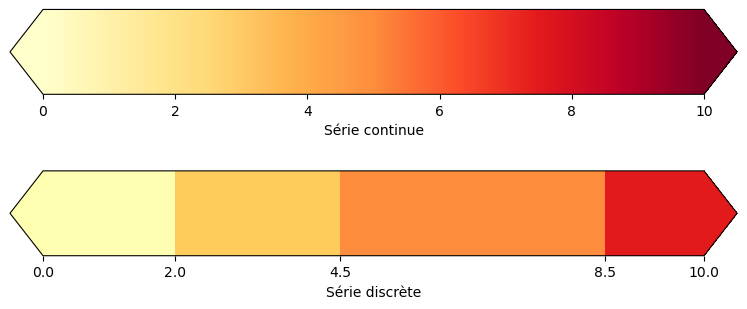

In [11]:
# f = fig_discrete() # Pas le temps de régler le problème de centrage. Récupération de l'image png

img = """<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAusAAAE1CAYAAABeJa7/AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAA9J0lEQVR4nO3dd1xWdf/H8fclICAoggvMnDkyM0XMLeZMvS1vyZU5Mxta2nJkpk1HWfdd5krTyl+5wFGOHKnlyAxxlN6aidpQSVHciFzf3x8lSVwCItd1jvJ6Ph48gnO+43Muj5dvTuc6X4cxxggAAACA7eSzugAAAAAArhHWAQAAAJsirAMAAAA2RVgHAAAAbIqwDgAAANgUYR0AAACwKcI6AAAAYFPeVheQXU6nU7///rvVZQAAAOAGV6JECfn4+FhdRrbcEGHd6XTq3/++R4sXf211KQAAALjB3So/7UtOUv78+a0uJUs3RFh/443++uGHn5WY+JWCgwv9uTFt4VXn3w0z3SZJf31vXO2/ol3aflfbrhznyrGdGbdltd/ltsxqvIY+clGHW47hWl/TrPabK5pl9WeSzeO67tc8m8fozOL1My72O7OY+/L3Thf7XbW7chxnFvvTxs7iz8nVMWR37CvbZjm2qz7KuD+rbelqczF2Zttc9b2ircluPdLfb0PZndtV36zmyWpuZ1bbTPp92eqTybZ0Y2bex+RkHFd/Ti77XHs9WY1jnBnPgbRtV3vrzXafjK+LufK1cvlPW8ZxXPdxMbaLetKN5aoeF9vkar4sjsHI4bqPqz9u48jY7h/7MvbJuN/lXzGTsY7082Sc2+lqbFdz68o+Lo7B1TEq435XNaY7TV187+JfO5ftshrnWvq4OD1tP3eKnJquX9TIt4Q2mxOyO9vfs75ixQqNGfORoqPH/R3UAQAAgBzwUT51Uph26JQ+++wzq8vJkq3D+sGDB/Xgg530/vtDVKNGZavLAQAAwE0gRPnVQaHq9WA3/fDDD1aXkynbhvULFy7ogQfa6IEHmqlnz39ZXQ4AAABuIpUUqLoKVuSd4UpKSrK6nKuybVgfOPBBORzSf//7nNWlAAAA4CbUREUULB/VLVwq/WflbMSWYX3GjJGKiVmj+fPHydfX/p/SBQAAwI0nnxyKUpgO64Ja5itudTku2S6sx8XFacCAcfr009dUunSo1eUAAADgJlZAXuqkklqn4/rqq6+sLicDW4X1xMRERUW10/DhfdSiRV2rywEAAEAecIv8dK+Kq12zlvr111+tLicd24R1p9Op7t3vU7Vq5TV0aC+rywEAAEAeUktBqqwA1bu1oi5evGh1OWlsE9Zfe+0J7dlzUB9//Iry5bNNWQAAAMgj2qi4UmXU0Nc+96/bIhUvX75c48Z9rJiYN1W4cEGrywEAAEAe9OeCSSW1U6c1a9Ysq8uRZIOwfuDAAT34YGdNmjRU1atXtLocAAAA5GHB8lGUwtSnew/t2LHD6nKsDeuXFz7q2rWVundva2UpAAAAgCSpogLUQCG6564InTx50tJaLA3rTz7ZVd7eXnr77aetLAMAAABIp7FCFCIf1Q0uJafTaVkdloX16dNHaNGidZo/fywLHwEAAMBW8smhDgrTUSWrpVcJC+uwQGxsrJ566i3Nnv2GSpWy7uABAACAq7m8YNLXOq5Vq1ZZUoPHw/rx48cVFdVOI0b0VdOmtT09PQAAAJBtJeWn1iqu+1vcq19++cXj83s0rKempuqhh+5TzZqVNWRIT09ODQAAAORIuIJURYGqV7qSkpOTPTq3R8P6q68+rp9//lUzZ46Sw+Hw5NQAAABAjrVWMTll1NDPs7dweyysL126VOPH/5+io8cpKCjQU9MCAAAA181H+dRZJfWjTuvjjz/22LweCevx8fF66KGumjLlBd15522emBIAAADIVYX/WjCpb89e2r59u0fmdHtYP3/+vKKiWqtbt3v14IP3uns6AAAAwG1uU4AaKkT31KitEydOuH0+t4Z1Y4z69+8sPz9fjR/PwkcAAAC48TVSiIoqv+qG3Or2BZPcGtanTRuhJUs2aN68Mcqf38edUwEAAAAe8eeCSaH6QxfVwqu4m+dyky1btmjQoPGaM+cN3XKLew8CAAAA8CR/eamTwvSNErVixQq3zeOWsH7s2DE98MB9GjWqn5o0iXDHFAAAAIClwuSntiqu9q1a6+DBg26ZI9fDempqqrp1a6eIiNv13HPdc3t4AAAAwDZqKEhVVVD1y1bWhQsXcn38XA/ro0Y9qgMHfteMGSNZ+AgAAAA3vdYqJklq6B+a62Pnalj/4osv9J//fKaYmDdVqBALHwEAAODm56186qSS2q0zmjlzZq6OnWth/eeff1b37g/qgw+G6447KuTWsAAAAIDt/blgUqj69e6juLi4XBs3V8L6uXPnFBXVRj17/ktdurTKjSEBAACAG0oFBaiRQtQ0vE6uLZh03WHdGKMnnuiswEB/vfnmwNyoCQAAALghNVSIiiu/6uTSgknXHdanTh2u5cs3ae7cMfLx8b7uggAAAIAbVT459G+F6pguqnkuLJh0XWH9u+++0zPPvKO5c0erZMli110MAAAAcKPzl5c6q6TWK1HLly+/rrFyHNb/+OMPPfDAfXr11cfUuHH4dRUBAAAA3ExC5at/qYQ6tG6rAwcO5HicHIX11NRUPfjgv1SnTjU9/XS3HE8OAAAA3KzuUiFVU0HVL1clxwsm5Sisv/TSI/r11wR9+OFLLHwEAAAAXEUrFVM+OdTAv0SO+l9zWF+8eLHee2+uYmLeVMGCATmaFAAAAMgL/lwwKUz/01lNnz79mvtfU1jft2+fevTopunTR+j228td82QAAABAXhMkHz2gMD3e9xHFxsZeU99sh/XLCx89/PD96tix+TUXCQAAAORV5VVAkSqi5hF1lZiYmO1+2Qrrxhg9+ugDCgoK1JgxT+a4SAAAACCvaqBghcpXdYpkf8GkbIX16Ohoffnlt5ozZzQLHwEAAAA54JBD7RWq40pRO6+wbPXJVlgvVaqUzp49r0OHjlxXgQAAAEBedlqpOqtUPfHFh9lqn62wXrduXb322uN64IEh+uOPE9dVIAAAAJAXJcupOfpddytIbdu2zVafbH/AdNCg8apfv7q6dHlBly5dynGRAAAAQF5jZLRYR1RQ3lqTkpDtftkO6w6HQ9Onx+jw4WMaMWJyjooEAAAA8qJvdVK/6II2JxyQt3f2PwN6Tc9ZDwwMVEzMUr3//jwtWrT2WmsEAAAA8pyDOqevdEwrvl2vYsWKXVPfa17BtEqVKvrwwxHq2XOUfvrp0LV2BwAAAPKM07qkeTqsliqmOnXqXHP/aw7rkvTAA0PUt297dejwvM6ePZ+TIQAAAICbWqqM5umwyquAPnfm7KmKOQrrkjRmzAwVKRKkfv1elzEmp8MAAAAAN6WV+kPJStWms0fkcDhyNEaOw7q3t7dmz16iNWu+1/vvz83pMAAAAMBN5wed1jad0oZ9u1SgQIEcj5PjsC5JoaGhmjdvoYYMeU+bNu24nqEAAACAm0KCkrVYRzV38UJVqFDhusa6rrAuSQ0aNNDo0QP0wANDdPTo8esdDgAAALhhXVCq5uh31VFhtWvX7rrHu+6wLklPPjlOkZHhLJgEAACAPMvIaJGOKkg+WnMp+wsfZSZXwrrD4dDUqfOVkHBCw4dPzI0hAQAAgBvKJp3Qb7qgzX8clJeXV66MmSthXfp7waTJk6MVE/NVbg0LAAAA2N4BndMaHdfKzRtUtGjRXBs318K6JFWuXFkzZnys3r1f1p49B3JzaAAAAMCWTv218FErFdPdd9+dq2PnaliXpA4dOuixx6IUFTVYZ86cy+3hAQAAANu4JKN5+l0VFaDFOVz4KDO5HtYl6fXXp6t48RA98shrLJgEAACAm9ZK/aEUGW08l/OFjzLjlrDu7e2tzz77Ql9/Haf33pvjjikAAAAAS+3UKW3XKW34eZf8/f3dMoe3W0aVVKJECc2fv0jNmzdVrVpV1KBBDXdNBQAAAHjUUSXrcx1VzBefq3z58m6bxy1X1i+rV6+exo59Uh07DtWRI8fcORUAAADgEReUqrn6XXUVrLZt27p1LreGdUnq33+s7rknQp07v6CUFBZMAgAAwI3LyGihjqqwfPRVLi18lBm3h/XLCyYlJiZp2LAJ7p4OAAAAcJsNOqHDuqDNxw7l2sJHmXF7WJekgIAAxcQs07RpCzV//ipPTAkAAADkqv06p3U6rlVbNqlIkSIemdMjYV2SKlasqI8+mqU+fV7V7t3xnpoWAAAAuG5JStF8HdbED6YqIiLCY/N6LKxL0v3336/+/TsqKmqwTp8+68mpAQAAgBz5c+Gjw6qsAPXt29ejc3s0rEvSq69+oLCwonr44VdZMAkAAAC2t0J/6JKMNpzL/RVKs+LxsH55waRNm3bqP//51NPTAwAAANm2Q6e0Q6e0cf9uty18lBm3LYqUmeLFi2v+/EVq2rSJIiKqqlGjmlaUAQAAAFzVkb8WPlq0dInKlStnSQ0ev7J+WZ06dfTmmwPVqdNQHT7MgkkAAACwj/N/LXxUX8Fq3bq1ZXVYFtYl6fHHR6tFizrq1GkoCyYBAADAFpwyWqgjCpGPvkr9w9JaLA3rDodDkyfP06lTZzV48H+tLAUAAACQ9OfCR0eVrM3Hf1G+fJbGZWvDuiQVKFBA0dFLNWPG55o7d6XV5QAAACAP269z+lrHtTp2s0JCQqwux/qwLkm33XabPvnkUz388KvatWu/1eUAAAAgD7q88NHk6dMUHh5udTmSbBLWJaldu3Z66qnO6tDheZ06dcbqcgAAAJCHXJJTc3VYVRSgPn36WF1OGtuEdUl65ZUPdOutJdSnzyssmAQAAACPWa4/5JTRhvNHrS4lHVuFdS8vL3322RJ9992PGj9+ltXlAAAAIA/YplP6Uae16cAe+fn5WV1OOpYsipSZokWLav78xbrnnkjVrl1VkZG1rC4JAAAAN6kjStYSHdXny5epTJkyVpeTga2urF9299136+23n1anTsP0228JVpcDAACAm9B5pWqOfldDhahVq1ZWl+OSLcO6JPXr97pat66vTp2G6uLFFKvLAQAAwE3EKaMFOqKiyq9Vqfa9OGzbsO5wODRx4hydPXtBzz/PgkkAAADIPeuVqARd1OZE6xc+yox9K9PfCyZ9/PESffbZcqvLAQAAwE1gn87qGyXqq62bFRwcbHU5mbLdB0z/qUKFCvrkk0/VtWtn+fn5Kji44J870p7s6Py7cdrjHo2LbVdud7U/u9uuMs7l700WfdJtu6L2DO2cGTal6+Py0ZZXjmcyfmtc7Hc1tqu+Wc3tauyr7c+0/9/7TBb7Mz2udH1dvObpB3cxThb7TYZv/t6f7o/dxf4rObOY+3J/p4v9rs61q51/rvZfLtR5lT6ZndPXO3dWf8dc/tVwcc66OpfSHY+rcVzVmMm2K7a7Om2u/ued2Ziu2rkY+8r+WR23q9fP1dtNunYuxnb1+rn6K3a11zltzMzrMS7ruXIeF+eny3au5r72elzPnXFb+r/SGbdl+c+Cyz4ZX0tzxXFn+58pl32u2ObqbSSredL6uBjHuOibxX4jh8s+l6V/O3JkrCftv67Hcfl2k3EaOY2L/un6ODL0/Xvsq8ztcp6M7XI0j4s5XP01cPlXPpvbrtye3W12mftax7kkoxgd1tQZH6pmzZqyO4e5QR5oPnr0AL355icKDi4qh8ORdQfc1IwxOnHihIKDgzkfwPmADDgncCXOB1zJGKOU/b/rpwsn5evra3U5WbphwvqpU6cUFBSkpKQkFSpUyOpyYDHOB1yJ8wH/xDmBK3E+4Eo32vlg63vWAQAAgLyMsA4AAADYFGEdAAAAsKkbJqz7+vpq5MiRN8QHAeB+nA+4EucD/olzAlfifMCVbrTz4Yb5gCkAAACQ19wwV9YBAACAvIawDgAAANgUYR0AAACwKcI6AAAAYFOEdQAAAMCmboiwPnHiRJUrV05+fn6qVauWvvnmG6tLgkVGjx6t2rVrq2DBgipevLjat2+vPXv2WF0WbGL06NFyOBwaNGiQ1aXAIr/99pseeughFSlSRAUKFFCNGjUUGxtrdVmwwKVLl/Tiiy+qXLly8vf3V/ny5fXKK6/I6XRaXRo85Ouvv1a7du1UsmRJORwOLVy4MN1+Y4xGjRqlkiVLyt/fX02aNNGPP/5oTbGZsH1YnzNnjgYNGqThw4crLi5OjRo1UuvWrXXo0CGrS4MF1q1bp/79++vbb7/VypUrdenSJbVs2VJnz561ujRYbMuWLZo6daqqV69udSmwyIkTJ9SgQQP5+Pho2bJl2rVrl8aPH6/ChQtbXRosMHbsWE2ePFkTJkzQ7t27NW7cOL355pt67733rC4NHnL27FndddddmjBhgsv948aN09tvv60JEyZoy5YtCg0NVYsWLXT69GkPV5o52z9nvU6dOgoPD9ekSZPStt1+++1q3769Ro8ebWFlsIM//vhDxYsX17p169S4cWOry4FFzpw5o/DwcE2cOFGvvfaaatSoof/85z9WlwUPGzp0qDZs2MD/fYUk6V//+pdKlCih6dOnp22LiopSgQIF9Mknn1hYGazgcDi0YMECtW/fXtKfV9VLliypQYMGaciQIZKk5ORklShRQmPHjtWjjz5qYbXp2frK+sWLFxUbG6uWLVum296yZUtt3LjRoqpgJ0lJSZKkkJAQiyuBlfr376+2bduqefPmVpcCCy1evFgRERHq2LGjihcvrpo1a+qDDz6wuixYpGHDhlq9erX27t0rSdq+fbvWr1+vNm3aWFwZ7CA+Pl5HjhxJlzF9fX0VGRlpu4zpbXUBmTl27JhSU1NVokSJdNtLlCihI0eOWFQV7MIYo2eeeUYNGzZUtWrVrC4HFpk9e7a2bt2qLVu2WF0KLLZ//35NmjRJzzzzjF544QV99913euqpp+Tr66sePXpYXR48bMiQIUpKSlKVKlXk5eWl1NRUvf766+ratavVpcEGLudIVxnz4MGDVpR0VbYO65c5HI50PxtjMmxD3jNgwADt2LFD69evt7oUWOSXX37RwIEDtWLFCvn5+VldDizmdDoVERGhN954Q5JUs2ZN/fjjj5o0aRJhPQ+aM2eOZs2apU8//VR33HGHtm3bpkGDBqlkyZLq2bOn1eXBJm6EjGnrsF60aFF5eXlluIqekJCQ4Tch5C1PPvmkFi9erK+//lqlSpWyuhxYJDY2VgkJCapVq1battTUVH399deaMGGCkpOT5eXlZWGF8KSwsDBVrVo13bbbb79d0dHRFlUEKz3//PMaOnSounTpIkm68847dfDgQY0ePZqwDoWGhkr68wp7WFhY2nY7Zkxb37OeP39+1apVSytXrky3feXKlapfv75FVcFKxhgNGDBAMTEx+uqrr1SuXDmrS4KFmjVrpp07d2rbtm1pXxEREerWrZu2bdtGUM9jGjRokOFRrnv37lWZMmUsqghWOnfunPLlSx9zvLy8eHQjJEnlypVTaGhouox58eJFrVu3znYZ09ZX1iXpmWeeUffu3RUREaF69epp6tSpOnTokB577DGrS4MF+vfvr08//VSLFi1SwYIF0/6vS1BQkPz9/S2uDp5WsGDBDJ9XCAgIUJEiRfgcQx709NNPq379+nrjjTfUqVMnfffdd5o6daqmTp1qdWmwQLt27fT666+rdOnSuuOOOxQXF6e3335bffr0sbo0eMiZM2e0b9++tJ/j4+O1bds2hYSEqHTp0ho0aJDeeOMNVaxYURUrVtQbb7yhAgUK6MEHH7SwahfMDeD99983ZcqUMfnz5zfh4eFm3bp1VpcEi0hy+TVjxgyrS4NNREZGmoEDB1pdBizy+eefm2rVqhlfX19TpUoVM3XqVKtLgkVOnTplBg4caEqXLm38/PxM+fLlzfDhw01ycrLVpcFD1qxZ4zIz9OzZ0xhjjNPpNCNHjjShoaHG19fXNG7c2OzcudPaol2w/XPWAQAAgLzK1vesAwAAAHkZYR0AAACwKcI6AAAAYFOEdQAAAMCmCOsAAACATRHWAQAAAJsirAPAdTh58qRefvllHT582OpSAAA3IcI6AFyHXr166fz58woLC8uybZMmTTRo0CD3F+UGvXr1Uvv27a0uAwDyHBZFAoArJCQkaMSIEVq2bJmOHj2q4OBg3XXXXRo1apTq1auXru348eMVFxenTz75RA6HI8uxExMT5ePjo4IFC7qr/Ot24MABlStXTnFxcapRo0ba9qSkJBljVLhwYctqA4C8yNvqAgDATqKiopSSkqKPPvpI5cuX19GjR7V69WolJiZmaPvss89ma8yUlBT5+PgoJCQkt8v1mKCgIKtLAIA8idtgAOAvJ0+e1Pr16zV27Fjdc889KlOmjO6++24NGzZMbdu2TWuXlJSkfv36qXjx4ipUqJCaNm2q7du3p+0fNWqUatSooQ8//FDly5eXr6+vjDEZboO5ePGiBg8erFtuuUUBAQGqU6eO1q5dm2WN/fr1U4kSJeTn56dq1arpiy++SNsfHR2tO+64Q76+vipbtqzGjx+frn/ZsmX1xhtvqE+fPipYsKBKly6tqVOnpu0vV66cJKlmzZpyOBxq0qSJpIy3wTRp0kRPPfWUBg8erJCQEIWGhmrUqFFp+w8cOCCHw6Ft27alq93hcKQ7xl27dqlNmzYKDAxUiRIl1L17dx07dizT1wAA8hLCOgD8JTAwUIGBgVq4cKGSk5NdtjHGqG3btjpy5IiWLl2q2NhYhYeHq1mzZumuvu/bt09z585VdHR0usB6pd69e2vDhg2aPXu2duzYoY4dO+ree+/VTz/95LK90+lU69attXHjRs2aNUu7du3SmDFj5OXlJUmKjY1Vp06d1KVLF+3cuVOjRo3SiBEjNHPmzHTjjB8/XhEREYqLi9MTTzyhxx9/XP/73/8kSd99950kadWqVTp8+LBiYmKu+np99NFHCggI0ObNmzVu3Di98sorWrly5VXb/9Phw4cVGRmpGjVq6Pvvv9fy5ct19OhRderUKdtjAMBNzwAA0syfP98EBwcbPz8/U79+fTNs2DCzffv2tP2rV682hQoVMhcuXEjXr0KFCmbKlCnGGGNGjhxpfHx8TEJCQro2kZGRZuDAgcYYY/bt22ccDof57bff0rVp1qyZGTZsmMvavvzyS5MvXz6zZ88el/sffPBB06JFi3Tbnn/+eVO1atW0n8uUKWMeeuihtJ+dTqcpXry4mTRpkjHGmPj4eCPJxMXFpRunZ8+e5v777093LA0bNkzXpnbt2mbIkCFXHefEiRNGklmzZo0xxpgRI0aYli1bphvjl19+MZKueowAkNdwZR0ArhAVFaXff/9dixcvVqtWrbR27VqFh4enXZ2OjY3VmTNnVKRIkbQr8YGBgYqPj9fPP/+cNk6ZMmVUrFixq86zdetWGWNUqVKldOOsW7cu3ThX2rZtm0qVKqVKlSq53L979241aNAg3bYGDRrop59+Umpqatq26tWrp33vcDgUGhqqhISELF+bf7pyHEkKCwu7pnFiY2O1Zs2adMdfpUoVSbrqawAAeQ0fMAWAf/Dz81OLFi3UokULvfTSS+rbt69GjhypXr16yel0KiwszOW95Vc+KSUgICDTOZxOp7y8vBQbG5t2G8tlgYGBLvv4+/tnOqYxJsNTaYyLB375+Pik+9nhcMjpdGY6tiuZjZMvX74M86ekpKRr73Q61a5dO40dOzbD2Nl5FCYA5AWEdQDIQtWqVbVw4UJJUnh4uI4cOSJvb2+VLVs2x2PWrFlTqampSkhIUKNGjbLVp3r16vr111+1d+9el1fXq1atqvXr16fbtnHjRlWqVCnDLwRXkz9/fklKdyU+Jy7/X4XDhw+rZs2akpTh3v3w8HBFR0erbNmy8vbmnyMAcIXbYADgL8ePH1fTpk01a9Ys7dixQ/Hx8Zo3b57GjRun+++/X5LUvHlz1atXT+3bt9eXX36pAwcOaOPGjXrxxRf1/fffZ3uuSpUqqVu3burRo4diYmIUHx+vLVu2aOzYsVq6dKnLPpGRkWrcuLGioqK0cuVKxcfHa9myZVq+fLmkPx8luXr1ar366qvau3evPvroI02YMEHPPfdctusqXry4/P390z7smZSUlO2+V/L391fdunU1ZswY7dq1S19//bVefPHFdG369++vxMREde3aVd99953279+vFStWqE+fPtf9ywIA3CwI6wDwl8DAQNWpU0fvvPOOGjdurGrVqmnEiBF65JFHNGHCBEl/3uqxdOlSNW7cWH369FGlSpXUpUsXHThwQCVKlLim+WbMmKEePXro2WefVeXKlXXfffdp8+bNuvXWW6/aJzo6WrVr11bXrl1VtWpVDR48OC3YhoeHa+7cuZo9e7aqVauml156Sa+88op69eqV7Zq8vb317rvvasqUKSpZsmTaLyk58eGHHyolJUUREREaOHCgXnvttXT7S5YsqQ0bNig1NVWtWrVStWrVNHDgQAUFBaXdRgMAeR0rmAIAAAA2xaULAAAAwKYI6wAAAIBNEdYBAAAAmyKsAwAAADZFWAcAAABsirAOAAAA2BRhHQAAALApwjoAAABgU4R1AAAAwKYI6wAAAIBNEdYBAAAAmyKsAwAAADZFWAcAAABsirAOAAAA2BRhHQAAALApwjoAAABgU4R1AAAAwKYI6wAAAIBNEdYBAAAAmyKsAwAAADZFWAcAAABsirAOAAAA2BRhHQAAALApwjoAAABgU4R1AAAAwKYI6wAAAIBNEdYBAAAAmyKsAwAAADZFWAcAAABsirAOAAAA2BRhHQAAALApwjoAAABgU4R1AAAAwKYI6wAAAIBNeVtdQHYtWPCCZsxYLamE1aUAAADgBhb5zXo9eyLR6jKyxWGMMVYXkZWtW7eqUaP6GjbsAQUHB1pdDmzCHNpqdQlAej8dt7oCADZ28qsbIxze7C4Yo7dPn9IXq1apadOmVpeTJdtfWU9MTFRUVGsNH95RL7zQyepyYCMm9qzVJQDpmHUHrC4BgI39vvmi1SXgL0GOfOrUooW2HTyoUqVKWV1Opmx9z7rT6VT37q10551lNXToA1aXAwAAgJtA14AANffz0/3lK+jiRXv/EmXrsP7aa921Z8+v+vjjQcqXz9alAgAA4AbyalCwUmTULzjE6lIyZdsEvHz5co0bF6OYmGEqXJj71AEAAJB7/B0OTQ4uooXnz2nWrFlWl3NVtgzr8fHx6tatkyZPflzVq5ezuhwAAADchEp7e+u94BA92qOHduzYYXU5LtkurF+4cEEPPNBCXbo00kMP3WN1OQAAALiJ3ePnr8cCC+q+8HCdPHnS6nIysF1YHzDgPvn4eOnttx+2uhQAAADkAQMDC6q8t486hYXJ6XRaXU46tgrr06Y9qcWLv9P8+UPl6+tjdTkAAADIA/I5HPpvcIj+l5KiFwoHW11OOrYJ67GxsRo48APNnv2cSpUqanU5AAAAyEOC8+XTlOAievfMaa1atcrqctLYIqwfP35cUVFt9NJLXdS06V1WlwMAAIA86M78+fVqUGF1btVKhw4dsrocSTYI66mpqerWrYVq1iyvwYM7WF0OAAAA8rDOBQJ0r5+/7rvtNiUnJ1tdjvVh/ZVXHtL+/Uc1c+ZAORwOq8sBAABAHvdyUGE5JfUNKWJ1KdaG9SVLlujttxcpOnqogoICrCwFAAAAkCT5ORyaGlxEX5w/r48++sjSWiwL6/v379dDD3XWlClP6M47y1pVBgAAAJBBKW9vTQgO0RO9e2vbtm2W1WFJWD9//ryiopqre/d79OCDkVaUAAAAAGQq0s9PTwQW1P0RETpx4oQlNXg8rBtj9MQT7eTv76u33urt6ekBAACAbHsysKAqefuoY1hJSxZM8nhY/+CDAVq69HvNmzdE+fOz8BEAAADsK5/DoXeCQ/TTpRQNsWDBJI+G9S1btujpp6drzpzBuuUW6z9dCwAAAGSlcL58mhpSRBPPnNaKFSs8OrfHwvqxY8cUFdVGo0Z1VZMmd3pqWgAAAOC63eGTX68FFVbne1vr4MGDHpvXI2E9NTVVDz7YQrVrV9Rzz/3bE1MCAAAAuapjgQD9y99f91WsqAsXLnhkTo+E9VGjHtShQ39oxgwWPgIAAMCNa1RQYeWT1LdIUY/M5/aw/vnnn+s///lc0dHDVKhQAXdPBwAAALiNr8OhycFFtPTCec2YMcPt87k1rO/bt089enTVBx/01x13lHbnVAAAAIBH3OLtrfeDQ9T/4Ye1detWt87ltrB+7tw5RUW1UM+eTdWlS2N3TQMAAAB4XCNfPz0ZWFDt775biYmJbpvHLWHdGKPHH/+XChb015tvsvARAAAAbj79Awuqio+POpa8xW0LJrklrE+Z0l9ffhmnefOGyMfH2x1TAAAAAJbK53DoncIh+vlSiga7acGkXA/rmzdv1rPPfqi5cwcrLCwkt4cHAAAAbCMoXz59EFJEk86c1vLly3N9/FwN63/88YceeOBfevXVbmrcuFpuDg0AAADY0u0++TU6qLC6tmmr+Pj4XB0718J6amqqunZtobp1K+npp+/PrWEBAAAA2+tQIED3+fvr/sqVc3XBpFwL6yNGdNFvvx3Xhx8+xcJHAAAAyHNGBhWWjxzqXaRIro2ZK2F90aJFmjBhiWJihqlgQRY+AgAAQN6T3+HQ5JAQrbxwQdOmTcuVMa87rP/000/q2bObpk9/Urfffmtu1AQAAADckMK8/lww6al+/RQbG3vd411XWD979qyiolro4Yebq2PHhtddDAAAAHCja+Drp0GBBdW+Th0dP378usbKcVg3xujRR9uqcOEAjRnT87qKAAAAAG4mjwcW1B0+Poq65RalpqbmeJwch/WJEx/XV1/t1Ny5LHwEAAAAXMnhcOjtwiE6dClVz13Hgkk5CuubNm3S4MEzNXfuYIWGume1JgAAAOBGVihfPk0NKaIPzp7RkiVLcjTGNYf1hIQEdezYTq+//pAaNqyao0kBAACAvKCKj49GBwWrW7t22r9//zX3v6awfunSJXXp0lwNG1bVwIH3XfNkAAAAQF7z7wIF/lw0qXIVnT9//pr6XlNYf/HFLjp69KSmTRvAwkcAAABANr1YKEh+Dod6FikqY0y2+2U7rC9YsECTJi1TdPQwBQb656hIAAAAIC/K73BoUkgRrUm+oHHBIdnul62wvnfvXvXq9ZA+/PApValSKsdFAgAAAHlVmJeXJgaH6OVTSdqyZUu2+mQrrH/zzTcqWNBf994bfl0FAgAAAHlZRH5f3erlpfnNmmerfbbCes+ePXXbbWHq1+/9a7rHBgAAAMDf3jiVJC85NPLI4Wy1z1ZY9/b21uzZK7VmzU69/37OnhEJAAAA5GWfnz+neefO6vP/7VaBAgWy1SfbHzANDQ3VvHmLNWTIR9q4cXeOiwQAAADymr0pKRp88oQ+WbRIFSpUyHa/a3p0Y4MGDTR6dA917DhWR4+euOYiAQAAgLzmtNOpfieOq3dAoNq1a3dNfa95BdMnn5yiyMhq6tLlLV26lHqt3QEAAIA8wxij506eUEkvL71z8tovdl9zWHc4HPrgg6X6448kDR/+yTVPCAAAAOQVU8+e0faUi4r59Vd5eXldc/9rDuuSFBAQoJiYlZo8ebliYjbmZAgAAADgprYpOVnjT5/Sgk2bVLRo0RyNkaOwLkmVKlXSzJmz1Lv3u9qz59ecDgMAAADcdA6npuqJE8c1slCQateuneNxchzWJenf//63HnvsXnXoMFpnzpy/nqEAAACAm8JFY/RE4nHd4+unwScSr2us6wrrkvT663NUokRh9e07gQWTAAAAkOe9fipJ543RR8ePyeFwXNdY1x3W/1wwaZXWr9+ld9/9/HqHAwAAAG5YC8+dU/S5s1q853/y9/e/7vGuO6xLUvHixTVv3ud64YVPtGHDrtwYEgAAALih/C8lRUOTTuj/Pv9c5cuXz5UxcyWsS1K9evU0blwvdew4TkeOsGASAAAA8o5TTqceTTyuRwIC1bZt21wbN9fCuiQ98cQkNW16pzp3HqeUlEu5OTQAAABgS8YYPXsyUbd6e+mtHCx8lJlcDesOh0NTpizRiRNnNGzYx7k5NAAAAGBLk8+c0Q8pKYr+7bccLXyUmVwN69KfCyZFR6/UtGkrNW/e+tweHgAAALCNDckX9M6ZU1q4ebOKFCmS6+PneliXpIoVK+qjj/5PDz/8nnbv/sUdUwAAAACWOpx6Sf1PJOrdqVNVq1Ytt8zhlrAuSffff78GDGirqKgxOn36nLumAQAAADzuojF6LDFRLfz81LdvX7fN47awLkmvvjpbJUuG6OGH32PBJAAAANw0Xkk6qRQZzTh+3K3zuDWse3l56bPPVmrTpj36z38Wu3MqAAAAwCNizp3VwvPntGjPHvn5+bl1Lm+3ji6pWLFimj//CzVtGqlatSqoceNq7p4SAAAAcIvdKRc1LOmk5i9ZonLlyrl9PrdeWb+sTp06euut3urc+U0dPpzoiSkBAACAXJXkdKpfYqIeCyyo1q1be2ROj4R1SXrssYlq2bKGOnViwSQAAADcWJzG6JmTiSrv7a03c3nho8x4LKw7HA5NmvSFTp06p8GDZ3pqWgAAAOC6TTxzWrtTUjTv99+UL5/HIrTnwrokFShQQDExqzRz5mrNmfONJ6cGAAAAcuSb5At698xpLfzuO4WEhHh0bo+GdUmqUKGCPv74M/XtO0G7dh3y9PQAAABAtv2eekkDTiTq/enTFR4e7vH5PR7WJaldu3YaOLCdOnQYrVOnWDAJAAAA9pNsjB5NPK57/fzVu3dvS2qwJKxL0ssvf6rSpYupT593WTAJAAAAtvNy0kk5JU0/fsyyGiwL615eXvr005XasuUnjR+/0KoyAAAAgAzmnzurLy6c1+KffnL7wkeZcfuiSJkpWrSo5s9foiZNGiki4jY1aXKnleUAAAAA+jHlooYnndSC5ctVpkwZS2ux7Mr6ZbVr19Y77zyszp3H6bffjltdDgAAAPKwk06n+iUe1xOBBdWyZUury7E+rEvSI49MUJs2EerUaawuXkyxuhwAAADkQU5j9PSJRFXy9tFYDy58lBlbhHWHw6GJEz/XuXPJev75mVaXAwAAgDxowpnT2nspRXMP/+7RhY8yY48qJPn7+ys6epU++WSNPvtsndXlAAAAIA9Zd+GC3j9zWou+/17BwcFWl5PGNmFdksqXL69PPpmtfv0m6ocfDlpdDgAAAPKAXy9d0pMnEzVxxgzVqFHD6nLSsVVYl6S2bdvqmWfuV4cOo5WUdNbqcgAAAHATu2CMHj1xXG39/NWzZ0+ry8nAdmFdkl56aZbKly+h3r3/y4JJAAAAcJtRSSeVT9K0RHs+ldCWYd3Ly0v/938rtXXrfr35ZozV5QAAAOAmNOfcWS27cF6L9u2Tr6+v1eW4ZOmiSJkpUqSI5s9fosjIhoqIuE1Nm95ldUkAAAC4SfyQclEvJZ3UohUrVLp0aavLuSpbXlm/LCIiQv/97yPq0uUt/frrMavLAQAAwE3ghNOpRxOPa0BgQTVv3tzqcjJl67AuSX37vqf77rtbHTuyYBIAAACuj9MYDTqRqMo+Phptk4WPMuMwN8AnOC9cuKAGDarp+PHTCgiw5/1EsMCFU1ZXAKR3lgsKAK7u0vGLVpcA/fn0F4ekbceOqXDhwlaXkyXb3rN+JT8/Py1Zsl7PPfecunTpIh8fH6tLgsVSUlI0e/ZszgfYBuckgMzwHmEfKSkpWrt2rfz9/a0uJVtuiCvrknTq1CkFBQUpKSlJhQoVsrocWIzzAXbDOQkgM7xH2MeN9mdh+3vWAQAAgLyKsA4AAADYFGEdAAAAsKkbJqz7+vpq5MiRtl1dCp7F+QC74ZwEkBneI+zjRvuzuGE+YAoAAADkNTfMlXUAAAAgryGsAwAAADZFWAcAAABsirAOAAAA2JStwvrEiRNVrlw5+fn5qVatWvrmm28ybb9u3TrVqlVLfn5+Kl++vCZPnuyhSuFOo0ePVu3atVWwYEEVL15c7du31549e7Lsx/kATxk9erQcDocGDRp01TZr166Vw+HI8PW///3Pc4UC8IhLly7pxRdfVLly5eTv76/y5cvrlVdekdPpvGof3iNyx9dff6127dqpZMmScjgcWrhwYbr9xhiNGjVKJUuWlL+/v5o0aaIff/wxy3Gjo6NVtWpV+fr6qmrVqlqwYIGbjiBrtgnrc+bM0aBBgzR8+HDFxcWpUaNGat26tQ4dOuSyfXx8vNq0aaNGjRopLi5OL7zwgp566ilFR0d7uHLktnXr1ql///769ttvtXLlSl26dEktW7bU2bNnr9qH8wGesmXLFk2dOlXVq1fPVvs9e/bo8OHDaV8VK1Z0c4UAPG3s2LGaPHmyJkyYoN27d2vcuHF688039d5772XZl/eI63P27FndddddmjBhgsv948aN09tvv60JEyZoy5YtCg0NVYsWLXT69Omrjrlp0yZ17txZ3bt31/bt29W9e3d16tRJmzdvdtdhZM7YxN13320ee+yxdNuqVKlihg4d6rL94MGDTZUqVdJte/TRR03dunXdViOskZCQYCSZdevWXbUN5wM84fTp06ZixYpm5cqVJjIy0gwcOPCqbdesWWMkmRMnTnisPgDWaNu2renTp0+6bR06dDAPPfTQVfvwHpH7JJkFCxak/ex0Ok1oaKgZM2ZM2rYLFy6YoKAgM3ny5KuO06lTJ3Pvvfem29aqVSvTpUuXXK85O2xxZf3ixYuKjY1Vy5Yt021v2bKlNm7c6LLPpk2bMrRv1aqVvv/+e6WkpLitVnheUlKSJCkkJOSqbTgf4An9+/dX27Zt1bx582z3qVmzpsLCwtSsWTOtWbPGjdUBsErDhg21evVq7d27V5K0fft2rV+/Xm3atMmyL+8R7hMfH68jR46kywe+vr6KjIy8ar6Urp4pMuvjTt6WzPoPx44dU2pqqkqUKJFue4kSJXTkyBGXfY4cOeKy/aVLl3Ts2DGFhYW5rV54jjFGzzzzjBo2bKhq1apdtR3nA9xt9uzZ2rp1q7Zs2ZKt9mFhYZo6dapq1aql5ORkffLJJ2rWrJnWrl2rxo0bu7laAJ40ZMgQJSUlqUqVKvLy8lJqaqpef/11de3a9ap9eI9wv8sZ0lU+OHjwYKb9riWTupstwvplDocj3c/GmAzbsmrvajtuXAMGDNCOHTu0fv36LNtyPsBdfvnlFw0cOFArVqyQn59ftvpUrlxZlStXTvu5Xr16+uWXX/TWW2/xDzFwk5kzZ45mzZqlTz/9VHfccYe2bdumQYMGqWTJkurZs6fLPrxHeM615suc9nEXW9wGU7RoUXl5eWX4jSUhISHDbzaXhYaGumzv7e2tIkWKuK1WeM6TTz6pxYsXa82aNSpVqlSmbTkf4E6xsbFKSEhQrVq15O3tLW9vb61bt07vvvuuvL29lZqamq1x6tatq59++snN1QLwtOeff15Dhw5Vly5ddOedd6p79+56+umnNXr06Gsah/eI3BUaGipJ15QvL/e71j7uZIuwnj9/ftWqVUsrV65Mt33lypWqX7++yz716tXL0H7FihWKiIiQj4+P22qF+xljNGDAAMXExOirr75SuXLlsuzD+QB3atasmXbu3Klt27alfUVERKhbt27atm2bvLy8sjVOXFwct2QBN6Fz584pX770kcrLyyvTRze6wntE7ipXrpxCQ0PT5YOLFy9q3bp1V82X0tUzRWZ93MqSj7W6MHv2bOPj42OmT59udu3aZQYNGmQCAgLMgQMHjDHGDB061HTv3j2t/f79+02BAgXM008/bXbt2mWmT59ufHx8zPz58606BOSSxx9/3AQFBZm1a9eaw4cPp32dO3curQ3nA6z2z6fB/POcfOedd8yCBQvM3r17zQ8//GCGDh1qJJno6GgLqgXgTj179jS33HKL+eKLL0x8fLyJiYkxRYsWNYMHD05rw3uEe5w+fdrExcWZuLg4I8m8/fbbJi4uzhw8eNAYY8yYMWNMUFCQiYmJMTt37jRdu3Y1YWFh5tSpU2ljdO/ePd3TBzds2GC8vLzMmDFjzO7du82YMWOMt7e3+fbbbz1+fMYYY5uwbowx77//vilTpozJnz+/CQ8PT/eovp49e5rIyMh07deuXWtq1qxp8ufPb8qWLWsmTZrk4YrhDpJcfs2YMSOtDecDrPbPsP7Pc3Ls2LGmQoUKxs/PzwQHB5uGDRuaJUuWeL5QAG536tQpM3DgQFO6dGnj5+dnypcvb4YPH26Sk5PT2vAe4R6XH4H5z6+ePXsaY/58fOPIkSNNaGio8fX1NY0bNzY7d+5MN0ZkZGRa+8vmzZtnKleubHx8fEyVKlUs/SXKYcxfn8IDAAAAYCu2uGcdAAAAQEaEdQAAAMCmCOsAAACATRHWAQAAAJsirAMAAAA2RVgHAAAAbIqwDgAAANgUYR0AcsHJkyf18ssv6/Dhw1aX4jEpKSkaO3asdu3aZXUpAHDTIqwDQC7o1auXzp8/r7CwsCzbNmnSRIMGDcr1GhwOhxYuXChJOnDggBwOh7Zt25br81zm4+Oj2267TVFRUTp9+rTb5gGAvIywDgAuJCQk6NFHH1Xp0qXl6+ur0NBQtWrVSps2bcrQdvz48QoMDNTo0aOzNXZMTIxeffXV3C45nVtvvVWHDx9WtWrV3DpPVFSUHn/8cfXt2zfDvlGjRqlGjRpunR8AbnbeVhcAAHYUFRWllJQUffTRRypfvryOHj2q1atXKzExMUPbZ599NltjpqSkyMfHRyEhIbldbgZeXl4KDQ11y9iXj+Oyp556Sk899ZRb5gKAvI4r6wDwDydPntT69es1duxY3XPPPSpTpozuvvtuDRs2TG3btk1rl5SUpH79+ql48eIqVKiQmjZtqu3bt6ftv3xl+cMPP1T58uXl6+srY0yG22AuXryowYMH65ZbblFAQIDq1KmjtWvXZlrjTz/9pMaNG8vPz09Vq1bVypUr0+3/520wJ06cULdu3VSsWDH5+/urYsWKmjFjRlr7X3/9VV26dFFISIgCAgIUERGhzZs3Z3oc/zz+Jk2aKDY2VpI0c+ZMvfzyy9q+fbscDoccDodmzpyZrdcNAPA3rqwDwD8EBgYqMDBQCxcuVN26deXr65uhjTFGbdu2VUhIiJYuXaqgoCBNmTJFzZo10969e9Ounu/bt09z585VdHS0vLy8XM7Xu3dvHThwQLNnz1bJkiW1YMEC3Xvvvdq5c6cqVqyYob3T6VSHDh1UtGhRffvttzp16lSW98CPGDFCu3bt0rJly1S0aFHt27dP58+flySdOXNGkZGRuuWWW7R48WKFhoZq69atcjqdaf1dHUfbtm1VrFgxLVu2TIUKFdK0adPUvHlz7dmzR507d9YPP/yg5cuXa9WqVZKkoKCgbL9uAIC/GABABvPnzzfBwcHGz8/P1K9f3wwbNsxs3749bf/q1atNoUKFzIULF9L1q1ChgpkyZYoxxpiRI0caHx8fk5CQkK5NZGSkGThwoDHGmH379hmHw2F+++23dG2aNWtmhg0b5rK2L7/80nh5eZlffvklbduyZcuMJLNgwQJjjDHx8fFGkomLizPGGNOuXTvTu3dvl+NNmTLFFCxY0Bw/ftzlflfHsXr1alO4cGGTnJycrm2lSpXM+++/n9bvrrvuSrc/O68bAOBvXFkHABeioqLUtm1bffPNN9q0aZOWL1+ucePGadq0aerVq5diY2N15swZFSlSJF2/8+fP6+eff077uUyZMipWrNhV59m6dauMMapUqVK67cnJyRnGvmz37t0qXbq0SpUqlbatXr16mR7P448/rqioKG3dulUtW7ZU+/btVb9+fUnStm3bVLNmzUyvav/zOGJjY3Xy5EmX/9dh//79Vx0nu68bAOBPhHUAuAo/Pz+1aNFCLVq00EsvvaS+fftq5MiR6tWrl5xOp8LCwlzeW164cOG07wMCAjKdw+l0ysvLS7GxsRlukwkMDHTZxxiTYZvD4ch0ntatW+vgwYNasmSJVq1apWbNmql///5666235O/vn2lfKeNxOJ1OlS5dWgcPHsyy7z/7Zed1AwD8ibAOANlUtWrVtOeYh4eH68iRI/L29lbZsmVzPGbNmjWVmpqqhIQENWrUKNt1HDp0SL///rtKliwpSS4fKflPxYoVU69evdSrVy81atRIzz//vN566y1Vr15d06ZNU2JiYrbvGQ8PD9evv/6qvXv3Zvi/Apflz59fqampGfrlxusGAHkFT4MBgH84fvy4mjZtqlmzZmnHjh2Kj4/XvHnzNG7cON1///2SpObNm6tevXpq3769vvzySx04cEAbN27Uiy++qO+//z7bc1WqVEndunVTjx49FBMTo/j4eG3ZskVjx47V0qVLXfZp3ry5KleurB49emj79u365ptvNHz48Ezneemll7Ro0SLt27dPP/74o7744gvdfvvtkqSuXbsqNDRU7du314YNG7R//35FR0dn+gtA8+bNVb9+fXXo0EHLli1TfHy8Nm7cqMGDB6c9RaZs2bKKj4/Xtm3bdOzYMSUnJ+fa6wYAeQVhHQD+ITAwUHXq1NE777yjxo0bq1q1ahoxYoQeeeQRTZgwQdKft50sXbpUjRs3Vp8+fVSpUiV16dJFBw4cUIkSJa5pvhkzZqhHjx569tlnVblyZd13333avHmzbr31Vpft8+XLpwULFig5OVl33323+vbtq9dffz3TOfLnz69hw4apevXqaty4sby8vDR79uy0fStWrFDx4sXVpk0b3XnnnRozZsxVn15z5fE3bdpUffv2VeXKldWlS5d0V/ujoqJ077336p577lGxYsX02Wef5errBgB5gcO4uvkRAAAAgOW4sg4AAADYFGEdAAAAsCnCOgAAAGBThHUAAADApgjrAAAAgE0R1gEAAACbIqwDAAAANkVYBwAAAGyKsA4AAADYFGEdAAAAsCnCOgAAAGBT/w9z9CaoiPhm8AAAAABJRU5ErkJggg==">"""

content = f"""
<h2> <i class="fa-solid fa-chart-column" style="color: #94bc14"></i> La discrétisation </h2> 
<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>En cartographie et en statistique, il est parfois nécessaire de simplifier l'information à transmettre.</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Notamment lorsque la quantité d'information à représenter est très importante.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>La réduction de l'information au sein de classes est appelée la discrétisation.</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
      {img}
      </div>
      </div>
    </div>
  </div>
<blockquote class="fs-3" style="width: 1200px;">
Réduire l'information en transformant des données continues ou déjà discrètes en classes d'intervalles distinctes, couvrant l'ensemble de la série statistique initiale
</blockquote>
</div>

"""
HTML(content)

<hr>

<h2> <i class="fa-solid fa-circle-question" style="color: #94bc14"></i> Pourquoi discrétiser ? </h2>  

In [12]:
selected_discret = "FisherJenks"
k = 5
selected_cmap = "Blues"
data_d = discretisation(
    data.query("CS1_6=='1'").sort_values("IND"), selected_discret, k, selected_cmap
)

In [13]:
data_c = data.query("CS1_6=='1'").sort_values("IND").copy()

cmap = cm.get_cmap("Blues", len(data_c))
cols = []
for i in range(cmap.N):
    rgba = cmap(i)
    cols.append(colors.rgb2hex(rgba))

data_c["colors"] = cols
data_c["IND_CLASS"] = data_c["IND"]

In [14]:
map_d = map_altair(
    fr=data_d,
    ind="IND",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title="Répartition des agriculteurs en 2018",
    legend_title="Part des agriculteurs sur l'ensemble des CSP(%)",
)

map_c = map_altair(
    fr=data_c,
    ind="IND",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title="Répartition des agriculteurs en 2018",
    legend_title="Part des agriculteurs sur l'ensemble des CSP(%)",
)

In [15]:
alt.hconcat(map_c, map_d).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(color="independent")

alt.HConcatChart(...)

L'œil  humain n'est pas en mesure d'associer un chiffre précis à la variable visuelle valeur (à l'inverse de la taille+forme). Seule la notion d'ordre est "innée" avec le rapport de noir et blanc sur une surface donnée. 

Pour avoir associée à un niveau de gris un chiffre, il faut donc discrétiser

<hr>

<h2> <i class="fa-solid fa-scale-unbalanced" style="color: #94bc14"></i> Minimiser la variance intra-classe, maximiser la variance inter-classe (1)</h2>


In [16]:
df_logo = pd.DataFrame(
    [
        {"x_ord": 0, "x_un": 0, "y_ord": 1, "y_un": 1, "animal": "cattle"},
        {"x_ord": 6, "x_un": 1, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 1, "x_un": 2, "y_ord": 1, "y_un": 1, "animal": "cattle"},
        {"x_ord": 15, "x_un": 3, "y_ord": 3, "y_un": 1, "animal": "pigs"},
        {"x_ord": 16, "x_un": 4, "y_ord": 3, "y_un": 1, "animal": "pigs"},
        {"x_ord": 7, "x_un": 5, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 8, "x_un": 6, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 17, "x_un": 7, "y_ord": 3, "y_un": 1, "animal": "pigs"},
        {"x_ord": 9, "x_un": 8, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 10, "x_un": 9, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 18, "x_un": 10, "y_ord": 3, "y_un": 1, "animal": "pigs"},
        {"x_ord": 11, "x_un": 11, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 2, "x_un": 12, "y_ord": 1, "y_un": 1, "animal": "cattle"},
        {"x_ord": 12, "x_un": 13, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 3, "x_un": 14, "y_ord": 1, "y_un": 1, "animal": "cattle"},
    ]
)

domains = ["cattle", "pigs", "sheep"]

shape_scale = alt.Scale(
    domain=domains,
    range=[
        "M4 -2c0 0 0.9 -0.7 1.1 -0.8c0.1 -0.1 -0.1 0.5 -0.3 0.7c-0.2 0.2 1.1 1.1 1.1 1.2c0 0.2 -0.2 0.8 -0.4 0.7c-0.1 0 -0.8 -0.3 -1.3 -0.2c-0.5 0.1 -1.3 1.6 -1.5 2c-0.3 0.4 -0.6 0.4 -0.6 0.4c0 0.1 0.3 1.7 0.4 1.8c0.1 0.1 -0.4 0.1 -0.5 0c0 0 -0.6 -1.9 -0.6 -1.9c-0.1 0 -0.3 -0.1 -0.3 -0.1c0 0.1 -0.5 1.4 -0.4 1.6c0.1 0.2 0.1 0.3 0.1 0.3c0 0 -0.4 0 -0.4 0c0 0 -0.2 -0.1 -0.1 -0.3c0 -0.2 0.3 -1.7 0.3 -1.7c0 0 -2.8 -0.9 -2.9 -0.8c-0.2 0.1 -0.4 0.6 -0.4 1c0 0.4 0.5 1.9 0.5 1.9l-0.5 0l-0.6 -2l0 -0.6c0 0 -1 0.8 -1 1c0 0.2 -0.2 1.3 -0.2 1.3c0 0 0.3 0.3 0.2 0.3c0 0 -0.5 0 -0.5 0c0 0 -0.2 -0.2 -0.1 -0.4c0 -0.1 0.2 -1.6 0.2 -1.6c0 0 0.5 -0.4 0.5 -0.5c0 -0.1 0 -2.7 -0.2 -2.7c-0.1 0 -0.4 2 -0.4 2c0 0 0 0.2 -0.2 0.5c-0.1 0.4 -0.2 1.1 -0.2 1.1c0 0 -0.2 -0.1 -0.2 -0.2c0 -0.1 -0.1 -0.7 0 -0.7c0.1 -0.1 0.3 -0.8 0.4 -1.4c0 -0.6 0.2 -1.3 0.4 -1.5c0.1 -0.2 0.6 -0.4 0.6 -0.4z",
        "M1.2 -2c0 0 0.7 0 1.2 0.5c0.5 0.5 0.4 0.6 0.5 0.6c0.1 0 0.7 0 0.8 0.1c0.1 0 0.2 0.2 0.2 0.2c0 0 -0.6 0.2 -0.6 0.3c0 0.1 0.4 0.9 0.6 0.9c0.1 0 0.6 0 0.6 0.1c0 0.1 0 0.7 -0.1 0.7c-0.1 0 -1.2 0.4 -1.5 0.5c-0.3 0.1 -1.1 0.5 -1.1 0.7c-0.1 0.2 0.4 1.2 0.4 1.2l-0.4 0c0 0 -0.4 -0.8 -0.4 -0.9c0 -0.1 -0.1 -0.3 -0.1 -0.3l-0.2 0l-0.5 1.3l-0.4 0c0 0 -0.1 -0.4 0 -0.6c0.1 -0.1 0.3 -0.6 0.3 -0.7c0 0 -0.8 0 -1.5 -0.1c-0.7 -0.1 -1.2 -0.3 -1.2 -0.2c0 0.1 -0.4 0.6 -0.5 0.6c0 0 0.3 0.9 0.3 0.9l-0.4 0c0 0 -0.4 -0.5 -0.4 -0.6c0 -0.1 -0.2 -0.6 -0.2 -0.5c0 0 -0.4 0.4 -0.6 0.4c-0.2 0.1 -0.4 0.1 -0.4 0.1c0 0 -0.1 0.6 -0.1 0.6l-0.5 0l0 -1c0 0 0.5 -0.4 0.5 -0.5c0 -0.1 -0.7 -1.2 -0.6 -1.4c0.1 -0.1 0.1 -1.1 0.1 -1.1c0 0 -0.2 0.1 -0.2 0.1c0 0 0 0.9 0 1c0 0.1 -0.2 0.3 -0.3 0.3c-0.1 0 0 -0.5 0 -0.9c0 -0.4 0 -0.4 0.2 -0.6c0.2 -0.2 0.6 -0.3 0.8 -0.8c0.3 -0.5 1 -0.6 1 -0.6z",
        "M-4.1 -0.5c0.2 0 0.2 0.2 0.5 0.2c0.3 0 0.3 -0.2 0.5 -0.2c0.2 0 0.2 0.2 0.4 0.2c0.2 0 0.2 -0.2 0.5 -0.2c0.2 0 0.2 0.2 0.4 0.2c0.2 0 0.2 -0.2 0.4 -0.2c0.1 0 0.2 0.2 0.4 0.1c0.2 0 0.2 -0.2 0.4 -0.3c0.1 0 0.1 -0.1 0.4 0c0.3 0 0.3 -0.4 0.6 -0.4c0.3 0 0.6 -0.3 0.7 -0.2c0.1 0.1 1.4 1 1.3 1.4c-0.1 0.4 -0.3 0.3 -0.4 0.3c-0.1 0 -0.5 -0.4 -0.7 -0.2c-0.3 0.2 -0.1 0.4 -0.2 0.6c-0.1 0.1 -0.2 0.2 -0.3 0.4c0 0.2 0.1 0.3 0 0.5c-0.1 0.2 -0.3 0.2 -0.3 0.5c0 0.3 -0.2 0.3 -0.3 0.6c-0.1 0.2 0 0.3 -0.1 0.5c-0.1 0.2 -0.1 0.2 -0.2 0.3c-0.1 0.1 0.3 1.1 0.3 1.1l-0.3 0c0 0 -0.3 -0.9 -0.3 -1c0 -0.1 -0.1 -0.2 -0.3 -0.2c-0.2 0 -0.3 0.1 -0.4 0.4c0 0.3 -0.2 0.8 -0.2 0.8l-0.3 0l0.3 -1c0 0 0.1 -0.6 -0.2 -0.5c-0.3 0.1 -0.2 -0.1 -0.4 -0.1c-0.2 -0.1 -0.3 0.1 -0.4 0c-0.2 -0.1 -0.3 0.1 -0.5 0c-0.2 -0.1 -0.1 0 -0.3 0.3c-0.2 0.3 -0.4 0.3 -0.4 0.3l0.2 1.1l-0.3 0l-0.2 -1.1c0 0 -0.4 -0.6 -0.5 -0.4c-0.1 0.3 -0.1 0.4 -0.3 0.4c-0.1 -0.1 -0.2 1.1 -0.2 1.1l-0.3 0l0.2 -1.1c0 0 -0.3 -0.1 -0.3 -0.5c0 -0.3 0.1 -0.5 0.1 -0.7c0.1 -0.2 -0.1 -1 -0.2 -1.1c-0.1 -0.2 -0.2 -0.8 -0.2 -0.8c0 0 -0.1 -0.5 0.4 -0.8z",
    ],
)

color_scale = alt.Scale(domain=domains, range=["#94bc14", "#bc4749", "rgb(93,93,93)"])

var_chart_unord = (
    alt.Chart(df_logo)
    .mark_point(filled=True, opacity=1, size=100)
    .encode(
        alt.X("x_un:O", axis=None),
        alt.Y("y_un:O", axis=None),
        alt.Shape("animal:N", legend=None, scale=shape_scale),
        alt.Color("animal:N", legend=None, scale=color_scale),
    )
    .properties(width=1200, height=140)
)

var_chart_ord = (
    alt.Chart(df_logo)
    .mark_point(filled=True, opacity=1, size=100)
    .encode(
        alt.X("x_ord:O", axis=None),
        alt.Y("y_ord:O", axis=None),
        alt.Shape("animal:N", legend=None, scale=shape_scale),
        alt.Color("animal:N", legend=None, scale=color_scale),
    )
    .properties(width=1200, height=500)
)

alt.vconcat(var_chart_unord, var_chart_ord)

alt.VConcatChart(...)

<h2> <i class="fa-solid fa-scale-unbalanced" style="color: #94bc14"></i> Minimiser la variance intra-classe, maximiser la variance inter-classe (2)</h2>


In [17]:
df_num = pd.DataFrame(
    [
        {"x_ord": 5.1, "x_un": 0, "y": 1, "col_1": "A", "col_2": "A"},
        {"x_ord": 6.0, "x_un": 1, "y": 1, "col_1": "B", "col_2": "A"},
        {"x_ord": 7.0, "x_un": 2, "y": 1, "col_1": "B", "col_2": "A"},
        {"x_ord": 8.0, "x_un": 3, "y": 1, "col_1": "B", "col_2": "B"},
        {"x_ord": 8.8, "x_un": 4, "y": 1, "col_1": "C", "col_2": "B"},
        {"x_ord": 8.8, "x_un": 5, "y": -2, "col_1": "C", "col_2": "B"},
        {"x_ord": 10.0, "x_un": 6, "y": 1, "col_1": "C", "col_2": "C"},
    ]
)

color_scale = alt.Scale(range=["#fd8d3c", "#e31a1c", "#800026"])

var_chart_num_1 = (
    alt.Chart(df_num)
    .mark_text(
        size=45,
        baseline="middle",
    )
    .encode(alt.X("x_ord:O", axis=None), alt.Y("y:O", axis=None), alt.Text("x_ord:N"))
    .properties(width=1200, height=166)
)

var_chart_num_2 = (
    alt.Chart(df_num)
    .mark_text(size=45, baseline="middle")
    .encode(
        alt.X("x_ord:O", axis=None),
        alt.Y("y:O", axis=None),
        alt.Text("x_ord:N"),
        alt.Color("col_1:N", legend=None, scale=color_scale),
    )
    .properties(width=1200, height=166)
)

var_chart_num_3 = (
    alt.Chart(df_num)
    .mark_text(size=45, baseline="middle")
    .encode(
        alt.X("x_ord:O", axis=None),
        alt.Y("y:O", axis=None),
        alt.Text("x_ord:N"),
        alt.Color("col_2:N", legend=None, scale=color_scale),
    )
    .properties(width=1200, height=166)
)


alt.vconcat(var_chart_num_1, var_chart_num_2, var_chart_num_3)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-person-circle-question" style="color: #94bc14"></i> Une étape plus complexe qu'il n'y paraît </h2>  

Le rôle du cartographe est de déterminer en amont de la production cartographique la <b>"meilleur" discrétisation</b>. Pour cela, il faut : 
<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Se poser les questions : </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>faut-il mettre en avant la répartition spatiale la plus conforme à la répartition statistique ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Ma carte sera-t-elle <b>comparée</b> à une autre ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Dans le temps ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Avec des données de même nature ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Est-ce que mon <b>public</b> à besoin d'une discrétisation "simple", quitte à perdre une partie de l'information statistique.</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Analyser la distribution statistique</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>En la résumant par les valeurs centrales.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Puis par les paramètres de dispersion.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>En fonction des interprétations, la méthode de discrétisation peut-être <b>choisie et justifiée</b>.</p>
        </div>
      </div>
    </div>
  </div>
</div>

L'analyse univariée permet alors de visualiser les spécificités de la série (mode, symétrie, valeurs extrêmes...) ainsi que le résumé et la dispersion des données.

<hr>

<h1> Analyse univariée</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-magnifying-glass-chart fa-2xl fa-fade" style="color: #94bc14"></i>
        </div>
    </div>
</div>


<hr>

<h2> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Visualiser la série statistique à l'aide de graphiques </h2>  

In [18]:
source = csp_fr.query("CS1_6=='6'")
cs6_base = alt.Chart(
    source, title="Histogramme et kernel density", width=565, height=250
)

cs6_bar_15 = cs6_base.mark_bar(color="#54a24b",).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        bin=alt.Bin(maxbins=15),
        scale=alt.Scale(domain=(0, 40)),
        title="Part des ouvriers dans les emplois de chaque départements (%)",
    ),
    y=alt.Y(
        "count()",
        title="Nombre de départements",
        scale=alt.Scale(domain=(0, 40)),
    ),
    tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
)

cs6_bar_10 = cs6_base.mark_bar(color="#54a24b",).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        bin=alt.Bin(maxbins=10),
        scale=alt.Scale(domain=(0, 40)),
        title="Part des ouvriers dans les emplois de chaque départements (%)",
    ),
    y=alt.Y(
        "count()",
        title="Nombre de départements",
        scale=alt.Scale(domain=(0, 40)),
    ),
    tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
)

cs6_kd = (
    cs6_base.transform_density(
        "OBS_VALUE_p",
        as_=["OBS_VALUE_p", "value"],
        counts=True,
    )
    .mark_area(opacity=0.5, color="#e45756")
    .encode(
        x="OBS_VALUE_p:Q",
        y="value:Q",
    )
)


csall_base = alt.Chart(csp_fr, title="Boxplot", width=565, height=500)
cs6_box = csall_base.mark_boxplot(size=50).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        scale=alt.Scale(domain=(0, 45)),
        title="Part de chaque CSP dans les emplois des départements (%)",
    ),
    y=alt.Y("CS1_6:N", title="CSP"),
    color=alt.Color("CS1_6_label:N", legend=alt.Legend(title="")),
    tooltip=[alt.Tooltip("OBS_VALUE_p")],
)


alt.hconcat(
    alt.vconcat(cs6_bar_15 + cs6_kd, cs6_bar_10 + cs6_kd), cs6_box
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.HConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Visualiser la série statistique à l'aide de graphiques </h2>  



<img alt="" src="https://www.researchgate.net/publication/340996565/figure/fig3/AS:962186885210119@1606414638167/Box-plot-and-probability-density-function-of-a-normal-distribution.png">

<hr>

<h2> <i class="fa-solid fa-ranking-star" style="color: #94bc14"></i> Résumer la série statistique à l'aide des valeurs centrales  </h2>  

In [19]:
def vc_graph(_source, color):
    label = _source.CS1_6_label.unique()[0]
    median = round(_source.OBS_VALUE_p.median(), 1)
    mean = round(_source.OBS_VALUE_p.mean(), 1)

    _base = alt.Chart(_source, title="", width=345, height=275)

    _kd = (
        _base.transform_density(
            "OBS_VALUE_p",
            as_=["OBS_VALUE_p", "value"],
            counts=True,
        )
        .mark_area(opacity=0.9, color=color)
        .encode(
            x=alt.X(
                "OBS_VALUE_p:Q", title=f"{label} (%)", scale=alt.Scale(domain=(0, 60))
            ),
            y=alt.Y(
                "value:Q",
                title="Nombre de départements",
                scale=alt.Scale(domain=(0, 25)),
            ),
            tooltip=[alt.Tooltip("value:Q", title="Nombre de départements")],
        )
    )

    cs_mean = (
        alt.Chart()
        .mark_rule(color="#e45756", opacity=0.95)
        .encode(x=alt.datum(mean), size=alt.value(5))
    )

    cs_med = (
        alt.Chart()
        .mark_rule(color="#333333", opacity=0.5)
        .encode(x=alt.datum(median), size=alt.value(5))
    )

    text_mean = (
        alt.Chart()
        .mark_text(
            align="left",
            baseline="bottom",
            fontSize=12,
            fontWeight="bold",
            color="#e45756",
        )
        .encode(
            x=alt.value(200),
            y=alt.value(50),
            text=alt.value(["Moyenne:" f"{mean}"]),
        )
    )

    text_med = (
        alt.Chart()
        .mark_text(
            align="left",
            baseline="bottom",
            fontSize=12,
            fontWeight="bold",
            color="#333333",
        )
        .encode(
            x=alt.value(200),
            y=alt.value(65),
            text=alt.value(["Médiane:" f"{median}"]),
        )
    )

    return _kd + cs_mean + cs_med + text_mean + text_med


vc_1 = vc_graph(csp_fr.query("CS1_6=='1'"), color="#4c78a8")
vc_2 = vc_graph(csp_fr.query("CS1_6=='2'"), color="#f58518")
vc_3 = vc_graph(csp_fr.query("CS1_6=='3'"), color="#e45756")
vc_4 = vc_graph(csp_fr.query("CS1_6=='4'"), color="#eeca3b")
vc_5 = vc_graph(csp_fr.query("CS1_6=='5'"), color="#72b7b2")
vc_6 = vc_graph(csp_fr.query("CS1_6=='6'"), color="#54a24b")

In [20]:
alt.vconcat(
    alt.hconcat(vc_1, vc_2, vc_3), alt.hconcat(vc_4, vc_5, vc_6)
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-ruler-horizontal" style="color: #94bc14"></i> Mesurer l'hétérogénéité de la série avec les paramètres de dispersion</h2> 

In [21]:
csp_std = (
    csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"]
    .agg(["mean", "std"])
    .reset_index()
    .round(1)
)

csp_std_bar = (
    alt.Chart(csp_std, title="Ecart-type", width=500, height=250)
    .mark_rule(size=5.0)
    .encode(
        x=alt.X("std:Q", title="", scale=alt.Scale(zero=False)),
        y=alt.Y("CS1_6_label:N", title=""),
        color=alt.Color("CS1_6_label:N", legend=None),
    )
)

csp_err_bar = (
    alt.Chart(csp_fr, title="Moyenne +/- 1 écart-type", width=500, height=250)
    .mark_errorbar(extent="stdev", thickness=5.0, opacity=0.75)
    .encode(
        x=alt.X("OBS_VALUE_p:Q", title="", scale=alt.Scale(zero=False)),
        y=alt.Y("CS1_6_label:N", title="", axis=alt.Axis(labels=False)),
        color=alt.Color("CS1_6_label:N", legend=None),
    )
)

csp_err_points = (
    alt.Chart(csp_fr)
    .mark_square(filled=True, size=70)
    .encode(
        x=alt.X("mean(OBS_VALUE_p)"),
        y=alt.Y("CS1_6_label:N"),
        color=alt.Color("CS1_6_label:N", legend=None),
    )
)

csall_base = alt.Chart(
    csp_fr,
    title="Ecart interquartile (Q3-Q1) et médiane (Q2)",
    width=1000,
    height=250,
)
cs6_box = csall_base.mark_boxplot(size=15).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        scale=alt.Scale(domain=(0, 50)),
        title="Part de chaque CSP dans les emplois des départements (%)",
    ),
    y=alt.Y("CS1_6_label:N", title=""),
    color=alt.Color("CS1_6_label:N", legend=alt.Legend(title="")),
    tooltip=[alt.Tooltip("OBS_VALUE_p")],
)

In [22]:
alt.vconcat(
    alt.hconcat(csp_std_bar, (csp_err_bar + csp_err_points)), cs6_box
).configure_title(fontSize=17, color="gray").configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-calculator" style="color: #94bc14"></i> Calculs des valeurs centrales et paramètres de dispersion</h2>

In [23]:
df_univ = (
    csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"]
    .describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    .reset_index()
)
df_univ["EI"] = df_univ["75%"] - df_univ["25%"]
df_univ.round(1)

,CS1_6_label,count,mean,std,min,5%,25%,50%,75%,95%,max,EI
0,Agriculteurs exploitants,100.0,2.7,2.1,0.0,0.2,1.2,2.4,3.6,6.0,10.7,2.4
1,"Artisans, commerçants, chefs entreprise",100.0,7.5,1.8,4.0,5.3,6.1,7.3,8.7,11.0,11.8,2.7
2,Cadres et professions intellectuelles supérieures,100.0,13.9,5.7,8.3,9.1,10.5,12.0,14.6,24.8,44.1,4.1
3,Employés,100.0,28.7,2.4,19.7,25.0,27.4,28.4,30.2,33.0,34.5,2.7
4,Ouvriers,100.0,22.0,4.3,7.7,14.9,19.1,21.7,25.3,27.9,30.8,6.2
5,Professions intermédiaires,100.0,25.3,1.7,21.4,22.5,24.0,25.2,26.7,27.8,29.0,2.7


<hr>

<h2> <i class="fa-solid fa-magnifying-glass-chart" style="color: #94bc14"></i> Décrire la forme de la série statistique à l'aide de graphiques</h2>

In [24]:
alt.Chart(csp_fr, width=380, height=300).transform_density(
    "OBS_VALUE_p",
    groupby=["CS1_6_label"],
    as_=["OBS_VALUE_p", "value"],
    counts=True,
).mark_area().encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        title=["Part de chaque CSP dans", "les emplois des départements (%)"],
    ),
    y=alt.Y("value:Q", title="Nombre de départements"),
    color=alt.Color("CS1_6_label:N", legend=None),
).facet(
    facet=alt.Facet(
        "CS1_6_label:N",
        title=None,
        header=alt.Header(labelFontSize=15, labelColor="grey"),
    ),
    columns=3,
    title="Répartition des catégories socio-professionnels en 2018 par département (%)",
).configure_title(
    fontSize=20, offset=5, orient="top", anchor="middle", color="gray"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.FacetChart(...)

<hr>

<h2> <i class="fa-solid fa-magnifying-glass" style="color: #94bc14"></i> Décrire la forme de la série statistique à l'aide de calculs</h2>

Le Kurtosis (aplatissement) et le Skew (coefficients d'asymétrie) permettent de caractériser par le calcul des séries

$${\displaystyle ~Kurtosis={\frac {(n+1)\,n}{(n-1)\,(n-2)\,(n-3)}}\;\sum _{i=1}^{n}\left({\frac {x_{i}-{\bar {x}}}{\sigma }}\right)^{4}-3\,{\frac {(n-1)^{2}}{(n-2)(n-3)}}}$$

Pour une loi normale, le skew est égale à 0 et 3 pour le Kurtosis (0 s'il est normalisé comme dans la formule)

$${\displaystyle Skew={\frac {n}{(n-1)\,(n-2)}}\;\sum _{i=1}^{n}\left({\frac {x_{i}-{\bar {x}}}{\sigma }}\right)^{3}}$$


Un Skew proche de 0 traduit généralement une série symétrique. Un Skew négatif une série étirée à gauche, positif une série étirée à droite


In [ ]:
s = csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"].skew()
k = csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"].apply(pd.DataFrame.kurt)
df_skew = pd.concat([s, k], axis=1, keys=["Skew", "Kurtosis"]).reset_index()
df_skew.round(1)

<hr>

<h2> <i class="fa-solid fa-sitemap" style="color: #94bc14"></i> Forme des séries</h2>  


In [ ]:
svg = """<?xml version="1.0" encoding="UTF-8"?><svg version="1.1" viewBox="0 0 1000 662.38" xmlns="http://www.w3.org/2000/svg"><defs><clipPath id="d"><path d="m25.512 29.574h311.82v204.38h-311.82z" stroke-width=".7566"/></clipPath><clipPath id="c"><path d="m25.512 29.574h311.82v204.38h-311.82z" stroke-width=".7566"/></clipPath><clipPath id="b"><path d="m25.512 29.574h311.82v204.38h-311.82z" stroke-width=".7566"/></clipPath><clipPath id="a"><path d="m25.512 29.574h311.82v204.38h-311.82z" stroke-width=".7566"/></clipPath></defs><g transform="matrix(1.3333 0 0 -1.3333 -49.034 302.52)"><g transform="matrix(2.2322 0 0 2.2322 5.6022 -313.29)" clip-path="url(#a)"><path d="m187.26 160.68s8.7985 2.891 12.981 5.5209c2.2668 1.4277 4.5275 3.1149 6.4901 5.5209 2.4824 3.0438 4.6992 6.8215 6.4901 11.042 1.4126 3.3396 2.1631 7.3617 3.2451 11.044 2.1631 7.3594 3.6589 15.407 6.4871 22.084 0.89581 2.1102 1.7175 5.5209 3.245 5.5209 1.5314 0 2.3523-3.4108 3.2451-5.5209 4.2445-10.016 5.4944-23.112 9.7352-33.128 1.7886-4.2203 3.665-9.0497 6.4901-11.042 2.9969-2.1102 6.5204-0.74449 9.7359 0 2.1457 0.49936 4.3149 1.3331 6.2563 2.9583 2.2554 1.8854 4.3565 4.504 6.0263 7.6901 2.0867 3.9782 2.6746 9.8123 4.7522 13.802 0.67715 1.3006 1.4186 2.9704 2.4355 3.1565 1.3566 0.24514 2.6277-1.5336 3.7058-2.9583 3.8397-5.0654 5.474-13.979 9.2714-19.128 1.8945-2.5626 4.2234-4.0932 6.4901-5.5209 4.1825-2.6307 8.6154-3.9752 12.981-5.5209 6.4394-2.2789 19.47-5.5209 19.47-5.5209" color="#000000" fill="#747c7c" stroke-width=".56745" style="-inkscape-stroke:none"/><path d="m326.72 160.4s-13.025 3.2385-19.498 5.5293c-4.3574 1.5428-8.815 2.8932-13.037 5.5488-2.27 1.4297-4.6379 2.9832-6.5664 5.5918-1.9336 2.6216-3.2932 6.1554-4.6562 9.6602-1.363 3.5047-2.7301 6.9805-4.6133 9.4648-0.541 0.71486-1.1246 1.5048-1.7188 2.0703-0.59361 0.565-1.1646 0.87688-1.709 0.77929-0.37263-0.0682-0.77917-0.45833-1.1602-1.0371-0.38098-0.57878-0.73421-1.3139-1.0762-1.9707-2.0354-3.9085-2.6224-9.7429-4.752-13.803-1.6856-3.2161-3.8076-5.8627-6.0957-7.7754-1.9846-1.6613-4.2025-2.512-6.375-3.0176-1.5928-0.36878-3.2872-0.90137-4.9844-1.0762-1.6972-0.17481-3.4137 0.0193-4.9785 1.1211-2.9533 2.0825-4.8018 6.9478-6.5879 11.162-4.2676 10.079-5.5167 23.176-9.7344 33.129-0.45561 1.0769-0.88424 2.454-1.3809 3.5449-0.24831 0.54546-0.5155 1.0167-0.79101 1.334-0.27552 0.31733-0.53499 0.46875-0.8125 0.46875-0.27631 0-0.53538-0.15139-0.81055-0.46875-0.27517-0.31735-0.54264-0.78846-0.79102-1.334-0.49676-1.091-0.92561-2.468-1.3828-3.5449-2.8102-6.6339-4.3076-14.674-6.4766-22.053-1.0762-3.6628-1.8255-7.6945-3.2559-11.076-1.8-4.2418-4.0285-8.0406-6.5312-11.109-1.989-2.4383-4.2785-4.146-6.5586-5.582-4.255-2.6755-13.043-5.5508-13.043-5.5508l-0.17774 0.53907s8.808 2.9078 12.918 5.4922c2.2535 1.4193 4.4856 3.0854 6.4219 5.459 2.462 3.0188 4.6674 6.7758 6.4492 10.975 1.3948 3.2976 2.1467 7.3117 3.2344 11.014 2.1573 7.3397 3.652 15.395 6.498 22.113 0.43861 1.0332 0.86875 2.4167 1.3887 3.5586 0.25996 0.57094 0.54044 1.0846 0.87695 1.4727s0.75276 0.66211 1.2402 0.66211c0.48816 0 0.90519-0.27398 1.2422-0.66211 0.337-0.38813 0.61702-0.90166 0.87696-1.4727 0.51986-1.142 0.94954-2.5253 1.3867-3.5586 4.2714-10.079 5.5224-23.174 9.7363-33.127 1.7911-4.2263 3.6936-9.0201 6.3906-10.922 1.4321-1.0084 2.9761-1.1861 4.5938-1.0195s3.2933 0.68875 4.916 1.0644c2.1189 0.49313 4.2404 1.3113 6.1387 2.9004 2.2228 1.8581 4.303 4.4475 5.957 7.6035 2.0439 3.8966 2.6321 9.7302 4.752 13.801 0.3352 0.6438 0.69026 1.3937 1.1035 2.0215 0.41325 0.6278 0.88701 1.1653 1.5312 1.2832h2e-3c0.81172 0.14668 1.5531-0.30705 2.2031-0.92578 0.65006-0.61874 1.2421-1.4308 1.7793-2.1406 1.9566-2.5811 3.3261-6.0941 4.6894-9.5996 1.3634-3.5055 2.7202-7.0023 4.584-9.5293h-2e-3c1.8606-2.5166 4.1505-4.0236 6.4141-5.4492 4.1429-2.6058 8.5501-3.9455 12.924-5.4941 6.4057-2.267 19.445-5.5137 19.445-5.5137z" color="#000000" fill="#fff" style="-inkscape-stroke:none"/></g><g transform="matrix(2.2322 0 0 2.2322 5.6022 -313.29)" clip-path="url(#b)"><path d="m42.955 49.434s2.5149 22.358 5.1895 33.255c1.5578 6.3335 3.5522 12.608 6.2836 18.534 1.4156 3.0741 2.5921 6.5522 5.1895 8.7221 1.7909 1.495 4.2763 2.9462 6.5582 2.4529 7.1083-1.5344 10.356-10.194 15.436-15.392 4.9361-5.0511 9.3985-10.58 14.609-15.348 4.5487-4.1583 9.3864-8.0298 14.479-11.509 7.3057-4.992 14.833-9.8184 22.946-13.356 5.1456-2.2463 10.616-3.7686 16.116-4.9066 7.8966-1.6343 24.039-2.7245 24.039-2.7245" color="#000000" fill="#747c7c" stroke-width=".56745" style="-inkscape-stroke:none"/><path d="m173.78 48.879s-16.131 1.0857-24.078 2.7305c-5.5131 1.1405-11.002 2.6668-16.172 4.9238-8.1408 3.5492-15.682 8.3876-22.992 13.383-5.1045 3.4869-9.9538 7.3665-14.512 11.533-5.2318 4.7866-9.6957 10.319-14.619 15.357-2.5738 2.634-4.6577 6.1081-6.9785 9.0957-2.3209 2.9876-4.8592 5.4729-8.3145 6.2188-2.128 0.46003-4.5553-0.92437-6.3164-2.3945-2.5153-2.1013-3.6906-5.5294-5.1152-8.623-2.7214-5.9042-4.7108-12.161-6.2656-18.482-2.663-10.849-5.1816-33.219-5.1816-33.219l-0.56445 0.06445s2.5091 22.347 5.1953 33.291c1.5609 6.3458 3.5596 12.637 6.3008 18.584 1.4066 3.0544 2.5861 6.5818 5.2656 8.8203 1.8207 1.5199 4.365 3.0402 6.8008 2.5137 3.653-0.78853 6.2924-3.4005 8.6426-6.4258s4.4296-6.4823 6.9355-9.0469c4.9486-5.0639 9.41-10.588 14.6-15.336 4.5391-4.1495 9.3669-8.0139 14.447-11.484 7.3011-4.9889 14.813-9.8031 22.898-13.328 5.1211-2.2356 10.573-3.7534 16.061-4.8887 7.846-1.6238 24.002-2.7207 24.002-2.7207z" color="#000000" fill="#fff" style="-inkscape-stroke:none"/></g><g transform="matrix(2.2322 0 0 2.2322 5.6022 -313.29)" clip-path="url(#c)"><path d="m39.648 160.73s20.999 0.74752 29.77 5.7713c7.1438 4.097 11.943 11.571 16.321 18.543 6.7148 10.696 9.1231 25.426 14.733 34.901 1.315 2.2199 3.0029 4.9066 5.3227 5.8962 2.7192 1.1614 4.5933 0.87463 6.6202 0 2.3916-1.0282 4.1318-3.6703 5.3643-5.6745 6.2094-10.081 8.11-24.917 14.541-36.234 3.5553-6.2541 6.9895-13.35 13.093-17.157 8.7743-5.471 30.424-6.0468 30.424-6.0468" color="#000000" fill="#747c7c" stroke-width=".56745" style="-inkscape-stroke:none"/><path d="m175.83 160.45s-5.4246 0.14483-11.949 0.9746c-6.5246 0.82978-14.145 2.3267-18.617 5.1152-6.1973 3.8649-9.641 11.016-13.189 17.258-6.4719 11.388-8.3774 26.228-14.535 36.225-1.2284 1.9975-2.9589 4.5842-5.2344 5.5625-1.9892 0.85836-3.7361 1.1363-6.3965 0-2.195-0.93639-3.8795-3.5647-5.1914-5.7793-5.5619-9.3946-7.9754-24.139-14.736-34.908-4.3788-6.9738-9.1945-14.493-16.42-18.637-4.4651-2.5574-11.919-3.988-18.279-4.8047-6.3602-0.81667-11.621-1.0039-11.621-1.0039l-0.01953 0.5664s5.2365 0.18697 11.568 1c6.3319 0.81304 13.764 2.268 18.07 4.7344 7.0622 4.0502 11.844 11.477 16.221 18.447 6.6687 10.623 9.0716 25.339 14.729 34.895 1.3181 2.2251 3.0125 4.9688 5.457 6.0117 2.778 1.1865 4.7791 0.89089 6.8438 0 2.5078-1.0782 4.2556-3.7742 5.4922-5.7852 6.261-10.165 8.1566-24.997 14.547-36.242 3.562-6.266 6.9864-13.309 12.996-17.057 4.302-2.6824 11.895-4.2093 18.389-5.0352 6.4937-0.82585 11.893-0.96874 11.893-0.96875z" color="#000000" fill="#fff" style="-inkscape-stroke:none"/></g><path d="m248.46 33.142v159.4h1.2686v-159.4z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m572.31 33.519v159.4h1.2686v-159.4z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m88.241-218.05v1.2687h312.76v-1.2687z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m87.691 32.824v1.2687h312.76v-1.2687z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m148.36-217.39v155.19h1.2687v-155.19z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m179.18-217.44v130.85h1.2643v-130.85z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><g transform="matrix(2.2322 0 0 2.2322 5.6022 -313.29)" clip-path="url(#d)"><path d="m320.88 49.49s-2.5149 22.358-5.1926 33.255c-1.5548 6.3365-3.55 12.611-6.2805 18.537-1.4156 3.071-2.5921 6.5522-5.1903 8.7221-1.7909 1.495-4.2763 2.9462-6.5582 2.4529-7.1075-1.5367-10.356-10.197-15.436-15.392-4.9353-5.0541-9.3985-10.58-14.611-15.348-4.5487-4.1613-9.3871-8.0298-14.476-11.509-7.3057-4.992-14.834-9.8184-22.946-13.359-5.1456-2.2433-10.617-3.7656-16.116-4.9066-7.8974-1.6343-24.04-2.7245-24.04-2.7245" color="#000000" fill="#747c7c" stroke-width=".56745" style="-inkscape-stroke:none"/><path d="m190.05 48.936-0.0391 0.56641s16.155 1.095 24.002 2.7188c5.4872 1.1384 10.939 2.656 16.061 4.8887 8.0846 3.5281 15.599 8.3451 22.9 13.334 5.0772 3.4708 9.906 7.3297 14.445 11.482 5.1919 4.7481 9.6518 10.271 14.6 15.338 2.5063 2.5631 4.5854 6.0176 6.9356 9.043 2.3502 3.0254 4.99 5.638 8.6426 6.4277 2.4358 0.52657 4.9801-0.99181 6.8008-2.5117 2.6804-2.2386 3.8591-5.771 5.2656-8.8223 2.7404-5.9471 4.741-12.239 6.2988-18.588 2.6892-10.944 5.1992-33.291 5.1992-33.291l-0.56445-0.0625s-2.5196 22.37-5.1856 33.219c-1.5518 6.3241-3.543 12.582-6.2637 18.486-1.4247 3.0908-2.5974 6.5218-5.1133 8.623-1.7611 1.4702-4.1884 2.8526-6.3164 2.3926-3.4549-0.74695-5.9936-3.233-8.3144-6.2207-2.3209-2.9877-4.4043-6.4593-6.9785-9.0918-4.9228-5.0413-9.389-10.573-14.623-15.359-4.558-4.1698-9.4072-8.0463-14.508-11.533-7.3104-4.9952-14.852-9.8326-22.992-13.385h-2e-3c-5.1701-2.254-10.66-3.7803-16.172-4.9238-7.948-1.6447-24.078-2.7305-24.078-2.7305z" color="#000000" fill="#fff" style="-inkscape-stroke:none"/></g><path d="m422.33-217.93v1.2687h312.77v-1.2687z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m673.72-217.27v154.78h1.2643v-154.78z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><path d="m642.89-217.32v130.86h1.2643v-130.86z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Moyenne Médiane MoyenneMédianeMoyenneMédiane"><path d="m97.465-148.87q-0.06809-0.16342-0.18385-0.41537-0.10895-0.25195-0.23833-0.54475-0.12938-0.29281-0.27919-0.59923-0.143-0.31323-0.27238-0.58561-0.12938-0.27918-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.04766 0.93289-0.08171 1.8862h-0.64689q0.02724-0.61284 0.06128-1.2325 0.03405-0.62646 0.0749-1.2257 0.04766-0.60604 0.09533-1.178 0.05447-0.57198 0.11576-1.0827h0.5788q0.18385 0.29961 0.39494 0.70818 0.21109 0.40856 0.42218 0.85798 0.21109 0.44261 0.40856 0.89203 0.19747 0.44261 0.3609 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.21109-0.44942 0.42218-0.85798 0.21109-0.40857 0.39494-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.03405-0.95331-0.08171-1.8862-0.04767-0.9397-0.12257-1.7432-0.06809 0.11576-0.18385 0.33366-0.10895 0.21791-0.23833 0.49709-0.12938 0.27238-0.27918 0.58561-0.143 0.30642-0.27238 0.59923-0.12938 0.2928-0.24514 0.54475-0.10895 0.25195-0.17704 0.41537z"/><path d="m104.36-149.99q0 0.42218-0.12257 0.76265t-0.34728 0.58561q-0.2179 0.24514-0.52432 0.38133-0.30642 0.12938-0.66732 0.12938t-0.66732-0.12938q-0.30643-0.13619-0.53114-0.38133-0.2179-0.24514-0.34047-0.58561t-0.12257-0.76265q0-0.41537 0.12257-0.75584 0.12257-0.34728 0.34047-0.59242 0.22471-0.24514 0.53114-0.37452 0.30642-0.13619 0.66732-0.13619t0.66732 0.13619q0.30642 0.12938 0.52432 0.37452 0.22471 0.24514 0.34728 0.59242 0.12257 0.34047 0.12257 0.75584zm-0.66051 0q0-0.59923-0.27238-0.94651-0.26556-0.35409-0.7286-0.35409t-0.73542 0.35409q-0.26556 0.34728-0.26556 0.94651t0.26556 0.95332q0.27238 0.34728 0.73542 0.34728t0.7286-0.34728q0.27238-0.35409 0.27238-0.95332z"/><path d="m104.74-147.56q0.0749 0.034 0.19067 0.0613 0.12257 0.0341 0.23833 0.0341 0.37451 0 0.58561-0.17024 0.21109-0.16342 0.38132-0.53794-0.42899-0.81713-0.80351-1.7296-0.36771-0.91927-0.61284-1.859h0.68094q0.0749 0.30642 0.17704 0.66051 0.10895 0.35409 0.23833 0.7286 0.12938 0.37452 0.27919 0.74904 0.1498 0.37451 0.31323 0.72179 0.25875-0.71498 0.44942-1.4164 0.19066-0.70137 0.3609-1.4436h0.6537q-0.24514 1.001-0.54475 1.9271-0.29962 0.91927-0.6469 1.7228-0.13618 0.30643-0.28599 0.52433-0.143 0.22471-0.32004 0.36771-0.17705 0.14299-0.40176 0.21109-0.2179 0.0681-0.49708 0.0681-0.0749 0-0.15662-0.0136-0.0817-7e-3 -0.16343-0.0272-0.0749-0.0136-0.14299-0.0341-0.0613-0.0204-0.0885-0.0341z"/><path d="m108.35-149.98q0-0.46985 0.13618-0.81713 0.13619-0.35409 0.3609-0.58561t0.51752-0.34728q0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44942 0.38132 0.44262 0.38132 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4241q0.0409 0.55156 0.32004 0.83755 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40856 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24513-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27918-0.60604-0.27918-0.2179 0-0.38813 0.0885-0.16343 0.0817-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.0613 0.17705-0.0817 0.3609z"/><path d="m112.35-151.66q0.2179-0.0545 0.5788-0.11576 0.3609-0.0613 0.83075-0.0613 0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17023 0.21109 0.23833 0.51071 0.0681 0.29961 0.0681 0.66051v1.9883h-0.63327v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27237-0.20428-0.17024-0.0681-0.42219-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17704 0.0204-0.0749 0.0136-0.10895 0.0204v2.9893h-0.63328z"/><path d="m116.26-151.66q0.2179-0.0545 0.5788-0.11576 0.36089-0.0613 0.83074-0.0613 0.42219 0 0.70137 0.12257 0.27919 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.51071 0.0681 0.29961 0.0681 0.66051v1.9883h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27238-0.20428-0.17023-0.0681-0.42218-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17705 0.0204-0.0749 0.0136-0.10895 0.0204v2.9893h-0.63327z"/><path d="m119.97-149.98q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561t0.51752-0.34728q0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44942 0.38132 0.44262 0.38132 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4241q0.0409 0.55156 0.32004 0.83755 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40856 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24513-0.32685-0.5788-0.10215-0.34047-0.10215-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27918-0.60604-0.27918-0.2179 0-0.38813 0.0885-0.16343 0.0817-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.0613 0.17705-0.0817 0.3609z"/><path d="m98.422-140.93q-0.06809-0.16343-0.18385-0.41538-0.10895-0.25194-0.23833-0.54475-0.12938-0.2928-0.27919-0.59923-0.143-0.31323-0.27238-0.5856-0.12938-0.27919-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.04766 0.93288-0.08171 1.8862h-0.64689q0.02724-0.61285 0.06128-1.2325 0.03405-0.62647 0.0749-1.2257 0.04766-0.60604 0.09533-1.178 0.05447-0.57199 0.11576-1.0827h0.5788q0.18385 0.29961 0.39494 0.70817 0.21109 0.40857 0.42218 0.85799 0.21109 0.44261 0.40856 0.89203 0.19747 0.44261 0.3609 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.21109-0.44942 0.42218-0.85799 0.21109-0.40856 0.39494-0.70817h0.5788q0.23152 2.2811 0.34728 4.7189h-0.64689q-0.034-0.95332-0.0817-1.8862-0.0477-0.9397-0.12256-1.7432-0.0681 0.11576-0.18386 0.33366-0.10895 0.2179-0.23832 0.49709-0.12938 0.27237-0.27918 0.5856-0.143 0.30643-0.27238 0.59923-0.12938 0.29281-0.24514 0.54475-0.10895 0.25195-0.17704 0.41538z"/><path d="m102-142.04q0-0.46985 0.13619-0.81713 0.13618-0.35409 0.36089-0.58561t0.51752-0.34728q0.2928-0.11576 0.59923-0.11576 0.71498 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83756 0.27919 0.28599 0.8716 0.28599 0.33367 0 0.55838-0.0545 0.23151-0.0613 0.34727-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40857 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.14299-0.55156-0.38813t-0.32685-0.5788q-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.429-0.2179-0.70137-0.2179-0.27919-0.60603-0.27919-0.2179 0-0.38814 0.0885-0.16343 0.0817-0.27919 0.21791-0.11575 0.13618-0.18385 0.31323-0.0613 0.17704-0.0817 0.3609zm-7e-3 -2.7714-0.96012 0.93289-0.32004-0.286 0.8716-1.0486z"/><path d="m108.29-143.07q-0.11576-0.0953-0.33366-0.18386-0.21791-0.0885-0.47666-0.0885-0.27238 0-0.46985 0.10214-0.19066 0.0953-0.31323 0.27238-0.12257 0.17023-0.17705 0.40856-0.0545 0.23833-0.0545 0.51071 0 0.61965 0.30642 0.96012 0.30642 0.33366 0.81713 0.33366 0.25876 0 0.42899-0.0204 0.17704-0.0272 0.27238-0.0545zm0-2.3833 0.63327-0.10895v5.182q-0.2179 0.0613-0.55837 0.12257-0.34047 0.0613-0.78308 0.0613-0.40857 0-0.73542-0.12938-0.32685-0.12937-0.55837-0.3677t-0.3609-0.5788q-0.12256-0.34728-0.12256-0.77627 0-0.40857 0.10214-0.74904 0.10895-0.34047 0.31323-0.58561t0.49708-0.38132q0.29962-0.13619 0.68094-0.13619 0.30643 0 0.53795 0.0817 0.23833 0.0817 0.35409 0.15662z"/><path d="m110.65-140.27h-0.63328v-3.5409h0.63328zm-0.32005-4.181q-0.17023 0-0.2928-0.10895-0.11576-0.11576-0.11576-0.30643 0-0.19066 0.11576-0.29961 0.12257-0.11576 0.2928-0.11576 0.17024 0 0.286 0.11576 0.12257 0.10895 0.12257 0.29961 0 0.19067-0.12257 0.30643-0.11576 0.10895-0.286 0.10895z"/><path d="m112.93-140.73q0.22471 0 0.39494-7e-3 0.17704-0.0136 0.2928-0.0409v-1.0554q-0.0681-0.0341-0.22471-0.0545-0.1498-0.0272-0.3677-0.0272-0.143 0-0.30643 0.0204-0.15661 0.0204-0.2928 0.0885-0.12938 0.0613-0.2179 0.17705-0.0885 0.10895-0.0885 0.2928 0 0.34047 0.2179 0.47666 0.2179 0.12938 0.59242 0.12938zm-0.0545-3.1732q0.38133 0 0.64008 0.10214 0.26557 0.0953 0.42219 0.27919 0.16342 0.17704 0.23152 0.42899 0.0681 0.24514 0.0681 0.54475v2.2131q-0.0817 0.0136-0.23152 0.0408-0.143 0.0204-0.32685 0.0409-0.18385 0.0204-0.40176 0.0341-0.21109 0.0204-0.42218 0.0204-0.29961 0-0.55156-0.0613t-0.4358-0.19066q-0.18386-0.13619-0.286-0.35409t-0.10214-0.52433q0-0.2928 0.11576-0.50389 0.12257-0.21109 0.32685-0.34047 0.20429-0.12938 0.47666-0.19067 0.27238-0.0613 0.57199-0.0613 0.0953 0 0.19747 0.0136 0.10215 7e-3 0.19067 0.0272 0.0953 0.0136 0.16342 0.0272 0.0681 0.0136 0.0953 0.0204v-0.17704q0-0.15662-0.034-0.30643-0.034-0.15661-0.12257-0.27237-0.0885-0.12257-0.24514-0.19067-0.14981-0.0749-0.39495-0.0749-0.31323 0-0.55156 0.0477-0.23152 0.0409-0.34728 0.0885l-0.0749-0.52432q0.12257-0.0545 0.40856-0.10215 0.286-0.0545 0.61966-0.0545z"/><path d="m115.29-143.71q0.2179-0.0545 0.5788-0.11576 0.36089-0.0613 0.83074-0.0613 0.42219 0 0.70137 0.12257 0.27919 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.0681 0.29962 0.0681 0.66052v1.9883h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37451-0.10214-0.143-0.27238-0.20429-0.17023-0.0681-0.42218-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17705 0.0204-0.0749 0.0136-0.10895 0.0204v2.9893h-0.63327z"/><path d="m119-142.04q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561t0.51752-0.34728q0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44942 0.38132 0.44261 0.38132 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4241q0.0408 0.55156 0.32004 0.83756 0.27918 0.28599 0.8716 0.28599 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40856 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.14299-0.55156-0.38813t-0.32685-0.5788q-0.10215-0.34047-0.10215-0.74222zm2.431-0.34728q7e-3 -0.429-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38813 0.0885-0.16343 0.0817-0.27919 0.21791-0.11576 0.13618-0.18385 0.31323-0.0613 0.17704-0.0817 0.3609z"/><path d="m77.281-36.482q-0.06809-0.16342-0.18385-0.41537-0.10895-0.25195-0.23833-0.54475-0.12938-0.2928-0.27918-0.59923-0.143-0.31323-0.27238-0.58561-0.12938-0.27918-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.04767 0.93289-0.08171 1.8862h-0.64689q0.02724-0.61285 0.06128-1.2325 0.03405-0.62646 0.0749-1.2257 0.04767-0.60604 0.09533-1.178 0.05447-0.57199 0.11576-1.0827h0.5788q0.18385 0.29961 0.39494 0.70818 0.21109 0.40856 0.42218 0.85798 0.21109 0.44261 0.40856 0.89203 0.19747 0.44261 0.3609 0.81032 0.16342-0.36771 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.21109-0.44942 0.42218-0.85798 0.21109-0.40856 0.39494-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.03405-0.95332-0.08171-1.8862-0.04767-0.9397-0.12257-1.7432-0.06809 0.11576-0.18385 0.33366-0.10895 0.2179-0.23833 0.49709-0.12938 0.27238-0.27919 0.58561-0.143 0.30642-0.27238 0.59923-0.12938 0.2928-0.24514 0.54475-0.10895 0.25195-0.17704 0.41537z"/><path d="m84.179-37.598q0 0.42218-0.12257 0.76265-0.12257 0.34047-0.34728 0.58561-0.2179 0.24514-0.52432 0.38133-0.30642 0.12938-0.66732 0.12938t-0.66732-0.12938q-0.30642-0.13619-0.53113-0.38133-0.2179-0.24514-0.34047-0.58561-0.12257-0.34047-0.12257-0.76265 0-0.41537 0.12257-0.75584 0.12257-0.34728 0.34047-0.59242 0.22471-0.24514 0.53113-0.37452 0.30642-0.13619 0.66732-0.13619t0.66732 0.13619q0.30642 0.12938 0.52432 0.37452 0.22471 0.24514 0.34728 0.59242 0.12257 0.34047 0.12257 0.75584zm-0.66051 0q0-0.59923-0.27238-0.94651-0.26557-0.35409-0.72861-0.35409t-0.73542 0.35409q-0.26557 0.34728-0.26557 0.94651t0.26557 0.95332q0.27238 0.34728 0.73542 0.34728t0.72861-0.34728q0.27238-0.35409 0.27238-0.95332z"/><path d="m84.56-35.167q0.0749 0.03405 0.19066 0.06128 0.12257 0.03405 0.23833 0.03405 0.37452 0 0.58561-0.17024 0.21109-0.16342 0.38133-0.53794-0.42899-0.81713-0.80351-1.7296-0.36771-0.91927-0.61285-1.859h0.68094q0.0749 0.30642 0.17704 0.66051 0.10895 0.35409 0.23833 0.7286t0.27918 0.74903q0.14981 0.37452 0.31323 0.7218 0.25876-0.71499 0.44942-1.4164 0.19066-0.70137 0.3609-1.4436h0.6537q-0.24514 1.001-0.54475 1.9271-0.29961 0.91927-0.64689 1.7228-0.13619 0.30642-0.286 0.52432-0.143 0.22471-0.32004 0.36771-0.17704 0.143-0.40175 0.21109-0.2179 0.06809-0.49709 0.06809-0.0749 0-0.15662-0.01362-0.08171-0.0068-0.16342-0.02724-0.0749-0.01362-0.143-0.03405-0.06128-0.02043-0.08852-0.03405z"/><path d="m88.163-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51751-0.34728t0.59923-0.11576q0.71499 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-0.0068 0.11576h-2.4241q0.04086 0.55156 0.32004 0.83756 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.08852 0.53113q-0.11576 0.06128-0.40856 0.12938-0.286 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q0.0068-0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38814 0.08852-0.16343 0.08171-0.27918 0.2179-0.11576 0.13619-0.18385 0.31323-0.06128 0.17704-0.08171 0.3609z"/><path d="m92.167-39.267q0.2179-0.05448 0.5788-0.11576 0.3609-0.06128 0.83075-0.06128 0.42218 0 0.70137 0.12257 0.27919 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.06809 0.29961 0.06809 0.66051v1.9883h-0.63328v-1.8522q0-0.32685-0.04766-0.55837-0.04086-0.23152-0.143-0.37452-0.10214-0.143-0.27238-0.20428-0.17024-0.06809-0.42218-0.06809-0.10214 0-0.21109 0.0068-0.10895 0.0068-0.21109 0.02043-0.09533 0.0068-0.17704 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63328z"/><path d="m96.075-39.267q0.2179-0.05448 0.5788-0.11576t0.83075-0.06128q0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.06809 0.29961 0.06809 0.66051v1.9883h-0.63327v-1.8522q0-0.32685-0.04767-0.55837-0.04086-0.23152-0.143-0.37452-0.10214-0.143-0.27238-0.20428-0.17024-0.06809-0.42218-0.06809-0.10214 0-0.21109 0.0068-0.10895 0.0068-0.21109 0.02043-0.09533 0.0068-0.17704 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63327z"/><path d="m99.786-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51751-0.34728t0.59923-0.11576q0.71498 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83756 0.27919 0.286 0.87161 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.0885 0.53113q-0.11576 0.06128-0.40857 0.12938-0.28599 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.21791-0.70137-0.2179-0.27919-0.60603-0.27919-0.2179 0-0.38814 0.08852-0.16342 0.08171-0.27918 0.2179-0.11576 0.13619-0.18386 0.31323-0.0613 0.17704-0.0817 0.3609z"/><path d="m44.194-36.482q-0.06809-0.16342-0.18385-0.41537-0.10895-0.25195-0.23833-0.54475-0.12938-0.2928-0.27919-0.59923-0.143-0.31323-0.27238-0.58561-0.12938-0.27918-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.04767 0.93289-0.08171 1.8862h-0.64689q0.02724-0.61285 0.06128-1.2325 0.03405-0.62646 0.0749-1.2257 0.04767-0.60604 0.09533-1.178 0.05448-0.57199 0.11576-1.0827h0.5788q0.18385 0.29961 0.39494 0.70818t0.42218 0.85798q0.21109 0.44261 0.40856 0.89203 0.19747 0.44261 0.3609 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.21109-0.44942 0.42218-0.85798t0.39494-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.03405-0.95332-0.08171-1.8862-0.04767-0.9397-0.12257-1.7432-0.06809 0.11576-0.18385 0.33366-0.10895 0.2179-0.23833 0.49709-0.12938 0.27238-0.27919 0.58561-0.143 0.30642-0.27238 0.59923-0.12938 0.2928-0.24514 0.54475-0.10895 0.25195-0.17704 0.41537z"/><path d="m47.769-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51752-0.34728t0.59923-0.11576q0.71499 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-0.0068 0.11576h-2.4241q0.04086 0.55156 0.32004 0.83756 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.08852 0.53113q-0.11576 0.06128-0.40856 0.12938-0.28599 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q0.0068-0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38814 0.08852-0.16343 0.08171-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.06128 0.17704-0.08171 0.3609zm-0.0068-2.7714-0.96013 0.93289-0.32004-0.286 0.8716-1.0486z"/><path d="m54.061-38.62q-0.11576-0.09533-0.33366-0.18385-0.2179-0.08852-0.47666-0.08852-0.27238 0-0.46985 0.10214-0.19066 0.09533-0.31323 0.27238-0.12257 0.17024-0.17704 0.40856-0.05447 0.23833-0.05447 0.5107 0 0.61966 0.30642 0.96012 0.30642 0.33366 0.81713 0.33366 0.25876 0 0.42899-0.02043 0.17704-0.02724 0.27238-0.05448zm0-2.3833 0.63327-0.10895v5.182q-0.2179 0.06128-0.55837 0.12257-0.34047 0.06128-0.78308 0.06128-0.40856 0-0.73542-0.12938t-0.55837-0.36771q-0.23152-0.23833-0.3609-0.5788-0.12257-0.34728-0.12257-0.77627 0-0.40856 0.10214-0.74903 0.10895-0.34047 0.31323-0.58561 0.20428-0.24514 0.49709-0.38133 0.29961-0.13619 0.68094-0.13619 0.30642 0 0.53794 0.08171 0.23833 0.08171 0.35409 0.15662z"/><path d="m56.417-35.828h-0.63327v-3.5409h0.63327zm-0.32004-4.181q-0.17024 0-0.2928-0.10895-0.11576-0.11576-0.11576-0.30642 0-0.19066 0.11576-0.29961 0.12257-0.11576 0.2928-0.11576t0.286 0.11576q0.12257 0.10895 0.12257 0.29961 0 0.19066-0.12257 0.30642-0.11576 0.10895-0.286 0.10895z"/><path d="m58.705-36.284q0.22471 0 0.39494-0.0068 0.17704-0.01362 0.2928-0.04086v-1.0555q-0.06809-0.03405-0.22471-0.05447-0.14981-0.02724-0.36771-0.02724-0.143 0-0.30642 0.02043-0.15662 0.02043-0.2928 0.08852-0.12938 0.06128-0.2179 0.17704-0.08852 0.10895-0.08852 0.2928 0 0.34047 0.2179 0.47666 0.2179 0.12938 0.59242 0.12938zm-0.05447-3.1732q0.38133 0 0.64008 0.10214 0.26557 0.09533 0.42218 0.27919 0.16343 0.17704 0.23152 0.42899 0.06809 0.24514 0.06809 0.54475v2.2131q-0.08171 0.01362-0.23152 0.04086-0.143 0.02043-0.32685 0.04086t-0.40176 0.03405q-0.21109 0.02043-0.42218 0.02043-0.29961 0-0.55156-0.06128t-0.4358-0.19066q-0.18385-0.13619-0.28599-0.35409-0.10214-0.2179-0.10214-0.52432 0-0.2928 0.11576-0.5039 0.12257-0.21109 0.32685-0.34047 0.20428-0.12938 0.47666-0.19066 0.27238-0.06129 0.57199-0.06129 0.09533 0 0.19747 0.01362 0.10214 0.0068 0.19066 0.02724 0.09533 0.01362 0.16343 0.02724 0.06809 0.01362 0.09533 0.02043v-0.17704q0-0.15662-0.03405-0.30642-0.03405-0.15662-0.12257-0.27238-0.08852-0.12257-0.24514-0.19066-0.14981-0.0749-0.39495-0.0749-0.31323 0-0.55156 0.04767-0.23152 0.04086-0.34728 0.08852l-0.0749-0.52432q0.12257-0.05448 0.40856-0.10214 0.286-0.05448 0.61966-0.05448z"/><path d="m61.061-39.267q0.2179-0.05448 0.5788-0.11576 0.3609-0.06128 0.83075-0.06128 0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.06809 0.29961 0.06809 0.66051v1.9883h-0.63328v-1.8522q0-0.32685-0.04766-0.55837-0.04086-0.23152-0.143-0.37452-0.10214-0.143-0.27238-0.20428-0.17024-0.06809-0.42218-0.06809-0.10214 0-0.21109 0.0068t-0.21109 0.02043q-0.09533 0.0068-0.17704 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63327z"/><path d="m64.772-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51752-0.34728 0.2928-0.11576 0.59923-0.11576 0.71499 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-0.0068 0.11576h-2.4242q0.04086 0.55156 0.32004 0.83756 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.08852 0.53113q-0.11576 0.06128-0.40856 0.12938-0.286 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q0.0068-0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38814 0.08852-0.16343 0.08171-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.06128 0.17704-0.08171 0.3609z"/><path d="m263.4-36.482q-0.0681-0.16342-0.18386-0.41537-0.10895-0.25195-0.23833-0.54475t-0.27918-0.59923q-0.143-0.31323-0.27238-0.58561-0.12938-0.27918-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.0477 0.93289-0.0817 1.8862h-0.6469q0.0272-0.61285 0.0613-1.2325 0.0341-0.62646 0.0749-1.2257 0.0477-0.60604 0.0953-1.178 0.0545-0.57199 0.11576-1.0827h0.5788q0.18386 0.29961 0.39495 0.70818t0.42218 0.85798q0.21109 0.44261 0.40856 0.89203 0.19748 0.44261 0.3609 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.2111-0.44942 0.42219-0.85798t0.39494-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.034-0.95332-0.0817-1.8862-0.0477-0.9397-0.12257-1.7432-0.0681 0.11576-0.18386 0.33366-0.10895 0.2179-0.23833 0.49709-0.12938 0.27238-0.27918 0.58561-0.143 0.30642-0.27238 0.59923t-0.24514 0.54475q-0.10895 0.25195-0.17704 0.41537z"/><path d="m270.3-37.598q0 0.42218-0.12257 0.76265t-0.34728 0.58561q-0.2179 0.24514-0.52432 0.38133-0.30643 0.12938-0.66732 0.12938-0.3609 0-0.66732-0.12938-0.30643-0.13619-0.53114-0.38133-0.2179-0.24514-0.34047-0.58561t-0.12257-0.76265q0-0.41537 0.12257-0.75584 0.12257-0.34728 0.34047-0.59242 0.22471-0.24514 0.53114-0.37452 0.30642-0.13619 0.66732-0.13619 0.36089 0 0.66732 0.13619 0.30642 0.12938 0.52432 0.37452 0.22471 0.24514 0.34728 0.59242 0.12257 0.34047 0.12257 0.75584zm-0.66051 0q0-0.59923-0.27238-0.94651-0.26556-0.35409-0.7286-0.35409t-0.73542 0.35409q-0.26557 0.34728-0.26557 0.94651t0.26557 0.95332q0.27238 0.34728 0.73542 0.34728t0.7286-0.34728q0.27238-0.35409 0.27238-0.95332z"/><path d="m270.68-35.167q0.0749 0.03405 0.19067 0.06128 0.12257 0.03405 0.23833 0.03405 0.37451 0 0.5856-0.17024 0.2111-0.16342 0.38133-0.53794-0.42899-0.81713-0.80351-1.7296-0.36771-0.91927-0.61285-1.859h0.68094q0.0749 0.30642 0.17705 0.66051 0.10895 0.35409 0.23833 0.7286t0.27918 0.74903q0.14981 0.37452 0.31324 0.7218 0.25875-0.71499 0.44942-1.4164 0.19066-0.70137 0.36089-1.4436h0.65371q-0.24514 1.001-0.54475 1.9271-0.29962 0.91927-0.6469 1.7228-0.13619 0.30642-0.28599 0.52432-0.143 0.22471-0.32004 0.36771-0.17705 0.143-0.40176 0.21109-0.2179 0.06809-0.49709 0.06809-0.0749 0-0.15661-0.01362-0.0817-0.0068-0.16343-0.02724-0.0749-0.01362-0.14299-0.03405-0.0613-0.02043-0.0885-0.03405z"/><path d="m274.29-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51751-0.34728 0.29281-0.11576 0.59923-0.11576 0.71499 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83756 0.27919 0.286 0.87161 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.0885 0.53113q-0.11576 0.06128-0.40856 0.12938-0.286 0.06809-0.65371 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38814 0.08852-0.16342 0.08171-0.27918 0.2179-0.11576 0.13619-0.18386 0.31323-0.0613 0.17704-0.0817 0.3609z"/><path d="m278.29-39.267q0.2179-0.05448 0.5788-0.11576t0.83075-0.06128q0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17023 0.21109 0.23833 0.5107t0.0681 0.66051v1.9883h-0.63327v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27237-0.20428-0.17024-0.06809-0.42219-0.06809-0.10214 0-0.21109 0.0068t-0.21109 0.02043q-0.0953 0.0068-0.17704 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63328z"/><path d="m282.2-39.267q0.2179-0.05448 0.5788-0.11576t0.83075-0.06128q0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17023 0.21109 0.23833 0.5107t0.0681 0.66051v1.9883h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27237-0.20428-0.17024-0.06809-0.42219-0.06809-0.10214 0-0.21109 0.0068t-0.21109 0.02043q-0.0953 0.0068-0.17704 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63328z"/><path d="m285.91-37.592q0-0.46985 0.13619-0.81713 0.13618-0.35409 0.36089-0.58561 0.22471-0.23152 0.51752-0.34728 0.2928-0.11576 0.59923-0.11576 0.71498 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83756 0.27919 0.286 0.8716 0.286 0.33367 0 0.55838-0.05448 0.23152-0.06128 0.34727-0.11576l0.0885 0.53113q-0.11576 0.06128-0.40857 0.12938-0.28599 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27919-0.60603-0.27919-0.2179 0-0.38814 0.08852-0.16343 0.08171-0.27918 0.2179-0.11576 0.13619-0.18386 0.31323-0.0613 0.17704-0.0817 0.3609z"/><path d="m298.41-36.482q-0.0681-0.16342-0.18386-0.41537-0.10895-0.25195-0.23833-0.54475-0.12937-0.2928-0.27918-0.59923-0.143-0.31323-0.27238-0.58561-0.12938-0.27918-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.0477 0.93289-0.0817 1.8862h-0.6469q0.0272-0.61285 0.0613-1.2325 0.034-0.62646 0.0749-1.2257 0.0477-0.60604 0.0953-1.178 0.0545-0.57199 0.11576-1.0827h0.5788q0.18386 0.29961 0.39495 0.70818t0.42218 0.85798q0.21109 0.44261 0.40857 0.89203 0.19747 0.44261 0.36089 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40857-0.89203 0.21109-0.44942 0.42218-0.85798t0.39494-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.0341-0.95332-0.0817-1.8862-0.0477-0.9397-0.12257-1.7432-0.0681 0.11576-0.18386 0.33366-0.10895 0.2179-0.23833 0.49709-0.12937 0.27238-0.27918 0.58561-0.143 0.30642-0.27238 0.59923t-0.24514 0.54475q-0.10895 0.25195-0.17704 0.41537z"/><path d="m301.99-37.592q0-0.46985 0.13619-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51751-0.34728 0.29281-0.11576 0.59923-0.11576 0.71499 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.04086 0 0.10895 0 0.06128-7e-3 0.11576h-2.4241q0.0408 0.55156 0.32004 0.83756 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.0885 0.53113q-0.11576 0.06128-0.40856 0.12938-0.286 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32686-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38813 0.08852-0.16343 0.08171-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.0613 0.17704-0.0817 0.3609zm-7e-3 -2.7714-0.96013 0.93289-0.32004-0.286 0.87161-1.0486z"/><path d="m308.28-38.62q-0.11576-0.09533-0.33366-0.18385-0.2179-0.08852-0.47666-0.08852-0.27237 0-0.46984 0.10214-0.19067 0.09533-0.31324 0.27238-0.12257 0.17024-0.17704 0.40856-0.0545 0.23833-0.0545 0.5107 0 0.61966 0.30643 0.96012 0.30642 0.33366 0.81712 0.33366 0.25876 0 0.429-0.02043 0.17704-0.02724 0.27237-0.05448zm0-2.3833 0.63328-0.10895v5.182q-0.2179 0.06128-0.55837 0.12257-0.34047 0.06128-0.78309 0.06128-0.40856 0-0.73541-0.12938t-0.55837-0.36771-0.3609-0.5788q-0.12257-0.34728-0.12257-0.77627 0-0.40856 0.10214-0.74903 0.10895-0.34047 0.31323-0.58561 0.20429-0.24514 0.49709-0.38133 0.29961-0.13619 0.68094-0.13619 0.30642 0 0.53794 0.08171 0.23833 0.08171 0.35409 0.15662z"/><path d="m310.63-35.828h-0.63327v-3.5409h0.63327zm-0.32004-4.181q-0.17024 0-0.29281-0.10895-0.11576-0.11576-0.11576-0.30642 0-0.19066 0.11576-0.29961 0.12257-0.11576 0.29281-0.11576 0.17023 0 0.28599 0.11576 0.12257 0.10895 0.12257 0.29961 0 0.19066-0.12257 0.30642-0.11576 0.10895-0.28599 0.10895z"/><path d="m312.92-36.284q0.22471 0 0.39494-0.0068 0.17705-0.01362 0.29281-0.04086v-1.0555q-0.0681-0.03405-0.22471-0.05447-0.14981-0.02724-0.36771-0.02724-0.143 0-0.30642 0.02043-0.15662 0.02043-0.29281 0.08852-0.12938 0.06128-0.2179 0.17704-0.0885 0.10895-0.0885 0.2928 0 0.34047 0.2179 0.47666 0.2179 0.12938 0.59242 0.12938zm-0.0545-3.1732q0.38133 0 0.64009 0.10214 0.26556 0.09533 0.42218 0.27919 0.16343 0.17704 0.23152 0.42899 0.0681 0.24514 0.0681 0.54475v2.2131q-0.0817 0.01362-0.23152 0.04086-0.14299 0.02043-0.32685 0.04086-0.18385 0.02043-0.40175 0.03405-0.21109 0.02043-0.42218 0.02043-0.29962 0-0.55157-0.06128-0.25194-0.06128-0.4358-0.19066-0.18385-0.13619-0.28599-0.35409-0.10214-0.2179-0.10214-0.52432 0-0.2928 0.11576-0.5039 0.12257-0.21109 0.32685-0.34047 0.20428-0.12938 0.47666-0.19066 0.27237-0.06129 0.57199-0.06129 0.0953 0 0.19747 0.01362 0.10214 0.0068 0.19066 0.02724 0.0953 0.01362 0.16343 0.02724 0.0681 0.01362 0.0953 0.02043v-0.17704q0-0.15662-0.0341-0.30642-0.034-0.15662-0.12257-0.27238-0.0885-0.12257-0.24514-0.19066-0.1498-0.0749-0.39494-0.0749-0.31323 0-0.55156 0.04767-0.23152 0.04086-0.34728 0.08852l-0.0749-0.52432q0.12257-0.05448 0.40857-0.10214 0.28599-0.05448 0.61965-0.05448z"/><path d="m315.28-39.267q0.2179-0.05448 0.5788-0.11576t0.83074-0.06128q0.42219 0 0.70137 0.12257 0.27919 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.0681 0.29961 0.0681 0.66051v1.9883h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27238-0.20428-0.17023-0.06809-0.42218-0.06809-0.10214 0-0.21109 0.0068t-0.21109 0.02043q-0.0953 0.0068-0.17705 0.02043-0.0749 0.01362-0.10895 0.02043v2.9893h-0.63327z"/><path d="m318.99-37.592q0-0.46985 0.13618-0.81713 0.13619-0.35409 0.3609-0.58561 0.22471-0.23152 0.51752-0.34728 0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44942 0.38132 0.44261 0.38132 1.3551 0 0.04086 0 0.10895 0 0.06128-7e-3 0.11576h-2.4241q0.0408 0.55156 0.32004 0.83756 0.27919 0.286 0.8716 0.286 0.33366 0 0.55837-0.05448 0.23152-0.06128 0.34728-0.11576l0.0885 0.53113q-0.11576 0.06128-0.40857 0.12938-0.28599 0.06809-0.6537 0.06809-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24514-0.32685-0.5788-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38813 0.08852-0.16343 0.08171-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.0613 0.17704-0.0817 0.3609z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Moyenne Médiane "><path d="m241.35-149.87q-0.0681-0.16342-0.18385-0.41537-0.10895-0.25195-0.23833-0.54475-0.12938-0.29281-0.27919-0.59923-0.14299-0.31323-0.27237-0.58561-0.12938-0.27918-0.24514-0.49708-0.10895-0.21791-0.17705-0.33367-0.0749 0.80351-0.12257 1.7432-0.0477 0.93289-0.0817 1.8862h-0.64689q0.0272-0.61285 0.0613-1.2325 0.0341-0.62646 0.0749-1.2257 0.0477-0.60603 0.0953-1.178 0.0545-0.57199 0.11576-1.0827h0.5788q0.18385 0.29961 0.39494 0.70818 0.21109 0.40856 0.42219 0.85798 0.21109 0.44261 0.40856 0.89203 0.19747 0.44262 0.3609 0.81032 0.16342-0.3677 0.3609-0.81032 0.19747-0.44942 0.40856-0.89203 0.21109-0.44942 0.42218-0.85798 0.21109-0.40857 0.39495-0.70818h0.5788q0.23152 2.2812 0.34728 4.7189h-0.6469q-0.034-0.95332-0.0817-1.8862-0.0477-0.9397-0.12257-1.7432-0.0681 0.11576-0.18385 0.33367-0.10895 0.2179-0.23833 0.49708-0.12938 0.27238-0.27919 0.58561-0.14299 0.30642-0.27237 0.59923-0.12938 0.2928-0.24514 0.54475-0.10895 0.25195-0.17705 0.41537z"/><path d="m248.25-150.98q0 0.42218-0.12257 0.76265t-0.34728 0.58561q-0.2179 0.24514-0.52432 0.38133-0.30643 0.12938-0.66732 0.12938-0.3609 0-0.66732-0.12938-0.30643-0.13619-0.53114-0.38133-0.2179-0.24514-0.34047-0.58561t-0.12257-0.76265q0-0.41537 0.12257-0.75584 0.12257-0.34728 0.34047-0.59242 0.22471-0.24514 0.53114-0.37452 0.30642-0.13619 0.66732-0.13619 0.36089 0 0.66732 0.13619 0.30642 0.12938 0.52432 0.37452 0.22471 0.24514 0.34728 0.59242 0.12257 0.34047 0.12257 0.75584zm-0.66051 0q0-0.59923-0.27238-0.94651-0.26556-0.35408-0.7286-0.35408t-0.73542 0.35408q-0.26557 0.34728-0.26557 0.94651t0.26557 0.95332q0.27238 0.34728 0.73542 0.34728t0.7286-0.34728q0.27238-0.35409 0.27238-0.95332z"/><path d="m248.63-148.55q0.0749 0.034 0.19067 0.0613 0.12257 0.0341 0.23833 0.0341 0.37451 0 0.5856-0.17024 0.21109-0.16342 0.38133-0.53794-0.42899-0.81713-0.80351-1.7296-0.36771-0.91927-0.61285-1.859h0.68094q0.0749 0.30642 0.17705 0.66051 0.10895 0.35409 0.23833 0.7286 0.12938 0.37452 0.27918 0.74904 0.14981 0.37452 0.31324 0.7218 0.25875-0.71499 0.44942-1.4164 0.19066-0.70137 0.36089-1.4436h0.65371q-0.24514 1.001-0.54476 1.9271-0.29961 0.91927-0.64689 1.7228-0.13619 0.30642-0.28599 0.52432-0.143 0.22471-0.32004 0.36771-0.17705 0.14299-0.40176 0.21109-0.2179 0.0681-0.49709 0.0681-0.0749 0-0.15661-0.0136-0.0817-7e-3 -0.16343-0.0272-0.0749-0.0136-0.14299-0.034-0.0613-0.0204-0.0885-0.0341z"/><path d="m252.23-150.98q0-0.46985 0.13618-0.81713 0.13619-0.35409 0.3609-0.58561t0.51752-0.34728q0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44943 0.38132 0.44261 0.38132 1.3551 0 0.0408 0 0.10895 0 0.0613-7e-3 0.11576h-2.4241q0.0408 0.55156 0.32004 0.83755 0.27918 0.286 0.8716 0.286 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53114q-0.11576 0.0613-0.40857 0.12937-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24513-0.32685-0.57879-0.10214-0.34047-0.10214-0.74223zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27918-0.60604-0.27918-0.2179 0-0.38813 0.0885-0.16343 0.0817-0.27919 0.2179-0.11576 0.13619-0.18385 0.31323-0.0613 0.17705-0.0817 0.3609z"/><path d="m256.23-152.65q0.2179-0.0545 0.5788-0.11576 0.3609-0.0613 0.83075-0.0613 0.42218 0 0.70137 0.12257 0.27918 0.11576 0.44261 0.33366 0.17023 0.21109 0.23833 0.51071 0.0681 0.29961 0.0681 0.66051v1.9884h-0.63327v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27237-0.20428-0.17024-0.0681-0.42219-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17704 0.0204-0.0749 0.0136-0.10895 0.0204v2.9893h-0.63328z"/><path d="m260.14-152.65q0.2179-0.0545 0.5788-0.11576 0.3609-0.0613 0.83075-0.0613 0.42218 0 0.70136 0.12257 0.27919 0.11576 0.44262 0.33366 0.17023 0.21109 0.23832 0.51071 0.0681 0.29961 0.0681 0.66051v1.9884h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37452-0.10214-0.143-0.27237-0.20428-0.17024-0.0681-0.42219-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17704 0.0204-0.0749 0.0136-0.10896 0.0204v2.9893h-0.63327z"/><path d="m263.85-150.98q0-0.46985 0.13619-0.81713 0.13618-0.35409 0.36089-0.58561t0.51752-0.34728q0.2928-0.11576 0.59923-0.11576 0.71498 0 1.0963 0.44943 0.38133 0.44261 0.38133 1.3551 0 0.0408 0 0.10895 0 0.0613-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83755 0.27919 0.286 0.8716 0.286 0.33367 0 0.55838-0.0545 0.23152-0.0613 0.34727-0.11576l0.0885 0.53114q-0.11576 0.0613-0.40857 0.12937-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13619-0.33366-0.143-0.55156-0.38814-0.2179-0.24513-0.32685-0.57879-0.10214-0.34047-0.10214-0.74223zm2.431-0.34728q7e-3 -0.42899-0.2179-0.70137-0.2179-0.27918-0.60603-0.27918-0.2179 0-0.38814 0.0885-0.16343 0.0817-0.27919 0.2179-0.11575 0.13619-0.18385 0.31323-0.0613 0.17705-0.0817 0.3609z"/><path d="m242.31-141.92q-0.0681-0.16343-0.18386-0.41538-0.10895-0.25194-0.23833-0.54475-0.12938-0.2928-0.27918-0.59922-0.143-0.31324-0.27238-0.58561-0.12938-0.27919-0.24514-0.49709-0.10895-0.2179-0.17704-0.33366-0.0749 0.80351-0.12257 1.7432-0.0477 0.93288-0.0817 1.8862h-0.6469q0.0272-0.61285 0.0613-1.2325 0.0341-0.62647 0.0749-1.2257 0.0477-0.60604 0.0953-1.178 0.0545-0.57199 0.11576-1.0827h0.5788q0.18386 0.29961 0.39495 0.70817 0.21109 0.40857 0.42218 0.85799 0.21109 0.44261 0.40856 0.89203 0.19748 0.44261 0.3609 0.81032 0.16343-0.36771 0.3609-0.81032 0.19747-0.44942 0.40857-0.89203 0.21109-0.44942 0.42218-0.85799 0.21109-0.40856 0.39494-0.70817h0.5788q0.23152 2.2812 0.34728 4.7189h-0.64689q-0.0341-0.95332-0.0817-1.8862-0.0477-0.9397-0.12257-1.7432-0.0681 0.11576-0.18386 0.33366-0.10895 0.2179-0.23833 0.49709-0.12937 0.27237-0.27918 0.58561-0.143 0.30642-0.27238 0.59922-0.12938 0.29281-0.24514 0.54475-0.10895 0.25195-0.17704 0.41538z"/><path d="m245.88-143.03q0-0.46985 0.13619-0.81713 0.13618-0.35409 0.36089-0.58561t0.51752-0.34728q0.2928-0.11576 0.59923-0.11576 0.71498 0 1.0963 0.44942 0.38133 0.44261 0.38133 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4242q0.0409 0.55156 0.32004 0.83756 0.27919 0.28599 0.87161 0.28599 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40857 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13618-0.33366-0.143-0.55156-0.38814t-0.32685-0.5788q-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.429-0.2179-0.70137-0.2179-0.27919-0.60603-0.27919-0.2179 0-0.38814 0.0885-0.16342 0.0817-0.27918 0.2179-0.11576 0.13618-0.18386 0.31323-0.0613 0.17704-0.0817 0.3609zm-7e-3 -2.7714-0.96012 0.93289-0.32004-0.286 0.8716-1.0486z"/><path d="m252.17-144.06q-0.11576-0.0953-0.33366-0.18386-0.2179-0.0885-0.47666-0.0885-0.27238 0-0.46985 0.10214-0.19066 0.0953-0.31323 0.27238-0.12257 0.17023-0.17705 0.40856-0.0545 0.23833-0.0545 0.51071 0 0.61965 0.30642 0.96012 0.30642 0.33366 0.81713 0.33366 0.25876 0 0.42899-0.0204 0.17705-0.0272 0.27238-0.0545zm0-2.3833 0.63327-0.10895v5.182q-0.2179 0.0613-0.55837 0.12257-0.34047 0.0613-0.78308 0.0613-0.40856 0-0.73542-0.12938-0.32685-0.12937-0.55837-0.3677t-0.36089-0.5788q-0.12257-0.34728-0.12257-0.77627 0-0.40857 0.10214-0.74904 0.10895-0.34047 0.31323-0.58561 0.20428-0.24513 0.49709-0.38132 0.29961-0.13619 0.68094-0.13619 0.30642 0 0.53794 0.0817 0.23833 0.0817 0.35409 0.15662z"/><path d="m254.53-141.27h-0.63327v-3.5409h0.63327zm-0.32004-4.181q-0.17023 0-0.2928-0.10895-0.11576-0.11576-0.11576-0.30642 0-0.19067 0.11576-0.29962 0.12257-0.11576 0.2928-0.11576 0.17024 0 0.286 0.11576 0.12257 0.10895 0.12257 0.29962 0 0.19066-0.12257 0.30642-0.11576 0.10895-0.286 0.10895z"/><path d="m256.82-141.72q0.22471 0 0.39495-7e-3 0.17704-0.0136 0.2928-0.0409v-1.0554q-0.0681-0.0341-0.22471-0.0545-0.1498-0.0272-0.36771-0.0272-0.14299 0-0.30642 0.0204-0.15661 0.0204-0.2928 0.0885-0.12938 0.0613-0.2179 0.17704-0.0885 0.10895-0.0885 0.2928 0 0.34047 0.21791 0.47666 0.2179 0.12938 0.59241 0.12938zm-0.0545-3.1732q0.38132 0 0.64008 0.10214 0.26557 0.0953 0.42218 0.27919 0.16343 0.17704 0.23152 0.42899 0.0681 0.24514 0.0681 0.54475v2.2131q-0.0817 0.0136-0.23152 0.0409-0.143 0.0204-0.32685 0.0409-0.18386 0.0204-0.40176 0.0341-0.21109 0.0204-0.42218 0.0204-0.29961 0-0.55156-0.0613t-0.4358-0.19066q-0.18386-0.13619-0.286-0.35409t-0.10214-0.52433q0-0.2928 0.11576-0.50389 0.12257-0.21109 0.32685-0.34047t0.47666-0.19067q0.27238-0.0613 0.57199-0.0613 0.0953 0 0.19747 0.0136 0.10214 7e-3 0.19067 0.0272 0.0953 0.0136 0.16342 0.0272 0.0681 0.0136 0.0953 0.0204v-0.17704q0-0.15662-0.034-0.30643-0.0341-0.15661-0.12257-0.27237-0.0885-0.12257-0.24514-0.19066-0.14981-0.0749-0.39495-0.0749-0.31323 0-0.55156 0.0477-0.23152 0.0409-0.34728 0.0885l-0.0749-0.52432q0.12257-0.0545 0.40856-0.10214 0.286-0.0545 0.61966-0.0545z"/><path d="m259.17-144.71q0.2179-0.0545 0.5788-0.11576 0.3609-0.0613 0.83074-0.0613 0.42219 0 0.70137 0.12257 0.27919 0.11576 0.44261 0.33366 0.17024 0.21109 0.23833 0.5107 0.0681 0.29962 0.0681 0.66052v1.9883h-0.63328v-1.8522q0-0.32685-0.0477-0.55837-0.0409-0.23152-0.143-0.37451-0.10214-0.143-0.27238-0.20429-0.17023-0.0681-0.42218-0.0681-0.10214 0-0.21109 7e-3t-0.21109 0.0204q-0.0953 7e-3 -0.17705 0.0204-0.0749 0.0136-0.10895 0.0204v2.9893h-0.63327z"/><path d="m262.88-143.03q0-0.46985 0.13618-0.81713 0.13619-0.35409 0.3609-0.58561t0.51752-0.34728q0.2928-0.11576 0.59922-0.11576 0.71499 0 1.0963 0.44942 0.38132 0.44261 0.38132 1.3551 0 0.0409 0 0.10895 0 0.0613-7e-3 0.11576h-2.4241q0.0408 0.55156 0.32004 0.83756 0.27918 0.28599 0.8716 0.28599 0.33366 0 0.55837-0.0545 0.23152-0.0613 0.34728-0.11576l0.0885 0.53113q-0.11576 0.0613-0.40856 0.12938-0.28599 0.0681-0.6537 0.0681-0.46304 0-0.80351-0.13618-0.33366-0.143-0.55156-0.38814t-0.32685-0.5788q-0.10214-0.34047-0.10214-0.74222zm2.431-0.34728q7e-3 -0.429-0.2179-0.70137-0.2179-0.27919-0.60604-0.27919-0.2179 0-0.38813 0.0885-0.16343 0.0817-0.27919 0.2179-0.11576 0.13618-0.18385 0.31323-0.0613 0.17704-0.0817 0.3609z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Étirée à droite"><path d="m95.935-97.189h-3.2651v-5.6722h3.2651v0.98509h-2.0655v1.2473h1.9225v0.98509h-1.9225v1.4618h2.0655zm0.08739-7.3405q-0.11122 0.11122-0.29394 0.2701-0.18272 0.15889-0.39722 0.33366-0.20655 0.17478-0.4131 0.33366-0.19861 0.15095-0.34955 0.25422h-0.78649v-0.10327q0.12711-0.15095 0.29394-0.34955 0.17478-0.20656 0.3416-0.42105 0.16683-0.22244 0.27805-0.39722h1.3267z"/><path d="m98.961-98.055q0.19861 0 0.38133-0.03972t0.36544-0.09533v0.88182q-0.19066 0.07944-0.47666 0.13505-0.27805 0.06356-0.61171 0.06356-0.38927 0-0.6991-0.12711-0.30188-0.12711-0.4846-0.43694-0.17477-0.31777-0.17477-0.87387v-2.0894h-0.56405v-0.50049l0.65143-0.39721 0.3416-0.9136h0.75471v0.92154h1.2155v0.88976h-1.2155v2.0894q0 0.24627 0.143 0.37338 0.143 0.11916 0.37338 0.11916z"/><path d="m101.05-103.23q0.26216 0 0.45283 0.12711 0.19066 0.11917 0.19066 0.45283 0 0.32571-0.19066 0.45282-0.19067 0.12711-0.45283 0.12711-0.2701 0-0.46077-0.12711-0.18272-0.12711-0.18272-0.45282 0-0.33366 0.18272-0.45283 0.19067-0.12711 0.46077-0.12711zm0.58788 1.7001v4.3376h-1.1837v-4.3376z"/><path d="m105.07-101.61q0.0874 0 0.20655 8e-3 0.11916 8e-3 0.19066 0.0238l-0.0874 1.1122q-0.0556-0.0159-0.16683-0.0238-0.10328-0.0159-0.18272-0.0159-0.30189 0-0.57994 0.11122-0.27805 0.10327-0.45282 0.3416-0.16683 0.23833-0.16683 0.65143v2.2085h-1.1837v-4.3376h0.8977l0.17478 0.73088h0.0556q0.19066-0.33366 0.52432-0.57199t0.7706-0.23833z"/><path d="m107.64-101.61q0.89771 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78648 0.28599 0.42105 0 0.76266-0.07944 0.3416-0.08739 0.70704-0.26216v0.91359q-0.31777 0.15889-0.67527 0.23038-0.34954 0.07944-0.85004 0.07944-0.65143 0-1.1519-0.23833-0.50049-0.24627-0.78648-0.73882-0.286-0.49255-0.286-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.3416 0-0.57199 0.22245-0.22244 0.22244-0.26216 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61966-0.26217zm1.6127-2.431q-0.11122 0.11122-0.29394 0.27011-0.18272 0.15888-0.39722 0.33366-0.20655 0.17477-0.4131 0.33366-0.19861 0.15094-0.34955 0.25421h-0.78649v-0.10327q0.12711-0.15094 0.29394-0.34955 0.17478-0.20655 0.34161-0.42105 0.16683-0.22244 0.27805-0.39721h1.3267z"/><path d="m112.17-101.61q0.89771 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.286 0.28599 0.78649 0.28599 0.42104 0 0.76265-0.07944 0.3416-0.08739 0.70704-0.26216v0.91359q-0.31777 0.15889-0.67526 0.23038-0.34955 0.07944-0.85004 0.07944-0.65144 0-1.1519-0.23833-0.50049-0.24627-0.78648-0.73882-0.286-0.49255-0.286-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.34161 0-0.57199 0.22245-0.22244 0.22244-0.26217 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61965-0.26217z"/><path d="m118.53-101.61q0.87387 0 1.3346 0.38133 0.46871 0.37338 0.46871 1.1519v2.8917h-0.8262l-0.23039-0.58788h-0.0318q-0.27805 0.34955-0.58787 0.50844-0.30983 0.15889-0.85004 0.15889-0.57994 0-0.96126-0.33366-0.38133-0.3416-0.38133-1.0407 0-0.69115 0.4846-1.0169 0.4846-0.33366 1.4538-0.36544l0.75471-0.02383v-0.19067q0-0.3416-0.18272-0.50049-0.17478-0.15888-0.49255-0.15888t-0.61965 0.0953q-0.30189 0.0874-0.60377 0.22244l-0.38927-0.80237q0.34955-0.18272 0.7706-0.286 0.42899-0.10328 0.88976-0.10328zm0.16683 2.431q-0.57199 0.01589-0.79443 0.20655-0.22244 0.19066-0.22244 0.50049 0 0.27011 0.15888 0.38927 0.15889 0.11122 0.41311 0.11122 0.38132 0 0.64349-0.22244 0.26216-0.23038 0.26216-0.64349v-0.35749zm-0.27805-4.0913q0.11916 0.17477 0.27805 0.39721 0.16683 0.2145 0.33366 0.42105 0.17477 0.19861 0.30188 0.34955v0.10327h-0.78648q-0.15095-0.10327-0.3575-0.25421-0.19861-0.15889-0.4131-0.33366-0.20655-0.17478-0.38927-0.33366-0.18272-0.15889-0.29394-0.27011v-0.0794z"/><path d="m124.22-97.11q-0.72293 0-1.1837-0.56405-0.45282-0.57199-0.45282-1.6762 0-1.1122 0.46077-1.6842t1.2075-0.57199q0.46871 0 0.7706 0.18272 0.30188 0.18272 0.47665 0.45282h0.0397q-0.0238-0.12711-0.0556-0.36543-0.0318-0.24628-0.0318-0.5005v-1.3902h1.1837v6.0377h-0.90565l-0.23039-0.56405h-0.0477q-0.17478 0.27011-0.46871 0.46077-0.29394 0.18272-0.76266 0.18272zm0.41311-0.94537q0.49254 0 0.69115-0.286 0.19861-0.29394 0.20655-0.87387v-0.12711q0-0.63554-0.19861-0.9692-0.19066-0.33366-0.71498-0.33366-0.38927 0-0.61171 0.3416-0.22244 0.33366-0.22244 0.96921t0.22244 0.96126q0.22244 0.31777 0.6276 0.31777z"/><path d="m130-101.61q0.0874 0 0.20655 8e-3 0.11917 8e-3 0.19067 0.0238l-0.0874 1.1122q-0.0556-0.0159-0.16683-0.0238-0.10328-0.0159-0.18272-0.0159-0.30188 0-0.57994 0.11122-0.27805 0.10327-0.45282 0.3416-0.16683 0.23833-0.16683 0.65143v2.2085h-1.1837v-4.3376h0.8977l0.17478 0.73088h0.0556q0.19066-0.33366 0.52432-0.57199t0.7706-0.23833z"/><path d="m134.72-99.366q0 1.0804-0.57199 1.6683-0.56405 0.58788-1.5412 0.58788-0.60377 0-1.0804-0.26216-0.46871-0.26216-0.73882-0.76265-0.27011-0.50844-0.27011-1.2314 0-1.0804 0.56405-1.6604 0.56405-0.57993 1.5491-0.57993 0.61171 0 1.0804 0.26216 0.46872 0.26216 0.73882 0.76265 0.27011 0.49255 0.27011 1.2155zm-2.995 0q0 0.64349 0.20655 0.97715 0.2145 0.32572 0.69115 0.32572 0.46872 0 0.67527-0.32572 0.2145-0.33366 0.2145-0.97715 0-0.64349-0.2145-0.96126-0.20655-0.32571-0.68321-0.32571-0.46871 0-0.68321 0.32571-0.20655 0.31777-0.20655 0.96126z"/><path d="m136.1-103.23q0.26216 0 0.45282 0.12711 0.19067 0.11917 0.19067 0.45283 0 0.32571-0.19067 0.45282-0.19066 0.12711-0.45282 0.12711-0.27011 0-0.46077-0.12711-0.18272-0.12711-0.18272-0.45282 0-0.33366 0.18272-0.45283 0.19066-0.12711 0.46077-0.12711zm0.58788 1.7001v4.3376h-1.1837v-4.3376z"/><path d="m139.53-98.055q0.19861 0 0.38133-0.03972t0.36543-0.09533v0.88182q-0.19066 0.07944-0.47665 0.13505-0.27805 0.06356-0.61171 0.06356-0.38928 0-0.6991-0.12711-0.30189-0.12711-0.48461-0.43694-0.17477-0.31777-0.17477-0.87387v-2.0894h-0.56405v-0.50049l0.65144-0.39721 0.3416-0.9136h0.75471v0.92154h1.2155v0.88976h-1.2155v2.0894q0 0.24627 0.143 0.37338 0.143 0.11916 0.37338 0.11916z"/><path d="m142.73-101.61q0.89771 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78649 0.28599 0.42104 0 0.76265-0.07944 0.3416-0.08739 0.70704-0.26216v0.91359q-0.31777 0.15889-0.67526 0.23038-0.34955 0.07944-0.85004 0.07944-0.65144 0-1.1519-0.23833-0.50049-0.24627-0.78648-0.73882-0.286-0.49255-0.286-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.34161 0-0.57199 0.22245-0.22244 0.22244-0.26217 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61965-0.26217z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Skew>0"><path d="m104.24-85.548q-0.42105 0-0.74676-0.0715-0.32572-0.0715-0.59583-0.2145v-0.80237q0.27805 0.143 0.60377 0.25422 0.33366 0.10328 0.74677 0.10328 0.32571 0 0.59582-0.09533 0.27805-0.09533 0.44488-0.30188 0.16683-0.20655 0.16683-0.52432t-0.20655-0.53227q-0.20655-0.22244-0.65938-0.49255-0.28599-0.17478-0.51638-0.37338-0.22244-0.19861-0.36544-0.46871-0.13505-0.27011-0.13505-0.64349 0-0.51638 0.24627-0.88976 0.25422-0.37338 0.68321-0.57199 0.42899-0.20655 0.96126-0.20655 0.44488 0 0.79443 0.09533 0.34955 0.08739 0.66732 0.25422l-0.31777 0.69115q-0.23833-0.11916-0.54021-0.20655-0.29394-0.09533-0.60377-0.09533-0.43693 0-0.71498 0.23038t-0.27805 0.63554q0 0.34955 0.19066 0.54021 0.19861 0.18272 0.57993 0.42105 0.33366 0.20655 0.57994 0.42105 0.24627 0.20655 0.37338 0.47666 0.13505 0.26216 0.13505 0.63554 0 0.57199-0.2701 0.96126-0.26217 0.38133-0.73882 0.57993-0.46872 0.19066-1.0804 0.19066z"/><path d="m107-85.627 1.279-6.0377h0.8421l-0.53227 2.4866q-0.10328 0.50844-0.19861 0.82621-0.0953 0.31777-0.13505 0.43694h0.0238l1.9384-1.994h0.97715l-1.859 1.8669 1.1281 2.4151h-0.92949l-0.84209-1.8828-0.54022 0.39722-0.30982 1.4856z"/><path d="m112.72-85.548q-0.74676 0-1.1678-0.42899-0.42105-0.42899-0.42105-1.1996 0-0.51638 0.143-1.0169 0.15094-0.50049 0.43694-0.90565 0.28599-0.40516 0.6991-0.64349 0.4131-0.24627 0.93742-0.24627 0.63555 0 0.96126 0.286 0.32572 0.286 0.32572 0.76265 0 0.42899-0.26216 0.7706t-0.81826 0.54021q-0.54816 0.19066-1.4141 0.19066h-0.15094q-0.0159 0.15094-0.0159 0.25422 0 0.45282 0.22244 0.71499 0.23039 0.25422 0.68321 0.25422 0.30983 0 0.57993-0.07944 0.27805-0.08739 0.61966-0.25422v0.68321q-0.31777 0.143-0.6276 0.23038-0.30188 0.08739-0.73088 0.08739zm-0.53226-2.5183q0.46871 0 0.83415-0.08739 0.37338-0.08739 0.57993-0.27011 0.2145-0.18272 0.2145-0.46871 0-0.19861-0.12711-0.31777-0.12711-0.11916-0.38927-0.11916-0.36544 0-0.70704 0.3416-0.34161 0.33366-0.49255 0.92154z"/><path d="m115.34-85.627-0.18272-4.282h0.80237l0.0477 2.1688q0.0159 0.39722 0 0.74676-8e-3 0.3416-0.0318 0.61171h0.0318q0.0635-0.17477 0.15094-0.40516 0.0874-0.23833 0.17477-0.45282 0.0953-0.22244 0.15889-0.35749l1.0566-2.3118h0.90565l0.0953 2.2244q8e-3 0.286 8e-3 0.64349 8e-3 0.34955-0.0159 0.65938h0.0397q0.0953-0.29394 0.24627-0.6991 0.15095-0.4131 0.31778-0.78649l0.90565-2.0417h0.87387l-1.994 4.282h-0.9692l-0.0953-2.2165q-0.0159-0.29394-8e-3 -0.61966 8e-3 -0.32572 0.0159-0.67527h-0.0397q-0.10328 0.29394-0.2145 0.57993-0.11122 0.27805-0.27805 0.63554l-1.0486 2.2959z"/><path d="m121.11-87.216 2.8917-1.2075-2.8917-1.3664v-0.70704l3.7735 1.8828v0.44488l-3.7735 1.6604z"/><path d="m127-85.548q-0.73087 0-1.0963-0.49255-0.36544-0.50049-0.36544-1.43 0-0.50844 0.0794-1.0566 0.0874-0.54816 0.27011-1.0566 0.18272-0.50844 0.46871-0.91359 0.286-0.4131 0.67527-0.65143 0.39721-0.23833 0.90565-0.23833 1.4618 0 1.4618 1.8272 0 0.57993-0.0874 1.1599-0.0874 0.57199-0.2701 1.0884-0.17478 0.51638-0.46077 0.9136-0.286 0.39722-0.68321 0.6276-0.38927 0.22244-0.89771 0.22244zm0.0874-0.70704q0.28599 0 0.51638-0.19861 0.23833-0.20655 0.4131-0.54816 0.17478-0.34955 0.29394-0.77854 0.11917-0.43694 0.17478-0.89771 0.0635-0.46871 0.0635-0.90565 0-1.0963-0.66732-1.0963-0.286 0-0.52432 0.20655-0.23039 0.20655-0.41311 0.5561-0.18272 0.3416-0.30983 0.76265-0.1271 0.42105-0.19066 0.86593-0.0636 0.43694-0.0636 0.82621 0 0.58788 0.16683 0.8977 0.16683 0.30983 0.54021 0.30983z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Skew<0"><path d="m226.37-85.918q-0.42105 0-0.74676-0.0715-0.32572-0.0715-0.59582-0.2145v-0.80237q0.27805 0.143 0.60376 0.25422 0.33366 0.10328 0.74677 0.10328 0.32571 0 0.59582-0.09533 0.27805-0.09533 0.44488-0.30188 0.16683-0.20655 0.16683-0.52432t-0.20655-0.53227q-0.20655-0.22244-0.65938-0.49255-0.28599-0.17477-0.51638-0.37338-0.22244-0.19861-0.36544-0.46871-0.13505-0.27011-0.13505-0.64349 0-0.51638 0.24627-0.88976 0.25422-0.37338 0.68321-0.57199 0.429-0.20655 0.96126-0.20655 0.44488 0 0.79443 0.09533 0.34955 0.08739 0.66733 0.25422l-0.31778 0.69115q-0.23833-0.11916-0.54021-0.20655-0.29394-0.09533-0.60377-0.09533-0.43693 0-0.71498 0.23038-0.27805 0.23038-0.27805 0.63554 0 0.34955 0.19066 0.54021 0.19861 0.18272 0.57993 0.42105 0.33366 0.20655 0.57994 0.42105 0.24627 0.20655 0.37338 0.47666 0.13505 0.26216 0.13505 0.63554 0 0.57199-0.2701 0.96126-0.26217 0.38133-0.73882 0.57993-0.46872 0.19066-1.0804 0.19066z"/><path d="m229.14-85.997 1.279-6.0377h0.8421l-0.53227 2.4866q-0.10327 0.50844-0.19861 0.82621-0.0953 0.31777-0.13505 0.43694h0.0238l1.9384-1.994h0.97715l-1.859 1.8669 1.1281 2.4151h-0.92949l-0.84209-1.8828-0.54022 0.39722-0.30982 1.4856z"/><path d="m234.86-85.918q-0.74677 0-1.1678-0.42899-0.42104-0.42899-0.42104-1.1996 0-0.51638 0.14299-1.0169 0.15094-0.50049 0.43694-0.90565 0.28599-0.40516 0.6991-0.64349 0.4131-0.24627 0.93743-0.24627 0.63554 0 0.96126 0.286 0.32571 0.286 0.32571 0.76265 0 0.42899-0.26216 0.7706t-0.81826 0.54021q-0.54816 0.19066-1.4141 0.19066h-0.15094q-0.0159 0.15094-0.0159 0.25422 0 0.45283 0.22244 0.71499 0.23039 0.25422 0.68321 0.25422 0.30983 0 0.57994-0.07944 0.27805-0.08739 0.61965-0.25422v0.68321q-0.31777 0.143-0.6276 0.23038-0.30188 0.08739-0.73087 0.08739zm-0.53227-2.5183q0.46871 0 0.83415-0.08739 0.37338-0.08739 0.57993-0.27011 0.2145-0.18272 0.2145-0.46871 0-0.19861-0.12711-0.31777-0.12711-0.11916-0.38927-0.11916-0.36544 0-0.70704 0.3416-0.34161 0.33366-0.49255 0.92154z"/><path d="m237.48-85.997-0.18272-4.282h0.80237l0.0477 2.1688q0.0159 0.39722 0 0.74676-8e-3 0.3416-0.0318 0.61171h0.0318q0.0635-0.17478 0.15094-0.40516 0.0874-0.23833 0.17477-0.45282 0.0953-0.22244 0.15889-0.35749l1.0566-2.3118h0.90565l0.0953 2.2244q8e-3 0.28599 8e-3 0.64349 8e-3 0.34955-0.0159 0.65938h0.0397q0.0953-0.29394 0.24627-0.6991 0.15095-0.4131 0.31778-0.78648l0.90565-2.0417h0.87387l-1.994 4.282h-0.9692l-0.0953-2.2165q-0.0159-0.29394-8e-3 -0.61966 8e-3 -0.32572 0.0159-0.67526h-0.0397q-0.10328 0.29394-0.2145 0.57993-0.11122 0.27805-0.27805 0.63554l-1.0486 2.2959z"/><path d="m247.02-86.879-3.7736-1.6604v-0.44488l3.7736-1.8828v0.70704l-2.8917 1.3664 2.8917 1.2075z"/><path d="m249.13-85.918q-0.73087 0-1.0963-0.49255-0.36544-0.50049-0.36544-1.43 0-0.50844 0.0794-1.0566 0.0874-0.54816 0.27011-1.0566 0.18272-0.50844 0.46871-0.9136 0.286-0.4131 0.67527-0.65143 0.39722-0.23833 0.90565-0.23833 1.4618 0 1.4618 1.8272 0 0.57993-0.0874 1.1599-0.0874 0.57199-0.2701 1.0884-0.17478 0.51638-0.46077 0.91359-0.286 0.39722-0.68321 0.6276-0.38927 0.22244-0.89771 0.22244zm0.0874-0.70704q0.286 0 0.51638-0.19861 0.23833-0.20655 0.4131-0.54816 0.17478-0.34955 0.29394-0.77854 0.11917-0.43694 0.17478-0.89771 0.0635-0.46871 0.0635-0.90565 0-1.0963-0.66732-1.0963-0.28599 0-0.52432 0.20655-0.23039 0.20655-0.41311 0.5561-0.18272 0.3416-0.30982 0.76265-0.12711 0.42105-0.19067 0.86593-0.0636 0.43694-0.0636 0.82621 0 0.58788 0.16683 0.89771t0.54021 0.30983z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Skew ≈ 0 Kurtosis ≈ 0"><path d="m131.85-207.03q-0.42105 0-0.74677-0.0715-0.32571-0.0715-0.59582-0.21449v-0.80238q0.27805 0.143 0.60377 0.25422 0.33366 0.10328 0.74676 0.10328 0.32572 0 0.59583-0.0953 0.27805-0.0953 0.44488-0.30188 0.16683-0.20655 0.16683-0.52432 0-0.31778-0.20655-0.53227-0.20656-0.22244-0.65938-0.49255-0.286-0.17477-0.51638-0.37338-0.22244-0.19861-0.36544-0.46871-0.13505-0.27011-0.13505-0.64349 0-0.51638 0.24627-0.88976 0.25422-0.37339 0.68321-0.57199 0.42899-0.20655 0.96126-0.20655 0.44488 0 0.79443 0.0953 0.34955 0.0874 0.66732 0.25421l-0.31777 0.69116q-0.23833-0.11917-0.54021-0.20655-0.29394-0.0953-0.60377-0.0953-0.43694 0-0.71499 0.23038t-0.27805 0.63554q0 0.34955 0.19067 0.54022 0.1986 0.18272 0.57993 0.42104 0.33366 0.20656 0.57993 0.42105 0.24628 0.20655 0.37339 0.47666 0.13505 0.26216 0.13505 0.63554 0 0.57199-0.27011 0.96126-0.26216 0.38133-0.73882 0.57994-0.46871 0.19066-1.0804 0.19066z"/><path d="m134.61-207.11 1.279-6.0377h0.8421l-0.53227 2.4866q-0.10328 0.50843-0.19861 0.8262-0.0953 0.31778-0.13505 0.43694h0.0238l1.9384-1.994h0.97715l-1.859 1.8669 1.1281 2.4151h-0.92948l-0.8421-1.8828-0.54021 0.39721-0.30983 1.4856z"/><path d="m140.33-207.03q-0.74676 0-1.1678-0.42899t-0.42105-1.1996q0-0.51638 0.143-1.0169 0.15094-0.50049 0.43694-0.90565 0.28599-0.40516 0.6991-0.64349 0.4131-0.24627 0.93742-0.24627 0.63555 0 0.96126 0.28599 0.32572 0.286 0.32572 0.76266 0 0.42899-0.26216 0.77059-0.26216 0.34161-0.81827 0.54021-0.54815 0.19067-1.4141 0.19067h-0.15094q-0.0159 0.15094-0.0159 0.25422 0 0.45282 0.22244 0.71498 0.23038 0.25422 0.68321 0.25422 0.30983 0 0.57993-0.0794 0.27805-0.0874 0.61966-0.25422v0.68321q-0.31777 0.143-0.6276 0.23038-0.30188 0.0874-0.73088 0.0874zm-0.53227-2.5183q0.46872 0 0.83416-0.0874 0.37338-0.0874 0.57993-0.27011 0.2145-0.18271 0.2145-0.46871 0-0.19861-0.12711-0.31777-0.12711-0.11917-0.38927-0.11917-0.36544 0-0.70705 0.34161-0.3416 0.33366-0.49254 0.92154z"/><path d="m142.95-207.11-0.18271-4.282h0.80237l0.0477 2.1688q0.0159 0.39722 0 0.74677-8e-3 0.3416-0.0318 0.61171h0.0318q0.0636-0.17477 0.15094-0.40516 0.0874-0.23833 0.17477-0.45282 0.0953-0.22244 0.15889-0.3575l1.0566-2.3118h0.90565l0.0953 2.2244q8e-3 0.286 8e-3 0.64349 8e-3 0.34955-0.0159 0.65938h0.0397q0.0953-0.29394 0.24627-0.6991 0.15094-0.4131 0.31777-0.78648l0.90565-2.0417h0.87388l-1.994 4.282h-0.96921l-0.0953-2.2165q-0.0159-0.29394-8e-3 -0.61966 8e-3 -0.32571 0.0159-0.67526h-0.0397q-0.10327 0.29394-0.21449 0.57993-0.11122 0.27805-0.27805 0.63555l-1.0486 2.2959z"/><path d="m156.08-209.53v0.69435q-0.4073 0.30257-0.75641 0.43833-0.34524 0.13189-0.72151 0.13189-0.42669 0-0.99303-0.22886-0.0388-0.0155-0.0659-0.0272-0.0233-8e-3 -0.0815-0.031-0.60125-0.23662-0.96588-0.23662-0.34136 0-0.67496 0.1474-0.3336 0.14741-0.71374 0.47325v-0.69435q0.4073-0.30257 0.75253-0.43446 0.34912-0.13577 0.72539-0.13577 0.42669 0 0.99691 0.22887 0.0427 0.0194 0.0621 0.0272 0.0233 8e-3 0.0815 0.031 0.60125 0.23663 0.96588 0.23663 0.3336 0 0.65944-0.14353 0.32972-0.1474 0.72926-0.47712zm0-1.509v0.69047q-0.4073 0.30644-0.75641 0.44221-0.34524 0.13189-0.72151 0.13189-0.42669 0-0.99303-0.22887-0.0388-0.0155-0.0659-0.0272-0.0233-8e-3 -0.0815-0.031-0.60125-0.23662-0.96588-0.23662-0.34136 0-0.67496 0.1474t-0.71374 0.46937v-0.69048q0.4073-0.30256 0.75253-0.43445 0.34912-0.13577 0.72539-0.13577 0.42669 0 0.99691 0.22887 0.0388 0.0155 0.0582 0.0233 0.0271 0.0116 0.0853 0.0349 0.60125 0.23663 0.96588 0.23663 0.3336 0 0.65944-0.14353 0.32972-0.1474 0.72926-0.47712z"/><path d="m160.85-207.03q-0.73087 0-1.0963-0.49255-0.36544-0.50049-0.36544-1.43 0-0.50843 0.0794-1.0566 0.0874-0.54816 0.27011-1.0566 0.18272-0.50844 0.46871-0.9136 0.286-0.4131 0.67527-0.65143 0.39721-0.23833 0.90565-0.23833 1.4618 0 1.4618 1.8272 0 0.57993-0.0874 1.1599-0.0874 0.57199-0.2701 1.0884-0.17478 0.51638-0.46077 0.91359-0.286 0.39722-0.68321 0.6276-0.38927 0.22244-0.89771 0.22244zm0.0874-0.70704q0.28599 0 0.51638-0.19861 0.23833-0.20655 0.4131-0.54816 0.17478-0.34954 0.29394-0.77854 0.11917-0.43693 0.17478-0.8977 0.0635-0.46872 0.0635-0.90565 0-1.0963-0.66732-1.0963-0.286 0-0.52433 0.20656-0.23038 0.20655-0.4131 0.5561-0.18272 0.3416-0.30983 0.76265t-0.19066 0.86593q-0.0636 0.43693-0.0636 0.82621 0 0.58787 0.16683 0.8977t0.54021 0.30983z"/><path d="m130.65-196.98 1.1996-5.6722h0.84209l-0.58787 2.7487 0.52432-0.60377 2.0099-2.145h1.0169l-2.4151 2.5581 1.279 3.1142h-0.93742l-1.0169-2.6137-0.61171 0.42104-0.46077 2.1926z"/><path d="m136.45-196.9q-0.50049 0-0.78649-0.28599-0.28599-0.29394-0.28599-0.82621 0-0.16683 0.0238-0.34955t0.0635-0.37338l0.54022-2.5263h0.84209l-0.56404 2.6375q-0.0636 0.32572-0.0636 0.50844 0 0.25421 0.11917 0.38927 0.11916 0.13505 0.39721 0.13505 0.26216 0 0.54021-0.19861 0.286-0.1986 0.52433-0.60376 0.23833-0.41311 0.38132-1.0407l0.38133-1.8272h0.83415l-0.91359 4.282h-0.65938l0.0794-0.79443h-0.0397q-0.15094 0.2145-0.35749 0.42105-0.19861 0.19861-0.46077 0.32572-0.26216 0.1271-0.59582 0.1271z"/><path d="m139.79-196.98 0.91359-4.282h0.65938l-0.0794 0.79443h0.0397q0.25422-0.35749 0.5561-0.61171 0.30983-0.26216 0.75471-0.26216 0.10328 0 0.22244 0.0159 0.11916 8e-3 0.2145 0.0318l-0.18272 0.77854q-0.0953-0.0238-0.19861-0.0397-0.0953-0.0159-0.20655-0.0159-0.36544 0-0.65938 0.23833-0.29394 0.23038-0.49255 0.60376-0.1986 0.37339-0.29394 0.80238l-0.4131 1.9464z"/><path d="m144.31-196.9q-0.45282 0-0.75471-0.20655-0.29394-0.21449-0.29394-0.74676 0-0.23833 0.0636-0.52433l0.47666-2.2482h-0.63555l0.0715-0.38927 0.73088-0.30983 0.50049-0.88976h0.50843l-0.20655 0.95331h1.0804l-0.13506 0.63555h-1.0725l-0.47666 2.2562q-0.0238 0.0874-0.0397 0.19861-0.0159 0.10327-0.0159 0.1986 0 0.17478 0.0953 0.286 0.0953 0.10327 0.30188 0.10327 0.143 0 0.27805-0.0238 0.143-0.0318 0.30188-0.0874v0.63555q-0.11916 0.0556-0.3416 0.10327-0.2145 0.0556-0.43694 0.0556z"/><path d="m147.61-196.91q-0.73087 0-1.1678-0.44488t-0.43694-1.2075q0-0.50844 0.13506-1.001 0.13505-0.49254 0.40516-0.88976 0.27805-0.39721 0.68321-0.63554 0.4131-0.23833 0.95331-0.23833 0.75471 0 1.1758 0.44488 0.42899 0.44488 0.42899 1.2234 0 0.50049-0.13505 0.99304-0.13505 0.4846-0.40516 0.88182-0.27011 0.39721-0.68321 0.63554-0.40516 0.23833-0.95332 0.23833zm0.0636-0.69115q0.35749 0 0.64349-0.26217 0.28599-0.2701 0.45282-0.73882 0.16683-0.47665 0.16683-1.1122 0-0.23038-0.0794-0.43693-0.0715-0.2145-0.23833-0.34955-0.16683-0.13506-0.45283-0.13506-0.4131 0-0.71498 0.30189-0.29394 0.30188-0.45283 0.77854-0.15094 0.47666-0.15094 1.0169 0 0.44488 0.2145 0.69115 0.21449 0.24628 0.61171 0.24628z"/><path d="m151.43-196.9q-0.39721 0-0.69909-0.0715-0.29394-0.0715-0.52433-0.19067v-0.73882q0.23039 0.13506 0.54021 0.23833 0.31778 0.10328 0.64349 0.10328 0.41311 0 0.65144-0.15889 0.23832-0.16683 0.23832-0.45282 0-0.20656-0.14299-0.34955-0.143-0.143-0.5561-0.38133-0.43694-0.24627-0.66733-0.50843-0.22244-0.26217-0.22244-0.66733 0-0.58787 0.40516-0.92153 0.40516-0.34161 1.1043-0.34161 0.38133 0 0.71499 0.0874 0.3416 0.0874 0.60377 0.23038l-0.27011 0.63555q-0.2145-0.11122-0.46871-0.19067-0.25422-0.0874-0.57199-0.0874-0.30189 0-0.49255 0.14299-0.18272 0.13506-0.18272 0.37339 0 0.19066 0.13505 0.33366 0.13506 0.14299 0.53227 0.35749 0.39722 0.22244 0.65938 0.4846 0.2701 0.26216 0.2701 0.70704 0 0.66733-0.46076 1.0169-0.46077 0.34954-1.2393 0.34954z"/><path d="m155.41-201.92q-0.19066 0-0.31777-0.0953-0.11917-0.10328-0.11917-0.30983 0-0.23833 0.13506-0.39722 0.14299-0.15888 0.39721-0.15888 0.20655 0 0.31777 0.10327 0.11122 0.0953 0.11122 0.286 0 0.26216-0.15094 0.42105-0.15094 0.15094-0.37338 0.15094zm-1.5332 4.9414 0.9136-4.282h0.83415l-0.9136 4.282z"/><path d="m157.1-196.9q-0.39722 0-0.6991-0.0715-0.29394-0.0715-0.52432-0.19067v-0.73882q0.23038 0.13506 0.54021 0.23833 0.31777 0.10328 0.64349 0.10328 0.4131 0 0.65143-0.15889 0.23833-0.16683 0.23833-0.45282 0-0.20656-0.143-0.34955-0.143-0.143-0.5561-0.38133-0.43694-0.24627-0.66732-0.50843-0.22244-0.26217-0.22244-0.66733 0-0.58787 0.40516-0.92153 0.40516-0.34161 1.1043-0.34161 0.38132 0 0.71498 0.0874 0.34161 0.0874 0.60377 0.23038l-0.27011 0.63555q-0.21449-0.11122-0.46871-0.19067-0.25422-0.0874-0.57199-0.0874-0.30188 0-0.49255 0.14299-0.18271 0.13506-0.18271 0.37339 0 0.19066 0.13505 0.33366 0.13505 0.14299 0.53227 0.35749 0.39721 0.22244 0.65937 0.4846 0.27011 0.26216 0.27011 0.70704 0 0.66733-0.46077 1.0169-0.46077 0.34954-1.2393 0.34954z"/><path d="m167.23-199.4v0.69435q-0.4073 0.30257-0.75642 0.43834-0.34523 0.13188-0.7215 0.13188-0.4267 0-0.99304-0.22886-0.0388-0.0155-0.0659-0.0271-0.0233-8e-3 -0.0815-0.031-0.60126-0.23662-0.96589-0.23662-0.34135 0-0.67495 0.1474-0.3336 0.14741-0.71375 0.47325v-0.69435q0.4073-0.30257 0.75254-0.43446 0.34911-0.13576 0.72538-0.13576 0.4267 0 0.99692 0.22886 0.0427 0.0194 0.0621 0.0272 0.0233 8e-3 0.0815 0.031 0.60126 0.23662 0.96589 0.23662 0.3336 0 0.65944-0.14352 0.32972-0.14741 0.72926-0.47713zm0-1.509v0.69047q-0.4073 0.30645-0.75642 0.44221-0.34523 0.13189-0.7215 0.13189-0.4267 0-0.99304-0.22886-0.0388-0.0155-0.0659-0.0272-0.0233-8e-3 -0.0815-0.031-0.60126-0.23662-0.96589-0.23662-0.34135 0-0.67495 0.1474-0.3336 0.14741-0.71375 0.46937v-0.69047q0.4073-0.30257 0.75254-0.43446 0.34911-0.13576 0.72538-0.13576 0.4267 0 0.99692 0.22886 0.0388 0.0155 0.0582 0.0233 0.0272 0.0116 0.0853 0.0349 0.60126 0.23662 0.96589 0.23662 0.3336 0 0.65944-0.14353 0.32972-0.1474 0.72926-0.47712z"/><path d="m172-196.9q-0.73088 0-1.0963-0.49254-0.36544-0.50049-0.36544-1.43 0-0.50843 0.0794-1.0566 0.0874-0.54815 0.27011-1.0566 0.18272-0.50844 0.46871-0.91359 0.286-0.41311 0.67527-0.65144 0.39721-0.23833 0.90565-0.23833 1.4618 0 1.4618 1.8272 0 0.57994-0.0874 1.1599-0.0874 0.57199-0.27011 1.0884-0.17477 0.51638-0.46076 0.91359-0.286 0.39722-0.68321 0.6276-0.38928 0.22244-0.89771 0.22244zm0.0874-0.70704q0.28599 0 0.51638-0.19861 0.23833-0.20655 0.4131-0.54815 0.17477-0.34955 0.29394-0.77854 0.11916-0.43694 0.17477-0.89771 0.0636-0.46871 0.0636-0.90565 0-1.0963-0.66732-1.0963-0.286 0-0.52433 0.20655-0.23038 0.20655-0.4131 0.5561-0.18272 0.3416-0.30983 0.76265t-0.19066 0.86593q-0.0636 0.43694-0.0636 0.82621 0 0.58788 0.16683 0.8977 0.16683 0.30983 0.54022 0.30983z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label=" Étirée à gauche"><path d="m216.6-97.189h-3.2651v-5.6722h3.2651v0.98509h-2.0655v1.2473h1.9225v0.98509h-1.9225v1.4618h2.0655zm0.0874-7.3405q-0.11122 0.11122-0.29394 0.2701-0.18272 0.15889-0.39722 0.33366-0.20655 0.17478-0.4131 0.33366-0.19861 0.15095-0.34955 0.25422h-0.78648v-0.10327q0.1271-0.15095 0.29393-0.34955 0.17478-0.20656 0.34161-0.42105 0.16683-0.22244 0.27805-0.39722h1.3267z"/><path d="m219.63-98.055q0.19861 0 0.38133-0.03972 0.18271-0.03972 0.36543-0.09533v0.88182q-0.19066 0.07944-0.47666 0.13505-0.27805 0.06356-0.61171 0.06356-0.38927 0-0.69909-0.12711-0.30189-0.12711-0.48461-0.43694-0.17477-0.31777-0.17477-0.87387v-2.0894h-0.56405v-0.50049l0.65144-0.39721 0.3416-0.9136h0.75471v0.92154h1.2155v0.88976h-1.2155v2.0894q0 0.24627 0.143 0.37338 0.14299 0.11916 0.37338 0.11916z"/><path d="m221.72-103.23q0.26216 0 0.45283 0.12711 0.19066 0.11917 0.19066 0.45283 0 0.32571-0.19066 0.45282-0.19067 0.12711-0.45283 0.12711-0.2701 0-0.46077-0.12711-0.18272-0.12711-0.18272-0.45282 0-0.33366 0.18272-0.45283 0.19067-0.12711 0.46077-0.12711zm0.58788 1.7001v4.3376h-1.1837v-4.3376z"/><path d="m225.74-101.61q0.0874 0 0.20655 8e-3 0.11916 8e-3 0.19066 0.0238l-0.0874 1.1122q-0.0556-0.0159-0.16684-0.0238-0.10327-0.0159-0.18271-0.0159-0.30189 0-0.57994 0.11122-0.27805 0.10327-0.45282 0.3416-0.16683 0.23833-0.16683 0.65143v2.2085h-1.1837v-4.3376h0.8977l0.17478 0.73088h0.0556q0.19066-0.33366 0.52432-0.57199t0.7706-0.23833z"/><path d="m228.31-101.61q0.8977 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78648 0.28599 0.42105 0 0.76265-0.07944 0.34161-0.08739 0.70705-0.26216v0.91359q-0.31778 0.15889-0.67527 0.23038-0.34955 0.07944-0.85004 0.07944-0.65143 0-1.1519-0.23833-0.50049-0.24627-0.78649-0.73882-0.28599-0.49255-0.28599-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.3416 0-0.57199 0.22245-0.22244 0.22244-0.26216 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61966-0.26217zm1.6127-2.431q-0.11122 0.11122-0.29394 0.27011-0.18271 0.15888-0.39721 0.33366-0.20655 0.17477-0.4131 0.33366-0.19861 0.15094-0.34955 0.25421h-0.78649v-0.10327q0.12711-0.15094 0.29394-0.34955 0.17478-0.20655 0.34161-0.42105 0.16683-0.22244 0.27805-0.39721h1.3267z"/><path d="m232.84-101.61q0.89771 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78649 0.28599 0.42104 0 0.76265-0.07944 0.3416-0.08739 0.70704-0.26216v0.91359q-0.31777 0.15889-0.67526 0.23038-0.34955 0.07944-0.85004 0.07944-0.65144 0-1.1519-0.23833-0.50049-0.24627-0.78648-0.73882-0.286-0.49255-0.286-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.3416 0-0.57198 0.22245-0.22245 0.22244-0.26217 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61966-0.26217z"/><path d="m239.2-101.61q0.87388 0 1.3346 0.38133 0.46871 0.37338 0.46871 1.1519v2.8917h-0.82621l-0.23038-0.58788h-0.0318q-0.27805 0.34955-0.58788 0.50844-0.30982 0.15889-0.85004 0.15889-0.57993 0-0.96126-0.33366-0.38132-0.3416-0.38132-1.0407 0-0.69115 0.4846-1.0169 0.4846-0.33366 1.4538-0.36544l0.7547-0.02383v-0.19067q0-0.3416-0.18271-0.50049-0.17478-0.15888-0.49255-0.15888t-0.61966 0.0953q-0.30188 0.0874-0.60376 0.22244l-0.38927-0.80237q0.34954-0.18272 0.77059-0.286 0.42899-0.10328 0.88976-0.10328zm0.16683 2.431q-0.57198 0.01589-0.79443 0.20655-0.22244 0.19066-0.22244 0.50049 0 0.27011 0.15889 0.38927 0.15889 0.11122 0.4131 0.11122 0.38133 0 0.64349-0.22244 0.26216-0.23038 0.26216-0.64349v-0.35749zm-0.27805-4.0913q0.11917 0.17477 0.27805 0.39721 0.16683 0.2145 0.33367 0.42105 0.17477 0.19861 0.30188 0.34955v0.10327h-0.78649q-0.15094-0.10327-0.35749-0.25421-0.19861-0.15889-0.4131-0.33366-0.20656-0.17478-0.38927-0.33366-0.18272-0.15889-0.29394-0.27011v-0.0794z"/><path d="m244.92-101.61q0.80237 0 1.2552 0.63554h0.0318l0.0953-0.5561h1.001v4.3455q0 0.92948-0.54816 1.4141-0.54815 0.4846-1.6206 0.4846-0.46077 0-0.85799-0.05561-0.38927-0.05561-0.76265-0.19861v-0.94537q0.80237 0.33366 1.6921 0.33366 0.9136 0 0.9136-0.98509v-0.08739q0-0.13505 8e-3 -0.27805 0.0159-0.143 0.0238-0.25422h-0.0318q-0.22244 0.3416-0.53227 0.49255t-0.6991 0.15094q-0.77059 0-1.2075-0.58788-0.42899-0.59582-0.42899-1.6524 0-1.0645 0.44488-1.6604t1.2234-0.59582zm0.37338 0.96126q-0.83415 0-0.83415 1.3108 0 1.2949 0.85004 1.2949 0.45283 0 0.66732-0.25422 0.22244-0.26216 0.22244-0.90565v-0.143q0-0.69909-0.21449-1.001-0.2145-0.30188-0.69116-0.30188z"/><path d="m249.95-101.61q0.87387 0 1.3346 0.38133 0.46871 0.37338 0.46871 1.1519v2.8917h-0.8262l-0.23039-0.58788h-0.0318q-0.27805 0.34955-0.58787 0.50844-0.30983 0.15889-0.85004 0.15889-0.57994 0-0.96127-0.33366-0.38132-0.3416-0.38132-1.0407 0-0.69115 0.4846-1.0169 0.4846-0.33366 1.4538-0.36544l0.75471-0.02383v-0.19067q0-0.3416-0.18272-0.50049-0.17478-0.15888-0.49255-0.15888t-0.61965 0.0953q-0.30189 0.0874-0.60377 0.22244l-0.38927-0.80237q0.34955-0.18272 0.77059-0.286 0.429-0.10328 0.88977-0.10328zm0.16683 2.431q-0.57199 0.01589-0.79443 0.20655-0.22244 0.19066-0.22244 0.50049 0 0.27011 0.15888 0.38927 0.15889 0.11122 0.41311 0.11122 0.38132 0 0.64348-0.22244 0.26217-0.23038 0.26217-0.64349v-0.35749z"/><path d="m256.39-101.53v4.3376h-0.90565l-0.15889-0.5561h-0.0636q-0.20655 0.33366-0.57199 0.4846-0.35749 0.15094-0.76265 0.15094-0.6991 0-1.1202-0.37338-0.42105-0.38133-0.42105-1.2155v-2.8282h1.1837v2.5342q0 0.46077 0.16684 0.6991 0.16683 0.23833 0.53226 0.23833 0.54022 0 0.73882-0.36544 0.19861-0.37338 0.19861-1.0645v-2.0417z"/><path d="m258.8-97.11q-0.9692 0-1.5015-0.53227-0.52432-0.54021-0.52432-1.6921 0-0.79443 0.2701-1.2949 0.27011-0.50049 0.74677-0.73882 0.4846-0.23833 1.1122-0.23833 0.44488 0 0.7706 0.0874 0.33366 0.0874 0.57993 0.20655l-0.34955 0.91359q-0.27805-0.11122-0.52432-0.18272-0.23833-0.0715-0.47666-0.0715-0.92154 0-0.92154 1.3108 0 0.65143 0.23833 0.96126 0.24627 0.30983 0.68321 0.30983 0.37338 0 0.65938-0.09533 0.28599-0.10328 0.5561-0.27805v1.0089q-0.27011 0.17478-0.57199 0.24627-0.29394 0.07944-0.74677 0.07944z"/><path d="m261.97-102q0 0.31777-0.0238 0.61171-0.0159 0.29394-0.0318 0.4131h0.0636q0.20655-0.33366 0.53227-0.4846 0.32571-0.15094 0.72293-0.15094 0.70704 0 1.1281 0.38133 0.42899 0.37338 0.42899 1.2075v2.8282h-1.1837v-2.5342q0-0.93743-0.6991-0.93743-0.53227 0-0.73882 0.37338-0.19861 0.36544-0.19861 1.0566v2.0417h-1.1837v-6.0377h1.1837z"/><path d="m267.2-101.61q0.8977 0 1.422 0.51638 0.52432 0.50843 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78648 0.28599 0.42105 0 0.76265-0.07944 0.34161-0.08739 0.70705-0.26216v0.91359q-0.31778 0.15889-0.67527 0.23038-0.34955 0.07944-0.85004 0.07944-0.65143 0-1.1519-0.23833-0.50049-0.24627-0.78649-0.73882-0.28599-0.49255-0.28599-1.2393 0-0.76265 0.25421-1.2631 0.26217-0.50844 0.72294-0.76265 0.46077-0.25422 1.0725-0.25422zm8e-3 0.84209q-0.3416 0-0.57199 0.22245-0.22244 0.22244-0.26216 0.69115h1.6604q-8e-3 -0.39722-0.20655-0.65143-0.19861-0.26217-0.61966-0.26217z"/></g><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label=" Normale"><path d="m136-218.2h-1.5253l-2.4707-4.2899h-0.0318q0.0159 0.40516 0.0318 0.81032 0.0238 0.40516 0.0397 0.81032v2.6693h-1.0725v-5.6722h1.5174l2.4627 4.2502h0.0238q-8e-3 -0.39721-0.0238-0.78648-0.0159-0.38927-0.0318-0.77854v-2.6852h1.0804z"/><path d="m140.69-220.38q0 1.0804-0.57199 1.6683-0.56404 0.58788-1.5412 0.58788-0.60377 0-1.0804-0.26216-0.46871-0.26217-0.73882-0.76266-0.2701-0.50843-0.2701-1.2314 0-1.0804 0.56404-1.6604 0.56405-0.57994 1.5491-0.57994 0.61171 0 1.0804 0.26217 0.46872 0.26216 0.73882 0.76265 0.27011 0.49255 0.27011 1.2155zm-2.995 0q0 0.64348 0.20655 0.97715 0.2145 0.32571 0.69116 0.32571 0.46871 0 0.67526-0.32571 0.2145-0.33367 0.2145-0.97715 0-0.64349-0.2145-0.96126-0.20655-0.32572-0.68321-0.32572-0.46871 0-0.68321 0.32572-0.20655 0.31777-0.20655 0.96126z"/><path d="m143.93-222.62q0.0874 0 0.20655 8e-3 0.11916 8e-3 0.19066 0.0238l-0.0874 1.1122q-0.0556-0.0159-0.16683-0.0238-0.10327-0.0159-0.18272-0.0159-0.30188 0-0.57993 0.11122-0.27805 0.10328-0.45282 0.34161-0.16683 0.23833-0.16683 0.65143v2.2085h-1.1837v-4.3376h0.89771l0.17478 0.73087h0.0556q0.19066-0.33366 0.52432-0.57199t0.7706-0.23833z"/><path d="m149.8-222.62q0.73882 0 1.1122 0.38133 0.38133 0.37338 0.38133 1.2075v2.8282h-1.1837v-2.5342q0-0.93742-0.65144-0.93742-0.46871 0-0.66732 0.33366-0.1986 0.33366-0.1986 0.96126v2.1767h-1.1837v-2.5342q0-0.93742-0.65144-0.93742-0.49254 0-0.68321 0.37338-0.18272 0.36544-0.18272 1.0566v2.0417h-1.1837v-4.3376h0.90565l0.15889 0.5561h0.0635q0.19861-0.33366 0.54022-0.4846 0.34955-0.15095 0.72293-0.15095 0.47666 0 0.81032 0.15889 0.33366 0.15094 0.50843 0.47666h0.10328q0.1986-0.33366 0.54815-0.4846 0.3575-0.15095 0.73088-0.15095z"/><path d="m153.36-222.63q0.87387 0 1.3346 0.38133 0.46871 0.37338 0.46871 1.1519v2.8917h-0.8262l-0.23039-0.58787h-0.0318q-0.27805 0.34955-0.58787 0.50843-0.30983 0.15889-0.85004 0.15889-0.57994 0-0.96126-0.33366-0.38133-0.34161-0.38133-1.0407 0-0.69115 0.4846-1.0169 0.4846-0.33366 1.4538-0.36543l0.75471-0.0238v-0.19066q0-0.34161-0.18272-0.50049-0.17478-0.15889-0.49255-0.15889t-0.61965 0.0953q-0.30189 0.0874-0.60377 0.22244l-0.38927-0.80237q0.34955-0.18272 0.7706-0.28599 0.42899-0.10328 0.88976-0.10328zm0.16683 2.431q-0.57199 0.0159-0.79443 0.20655-0.22244 0.19066-0.22244 0.50049 0 0.2701 0.15888 0.38927 0.15889 0.11122 0.41311 0.11122 0.38132 0 0.64348-0.22244 0.26217-0.23039 0.26217-0.64349v-0.35749z"/><path d="m157-218.2h-1.1837v-6.0377h1.1837z"/><path d="m159.97-222.62q0.8977 0 1.422 0.51638 0.52432 0.50844 0.52432 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.28599 0.28599 0.78648 0.28599 0.42105 0 0.76265-0.0794 0.34161-0.0874 0.70705-0.26216v0.91359q-0.31778 0.15889-0.67527 0.23038-0.34955 0.0795-0.85004 0.0795-0.65143 0-1.1519-0.23833-0.50049-0.24627-0.78649-0.73882-0.28599-0.49255-0.28599-1.2393 0-0.76265 0.25421-1.2632 0.26217-0.50843 0.72294-0.76265t1.0725-0.25422zm8e-3 0.8421q-0.3416 0-0.57199 0.22244-0.22244 0.22244-0.26216 0.69115h1.6604q-8e-3 -0.39721-0.20655-0.65143-0.19861-0.26216-0.61966-0.26216z"/></g><path d="m423.1 32.78v1.2643h312.76v-1.2643z" color="#000000" fill="#94bc14" stroke-width="2.2322" style="-inkscape-stroke:none"/><g transform="matrix(2.2322 0 0 -2.2322 5.6022 -313.29)" fill="#94bc14" stroke-width=".7566" aria-label="Bimodale"><path d="m282.96-215.23q1.136 0 1.716 0.31777 0.57994 0.31777 0.57994 1.1201 0 0.48461-0.23039 0.81827-0.22244 0.33366-0.64349 0.40516v0.0397q0.286 0.0556 0.51638 0.19861 0.23039 0.14299 0.36544 0.4131t0.13505 0.71499q0 0.77059-0.5561 1.2075t-1.5253 0.43694h-2.1211v-5.6722zm0.13506 2.2482q0.52432 0 0.72293-0.16683 0.20655-0.16683 0.20655-0.4846 0-0.32572-0.23833-0.46871-0.23833-0.143-0.75471-0.143h-0.63554v1.2631zm-0.6991 0.95332v1.4776h0.78648q0.54022 0 0.75471-0.20655 0.2145-0.2145 0.2145-0.56405 0-0.31777-0.22244-0.50843-0.2145-0.19861-0.78649-0.19861z"/><path d="m286.92-215.6q0.26216 0 0.45283 0.12711 0.19066 0.11916 0.19066 0.45282 0 0.32572-0.19066 0.45283-0.19067 0.12711-0.45283 0.12711-0.27011 0-0.46077-0.12711-0.18272-0.12711-0.18272-0.45283 0-0.33366 0.18272-0.45282 0.19066-0.12711 0.46077-0.12711zm0.58788 1.7001v4.3376h-1.1837v-4.3376z"/><path d="m293.61-213.98q0.73882 0 1.1122 0.38132 0.38133 0.37338 0.38133 1.2075v2.8282h-1.1837v-2.5342q0-0.93742-0.65143-0.93742-0.46872 0-0.66733 0.33366-0.1986 0.33366-0.1986 0.96126v2.1767h-1.1837v-2.5342q0-0.93742-0.65144-0.93742-0.49254 0-0.68321 0.37338-0.18271 0.36544-0.18271 1.0566v2.0417h-1.1837v-4.3376h0.90565l0.15889 0.5561h0.0636q0.1986-0.33366 0.54021-0.4846 0.34955-0.15094 0.72293-0.15094 0.47666 0 0.81032 0.15888 0.33366 0.15094 0.50843 0.47666h0.10328q0.19861-0.33366 0.54816-0.4846 0.35749-0.15094 0.73087-0.15094z"/><path d="m299.33-211.74q0 1.0804-0.57199 1.6683-0.56404 0.58788-1.5412 0.58788-0.60377 0-1.0804-0.26216-0.46872-0.26216-0.73882-0.76266-0.27011-0.50843-0.27011-1.2314 0-1.0804 0.56404-1.6604 0.56405-0.57993 1.5491-0.57993 0.61171 0 1.0804 0.26216 0.46871 0.26216 0.73882 0.76265 0.2701 0.49255 0.2701 1.2155zm-2.995 0q0 0.64349 0.20655 0.97715 0.2145 0.32571 0.69116 0.32571 0.46871 0 0.67526-0.32571 0.2145-0.33366 0.2145-0.97715t-0.2145-0.96126q-0.20655-0.32572-0.68321-0.32572-0.46871 0-0.68321 0.32572-0.20655 0.31777-0.20655 0.96126z"/><path d="m301.51-209.48q-0.72293 0-1.1837-0.56405-0.45283-0.57199-0.45283-1.6762 0-1.1122 0.46077-1.6842 0.46077-0.57198 1.2075-0.57198 0.46872 0 0.7706 0.18271 0.30188 0.18272 0.47666 0.45283h0.0397q-0.0238-0.12711-0.0556-0.36544-0.0318-0.24627-0.0318-0.50049v-1.3902h1.1837v6.0377h-0.90565l-0.23038-0.56405h-0.0477q-0.17477 0.27011-0.46871 0.46077-0.29394 0.18272-0.76265 0.18272zm0.4131-0.94537q0.49255 0 0.69115-0.286 0.19861-0.29394 0.20656-0.87387v-0.12711q0-0.63554-0.19861-0.9692-0.19066-0.33366-0.71499-0.33366-0.38927 0-0.61171 0.3416-0.22244 0.33366-0.22244 0.9692 0 0.63555 0.22244 0.96127 0.22244 0.31777 0.6276 0.31777z"/><path d="m306.65-213.98q0.87387 0 1.3346 0.38133 0.46871 0.37338 0.46871 1.1519v2.8917h-0.8262l-0.23039-0.58788h-0.0318q-0.27806 0.34955-0.58788 0.50843-0.30983 0.15889-0.85004 0.15889-0.57994 0-0.96126-0.33366-0.38133-0.34161-0.38133-1.0407 0-0.69116 0.4846-1.0169 0.4846-0.33366 1.4538-0.36543l0.75471-0.0238v-0.19066q0-0.3416-0.18272-0.50049-0.17478-0.15889-0.49255-0.15889t-0.61965 0.0953q-0.30189 0.0874-0.60377 0.22244l-0.38927-0.80238q0.34955-0.18272 0.7706-0.28599 0.42899-0.10328 0.88976-0.10328zm0.16683 2.431q-0.57199 0.0159-0.79443 0.20655-0.22244 0.19066-0.22244 0.50049 0 0.27011 0.15888 0.38927 0.15889 0.11122 0.41311 0.11122 0.38132 0 0.64349-0.22244 0.26216-0.23038 0.26216-0.64349v-0.35749z"/><path d="m310.27-209.56h-1.1837v-6.0377h1.1837z"/><path d="m313.24-213.98q0.89771 0 1.422 0.51637 0.52433 0.50844 0.52433 1.4538v0.57199h-2.7964q0.0159 0.50049 0.29394 0.78649 0.286 0.28599 0.78649 0.28599 0.42105 0 0.76265-0.0794 0.34161-0.0874 0.70704-0.26216v0.91359q-0.31777 0.15889-0.67526 0.23039-0.34955 0.0794-0.85004 0.0794-0.65143 0-1.1519-0.23833-0.50049-0.24627-0.78648-0.73882-0.286-0.49255-0.286-1.2393 0-0.76265 0.25422-1.2631 0.26216-0.50844 0.72293-0.76266 0.46077-0.25421 1.0725-0.25421zm8e-3 0.84209q-0.34161 0-0.57199 0.22244-0.22244 0.22244-0.26216 0.69116h1.6604q-8e-3 -0.39722-0.20655-0.65144-0.1986-0.26216-0.61965-0.26216z"/></g></g></svg>"""
center_begin = (
    """<div class="container"> <div class="row" > <div class="text-center"> """
)
center_end = """</div> </div> </div>"""
data_html = f"""
{center_begin}
{svg}
{center_end}"""
HTML(data_html)

<hr>

<h2> <i class="fa-solid fa-circle-check" style="color: #94bc14"></i> Tester la normalité d'une série : Quantile-Quantile Plot</h2>

Le QQ-Plot est un graphique permettant d'illustrer la position des quantiles observées par rapport aux quantiles théoriques d'une loi (ici une loi normale)
Si l'observé et le théorique sont semblables, alors les observations s'alignent sur une droite : les données suivent une loi normale


In [ ]:
def qq_graph(_df, color, normalize=False):

    label = _df.CS1_6_label.unique()[0]
    _df = _df.copy()
    _df["OBS_VALUE_p"] = (
        _df["OBS_VALUE_p"] if not normalize else stats.boxcox(_df["OBS_VALUE_p"])[0]
    )

    x = f"{label} attendu"
    y = f"{label} observé"
    qqplot_points = (
        alt.Chart(
            _df,
            width=350,
            height=300,
        )
        .transform_quantile("OBS_VALUE_p", step=0.01, as_=[f"attendu", f"observé"])
        .mark_point(color=color)
        .encode(alt.X(f"attendu:Q", title=x), alt.Y(f"observé:Q", title=y))
    )

    return qqplot_points + qqplot_points.transform_regression(
        f"attendu", f"observé"
    ).mark_line(color="black")


qq_1 = qq_graph(csp_fr.query("CS1_6=='1'"), color="#4c78a8")
qq_2 = qq_graph(csp_fr.query("CS1_6=='2'"), color="#f58518")
qq_3 = qq_graph(csp_fr.query("CS1_6=='3'"), color="#e45756")
qq_4 = qq_graph(csp_fr.query("CS1_6=='4'"), color="#eeca3b")
qq_5 = qq_graph(csp_fr.query("CS1_6=='5'"), color="#72b7b2")
qq_6 = qq_graph(csp_fr.query("CS1_6=='6'"), color="#54a24b")

In [ ]:
alt.vconcat(
    alt.hconcat(qq_1, qq_2, qq_3), alt.hconcat(qq_4, qq_5, qq_6)
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    labelColor="gray",
    titleColor="gray",
)

<hr>

<h2> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Tester la normalité d'une série à l'aide de tests statistiques</h2>
<div class="container">
<div class="row"> 
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Il existe de nombreux tests pour vérifier la normalité d'une série </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Test de Shapiro-Wilk (le plus populaire, mais peu performant au-delà de 2000~5000 individus)</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Test de Jarque-Bera (basé sur le skew et le kurtosis, mais ne fonctionne que sur un large échantillon (>2000))</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Test de Kolmogorov-Smirnov (n'est quasiment plus utilisé)</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-text nb">Attention, l'hypothèse nulle H0 = l'échantillon suit une loi normale. Si la p-value du test est <b>significative</b>, l'échantillon ne suit <b>pas une loi normale</b>.</p>
        <p class="card-text nb">Ces tests sont indispensables en statistique, de nombreux outils de la statistique n'étant valable que dans la condition de normalité
</p>
        </div>
      </div>
    </div>
  </div>
</div>


<hr>

<h2> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Tester la normalité d'une série à l'aide de tests statistiques : exemple</h2>


In [ ]:
def test_norm(_df, normalize=False):
    x = _df["OBS_VALUE_p"] if not normalize else stats.boxcox(_df["OBS_VALUE_p"])[0]
    label = _df.CS1_6_label.unique()[0]

    s_sw, p_sw = stats.shapiro(x)[0], stats.shapiro(x)[1]
    s_jb, p_jb = stats.jarque_bera(x)[0], stats.jarque_bera(x)[1]

    d = {
        "CSP": label,
        "Shapiro-Wilk Statistic": s_sw,
        "Shapiro-Wilk p-value": p_sw,
        "Jarque-Bera Statistic": s_jb,
        "Jarque-Bera p-value": p_jb,
    }

    return d


df_test_norm = []
for i in range(1, 7):
    df_test_norm.append(test_norm(csp_fr.query(f"CS1_6=='{i}'")))

pd.DataFrame(df_test_norm).round(2)

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Transformer une série statistique</h2>

Il est parfois nécessaire de transformer les séries, soit pour les comparer ou les ajouter à un modèle, soit pour les rendre **normales**. 

<span style="color: #94bc14">&#9632; </span> En log-transformant une série étirée à droite (appliquer la discrétisation sur la transformation et repasser les bornes dans les valeurs initiales)

<span style="color: #94bc14">&#9632; </span> En utilisant la transformation de Box-Cox (G.E.P. Box and D.R. Cox, “An Analysis of Transformations”, Journal of the Royal Statistical Society B, 26, 211-252 (1964)). Retourne généralement le $\lambda$ du Log-vraisemblance pour revenir aux données originelles

In [ ]:
df_test_norm = []
for i in range(1, 7):
    df_test_norm.append(test_norm(csp_fr.query(f"CS1_6=='{i}'"), normalize=True))

pd.DataFrame(df_test_norm).round(2)

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Transformer une série statistique : valeurs normalisées</h2>


In [ ]:
qq_1_norm = qq_graph(csp_fr.query("CS1_6=='1'"), color="#4c78a8", normalize=True)
qq_2_norm = qq_graph(csp_fr.query("CS1_6=='2'"), color="#f58518", normalize=True)
qq_3_norm = qq_graph(csp_fr.query("CS1_6=='3'"), color="#e45756", normalize=True)
qq_4_norm = qq_graph(csp_fr.query("CS1_6=='4'"), color="#eeca3b", normalize=True)
qq_5_norm = qq_graph(csp_fr.query("CS1_6=='5'"), color="#72b7b2", normalize=True)
qq_6_norm = qq_graph(csp_fr.query("CS1_6=='6'"), color="#54a24b", normalize=True)

In [ ]:
alt.vconcat(
    alt.hconcat(qq_1_norm, qq_2_norm, qq_3_norm),
    alt.hconcat(qq_4_norm, qq_5_norm, qq_6_norm),
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    labelColor="gray",
    titleColor="gray",
)

<hr>

<h2> <i class="fa-solid fa-circle-check" style="color: #94bc14"></i> Tester la normalité d'une série : Quantile-Quantile Plot</h2>

In [ ]:
alt.vconcat(
    alt.hconcat(qq_1, qq_2, qq_3), alt.hconcat(qq_4, qq_5, qq_6)
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    labelColor="gray",
    titleColor="gray",
)

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Transformer une série statistique : centrer-réduire (standardisation)</h2>

Il est parfois nécessaire de standardiser des séries de données pour faciliter leur comparaison, leur mise en relation ou pour réaliser une classification

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Centrer-réduire</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Centrer ($xc$) : $xc_i = x_i - \overline{x}$. <br> Avec $\overline{xc}=0$ </p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Réduire ($xr$) : $xr_i = \frac{x_i}{\sigma_x}$ . <br>  Avec ${\sigma_{xr}}=1$ </p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Centrer-réduire ($z$) : $z_i = \frac{x_i - \overline{x}}{\sigma_x}$ </p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Une fois les données centrées-réduites :
            </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Vous pouvez facilement les comparer les une aux autres</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Vous obtenez un z-scores, utile pour les tests de significativités </p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>C'est une pratique quasiment obligatoire en Machine Learning</p>
      </div>
      </div>
    </div>
  </div>
</div>

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Centrer-réduire : exemple</h2>

In [ ]:
csp_fr["OBS_VALUE_p_std"] = csp_fr.groupby("CS1_6")["OBS_VALUE_p"].apply(stats.zscore)

alt.Chart(csp_fr, width=380, height=300).transform_density(
    "OBS_VALUE_p_std",
    groupby=["CS1_6_label"],
    as_=["OBS_VALUE_p_std", "value"],
    counts=True,
).mark_area().encode(
    x=alt.X(
        "OBS_VALUE_p_std:Q",
        title=["Part de chaque CSP dans", "les emplois des départements (%)"],
    ),
    y=alt.Y("value:Q", title="Nombre de départements"),
    color=alt.Color("CS1_6_label:N", legend=None),
).facet(
    facet=alt.Facet(
        "CS1_6_label:N",
        title=None,
        header=alt.Header(labelFontSize=15, labelColor="grey"),
    ),
    columns=3,
    title="Répartition des catégories socio-professionnels en 2018 par département (%)",
).configure_title(
    fontSize=20, offset=5, orient="top", anchor="middle", color="gray"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Centrer-réduire : valeurs non standardisées</h2>

In [ ]:
alt.Chart(csp_fr, width=380, height=300).transform_density(
    "OBS_VALUE_p",
    groupby=["CS1_6_label"],
    as_=["OBS_VALUE_p", "value"],
    counts=True,
).mark_area().encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        title=["Part de chaque CSP dans", "les emplois des départements (%)"],
    ),
    y=alt.Y("value:Q", title="Nombre de départements"),
    color=alt.Color("CS1_6_label:N", legend=None),
).facet(
    facet=alt.Facet(
        "CS1_6_label:N",
        title=None,
        header=alt.Header(labelFontSize=15, labelColor="grey"),
    ),
    columns=3,
    title="Répartition des catégories socio-professionnels en 2018 par département (%)",
).configure_title(
    fontSize=20, offset=5, orient="top", anchor="middle", color="gray"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

<hr>

<h1>Le message cartographique</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-comments fa-2xl fa-fade" style="color: #94bc14"></i>
        </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-lightbulb" style="color: #94bc14"></i> Concepts-clés de la cartographie </h2>

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><span style="color: #94bc14">&#9632; </span>La carte communique une information par l'image</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Elle utilise un langage conceptualisé par Jacques Bertin, la sémiologie graphique : alphabet, vocabulaire et syntaxe </p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Des biais cognitifs interviendront dans la conception de la carte (vision du cartographe sur ce qu'il observe).</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Pour réduire ces biais et rendre votre message efficace, il faut :
            </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Utiliser les règles de la conception cartographique</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Penser la carte pour son public et non pour soi</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Adapter le message cartographique (public, support, objectifs).</p>
      </div>
      </div>
    </div>
  </div>
</div>

<hr>

<h2> <i class="fa-solid fa-person-circle-question" style="color: #94bc14"></i> Avant de faire une carte </h2>

<div class="container">
<div class="row">
  <p>Identifier : </p>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>l’objectif de votre carte</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Dois-je faire une carte pour y répondre ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Dans quel contexte ? (Explorer ? Communiquer ?)</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Quel est le message à faire passer ?</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>le public de votre carte</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Des experts sur le sujet ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Des novices ?</p>
      </div>
      </div>
    </div>
    <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>le support de la carte</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Papier ? Informatique ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Couleur ? Noir et blanc ? ?</p>
      </div>
      </div>
    </div>
  </div>
</div>

<p>Ensuite, vous pouvez identifier les informations à utiliser</p>
<p>Les règles de représentation des données en découleront et la discrétisation sera à adapter</p>


<hr>

<h2> <i class="fa-solid fa-message" style="color: #94bc14"></i> Le message cartographique </h2>

Le message cartographique guide l’ensemble de la production d'une carte.

Il faut toujours avoir conscience des points suivants :

<ul>
    <span style="color: #94bc14">&#9632; </span>La carte n’est pas faite pour son auteur mais pour ses <b>lecteurs</b>.
    <br><span style="color: #94bc14">&#9632; </span>Il faut <b>adapter son message</b> aux types de lecteurs et au support de la carte.
    <br><span style="color: #94bc14">&#9632; </span>La carte doit être <b>simple et efficace</b> au niveau du rendu (pas dans sa conception).
    <br><span style="color: #94bc14">&#9632; </span>Le lecteur doit fournir un <b>minimum d’effort</b> pour comprendre la carte dès le premier coups d’œil.
    <br><span style="color: #94bc14">&#9632; </span>Les cartes sont un ensemble de petits mensonges communément acceptés (pour simplifier la compréhension du message)
    <br><span style="color: #94bc14">&#9632; </span>La carte est un outil de <b>communication très puissant</b>. Son utilisation doit se faire de manière <b>honnête et objective</b>.
</ul>

Cela passe par la bonne application des règles de la sémiologie graphique à l'ensemble de ces points Mais aussi dans certains cas un choix judicieux (rarement parfait) d'une discrétisation

<hr>

<h2> <i class="fa-solid fa-meteor" style="color: #94bc14"></i> Impact de la discrétisation sur le message cartographique </h2>

In [ ]:
selected_discret = "Q6"
k = 6
selected_cmap = "YlOrRd"
data_q6 = discretisation(
    data.query("CS1_6=='3'").sort_values("IND"), selected_discret, k, selected_cmap
)

map_q6 = map_altair(
    fr=data_q6,
    ind="IND",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title=[
        "Cadres et professions intellectuelles supérieures",
        "Discrétisation par méthode Q6",
    ],
    legend_title="Part des cadres sur l'ensemble des CSP(%)",
)

In [ ]:
selected_discret = "EqualInterval"
selected_cmap = "YlOrRd"
k = 6
data_eq = discretisation(
    data.query("CS1_6=='3'").sort_values("IND"), selected_discret, k, selected_cmap
)

map_eq = map_altair(
    fr=data_eq,
    ind="IND",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title=[
        "Cadres et professions intellectuelles supérieures",
        "Discrétisation par amplitudes égales",
    ],
    legend_title="Part des cadres sur l'ensemble des CSP(%)",
)

In [ ]:
alt.hconcat(map_q6, map_eq).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(color="independent")

<hr>

<h3> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> S'appuyer sur l'analyse univariée de la série</h3>

Il est essentiel de comprendre <b>les caractéristiques de la distribution</b> de la ou des séries de données avec les outils de l’analyse univariée : :

<ul>
    <span style="color: #94bc14">&#9632; </span> Elle permet de faire un <b>compromis</b> entre information statistique, information géographique et la bonne transmission du message.
    <br><span style="color: #94bc14">&#9632; </span> Elle permet <b>résumer</b> l’information en conservant la forme de la distribution
    <br><span style="color: #94bc14">&#9632; </span> Elle permet si besoin de mettre en évidence les valeurs <b>remarquables</b> et de les faire apparaître sur la carte
    <br><span style="color: #94bc14">&#9632; </span> Elle donne les éléments <b>scientifiques</b> pour justifier et reproduire ses choix.
</ul>

Dans le cas contraire, vous risquez d’avoir une carte n’apportant que très peu d'information, car la discrétisation sera mal adaptée au message cartographique

<hr>

<h3> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Suivre la forme de la distribution : exemple 1 </h3>

In [ ]:
stp = 5
d1 = [5, 15, 20, 25, 30, 45]
d2 = [5, 10, 15, 20, 30, 45]
c = ["#ffffb2", "#fecc5c", "#fd8d3c", "#f03b20", "#bd0026"]

data_form = data.query("CS1_6=='3'").copy()

data_form["IND_CLASS1"] = pd.cut(data_form.IND, d1, include_lowest=True)
data_form["IND_CLASS2"] = pd.cut(data_form.IND, d2, include_lowest=True)

data_form["colors1"] = pd.cut(data_form.IND, d1, include_lowest=True, labels=c)
data_form["colors2"] = pd.cut(data_form.IND, d2, include_lowest=True, labels=c)

data_form["IND_CLASS1"] = (
    data_form["IND_CLASS1"]
    .apply(lambda x: pd.Interval(left=round(x.left, 1), right=round(x.right, 1)))
    .astype(str)
    .str.replace("(", "]", regex=False)
)

data_form["IND_CLASS2"] = (
    data_form["IND_CLASS2"]
    .apply(lambda x: pd.Interval(left=round(x.left, 1), right=round(x.right, 1)))
    .astype(str)
    .str.replace("(", "]", regex=False)
)

In [ ]:
chart_d1 = (
    alt.Chart(
        data.query("CS1_6=='3'"),
        title="",
        width=550,
        height=530,
    )
    .mark_bar(color="#54a24b", stroke=None)
    .encode(
        x=alt.X(
            "IND:Q",
            bin=alt.Bin(step=stp),
            title="Part des cadres dans les emplois de chaque départements (%)",
        ),
        y=alt.Y(
            "count()",
            title="Nombre de départements",
        ),
        color=alt.Color(
            "IND:Q",
            bin=alt.Bin(step=stp),
            scale=alt.Scale(
                domain=d1, range=["#ffffb2", "#fecc5c", "#fd8d3c", "#f03b20", "#bd0026"]
            ),
            legend=None,
        ),
        tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
    )
)

map_d1 = map_altair(
    fr=data_form.sort_values("IND"),
    ind="IND",
    ind_class="IND_CLASS1",
    ind_colors="colors1",
    ue=ue,
    geo="DEP",
    title="Cadres et professions intellectuelles supérieures",
    legend_title="Part des cadres dans les emplois de chaque départements (%)",
)

In [ ]:
alt.hconcat(chart_d1, map_d1).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

<p><small>Attention, il faudrait normalement que la première et la dernière classe soient regroupées sur l'histogramme</small></p>

<hr>

<h3> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Suivre la forme de la distribution : exemple 2 </h3>


In [ ]:
d2 = [0, 10, 15, 20, 30, 45]

chart_d2 = (
    alt.Chart(
        data.query("CS1_6=='3'"),
        title="",
        width=550,
        height=530,
    )
    .mark_bar(color="#54a24b", stroke=None)
    .encode(
        x=alt.X(
            "IND:Q",
            bin=alt.Bin(step=stp),
            title="Part des ouvriers dans les emplois de chaque départements (%)",
        ),
        y=alt.Y(
            "count()",
            title="Nombre de départements",
        ),
        color=alt.Color(
            "IND:Q",
            bin=alt.Bin(step=stp),
            scale=alt.Scale(
                domain=d2, range=["#ffffb2", "#fecc5c", "#fd8d3c", "#f03b20", "#bd0026"]
            ),
            legend=None,
        ),
        tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
    )
)

map_d2 = map_altair(
    fr=data_form.sort_values("IND"),
    ind="IND",
    ind_class="IND_CLASS2",
    ind_colors="colors2",
    ue=ue,
    geo="DEP",
    title="Cadres et professions intellectuelles supérieures",
    legend_title="Part des cadres dans les emplois de chaque départements (%)",
)

In [ ]:
alt.hconcat(chart_d2, map_d2).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

<hr>

<h2> <i class="fa-solid fa-masks-theater" style="color: #94bc14"></i> Simple dans la pratique, mais... </h2>
<div class="container">
<div class="row">
  <div class="card mb-3" style="max-width: 1400px;">
  <div class="row g-0">
    <div class="col-md-4">
      <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Musee-de-lArmee-IMG_0984.jpg/1920px-Musee-de-lArmee-IMG_0984.jpg" class="img-fluid rounded-start" alt="...">
    </div>
    <div class="col-md-8">
      <div class="card-body">
        <p class="card-title"><b>Certaines contraintes peuvent s'ajouter et complexifier la discrétisation</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> besoin de visualiser à un instant $t$ un phénomène (le plus simple).</p> 
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Besoin de comparer des données identiques à deux dates.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Besoin de comparer des données différentes.</p>
      </div>
    </div>
  </div>
</div>
  </div>
</div>

<hr>

<h1>Les méthodes de discrétisation</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-gear fa-2xl fa-spin" style="color: #94bc14"></i>
            <br>
        </div>
    </div> 
</div>

<hr>

<h2> <i class="fa-solid fa-gavel" style="color: #94bc14"></i> Règles de discrétisation </h2>

En cartographie, le découpage en classes d’une série de données suit les mêmes règles qu’en statistique : 

<ul>
    <span style="color: #94bc14">&#9632; </span> Les classes couvrent l’ensemble de la série statistique
    <br><span style="color: #94bc14">&#9632; </span> Elles sont contiguës
    <br><span style="color: #94bc14">&#9632; </span> Une valeur ne peut appartenir qu’à une seule classe
    <br><span style="color: #94bc14">&#9632; </span> Eviter si possible les classes vides
</ul>


<hr>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles (effectifs égaux) </h2>

<b>Concept</b> : même nombre d’individus dans chaque classe

<b>Construction</b> : nombre total d'individus (les départements) / nombre de classes souhaités
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Très facile à réaliser.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facilement compréhensible par le lecteur.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet de comparer la position des individus géographiques dans différentes distributions (ordre de grandeur). Les bornes de classes ne seront pas les mêmes.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Applicable à toutes les formes de distributions.</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Risque de perte d’information sur la forme de la distribution.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Ne met pas forcément en évidence les valeurs extrêmes (max, min).</p>
          </div>
        </div>
      </div>
    </div>
</div>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles (effectifs égaux) </h2>

In [ ]:
stp = 0.5

data_compare = data.query("CS1_6=='4'").sort_values("IND").copy()
data_compare_q5, bins_q5 = discretisation(
    data_compare, "Quantiles", 5, "YlOrRd", "IND", False
)

label = data_compare_q5.CS1_6_label.unique()[0]
c = list(data_compare_q5.colors.unique())

In [ ]:
def compare(_df, _type_d, _label, _bins, _c, _stp):
    chart_q5 = (
        alt.Chart(
            _df,
            title=_type_d,
            width=550,
            height=530,
        )
        .mark_bar(color="#54a24b", stroke=None)
        .encode(
            x=alt.X(
                "IND:Q",
                bin=alt.Bin(step=_stp),
                title=[
                    f"Part des {_label} dans les emplois",
                    "de chaque départements (%)",
                ],
            ),
            y=alt.Y(
                "count()",
                title="Nombre de départements",
            ),
            color=alt.Color(
                "IND:Q",
                bin=alt.Bin(step=_stp),
                scale=alt.Scale(domain=_bins, range=c),
                legend=None,
            ),
            tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
        )
    )

    map_q5 = map_altair(
        fr=_df,
        ind="IND",
        ind_class="IND_CLASS",
        ind_colors="colors",
        ue=ue,
        geo="DEP",
        title=f"Répartition des {_label} en 2018",
        legend_title=f"Part des {_label} dans les emplois (%)",
    )

    return (
        alt.hconcat(chart_q5, map_q5)
        .configure_legend(
            titleFontSize=14,
            labelFontSize=13,
            labelColor=EnvVar.template["LEG_LABEL_COL"],
            titleColor=EnvVar.template["LEG_TITLE_COL"],
            titleLimit=500,
            titlePadding=7,
            direction="horizontal",
            orient="bottom",
            columnPadding=10,
            columns=10,
            rowPadding=12,
            symbolType="square",
        )
        .configure_title(fontSize=17, color="gray")
        .resolve_scale(color="independent")
    ).configure_axis(
        labelFontSize=15,
        titleFontSize=15,
        labelColor="gray",
        titleColor="gray",
    )

In [ ]:
compare(data_compare_q5, "Quantiles", label, bins_q5, c, stp)

<hr>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles : variante Q6  </h2>

<b>Concept</b> : Pour contourner le problème des valeurs extrêmes non mises en évidence avec les quantiles, Philcarto propose une méthode dite Q6. Ce sont des quartiles, mais la première classe contient les cinq pourcents valeurs les plus petites et non 25%, la dernière classe les cinq pourcents valeurs les plus fortes.

<b>Construction</b> : <b>[Min : 5%[</b> U [5% ; 25%[ U [25% ; 50%[ U [50% ; 75 %[ U [75% ; 95 %[ U <b>[95% : max]</b>
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facile à réaliser (Quartiles ajustés).</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Mise en évidence des valeurs extrêmes.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet de comparer la position des individus géographiques dans différentes distributions (ordre de grandeur). Les bornes de classes ne seront pas les mêmes.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Applicable à toutes les formes de distributions.</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Risque de perte d’information sur la forme de la distribution (mais moins que pour des quantiles).</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Moins compréhensible par le lecteur que les quantiles (peu utilisées).</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles : variante Q6  </h2>

In [ ]:
data_compare_q6, bins_q6 = discretisation(data_compare, "Q6", 6, "YlOrRd", "IND", False)
c = list(data_compare_q6.colors.unique())
compare(data_compare_q6, "Q6", label, bins_q6, c, stp)

<hr>

<h2> <i class="fa-solid fa-equals" style="color: #94bc14"></i> Les amplitudes égales   </h2>

<b>Concept</b> : Les classes ont la même étendue (de 10 en 10, de 5 en 5 etc.)

<b>Construction</b> : (max – min) / nombre de classes souhaités
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Très facile à réaliser.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facilement compréhensible par le lecteur.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Efficace sur les distributions uniformes.</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Très mal adaptée à une distribution non uniforme.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Succeptible de créer des classes vides.</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-equals" style="color: #94bc14"></i> Les amplitudes égales   </h2>

In [ ]:
data_compare_ae, bins_ae = discretisation(
    data_compare, "EqualInterval", 5, "YlOrRd", "IND", False
)
c = list(data_compare_ae.colors.unique())
compare(data_compare_ae, "Amplitudes égales", label, bins_ae, c, stp)

<hr>

<h2> <i class="fa-solid fa-ranking-star" style="color: #94bc14"></i> La moyenne et l'écart-type </h2>

<b>Concept</b> : Les classes se basent sur les propriétés de la loi normale. La moyenne est de préférence au centre d’une classe. L’amplitude de la classe correspond à l’écart type (0,5 σ, 1 σ, 1,5 σ)

<b>Construction</b> : [Min ; -1,5 σ[ U [-1,5 ; -0,5 σ[ U [-0,5 σ; +0,5 σ[ U [+0,5 σ; +1,5 σ[ U [+1,5, σ; Max]
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> A un sens sur les distribution gaussienne et permet dans ce cas un bon compromis géographique/statistique. Les classes extrêmes montrent les valeurs anormales, les classes centrales les valeurs proches de la normale.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facilement compréhensible par le lecteur initié.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet la comparaison, si chaque série est gaussienne avec des moyennes et écart-type proches</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Difficile à comprendre pour le lecteur non initié (propriétés de la loi normale).</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Uniquement pour les distributions normales (transformation possible).</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-ranking-star" style="color: #94bc14"></i> La moyenne et l'écart-type </h2>

In [ ]:
data_compare_std, bins_std = discretisation(
    data_compare, "StdMean", 5, "YlOrRd", "IND", False
)
c = list(data_compare_std.colors.unique())
compare(data_compare_std, "Moyenne et écart-type", label, bins_std, c, stp)

<hr>

<h2> <i class="fa-solid fa-scale-unbalanced" style="color: #94bc14"></i> Algorithme de Jenks </h2>
<b>Concept</b> : les classes suivent au mieux la forme de la distribution, en regroupant les valeurs semblables et en isolant les valeurs extrêmes.

<b>Construction</b> : utilisation de l'algorithme de Jenks, qui minimise la variance intra-classe et maximise la variance inter-classe. Le cartographe peut "suivre" manuellement les coupures de l'histogramme, mais au prix d'une forte subjectivité (on parle de seuils naturels)
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet un excellent compromis entre la transmission de l’information et la conservation des caractéristiques de la distribution statistiques</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Les classes regroupent en leur sein les valeurs les plus semblables (minimise la variance intra-classe)</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> et elles sont le plus différentes possibles les unes par rapport aux autres (maximise la variance inter-classe)</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Ne permet pas la comparaison de cartes si les bornes ne sont pas identiques.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Subjectif pour les seuils naturels. Deux personnes travaillant sur la même série de données n'auront pas forcément les mêmes résultats.</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-scale-unbalanced" style="color: #94bc14"></i> Algorithme de Jenks </h2>

In [ ]:
data_compare_jks, bins_jks = discretisation(
    data_compare, "FisherJenks", 5, "YlOrRd", "IND", False
)
c = list(data_compare_jks.colors.unique())
compare(data_compare_jks, "Jenks", label, bins_jks, c, stp)

<hr>

<h1>Questions fréquentes</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center" style="color: #94bc14">  
            <i class="fa-solid fa-2xl fa-circle-question fa-2xl fa-fade" ></i>
        </div>
    </div> 
</div>


<hr>

<h2> <i class="fa-solid fa-question" style="color: #94bc14"></i> Combien de classes ? </h2>

<p>Pour les données de taux, la transmission du message est en grande partie liée à la discrétisation. <p>
<div class="container">  
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>En cartographie, discrétiser une série statistique suppose donc un compromis entre :</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> La représentation et la transmission du message cartographique.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Des biais cognitifs interviendront dans la conception de la carte (vision du cartographe sur ce qu'il observe).</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Ce qui conduit souvent à un nombre de classes en cartographie allant de 4 à 7</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> En dessous, l’information spatiale sera trop faible</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Au-delà, la carte sera trop complexe à comprendre : trop d’informations visuelles</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> La longueur de la variable visuelle valeur ne permet pas à votre œil d'associer les différents niveaux de gris de la carte avec ceux de la légende.</p>
      </div>
      </div>
    </div>
  </div>
</div>

Vous prendrez un minimum de risques avec une discrétisation en <b>5 classes</b>.


<hr>

<h2> <i class="fa-solid fa-question" style="color: #94bc14"></i> Faut-il arrondir les valeurs des classes ? </h2>

<div class="container">
<div class="row">
  <div class="card mb-3" style="max-width: 1400px;">
  <div class="row g-0">
    <div class="col-md-4">
      <img src="https://media.tenor.com/iprk363OvbIAAAAd/yes-we-can-barack-obama.gif" class="img-fluid rounded-start" alt="...">
    </div>
    <div class="col-md-8">
      <div class="card-body">
        <p class="card-title"><br><span style="color: #94bc14">&#9632; </span> A part en science physique, garder 10 chiffres après la virgule n'a pas trop d'intérêt</p>
        <p class="card-text nb"><br><span style="color: #94bc14">&#9632; </span> Dans la plupart des cas, arrondissez à un chiffre après la virgule, deux au maximum selon l'indicateur</p> 
        <p class="card-text nb"><br><span style="color: #94bc14">&#9632; </span> Mais il faut arrondir en amont de la mise en page. Cela évitera qu'un individu se retrouve dans la mauvaise classe (dans un logiciel de cartographie, changer bornes de classes met à jour automatiquement le rendu. Ce n'est pas le cas d'un logiciel de dessin assisté par ordinateur)</p>
      </div>
    </div>
  </div>
</div>
  </div>
</div>




<hr>

<h2> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comment comparer des séries ?  </h2>

<div class="container">  
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Soit comparer des données de même nature : comparaison <b>absolue</b></b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Une même valeur (niveau de gris) est associée à un même interval de classe entre les cartes à comparer</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Les bornes de classes doivent donc être identiques</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Ou comparer des données de natures différentes : comparaison <b>relative</b></b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> On compare la fréquence des individus de chaque classe</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Une même valeur (niveau de gris) est associée à une même fréquence entre les cartes à comparer</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> On fait donc en sorte que les effectifs de classes des différentes séries soient identiques</p>
      </div>
      </div>
    </div>
  </div>
</div>


<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison absolue </h3>

Si on souhaite comparer des données identiques, une solution est de discrétiser avec des bornes de classes identiques entre les cartes : comparaison absolue.

Les même classes avec des bornes identiques et le même niveau de gris se retrouvent sur toutes les cartes

<ul>
    <span style="color: #94bc14">&#9632; </span> Amplitude égale :
        <ul><li>Calcul de l'amplitude de classe à partir des min et max de l'ensemble des séries</li></ul>      
    <span style="color: #94bc14">&#9632; </span> Jenks :
         <ul><li>Appliquer l'algorithme sur une des séries puis appliquer les bornes de classe calculées aux autres séries</li></ul>     
    <span style="color: #94bc14">&#9632; </span> Tout autre méthode du moment que les bornes de classes soient identiques
         <ul><li>Toutefois réapliquer des bornes calculées sur des quantiles ou une méthode basée sur la distribution n'a pas grand sens</li></ul>  
       
</ul>   

N'oubliez pas d'ajuster le min et le max de chaque série. Il est également possible d'ajouter ou supprimer des classes si nécessaire

<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison absolue : exemple </h3>


<div class="container">
    <div class="row text-center" style=background-color:white>
        <img src = "https://i.imgur.com/TPTcZBO.png" alt="" "style:max-width=1200px"/>
    </div>
</div>        

Dans cet exemple, une discrétisation Jenks a été appliquée sur les données 2001 puis retranscrites pour 2009 :
<ul>
    <span style="color: #94bc14">&#9632; </span> En ajustant le minimum (11 vs 24)
    <br><span style="color: #94bc14">&#9632; </span> Et en ajoutant une classe supplémentaire pour 2009
</ul> 


<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison relative</h3>

Si on souhaite comparer des données différentes, les bornes de classes ne peuvent plus être identiques. On doit alors comparer la position relative des individus géographiques : comparaison relative

Les même classes avec des fréquences identiques et le même niveau de gris se retrouvent sur toutes les cartes

<ul>
    <span style="color: #94bc14">&#9632; </span> Quantiles :
        <ul><li>Vous comparer les individus appartenant à chaque n ième classe de la série A avec ceux de la même classe de la série B </li></ul>       
    <span style="color: #94bc14">&#9632; </span> Q6 :
         <ul><li>Même principe, sauf que les classes extrêmes contiennent chacune 5% des effectifs</li></ul>    
    <span style="color: #94bc14">&#9632; </span> Moyenne et écart-type
         <ul><li>Même répartition au sein de la loi normale. Attention, la moyenne et l'écart-type ne doivent pas être significativement différents entre les différentes séries à comparer</li></ul>     
</ul>   

Il est évidemment possible d'utiliser une comparaison relative pour des données de même nature

<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison relative : exemple</h3>

Une discrétisation en quartile a été appliquée sur les deux séries de données :

<ul>
    <span style="color: #94bc14">&#9632; </span> Les valeurs des bornes sont différentes
    <br><span style="color: #94bc14">&#9632; </span> Mais on peut comparer les 25% régions où le taux de sujets recensé est le plus faible V.S. les 25% des régions où les sujets prélevés sont les plus faibles. Idem pour chacune des classes.
</ul> 


In [ ]:
arr_abm = [
    ["01", 7.7, 28.3],
    ["02", 27.5, 44],
    ["03"],
    ["04", 16.3, 31.4],
    ["06"],
    ["11", 15.3, 39.2],
    ["21", 21.5, 41.5],
    ["22", 21.4, 44.9],
    ["23", 17.5, 41.9],
    ["24", 24.4, 49.6],
    ["25", 33.8, 62.1],
    ["26", 29.7, 60],
    ["31", 22.1, 45.2],
    ["41", 15, 41.4],
    ["42", 18.6, 41.9],
    ["43", 30.5, 51.1],
    ["52", 20.6, 34.7],
    ["53", 25.9, 46],
    ["54", 25.7, 41.7],
    ["72", 25.7, 41.9],
    ["73", 14.4, 32],
    ["74", 20.2, 40.4],
    ["82", 18.9, 33.6],
    ["83", 21.4, 40],
    ["91", 27.7, 46],
    ["93", 19, 44.2],
    ["94", 26.4, 46.9],
]

data_abm = pd.DataFrame(
    arr_abm,
    columns=["COD_GEO", "IND_PRL", "IND_REC"],
)

In [ ]:
# Data Géo
reg = gdf_dic["abm_region_gen3_4326"]
data_abm = reg.merge(data_abm, on="COD_GEO")

In [ ]:
selected_discret = "Quantiles"
k = 4
selected_cmap = "YlOrRd"
data_rec = discretisation(
    data_abm.sort_values("IND_REC"), selected_discret, k, selected_cmap, "IND_REC"
)

data_prl = discretisation(
    data_abm.sort_values("IND_PRL"), selected_discret, k, selected_cmap, "IND_PRL"
)

In [ ]:
map_rec = map_altair(
    fr=data_rec,
    ind="IND_REC",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="REG",
    title="Donneurs en état de mort encéphalique rencensés en 2021",
    legend_title="Taux de sujet recensés par région (pmh)",
)

map_prl = map_altair(
    fr=data_prl,
    ind="IND_PRL",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="REG",
    title="Donneurs en état de mort encéphalique prélevés en 2021",
    legend_title="Taux de sujet prélevés par région (pmh)",
)

In [ ]:
alt.hconcat(map_rec, map_prl).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(color="independent")

<hr>

<h1>Conclusion</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center" style="color: #94bc14">  
            <i class="fa-solid fa-2xl fa-arrows-to-circle fa-2xl fa-fade" ></i>
        </div>
    </div> 
</div>


<hr>

<h2> <i class="fa-solid fa-key" style="color: #94bc14"></i> Concepts-clés (1) </h2>

La discrétisation des données de taux est obligatoire en cartographie. Il s'agit d'une limite physiologique, l'œil n'étant pas capable d'associer facilement à plusieurs valeurs de gris plusieurs données.

<ul>
    <span style="color: #94bc14">&#9632; </span> 
        On <b>réduit</b> donc l'information dans des classes pour que l'œil n'ait qu'un petit (4 à 7) nombre de niveaux de gris à analyser.
<br><span style="color: #94bc14">&#9632; </span> 
        Cette réduction implique une <b>simplification de l'information statistique</b>. Pour ne pas fausser le message cartographique, il faut veiller à utiliser une méthode adéquate.
<br><span style="color: #94bc14">&#9632; </span> 
        En s'intéressant au message cartographique (public, format, support).
<br><span style="color: #94bc14">&#9632; </span> 
        En décrivant la série grâce à l'analyse univariée (forme, résumé, dispersion, valeurs extrêmes).
</ul>   

De nombreuses méthodes de discrétisation existent et le choix final dépend évidemment des étapes précédentes.

N’oubliez pas que vous pouvez faire des ajustements manuels sur la discrétisation (bornes des classes) si cela est justifié : <b>soyez pragmatiques !</b>

<hr>

<h2> <i class="fa-solid fa-key" style="color: #94bc14"></i> Concepts-clés (2) </h2>

Vous ne voulez pas que l’on vous accuse d’avoir manipulé la discrétisation ?

<ul>
    <span style="color: #94bc14">&#9632; </span> 
        Utilisez des quantiles (mais vous risquez de ne pas suivre la répartition statistique des données et d’avoir des classes hétérogènes).   
    <br><span style="color: #94bc14">&#9632; </span> 
        Q6 permet de conserver les extrêmes dans des classes à part.  
</ul>   

<hr>

Vous ne souhaitez pas comparer votre carte à une autre et voulez suivre au mieux la forme de la distribution ?

<ul>
   <span style="color: #94bc14">&#9632; </span> 
        Utilisez les seuils naturels avec l'algorithme de Jenks  
    <br><span style="color: #94bc14">&#9632; </span> 
        mais vous ne pourrez pas comparer votre carte dans le temps sans ajustement car les bornes des classes des deux cartes seront différentes.
</ul>   

<hr>

Vous devez faire une carte pour le grand public ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Privilégiez les amplitudes égales avec si possible une amplitude arrondies (5 en 5, 100 en 100).
<br><span style="color: #94bc14">&#9632; </span> 
        Conservez néanmoins bien le vrai minimum et le vrai maximum.
</ul>   

<hr>

<h2> <i class="fa-solid fa-key" style="color: #94bc14"></i> Concepts-clés (3) </h2>


Votre serie de données suit une loi normale et vous souhaitez montrer les individus géographiques « anormaux » ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Utilisez la discrétisation en moyenne écart-type. 
<br><span style="color: #94bc14">&#9632; </span> 
    Vous pourrez ainsi mettre en évidence les n% individus en queues de distribution 
</ul>   

<hr>

Vous voulez comparer des données de même nature ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Appliquez les amplitudes égales sur l’ensemble des séries, puis reportez les mêmes bornes de classe sur les cartes
<br><span style="color: #94bc14">&#9632; </span> 
        Une autre alternative est d’appliquer du Jenks sur l’une des séries et d’appliquer les mêmes bornes de classes sur les autres séries.
<br><span style="color: #94bc14">&#9632; </span> 
        Si la légende n'est pas commune, pensez à appliquer les vrais minimum et maximum.
</ul>   

<hr>

Vous voulez comparer des données de différentes natures ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Appliquez des quantiles/Q6 afin de pouvoir comparer les 20 premiers % individus (pour des quintiles) de la première série au 20 premiers % individus de la seconde série.  
<br><span style="color: #94bc14">&#9632; </span> 
        Si vos deux séries sont normales (avec si possible des écart-types proches), vous pouvez aussi utiliser une discrétisation en moyenne écart-type.
</ul>   

<hr>

<h2> <i class="fa-solid fa-flag-checkered" style="color: #94bc14"></i> En résumé </h2>

La discrétisation des données de taux est obligatoire en cartographie. Il s'agit d'une limite physiologique, l'œil n'étant pas capable d'associer facilement à plusieurs valeurs de gris plusieurs données.

<ul>
<span style="color: #94bc14">&#9632; </span> 
        On <b>réduit</b> donc l'information dans des classes pour que l'œil n'ait qu'un petit (4 à 7) nombre de niveaux de gris à analyser.
<br><span style="color: #94bc14">&#9632; </span> 
        Cette réduction implique une <b>simplification de l'information statistique</b>. Pour ne pas fausser le message cartographique, il faut veiller à <b>utiliser une méthode adéquate</b>.
<br><span style="color: #94bc14">&#9632; </span> 
        En s'intéressant au message cartographique (public, format, support)
<br><span style="color: #94bc14">&#9632; </span> 
        En décrivant la série grâce à l'analyse univariée (forme, résumé, dispersion, valeurs extrêmes). 
</ul>   

<hr>

De nombreuses méthodes de discrétisation existent et le choix final dépend évidemment des étapes précédentes.

<hr>

<h1>Ne soyez pas prisonnier des statistiques. N’oubliez pas que vous pouvez faire des ajustements manuels sur la discrétisation si cela est justifié
<br>
Soyez pragmatiques 
</h1>




<hr>

In [ ]:
script = """
this.nextElementSibling.focus();
this.dispatchEvent(new KeyboardEvent('keydown', {key:'s', keyCode: 83, ctrlKey: true}));
"""
display(
    HTML(
        (
            '<img src onerror="{}" style="display:none">'
            '<input style="width:0;height:0;border:0">'
        ).format(script)
    )
)

In [ ]:
%%bash 
#/home/florian/miniconda3/envs/geo/bin/jupyter nbconvert ~/fac/ENSG/L1_STAT/ENSG_L1_cartostat/cours/L1_stat.ipynb --to slides --SlidesExporter.reveal_theme=moon --SlidesExporter.reveal_number=true --SlidesExporter.theme=dark --no-input
/home/florian/miniconda3/envs/geo/bin/jupyter nbconvert ~/fac/ENSG/L1_STAT/ENSG_L1_cartostat/cours/L1_stat.ipynb --to slides --SlidesExporter.reveal_theme=moon --SlidesExporter.reveal_number=true --SlidesExporter.theme=dark --template ensg_reveal --no-input